# roAp Classification using regression techniques with K-Nearest-Neighbors (KNN):

### Updates:
        initial: (03/2/2023)

In [4]:
from sklearn import neighbors, datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gaussian_kde

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars 

In [5]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 120)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 90)


C:\Users\bowcr\AppData\Local\Temp\ipykernel_6628\1649100.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  all['designation'] = all['designation'].str.replace(r'\D', '')


num           id           ra      RA_ICRS          dec  \
count  1058.000000  1058.000000  1058.000000  1058.000000  1058.000000   
mean      0.087902   528.500000   109.151299   109.151289     7.478114   
std       0.283286   305.562596    41.211886    41.211825    13.838901   
min       0.000000     0.000000     2.127157     2.127157   -81.902104   
25%       0.000000   264.250000   100.119403   100.119403     9.797506   
50%       0.000000   528.500000   100.244704   100.244704     9.920538   
75%       0.000000   792.750000   100.431403   100.431403    10.019111   
max       1.000000  1057.000000   348.317184   348.305087    58.526905   

           DE_ICRS        GMAG0       BP-RP0      ecl_lon      ecl_lat  ...  \
count  1058.000000  1058.000000  1058.000000  1058.000000  1058.000000  ...   
mean      7.478106     3.442366     0.757858   109.771502   -13.118243  ...   
std      13.838930     2.109317     0.467252    42.045784    12.764718  ...   
min     -81.902104    -2.724406    -0.274474     2.019759   -85.377605  ...   
25%       9.797506     2.154758     0.536962   100.236203   -13.265848  ...   
50%       9.920538     3.409107     0.713893   100.364398   -13.137302  ...   
75%      10.019111     4.361791     0.921099   100.558289   -13.049704  ...   
max      58.526905    13.284124     3.569711   336.146049    69.335987  ...   

         grvs_mag  grvs_mag_error  logg_gspphot  mh_gspphot  \
count  127.000000      127.000000    846.000000  846.000000   
mean    12.503708        0.073577      4.376956   -1.251781   
std      1.210838        0.063511      0.459858    1.033316   
min      7.257843        0.005903      1.560400   -4.080400   
25%     12.066604        0.029815      4.194500   -1.636250   
50%     12.808246        0.062369      4.455300   -1.098800   
75%     13.332334        0.105035      4.713975   -0.429025   
max     14.090522        0.507102      5.158000    0.635400   

       phot_bp_mean_flux  phot_bp_mean_flux_error  phot_g_mean_flux  \
count       9.650000e+02               965.000000      9.650000e+02   
mean        2.165922e+04                74.888334      4.196140e+04   
std         1.807347e+05              1115.473325      3.672976e+05   
min         9.493662e+01                 5.431366      7.524995e+02   
25%         3.390643e+02                11.071645      1.269774e+03   
50%         6.898837e+02                14.236284      2.602011e+03   
75%         2.274583e+03                20.523827      7.898782e+03   
max         4.076147e+06             34367.074000      9.490580e+06   

       phot_g_mean_flux_error  phot_rp_mean_flux  phot_rp_mean_flux_error  
count              965.000000       9.650000e+02               965.000000  
mean                21.822412       2.990228e+04                77.776609  
std                110.827438       2.778614e+05              1033.807892  
min                  1.351323       7.388467e+02                 6.360226  
25%                  2.042505       1.384733e+03                12.372756  
50%                  2.892261       2.781346e+03                15.658791  
75%                  6.651048       8.173050e+03                24.481014  
max               2162.942900       7.721012e+06             31803.912000  

[8 rows x 87 columns]

#### Plotting the initial HRD with the field roAps and NGC 2264

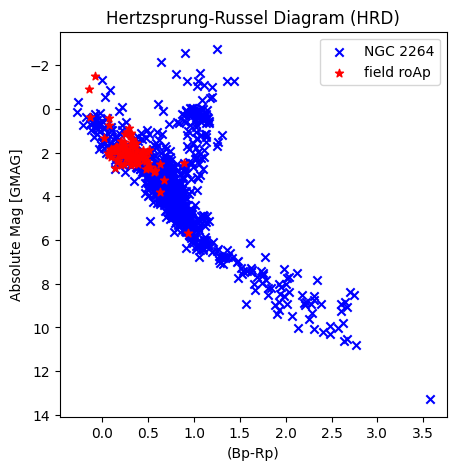

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(x=xc,y=yc,marker='x', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='*', c='r', label='field roAp')
plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.gca().invert_yaxis()

### 2. Splitting the data to be used for training and showing the sizes

In [7]:
column = 0

# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


### 3. Training the Linear Regression model and plotting with the HRD

Coefficient for roAp or slope(m) in y = mx+b: [3.45790192]
Coefficient for cluster or slope(m) in y = mx+b: [3.15869798]

Mean squared error for roAp: 0.25
Mean squared error for cluster: 2.23

Coefficient of determination for roAp: -2.10
Coefficient of determination for cluster: 0.42


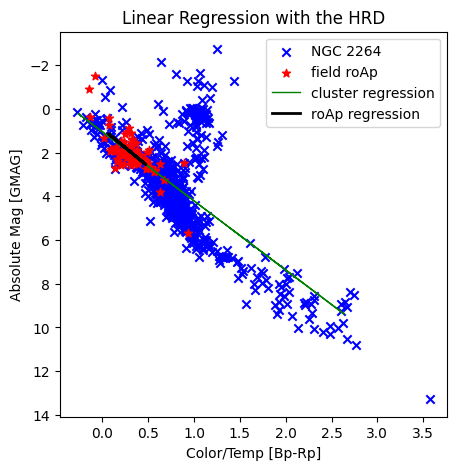

In [8]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(5,5))
plt.title('Linear Regression with the HRD')
plt.scatter(x=xtrain_c,y=ytrain_c,marker='x', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='*', c='r', label='field roAp')
plt.gca().invert_yaxis()
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

### 4. Training and plotting the concatenated dataset with the linear regression

Coefficient: or slope(m) in y = mx+b: [1.53782136]

Mean squared error: 1.80

Coefficient of determination: 0.43


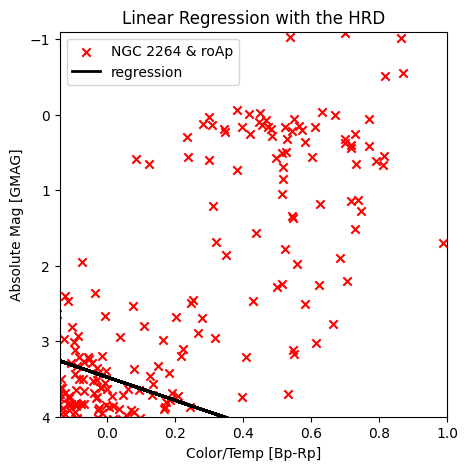

In [9]:
# Calculating the point-density
'''xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]'''

reg = LinearRegression()

# Fitting/Training the model
reg.fit(xtrain,ytrain)
# Predictions
data_y_pred = reg.predict(xtest)

# The coefficients
print(f"Coefficient: or slope(m) in y = mx+b: {reg.coef_}")
# The mean squared error
print("\nMean squared error: %.2f" % mean_squared_error(ytest, data_y_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination: %.2f" % r2_score(ytest, data_y_pred ))

plt.figure(figsize=(5,5))
plt.title('Linear Regression with the HRD')
plt.ylim([-1.1,4])
plt.xlim([-0.14,1])
plt.scatter(xtrain,ytrain,marker='x',c='r',label='NGC 2264 & roAp')
plt.gca().invert_yaxis()
plt.plot(xtest,data_y_pred,c='black',linewidth=2,label='regression')
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

In [10]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)

pred = regr.predict(x.reshape(-1,1))
print(regr.coef_)
dist = np.abs(y.reshape(-1,1) - pred)
print(len(dist))

[3.45790192]
1058


Stars in NGC 2264 following the regression:
1.5145129859572553
4.189231240885423
3.9424062019566293
3.173012651427441
4.438573632410746
3.04603157718335
4.246649702238921
3.8808901268299376
3.59020505996933
4.166872447081646
3.651219739317867
4.4823195495792545
2.8171461334067356
3.5242767019948777
3.934577512013581
4.204069098016881
4.49000992344557
3.4842272819770397
3.8139486035934214
3.9889322722674576
3.455052963492279
3.0525912171223792
3.2414272408811557
2.7868860337196257
4.063491553430005
3.734185180043821
3.548153514740792
3.961652884033929
3.6678591633487634
3.020488055712812
1.6594578606669534
4.257701156769832
3.5126546936474465
4.21874097585626
4.687082669573755
3.7193991914411377
3.3490578959903967
3.092194567792756
3.005971783459757
3.121527949765759
3.52494753496703
4.042125177476783
2.425282856416449
3.594693416659293
3.6940389387722696
3.4061513145635733
3.7700574545443435
3.5604809350795583
2.9728277935727787
3.197529176028241
3.813799913810934
2.5626065152981976
2.

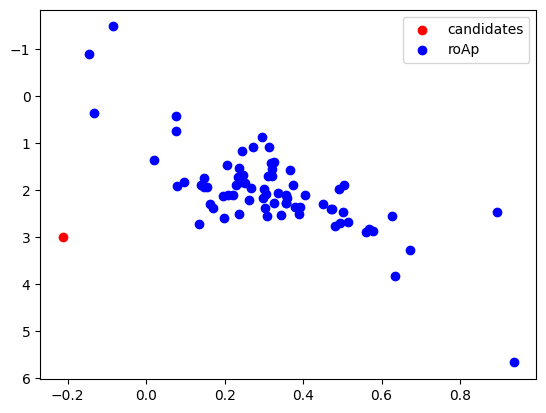

1.3849799800974534
2.1166305311883153
2.5275053529254574
1.020655433984568
0.20552421478192517
2.951198617073765
1.0071308668512735
2.410347465300484
1.5102251875785537
0.94824350991329
2.70402778795314
1.7747858054463475
4.087517055958406
2.1127231020206274
1.3225468482316165
0.18878105369347953
ID: 93 --- Gmag: 3.001051 --- B-R:  [-0.21235636]


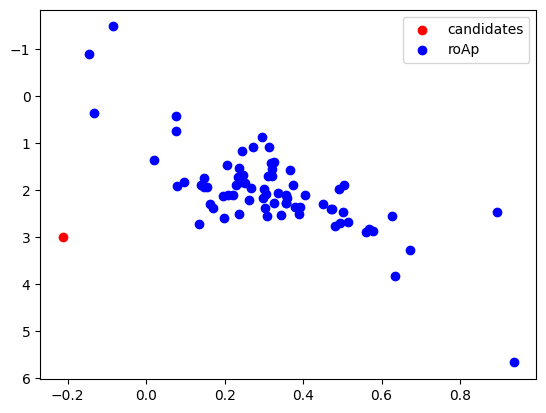

2.6132405730879746
3.132949399801929
2.2412878953433033
1.5660460982457929
1.1369792545164348
2.65170281612531
2.2045269400497753
0.421663832087658
2.669310452693332
2.638777178754676
2.096837500607923
1.705866362312559
2.2699704790248703
2.810589951369624
4.967940379182533
5.1945954762218385
2.7447445830412116
2.1527379430192823
2.740868274990789
3.040996871990294
2.492891754723199
3.9115686326491623
2.246685680237781
1.3503318028760116
2.0032735905023564
0.5467388896439678
2.2418134964348857
2.5512369337908014
4.194642857387574
1.625380237262032
3.066924220573764
3.327275859076183
1.5910640186247482
3.42961317907929
3.8763187804939347
1.671972007709308
2.534085740275996
3.562818476776334
2.0859554832710083
1.2422439919827601
2.552917474123099
2.6065910276990696
4.457512561217316
1.5414949946258085
1.7297431750584735
2.3568371458454687
1.6916025168995406
1.3470087591325184
4.124136237273284
1.365850866685376
3.22029254435646
3.0283202035577785
1.8145101826838648
2.7165073559763124
2.5

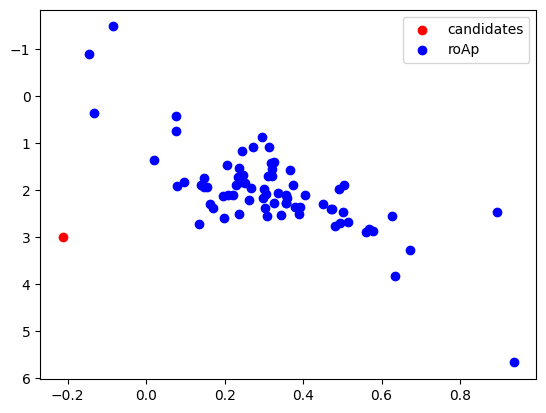

2.736864024569389
1.2209267393871874
2.7977092667239285
2.0507056311157816
0.32682670134536096
2.9373981305177996
2.681765815403076
0.9959314352686688
1.9317434314202462
2.162122688825569
1.6202037580903257
2.4573618125125885
2.236184032111881
2.471912663784826
0.7126670259247501
4.8067779444759715
2.572873026093652
1.5024691135757893
3.3706939882932474
2.2935886618577053
2.6115289116384126
1.4399398731870345
2.3826849626848174
2.658324698298869
2.6882078866768833
2.2409109840342074
4.515103917666728
2.591317474925905
2.663833136054733
2.3070537319275948
2.0554187514304347
3.1936390363701452
2.27426936384012
0.7211285119188489
2.730338963649542
2.6776854911394734
2.2388950272158343
1.6898666501365502
4.055147636101129
1.8670011338037735
4.270989873841888
3.2866738874822103
2.679168931062427
1.3672720643738003
2.870581091750342
4.289901139433112
0.34479467244368056
1.493205394336644
4.370970937177038
4.892692975538242
4.2338485493373454
2.4097672505090024
2.1224709275283367
2.5911929904

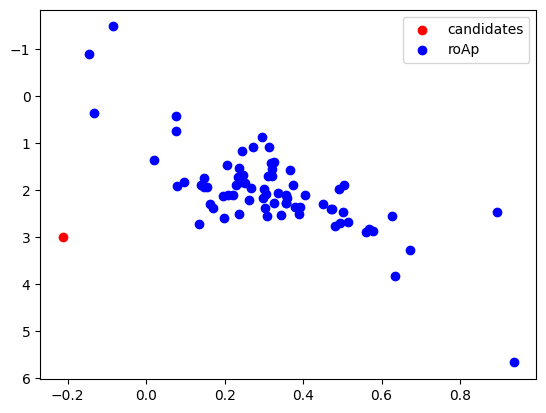

1.9244154245245584
1.9386938142760446
2.056546027455803
2.331186429415463
2.466964406139728
2.3167980995333854
3.4993618059426765
2.3573316258197865
0.8811878759134695
3.4616160613332267
2.2251740724039903
2.6645281743403126
2.1130377710951933
2.077165496594671
1.6984318731881975
1.981447313593999
2.4120148867559026
1.714182616426089
2.4136815954805266
1.1622738070488543
1.838113821178232
1.9557032338121996
2.234292559762567
2.4050230090770848
1.733771630793301
2.5956605997352993
1.5623426852912852
2.408442874074291
1.2486141600470768
2.0192421815611006
2.9074561578071743
3.0769555940387745
4.419938998972986
2.5944530792350164
1.6878299459066666
2.6868558470268242
3.8164410381457277
4.830090406478407
1.4240438980685743
1.2710732330064838
2.134736105632574
1.8636020162180769
0.8872806990935276
2.08441254628465
2.0716328535253785
0.8437975824708097
0.8686668130672777
4.7789971604642885
4.0139813137636775
1.5478160393324751
4.397836089911164
1.87552831993432
2.1470462364617484
1.023757172

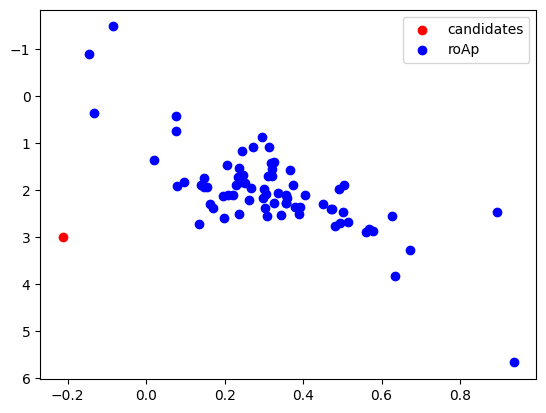

2.4721512590171892
2.293841088697741
4.357800501500999
1.5833632710526766
1.1415263955390094
2.2833256089641685
2.59482032956915
2.0978887027910886
1.7922862470549017
3.67475076187195
1.7699274532511255
4.678749125950634
2.1093723950617873
2.5942497757526297
2.0518882335718427
1.965361153870032
1.1656245140076944
1.3303658771997044
0.902073603500047
2.3516122560469057
2.9123940417465173
0.6482213951424587
3.455467911722476
1.7086223101414504
2.2945015479641384
1.722526533754965
1.951854588977123
1.6239763290831997
2.0334749058568544
2.2309626002152365
2.1765283082172386
1.847038666029384
1.3407188355431163
1.7770188973547807
1.8681422414368152
3.5400620242519523
2.3283924446654707
0.7581972204831056
1.5989480349984895
2.2764063472256346
2.474509548125475
2.5079958703023655
2.0946659382032253
2.315027653751212
1.2159611922324975
2.5495079828316483
2.2140257966193664
1.8584255370463705
2.259051137497649
1.4002051222437615
2.1895957195665234
1.5982011281841348
2.451068431021268
2.30426666

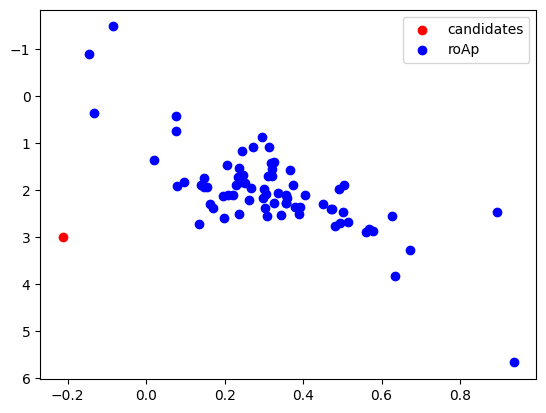

0.4951124140036356
3.5681194404170995
2.5397809047354487
3.4341395726903547
4.435392362645903
3.193390067432027
0.7237150225537423
1.4984406578409617
2.0264553649626906
0.813239390487932
4.769940915340241
2.1250436065555576
2.8800723197853024
2.1109111614154346
2.7588797733524597
3.2106899507293196
2.0303558783265414
2.422641019350862
0.795259013243526
2.3503155428275404
2.3939680966442554
2.8245425856099953
1.4125602057978748
1.7537894249983843
3.3479306199650285
2.3304741016202914
2.336573840604186
1.1647738701357913
2.5949863088612286
3.676317191440943
2.488839093674942
2.624942113179528
1.719666848868525
3.471277439292978
1.857083871102068
1.8725476084807386
2.3911187854635703
1.4960194137673524
1.2660627331268568
3.243366411126532
4.2814880640658695
2.292793344416494
1.1632696828013271
1.4194241411057158
4.462667580246718
1.1807320874887806
2.366951508956518
1.3810448877144195
1.4172871577202013
2.77762231448048
0.9103483627905575
1.5246273490683047
1.9596590736067432
2.3224828902

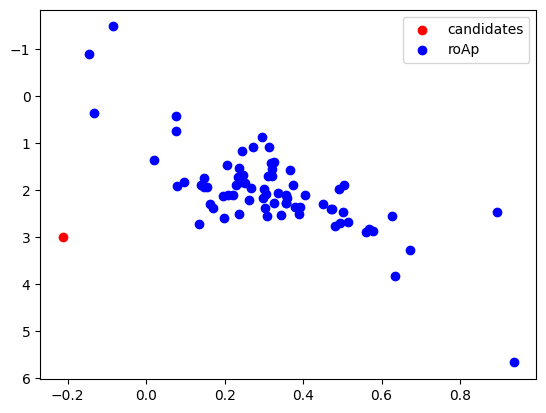

0.7905735561442189
1.8953835927492424
1.653126442254532
2.23702430227803
1.9843830723226423
0.8469650206279793
4.005765338805778
1.2086477296752776
1.5974161844486794
1.0985100956752634
2.1317277309636458
2.3470996940435143
2.2971157218143787
2.9921851285114647
1.496973794696805
3.157054434074451
2.104547909154955
1.1244236126510607
4.242530628323422
0.955843978329729
1.757727975283336
2.4753048655666863
1.0372775685058722
2.8530253237110945
1.4592626291065365
1.5253016399423744
2.3710698701412225
1.451800476766829
2.148941166712981
2.334447230924427
2.2911750463187266
2.065204613859245
0.8661798688572206
3.258813571726406
1.9917829824278206
2.092304191193022
1.2321614627197688
2.651021609447403
2.198679627905917
1.802079025287549
0.1557995851966627
ID: 93 --- Gmag: 3.001051 --- B-R:  [-0.21235636]


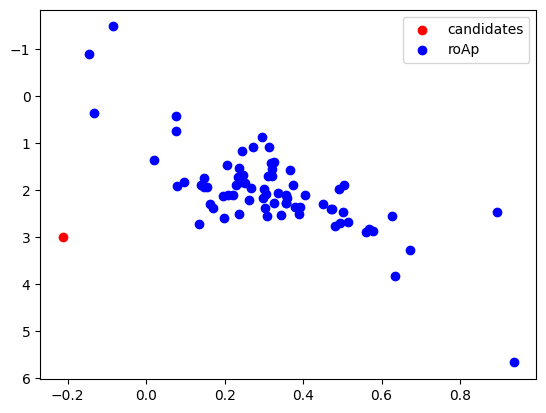

2.3608552278745423
2.1505110541838928
2.4246708077769084
4.782282167286681
3.5138372961035076
3.1943790273806627
2.539787820539286
2.89594134441921
4.598235337684761
1.5749744009988635
3.0310692355828333
1.4832673842234279
2.107000274345829
4.483612092165908
2.379704251231237
1.3804466706825522
1.9622040894186172
0.8414150880490956
2.1918537295191776
2.2772120383726007
2.099939238628645
5.000935679287023
1.8519410140427444
0.8227772408854237
0.5759522019566297
0.1934413485725588
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


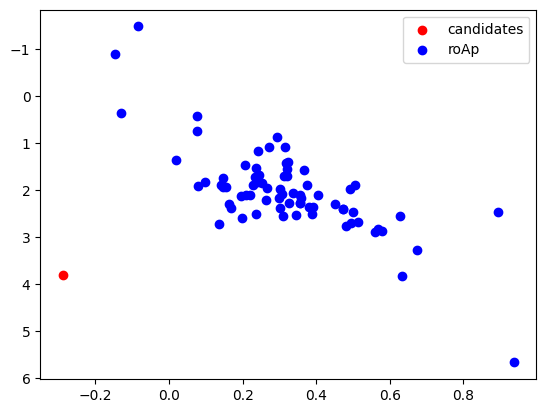

1.0721196324107458
0.32042242281664945
0.8801957022389209
0.514436126829938
0.22375105996933042
0.8004184470816469
0.28476573931786753
1.1158655495792549
0.549307866593264
0.15782270199487813
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


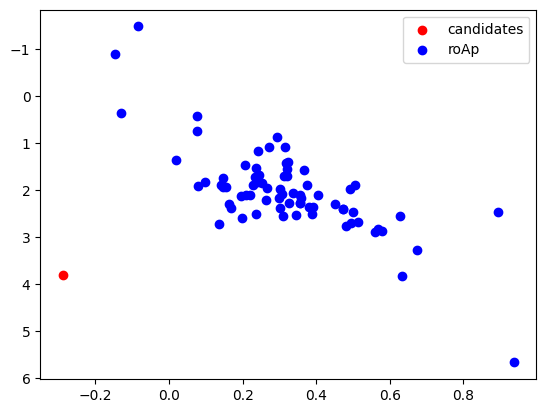

0.5681235120135812
0.8376150980168815
1.1235559234455708
0.11777328197704007
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


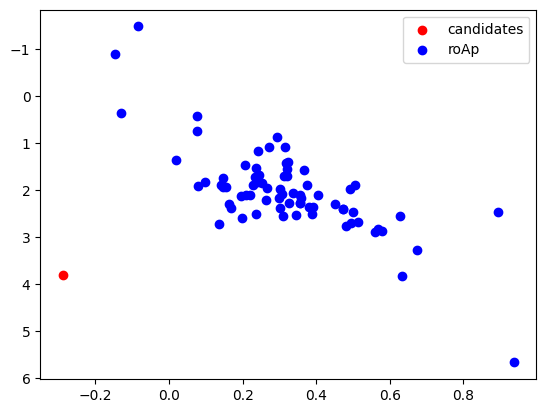

0.44749460359342175
0.6224782722674578
0.08859896349227947
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


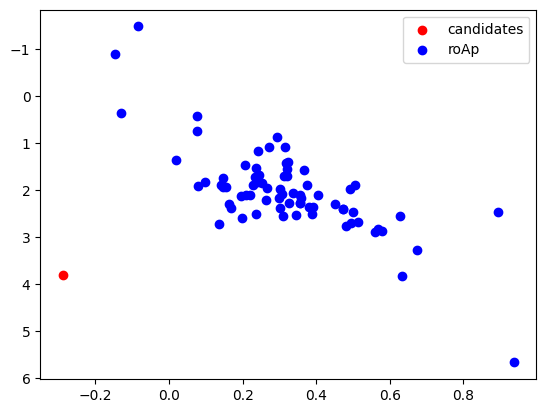

0.31386278287762037
0.12502675911884387
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


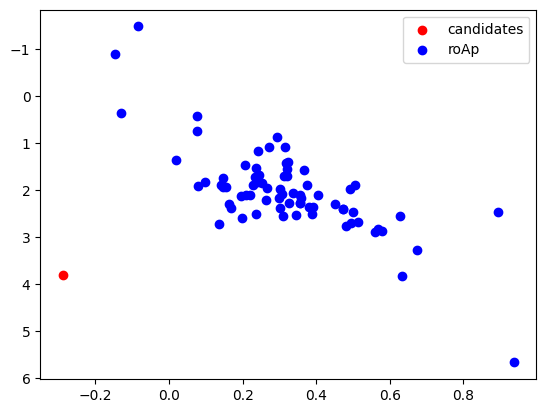

0.5795679662803739
0.6970375534300057
0.367731180043821
0.18169951474079227
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


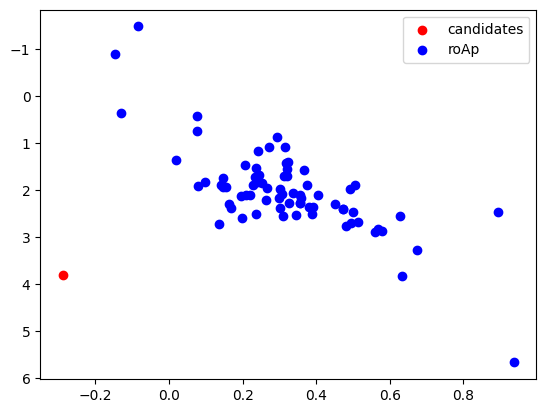

0.5951988840339295
0.30140516334876377
0.34596594428718763
1.7069961393330462
0.8912471567698319
0.14620069364744692
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


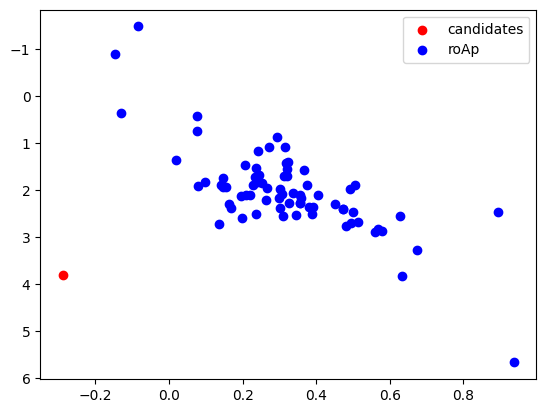

0.8522869758562606
1.3206286695737557
0.3529451914411379
0.017396104009602897
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


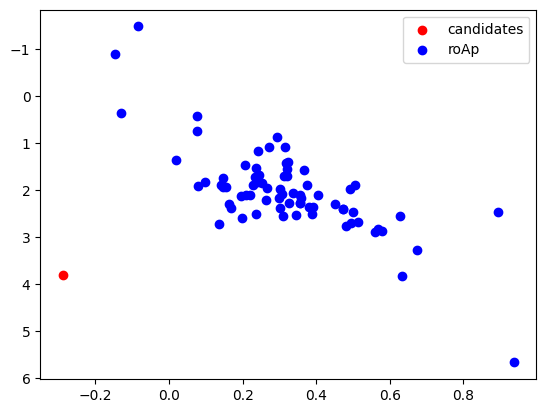

0.2742594322072436
0.3604822165402428
0.24492605023424074
0.15849353496703023
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


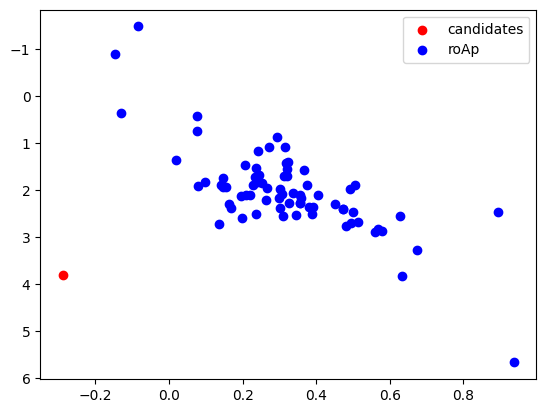

0.6756711774767832
0.9411711435835506
0.2282394166592936
0.32758493877227024
0.03969731456357373
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


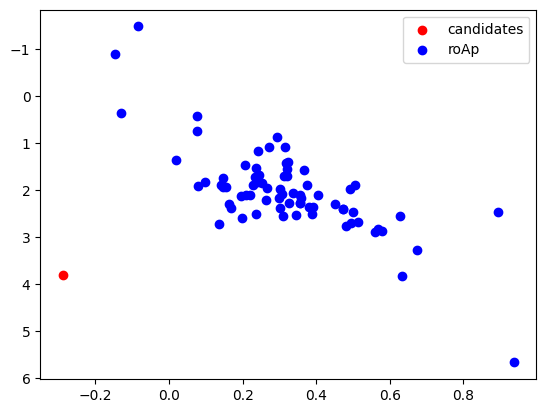

0.4036034545443439
0.1940269350795587
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


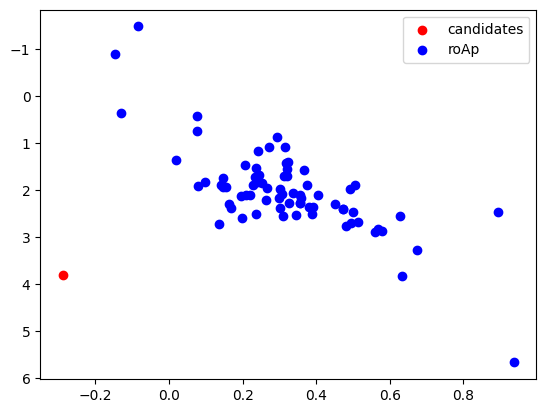

0.3936262064272209
0.16892482397175845
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


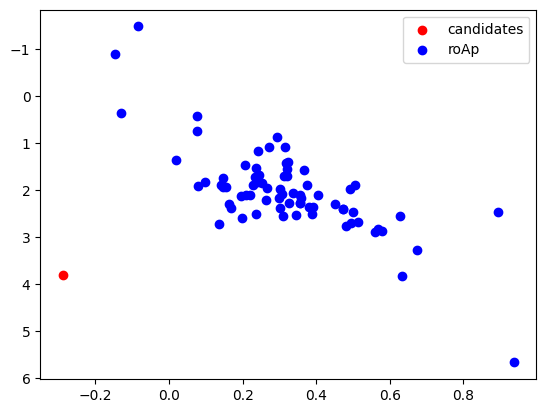

0.4473459138109346
0.803847484701802
0.6114567377710061
1.167405577671629
0.7797874031542187
0.25195596483415983
0.2741983910555197
0.30990814416588197
0.637814067275152
0.4761571525942734
1.893067042639982
0.5695862045250255
0.5856204957202173
0.7073248116369706
0.34807992344207905
0.536853704966326
0.09803211992542238
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


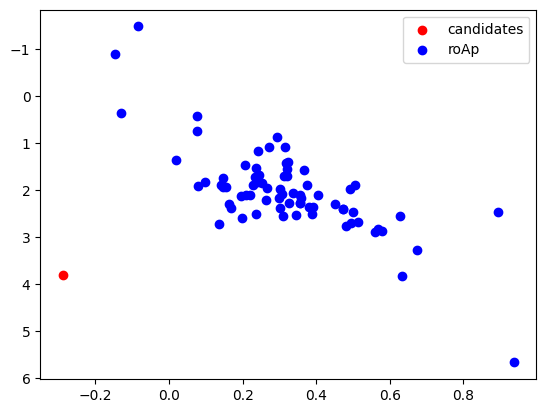

0.8965965310374537
0.3173599227998347
1.841755236074216
0.6709822624755581
0.2529967933115702
0.3413058935841147
1.682740158458924
0.07054179967487739
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


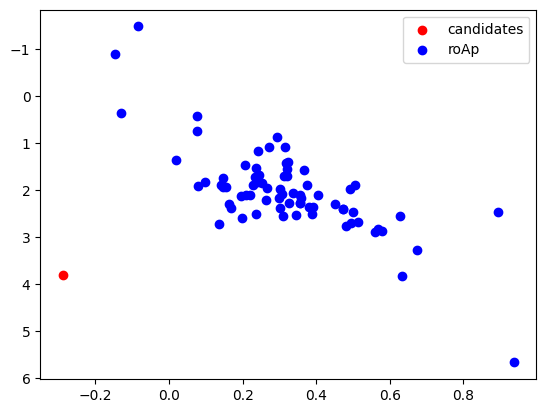

0.2769232177671461
1.0510748413359259
0.5459825660306579
0.9021015108913994
0.15488694326623564
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


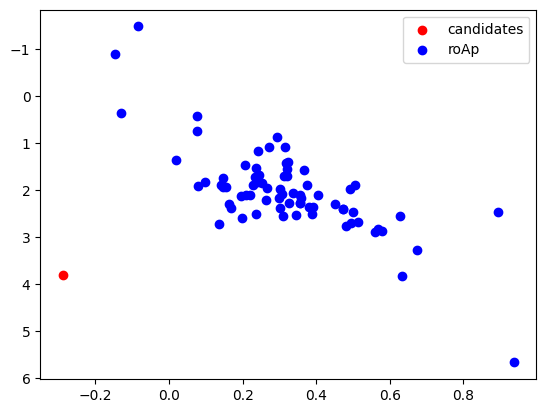

0.33237759083104446
1.129527720058488
0.66247928165844
1.123714986933813
0.1438066244371723
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


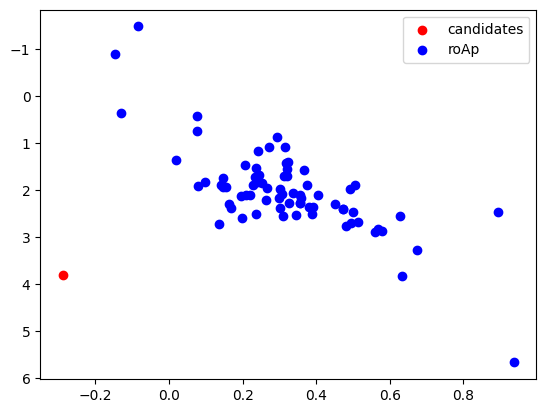

0.547659648461037
0.029600240962115887
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


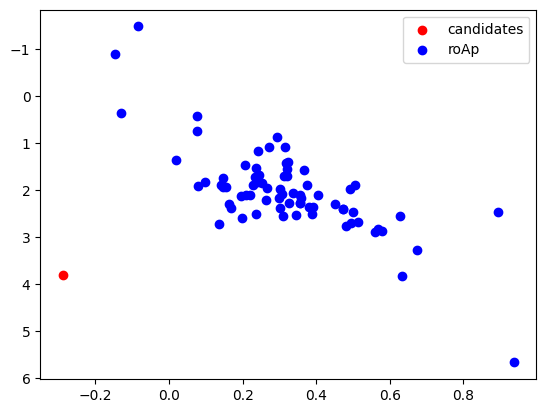

0.09355985166224512
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


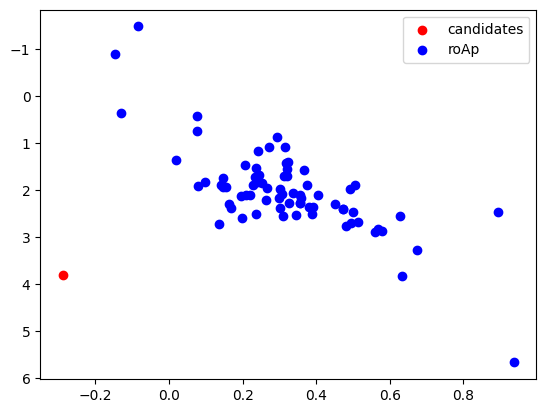

0.26015585136527264
0.46475299206769494
0.8770628431009342
0.9181012230674084
0.2643191652749146
6.932764244983028
2.116630775364321
0.36107126094916064
1.6842811816316838
0.6399048968529226
0.381419812655595
2.5052216760570833
2.0183145069401953
1.425412270321424
6.597050379342221
2.208295096233931
0.22913727007524853
0.8542982736899094
2.1958362756222685
0.04825442072857955
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


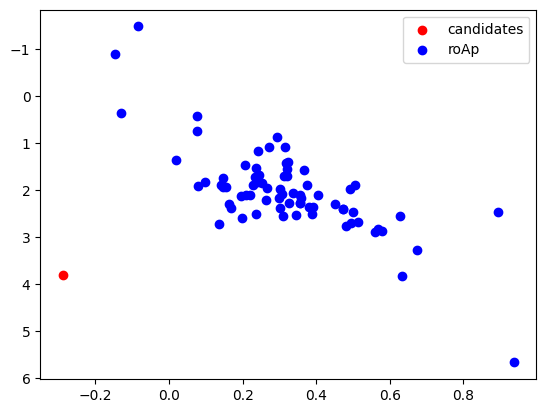

1.9736314983518244
3.0243876121698636
0.5826109199684848
0.7408652591617488
5.567992600061563
2.160441191586473
2.3773553789219064
1.0205334505106278
3.0313449108294983
1.6197671055418197
1.372644687048051
1.034835332844748
2.070366304516479
5.987719650709572
0.9087671447070904
0.19246050551056504
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


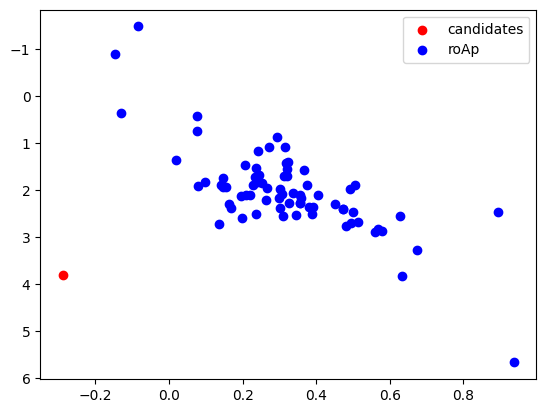

0.10221843806568698
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


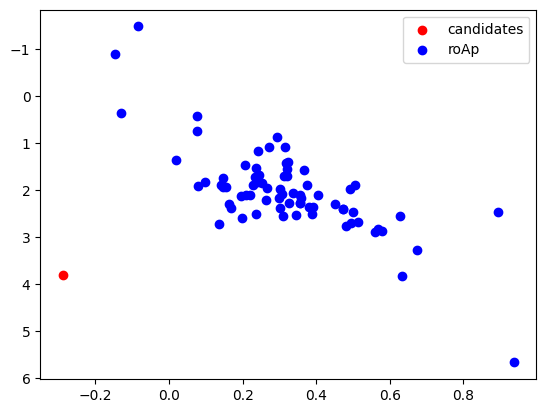

0.7831069889957933
1.3491447856112324
1.2062711941506001
4.789867847188649
1.6284326077490978
0.9136578191023832
2.197433826308527
0.8545069488878139
1.6923138877879125
3.42654852107287
1.9814740199025462
1.2498234688116843
0.8389486470745422
2.3457985660154317
3.1609297852180744
0.41525538292623443
4.373584866851273
5.776801465300483
1.8562288124214459
2.4182104900867096
0.6624262120468596
1.5916681945536522
0.7210630559584066
1.2537308979793722
4.689000848231617
3.17767294630652
0.753213426912025
0.23350460019807073
1.1251661046566963
1.8004079017542067
2.229474745483565
0.7147511838746898
1.1619270599502243
2.9447901679123416
0.6971435473066676
0.7276768212453235
1.2696164993920767
1.6605876376874407
5.636424479024869
0.5558640486303754
1.601486379182533
1.828141476221839
0.621709416958788
1.2137160569807173
0.6255857250092105
0.3254571280097056
0.8735622452768008
0.5451146326491627
1.1197683197622186
2.016122197123988
1.3631804094976432
3.9131928896439674
1.124640503565114
0.815217

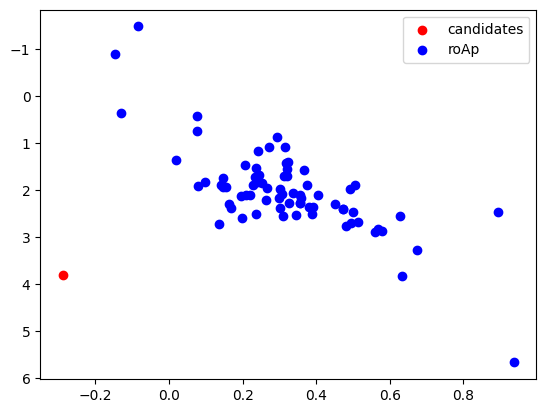

0.5098647804939354
1.6944819922906915
0.8323682597240034
0.1963644767763344
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


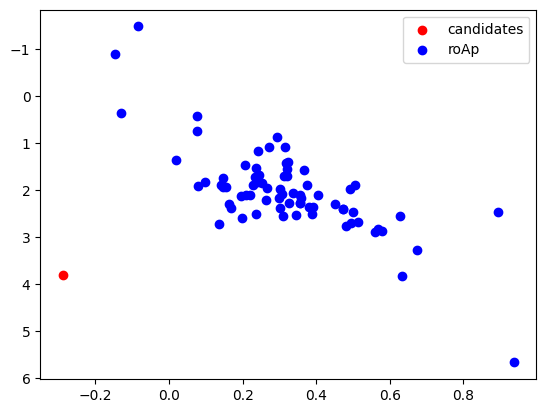

1.2804985167289913
4.60869799198276
0.8135365258769007
0.75986297230093
1.0910585612173163
1.824959005374191
1.636710824941526
1.009616854154531
1.674851483100459
2.0194452408674812
0.7576822372732837
2.0006031333146237
0.14616145564353955
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


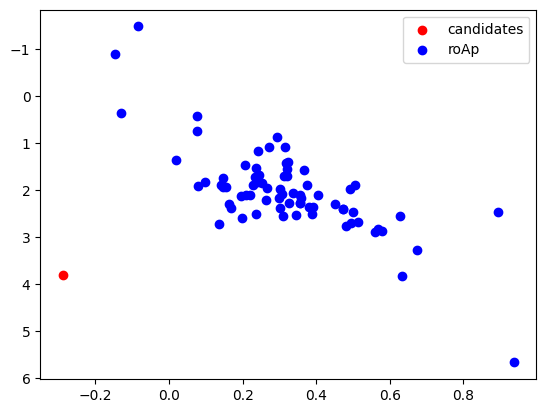

0.3381337964422211
1.5519438173161348
0.6499466440236872
0.8331220823421943
1.7482627408261293
1.2192867369711107
0.9985861470351298
0.7127952124717332
0.831458831519488
1.21802114486901
0.8693781839556496
1.4731762695190063
4.343594483513792
1.5808242141378392
1.8742721446311745
1.2943508718137307
2.09136614286636
1.5815572893445204
1.0535149190074455
1.9249062024209525
3.1542629503195774
1.473840186687322
2.1749540059376087
1.167100081220012
1.4570002043451642
2.2716542330830802
1.3095794718619573
2.455818631350223
6.416914436809908
0.8611552931939142
1.8338423554023229
1.2398750849927134
2.4584673842196465
2.5761363285977352
0.42113381618735746
6.2783874280605865
1.2262855304537648
2.6333922685610722
1.677469114852618
1.9553219076943855
4.654947430140124
1.9056456887359796
1.802780022470166
1.3118478555203672
0.8456742663056507
1.482927552928634
1.2904814795671444
0.34139805585310334
4.763753771901589
1.1299068881866963
1.5574730024835088
2.4565966592818422
0.8054865302110801
0.8611

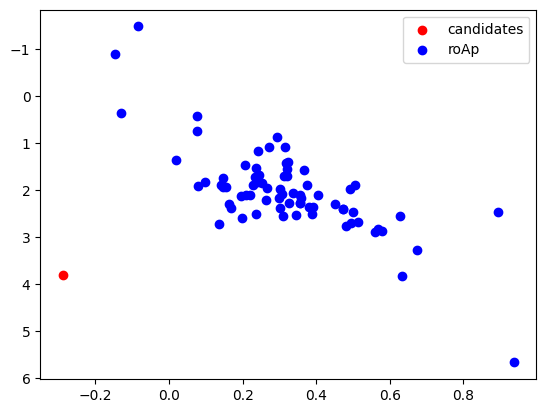

1.4629720009580809
1.3027824377733703
0.7684316532544968
1.0550052747342362
1.240092932813567
1.560796046227002
1.203117587601104
0.2638718948446477
1.3146292097454921
1.2724934737881086
1.729635023192206
0.7843449178825481
0.9210703597324295
2.1626784541276174
0.30503596036298664
0.3815442971246541
1.4892001870084441
2.3334400245594
0.8152620189341353
0.05309202551229175
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


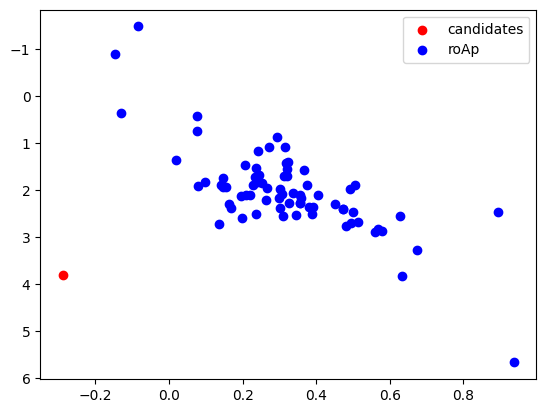

1.421584372897858
0.05879876476030477
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


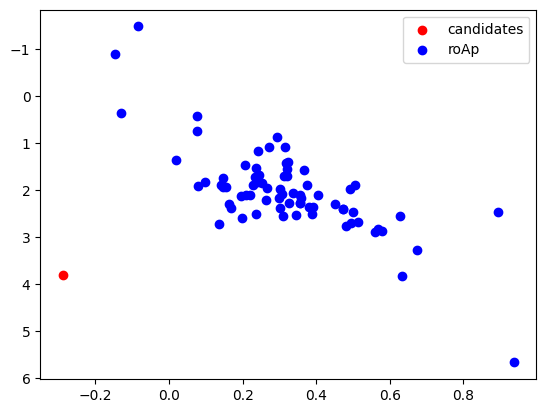

1.574514744219734
0.035684947255531174
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


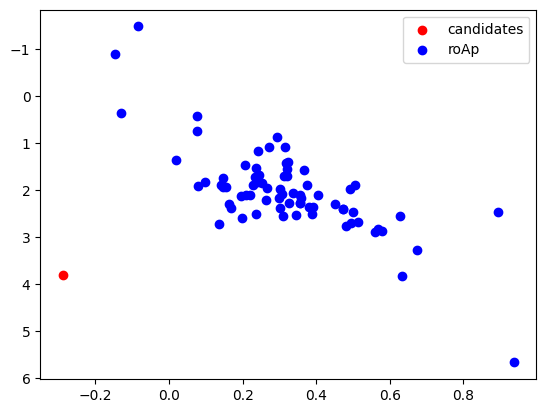

0.954179770600224
1.6215375513239931
1.7075217404246286
0.8037437476442535
3.3101970373256573
0.6295899754306107
2.145527260612812
0.5687447332760711
1.315748368884218
3.6932807013453606
0.4290558694822
0.6846881845969235
2.370522564731331
1.4347105685797534
1.2043313111744305
1.746250241909674
0.9090921874874112
1.1302699678881187
0.8945413362151737
2.6537869740752495
1.4403239444759721
0.7935809739063475
1.8639848864242103
0.004239988293247787
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


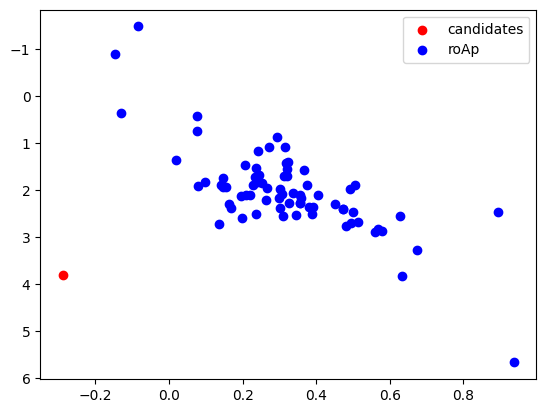

1.0728653381422943
0.754925088361587
1.926514126812965
0.9837690373151822
0.7081293017011308
0.6782461133231164
1.1255430159657922
1.1486499176667289
0.7751365250740947
0.7026208639452665
1.0594002680724048
1.3110352485695649
0.17281496362985438
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


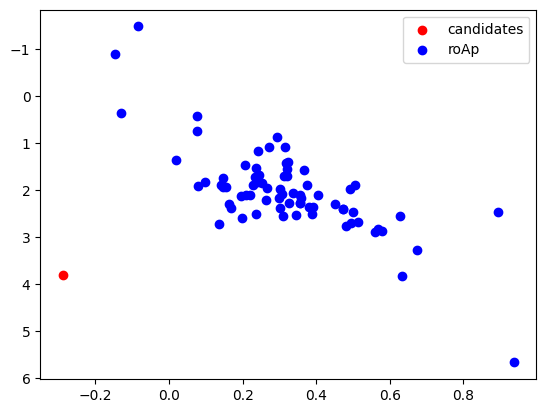

1.0921846361598795
2.6453254880811508
0.6361150363504575
0.6887685088605262
1.1275589727841653
1.6765873498634494
0.6886936361011293
1.499452866196226
0.9045358738418878
0.07978011251778927
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


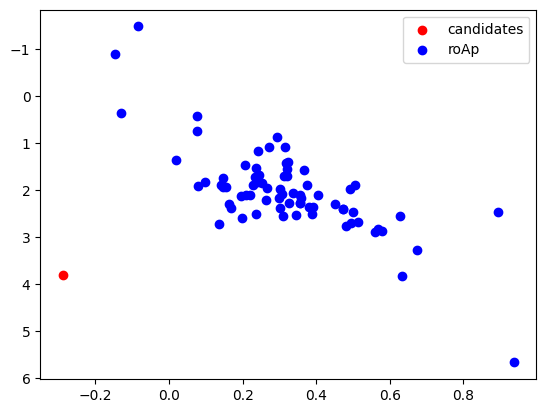

0.6872850689375727
1.9991819356261993
0.4958729082496576
0.9234471394331119
3.021659327556319
1.8732486056633557
7.737424937177037
1.526238975538242
0.8673945493373463
0.9566867494909972
1.243983072471663
0.7752610095431538
1.5613596842396862
1.8119434625536814
0.8165518163496643
2.3923730469531157
0.9476235885631126
7.621695875775119
0.6862419836410494
2.3398959274408804
0.6485150726295079
0.7851125721084125
7.70681213149426
0.6511569096950951
0.8805022544268444
0.050610453017752466
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


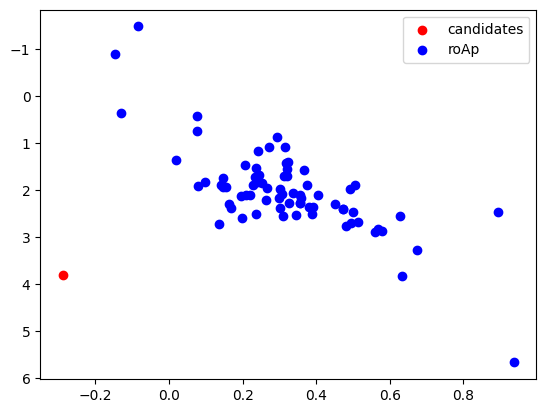

1.1553086356785838
0.09118201622525524
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


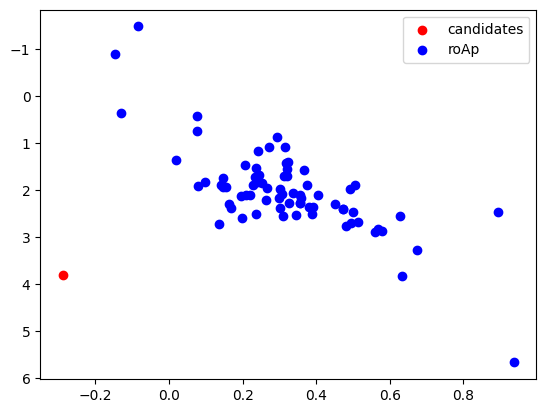

0.9002053795573617
1.4528645536508686
1.9958462613578378
2.3360000730617534
0.18760561121726171
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


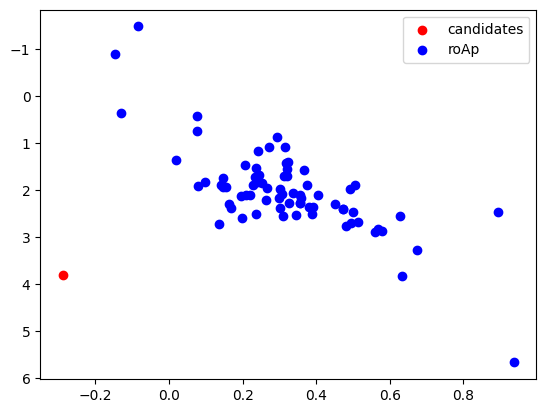

1.3447013816462072
0.9716214278761668
0.6326917134513326
8.118101901461598
2.3483919924541614
1.6628572224286557
1.2630615184377714
1.4874608623435353
1.9588178465337944
2.5742344825426655
0.9548920983953955
2.043294390398049
0.038414432951881405
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


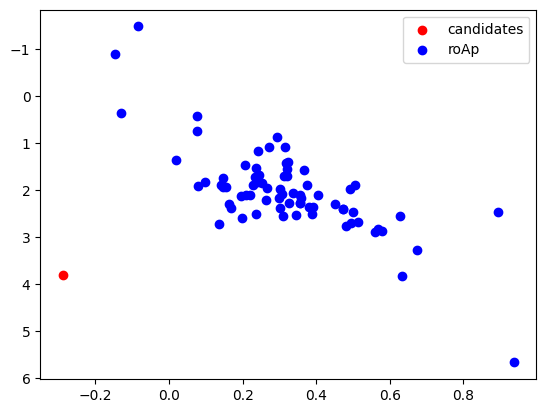

2.1205058823319383
2.0548403249032776
1.2034633777929353
1.5223545506011775
0.681178414149842
2.168992583030447
1.3809851464750085
0.5665455076560275
0.9261845966696058
1.1646795498771971
1.3576754296436975
0.8783306920221476
1.1296060507198038
1.237502964276754
2.7845855720371513
2.0734922478506284
0.7487988872451514
0.46784661320177445
0.6153342469042344
1.2356529867504604
0.9882297307897985
0.9822510183730446
0.8082217306284618
2.43132631206285
1.1397515349481178
1.2160639723832474
0.8623171482384655
2.510771608635967
1.0263703889487314
1.0437186828728797
1.1659831789003987
0.07684209697003341
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


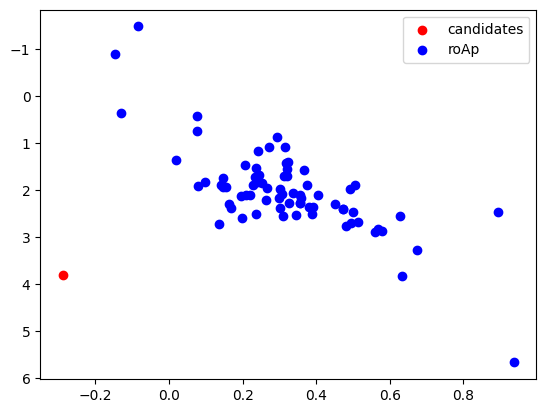

0.9605353943260737
0.49209462253575276
0.7875988035876751
1.5344480346923042
1.605421471565567
0.9726484247459051
0.7221372623721947
0.7330711482378836
1.037926697159715
0.6537330466242346
1.749014306625207
2.309628911949934
1.0478508756652576
0.8785658293525924
1.7416685218679162
2.1425327175515574
1.1779233142243153
2.4356486894607356
1.7913654882378327
1.012843076644312
2.4219381083546456
1.0565232936763729
1.2198896129877013
1.5501975768473897
5.364405166719287
1.4637604025954558
0.9382215532472347
1.103561133471111
0.24978786033138123
2.1058582098059877
0.7930173358936634
1.1688878165117775
0.5875799250250924
0.41717797639281384
0.9926178083241308
0.24775461400341614
0.6781008814425475
2.456634696202944
0.4800599227772371
2.765660474838255
1.3588061635709843
1.0865390834100883
0.009865994714334025
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


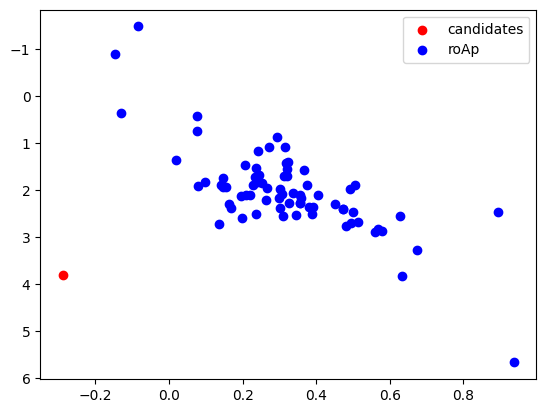

1.3499573925620347
0.6527764088756687
0.9146213726547852
4.255068736503199
1.689997093502646
3.298460918214921
5.290869424524558
1.427760185723955
1.3099079725441967
1.0352675705845367
0.8994895938602716
1.0496559004666142
6.865815805942676
1.009122374180213
2.48526612408653
0.09516206133322713
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


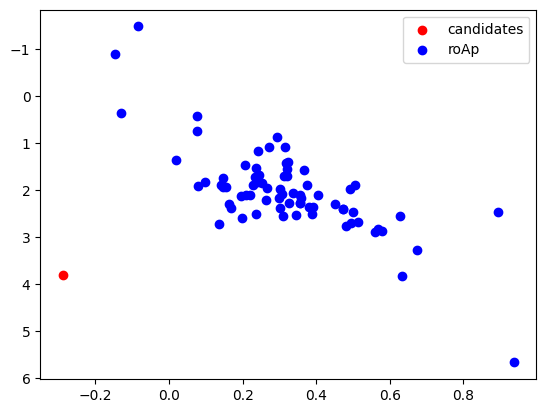

1.1412799275960093
0.701925825659687
1.2534162289048063
1.2892885034053285
1.668022126811802
1.3850066864060007
0.954439113244097
1.6522713835739107
0.952772404519473
2.2041801929511453
1.5283401788217676
1.4107507661878
1.1321614402374327
0.9614309909229148
1.6326823692066985
0.7707934002647003
1.8041113147087144
0.9580111259257085
2.117839839952923
1.347211818438899
0.45899784219282536
0.2894984059612251
1.0534849989729862
5.960907079235016
1.678624054093333
0.6795981529731754
7.182895038145727
8.196544406478406
1.9424101019314253
2.095380766993516
1.2317178943674256
1.5028519837819228
2.479173300906472
5.450866546284649
1.294821146474621
2.52265641752919
2.497787186932722
1.4125431604642893
0.6475273137636779
1.8186379606675245
1.0313820899111643
1.4909256800656796
1.2194077635382512
2.342696827994709
1.786901336861297
1.0915864191280122
1.2260918879463394
0.01588500087130207
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


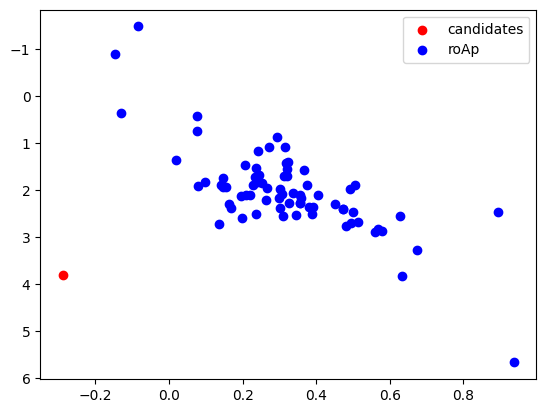

3.74332000000519
3.848007980581951
1.3113533755460494
0.784248096628835
2.587070214463424
0.6601244504520722
6.207099322112759
0.6399060979357281
1.5609597686999683
0.5867431127608618
0.612711956167352
0.6796880584230505
2.1956841279378634
1.2329004968234876
0.5101194641530844
0.021922497620666892
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


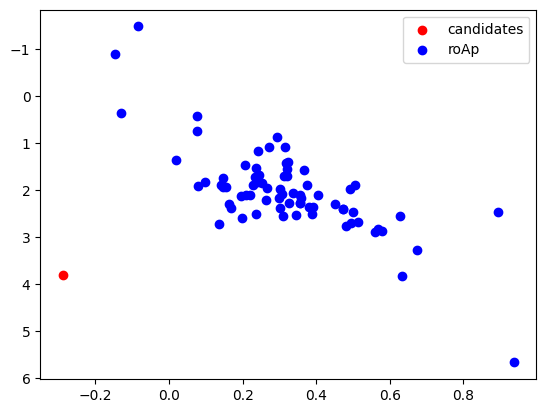

2.037664926075044
0.975705210041689
0.09951090086365255
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


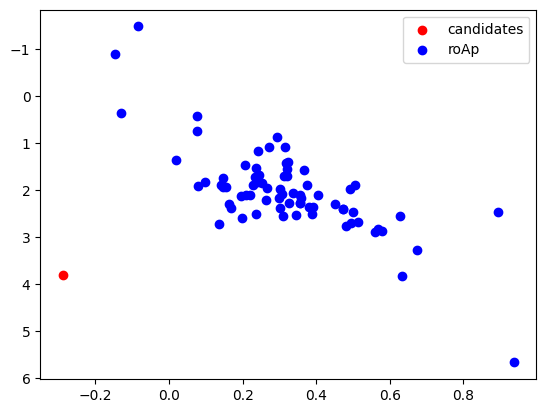

0.7975610190143194
0.8532263240952349
0.5016787255704958
3.035522056346814
0.5920337026958724
0.7148445472264844
0.23797566737844233
5.6366665321591505
1.1263798282300228
2.452889788425417
1.2372678269463093
1.0038144947356105
1.4112763672793833
1.9571476799072518
1.2327587228448365
1.432393774294487
2.0892706543038657
2.3028030135631954
0.609848813378993
0.6599100605331372
0.8940537720446922
0.704093930162466
0.7903927883376674
1.7848784642390876
2.14998449618551
1.3331796524544068
1.7362465316600102
0.7725949671641383
2.661992575327394
0.4377490349048254
0.04084533800045209
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


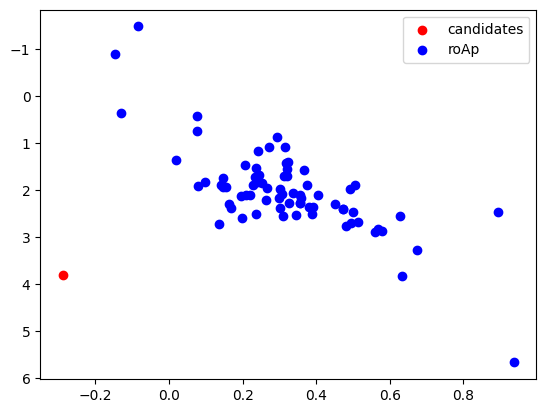

0.4366852021967924
0.46725185407182535
0.32375012554486715
1.2194077635382512
1.0882149647576616
0.684978648358062
7.509168831549555
1.921953154182718
0.47816845042792266
4.0509833652846865
1.1211722279410519
0.9171871358781698
0.6670528848135553
1.2240067730896
6.490878958842506
1.3562161950341713
0.8466874315677146
0.9437023277877521
3.580127776872582
4.960726238874143
0.6130036210112952
1.6233334035024
1.5001893993048259
1.2369612747583858
1.5444090490361426
2.397971390158856
1.1302872573977099
2.4559915264461387
1.7027394620716092
1.422822301784612
1.7440510162896303
1.5875636649766212
0.709094056336339
1.0598809164390501
1.0802272113263718
0.3408759126634391
1.9886664558926257
2.261124921741834
1.0482912302916882
0.26914519527006675
0.5059250291261779
2.7309535132842018
1.5327247984541814
1.3783052724883205
1.9802602963292197
0.5517503464303948
1.9522236275755822
0.9443190354120163
2.2416223549225793
1.748069098318703
1.0926410792130956
0.257398702453576
0.5586234543611845
2.40670

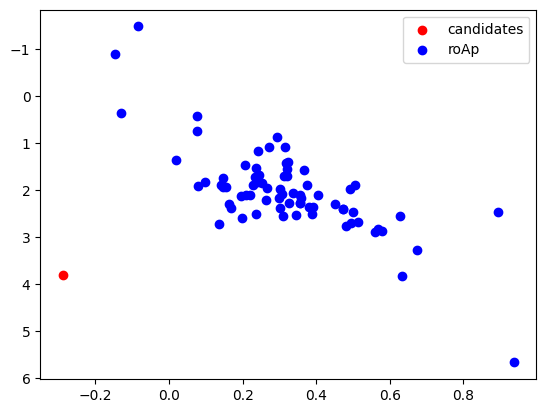

2.0328134896836585
0.7144192252905319
2.3051785921810724
1.3600682977711664
0.12132800514906039
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


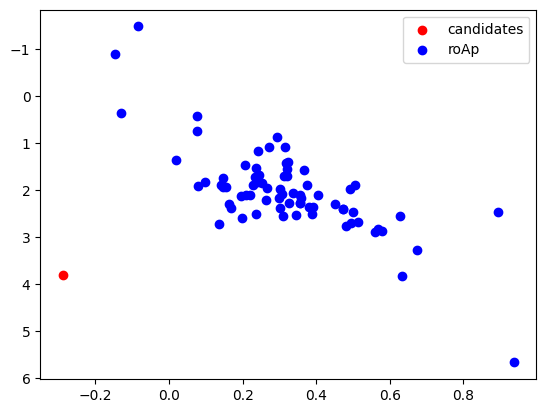

0.7240045294080812
0.8504842078740169
2.1274216861685535
1.2639559139518073
1.1152327535282045
2.964859830646199
1.2838838027070136
2.0494425400088
1.3212545498209693
1.9616809893221538
2.160019327552439
0.3752612893390892
2.259638023916962
0.32142175647104043
1.4822475473335333
0.7627987310295734
0.1820268143402255
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


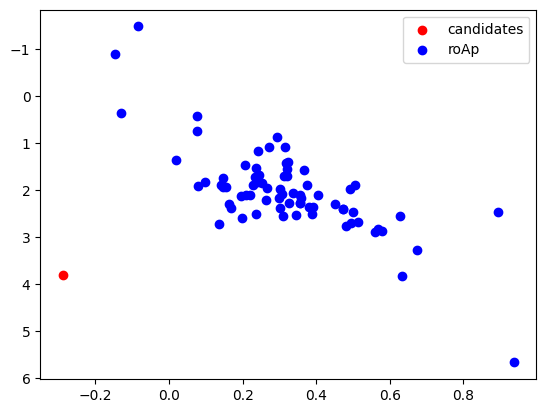

0.5295839940512379
1.6913192131182453
1.0053878401084408
6.524991161266611
0.7265011345930987
2.067472040610855
0.49788660824891773
1.2422817847278558
1.7540028580105198
1.1332921741647195
3.7172370458353954
1.056011524192463
0.8318219112209104
0.6950307692345814
0.07522725677418363
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


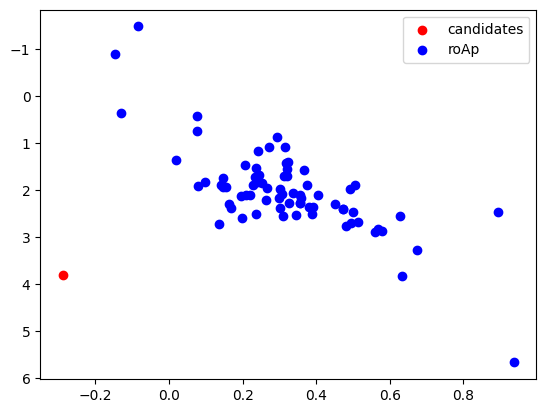

7.194741810117847
2.531868268239562
5.192837905140539
5.548458912125044
1.222447259324443
0.8205249456538
1.5501180451032686
4.636160649017958
4.210406475326339
1.1406609631526332
5.566132248829515
0.9351371047361039
1.3455520255181113
1.0613124878332285
1.6356457911506879
1.8042530886873647
1.3927950826088347
0.8084027426110192
1.5437290434410418
1.7376850188580257
0.6348852243503456
2.5523252159882692
0.7602122203946791
0.13714670534251194
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


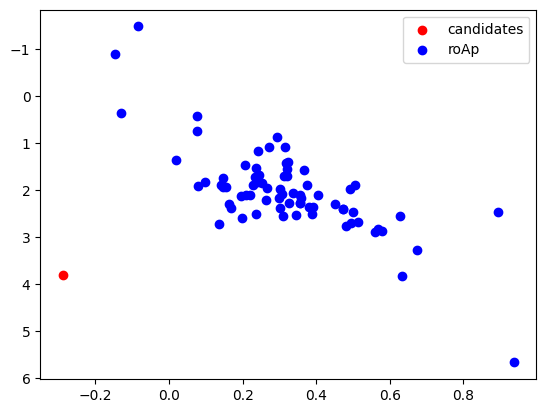

0.38485350926047435
0.8994204358219053
3.50326899093436
0.8943027409828104
1.0726129113022584
0.9913465015009992
1.783090728947323
2.2249276044609902
1.0831283910358311
0.7716336704308495
1.268565297208911
1.574167752945098
0.30829676187195054
1.596526546748874
1.3122951259506346
1.2570816049382123
0.7722042242473699
1.314565766428157
1.4010928461299677
2.200829485992305
2.036088122800295
2.4643803964999527
1.014841743953094
0.45405995825348233
4.014675395142458
0.08901391172247619
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


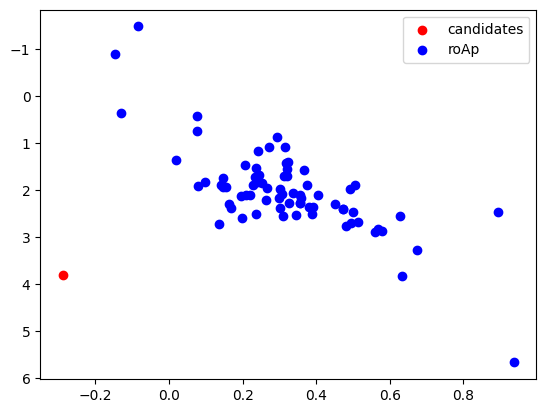

1.6578316898585492
1.0719524520358612
1.6439274662450347
1.4145994110228766
1.7424776709168
1.3329790941431452
1.135491399784763
1.189925691782761
1.5194153339706156
2.0257351644568833
5.14347289735478
1.4983117585631844
0.17360802425195265
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


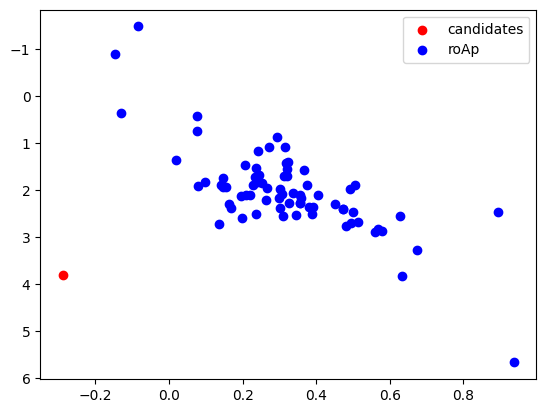

1.038061555334529
2.608256779516894
1.7675059650015101
1.090047652774365
0.8919444518745245
0.8584581296976341
1.2717880617967743
1.0514263462487876
2.150492807767502
0.8169460171683514
1.1524282033806332
1.5080284629536291
1.1074028625023504
1.9662488777562381
1.1768582804334762
1.7682528718158648
0.9153855689787318
1.0621873370185608
2.1577924387170486
1.5517778380240563
1.1190801972804754
1.5861839621112162
0.30850995070807974
2.2291358710955707
0.6990695986751647
2.211175528531881
2.0185634758783126
0.7296663159311558
0.6990799723809196
0.9052331689465807
0.5635267592813449
2.5127564443370756
0.6627408811214255
1.818088154262513
1.919999439598874
1.2771166886528857
2.2300764204173507
1.01595173046887
1.041868705346586
1.041547120468183
1.782948954968672
0.4572965544490182
2.2875951609264784
0.5015576990033552
1.231956489599789
7.948301627763106
0.23636774298642926
1.8632495543984158
0.824933770599642
1.858746165017974
0.6247281653334702
1.4829863372612455
1.0361216723583584
3.36328

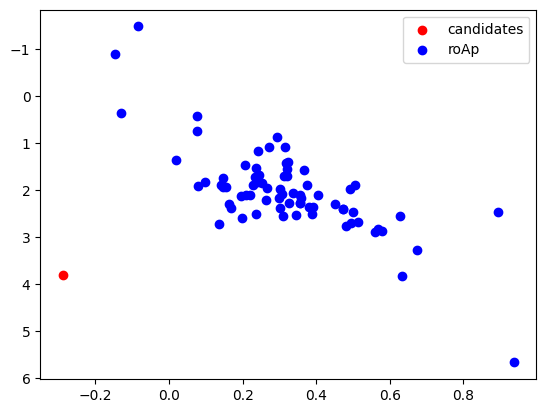

1.0689383626459028
0.1730639325679726
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


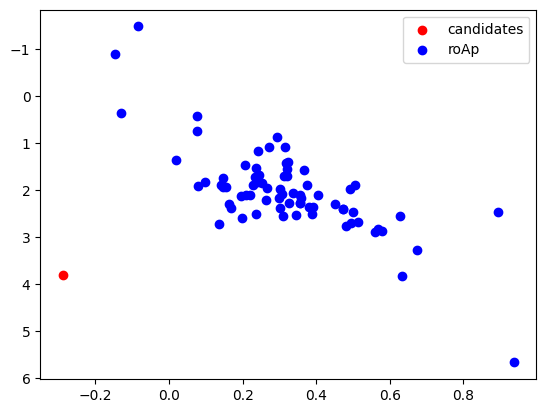

2.6427389774462573
1.868013342159038
1.339998635037309
4.179693390487932
1.4034869153402416
1.241410393444442
6.246526319785302
1.255542838584565
6.125333773352459
0.15576404927068
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


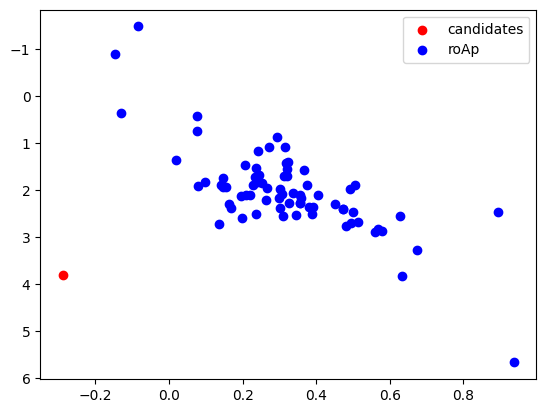

1.3360981216734582
0.9438129806491378
2.5711949867564736
1.0161384571724592
0.9724859033557443
0.5419114143900043
1.9538937942021248
1.6126645750016153
0.018523380034971115
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


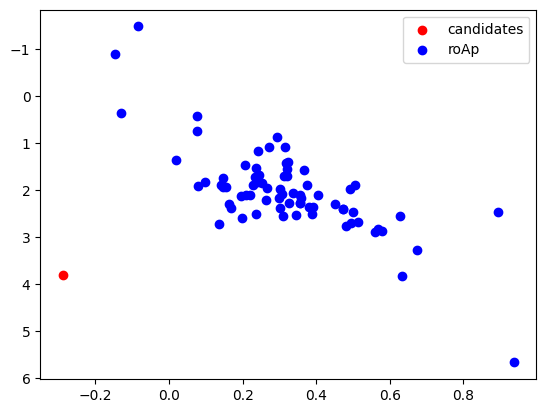

1.0359798983797082
1.0298801593958138
2.2016801298642084
0.771467691138771
0.30986319144094376
0.8776149063250576
0.7415118868204718
1.6467871511314747
0.10482343929297855
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


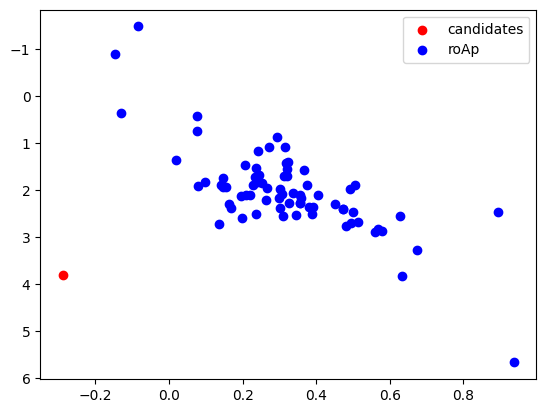

1.5093701288979315
1.493906391519261
0.9753352145364294
4.862473413767352
2.100391266873143
6.609820411126531
0.9150340640658696
1.0736606555835055
2.2031843171986725
1.9470298588942838
7.829121580246717
2.185721912511219
0.9995024910434815
1.9854091122855801
1.9491668422797983
0.5888316855195197
2.456105637209442
1.841826650931695
1.4067949263932564
1.0439711097129165
0.4209828695857576
1.6140719410823672
0.9462058487766067
5.274575790685493
1.2740472728322345
2.144119894532061
1.8809873901565282
0.563710028083015
2.120312239824513
0.9348708462883946
0.9289820393215167
0.9300712784257841
1.534045716986975
1.0285039144323274
1.3113360860364582
2.9362698975856314
0.9262330072964624
0.7806069259088573
2.292259870614275
1.7594213903165072
3.141243949597149
1.5084537848895807
2.742710379806448
1.246608821110464
0.43664370737377256
1.4161658405918698
1.2645645046894294
0.5067422950617035
2.115982946622792
1.2385265032445738
0.5166894777978688
2.443909617143572
0.8413830100250315
0.925852638

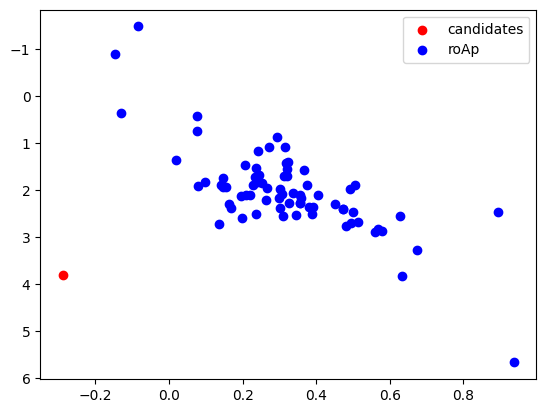

2.485974993979784
1.4359657869760993
0.901260039642445
1.2779189218979332
1.5326798457292434
1.1239731284948804
1.6029478706111715
2.939139956177827
1.315459106205886
2.5033820722365436
0.9503899100977589
1.9008046260503488
0.38508173078708285
1.5707098510267898
1.1523002610096564
2.609415176659527
0.45970791316888393
1.9163306056635494
0.3045714004231277
1.0874957211586538
6.595881608493833
1.3528032458408021
0.8690612580619705
2.2016801298642084
1.0204539187665067
0.5406458222879036
1.18114262091026
2.416792750300204
5.297498222501954
2.535011501083303
1.0462533249789998
1.2212404515549538
0.9698233188786474
0.6134726945893791
0.5349126209073494
0.9516243810825942
1.023946399703997
0.852365306517576
1.6660696133107633
0.9636025533276125
0.7894176599967051
0.8915502510558375
1.2357048552792347
1.1063896972402865
1.7450895879479278
0.05411556448011057
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


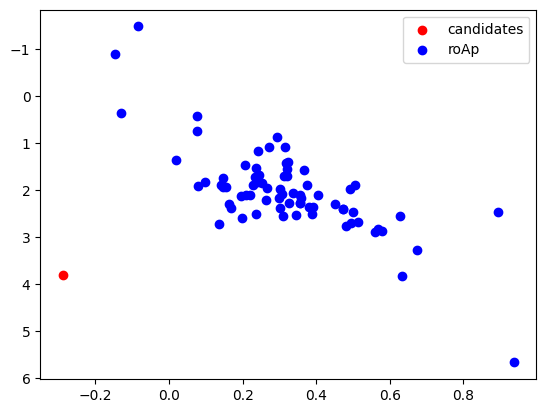

1.1533237999774753
1.0329922711222905
1.130626131785704
0.30689165261031226
0.8151479081708319
1.572986351571842
1.1726603875046506
1.8483309644400312
0.3718103032246183
1.134595803187921
1.601796389272375
0.762193598193869
0.8966091615623211
1.5504707510989362
1.1954168400290333
2.3075622876855917
0.6667797105620088
0.557548046864591
1.7003327623364677
0.48221885465706626
0.64824535627988
1.261206881926753
1.865755332206383
1.0233620142798032
0.7981350307327584
0.8409611459909976
0.6540662062911975
1.4809370025064945
0.4696516380031315
0.9447258667555709
0.8043903753029773
0.9981435355895862
0.8666810204593696
0.9115161767321456
1.846996214299565
1.1038515972322487
1.3420630024825386
1.303621506856714
1.1853301401333298
1.3291339072099873
1.936255036516838
0.5620917299852475
0.7949987136928534
1.0277570076179727
2.987768430854986
1.439911253064888
1.1334270323395335
4.428873260623092
1.353996222002618
0.1300384600812774
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


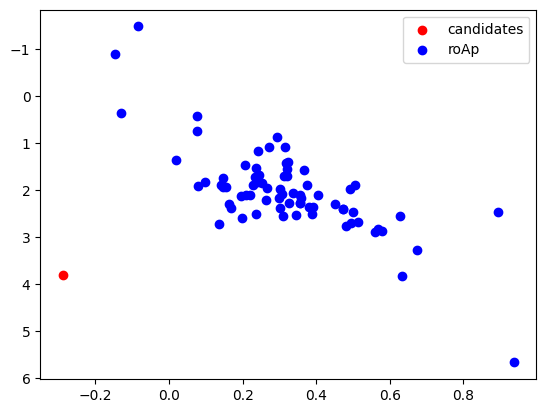

0.5618220136356196
1.765490008183137
0.6664027992529129
0.7844394823171479
2.21773516847091
2.1960437497373673
1.1702675193771825
2.485525466730404
0.08064578908017195
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


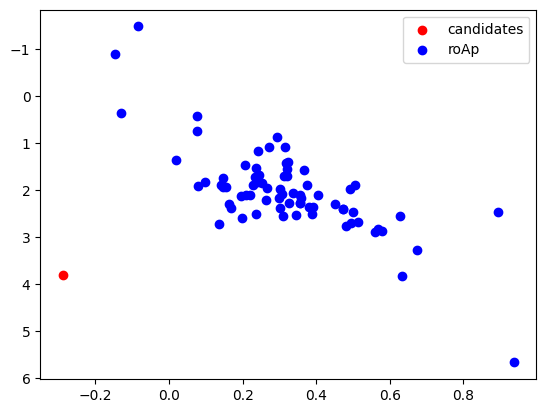

0.721013444248745
0.06044352499061345
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


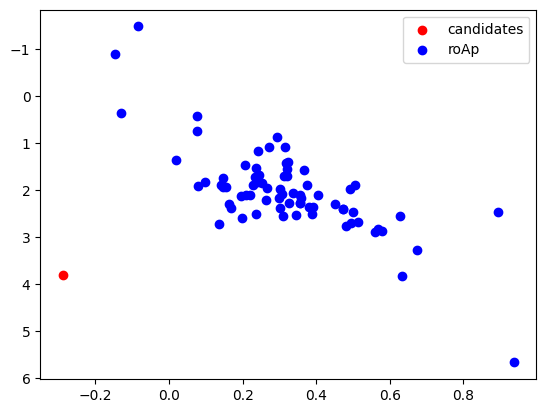

0.18821074405296523
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


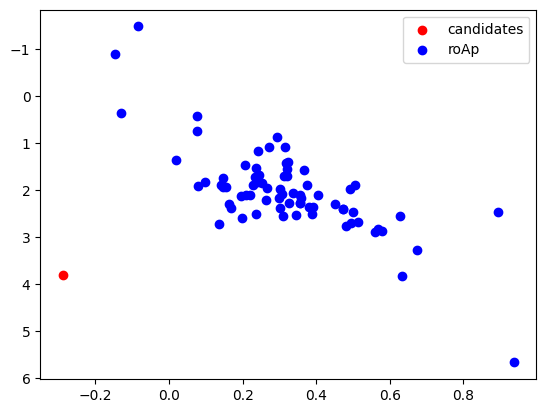

1.6568600194195047
1.2371225950657405
3.291226987401821
2.5758804438557807
1.4710704072507572
1.7133275577454676
1.1294296977219695
1.3820709276773573
2.5194889793720203
0.6393113388057792
2.157806270324722
1.7690378155513202
2.2679439043247362
1.2347262690363539
1.0193543059564854
1.0693382781856209
0.37426887148853494
4.863427794696804
0.20939956592554854
5.471001909154955
2.242030387348939
7.608984628323421
2.4106100216702706
1.6087260247166637
0.8911491344333133
2.3291764314941275
0.5134286762889051
1.9071913708934631
1.8411523600576252
0.9953841298587771
1.9146535232331705
1.2175128332870186
1.0320067690755725
1.075278953681273
1.3012493861407548
4.232633868857221
0.10764042827359344
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


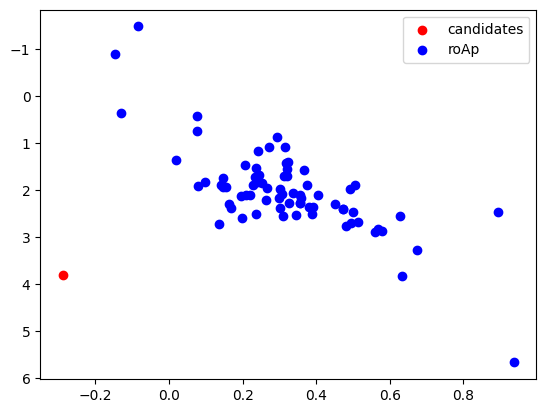

1.374671017572179
1.2741498088069778
2.134292537280231
0.7154323905525968
1.1677743720940827
1.5643749747124507
3.210654414803337
1.0055987721254573
1.2159429458161068
0.9417831922230913
1.4158281672866813
0.14738329610350798
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


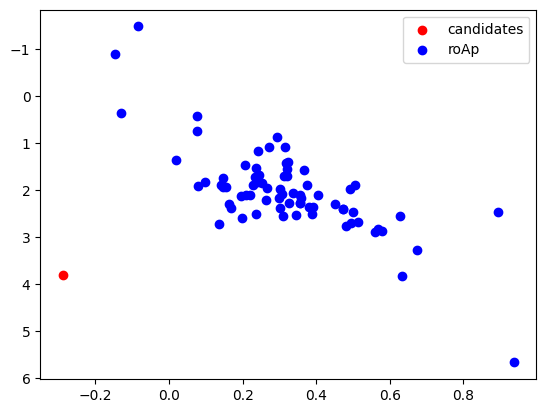

0.1720749726193369
ID: 94 --- Gmag: 3.812723 --- B-R:  [-0.28872368]


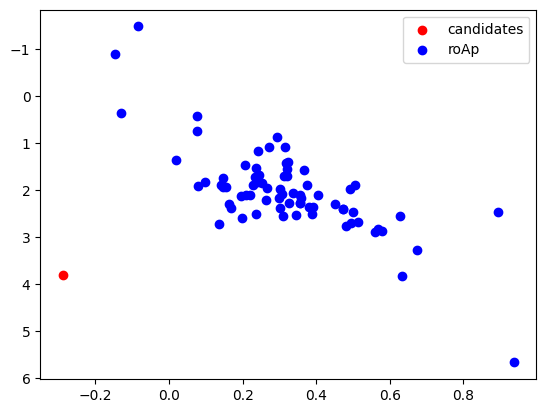

0.8266661794607137
0.4705126555807895
1.231781337684761
1.791479599001136
0.33538476441716636
1.8831866157765718
1.2594537256541707
7.850066092165907
0.9867497487687626
1.9860073293174474
1.4042499105813824
2.525038911950904
1.174600270480822
1.089241961627399
1.2665147613713548
1.6344816792870238
2.4323080140427447
0.24241024088542362
0.004414798043370416
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


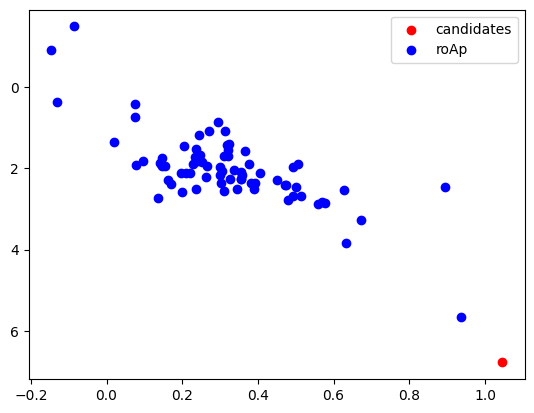

0.7738083485725589
0.49175263241074574
0.9007894228166495
0.2998287022389208
0.06593087317006208
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


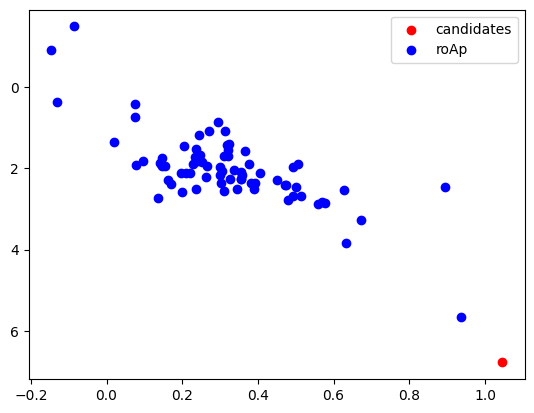

0.35661594003066965
0.2200514470816468
0.29560126068213255
0.5354985495792548
1.129674866593264
0.42254429800512194
0.012243487986418833
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


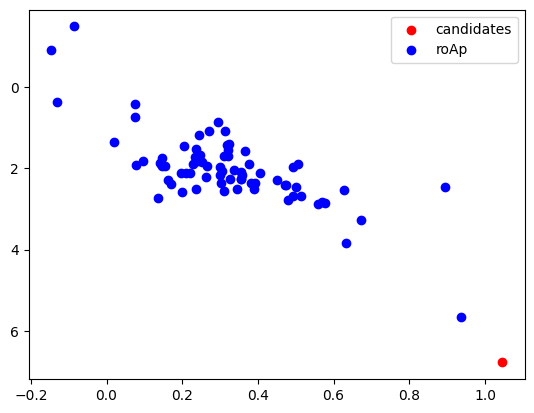

0.2572480980168814
0.5431889234455707
0.46259371802296
0.13287239640657833
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


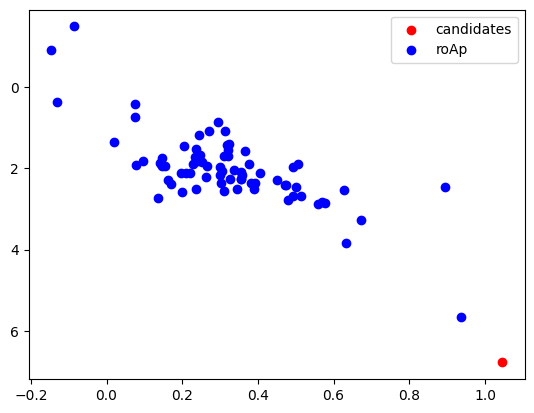

0.0421112722674577
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


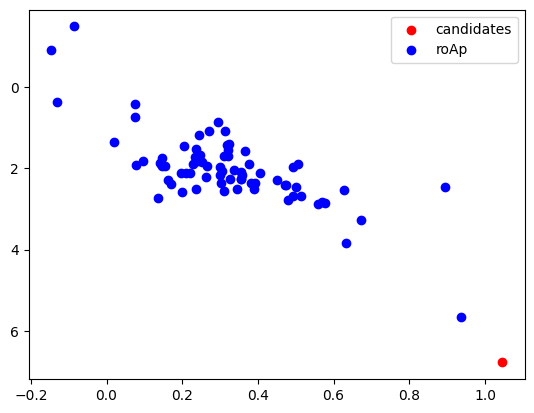

0.4917680365077206
0.8942297828776204
0.7053937591188439
1.159934966280374
0.11667055343000565
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


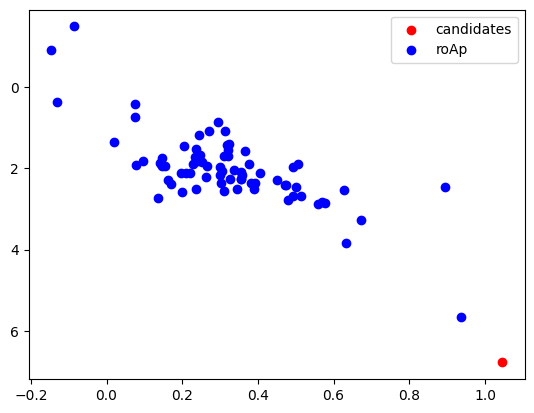

0.21263581995617908
0.3986674852592078
0.014831884033929432
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


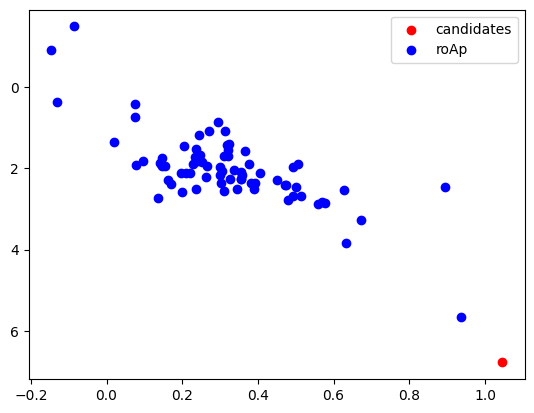

0.2789618366512363
0.9263329442871877
2.2873631393330465
0.31088015676983183
0.43416630635255316
0.2719199758562605
0.7402616695737556
0.22742180855886218
0.597763104009603
0.8546264322072437
0.9408492165402429
0.8252930502342408
0.42187346503296985
0.0953041774767831
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


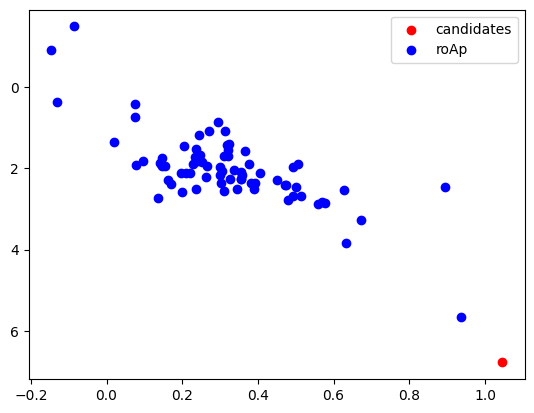

1.5215381435835507
0.3521275833407065
0.25278206122772984
0.5406696854364264
0.1767635454556562
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


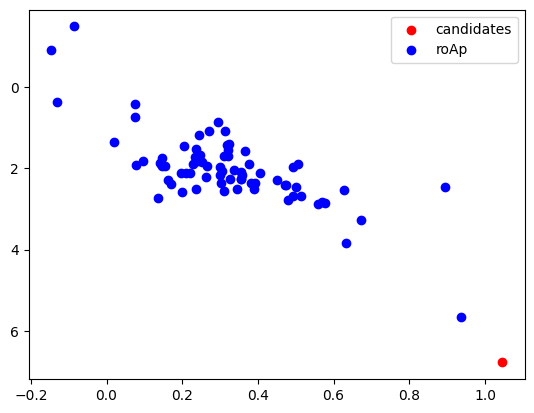

0.3863400649204414
0.973993206427221
0.7492918239717585
0.1330210861890655
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


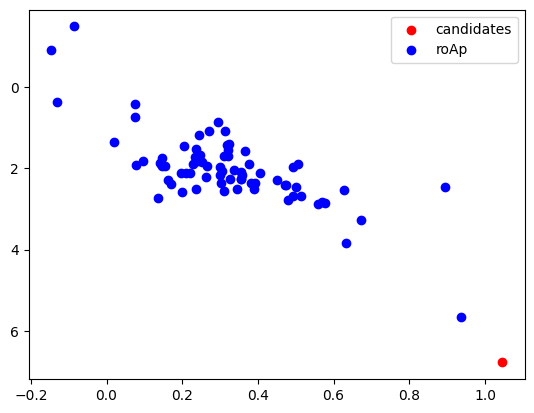

1.384214484701802
1.1918237377710061
0.5870385776716289
1.3601544031542188
0.8323229648341599
0.3061686089444804
0.2704588558341181
0.05744706727515192
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


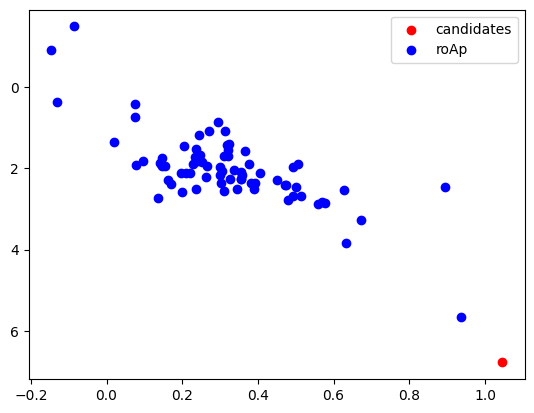

0.1042098474057267
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


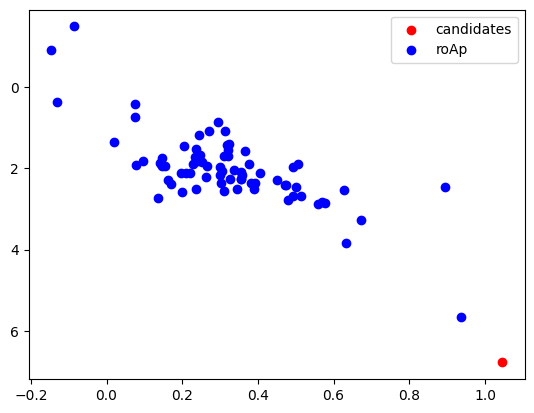

1.312700042639982
0.01078079547497457
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


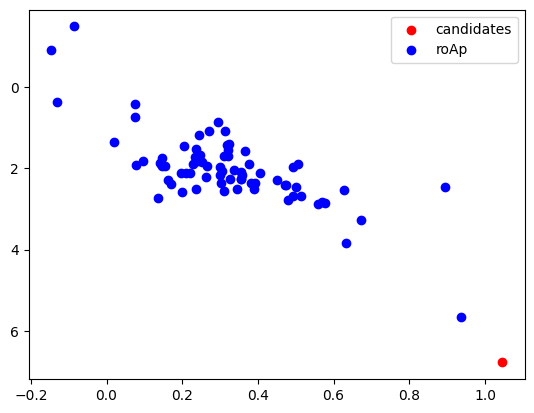

0.005253495720217272
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


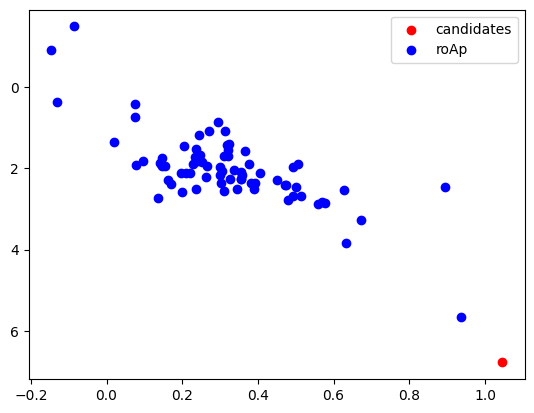

0.1269578116369705
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


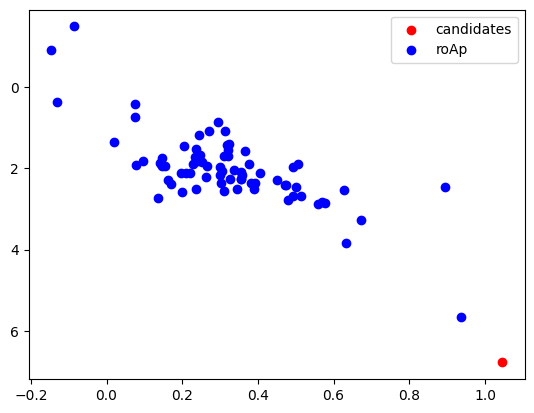

0.23228707655792102
0.04351329503367407
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


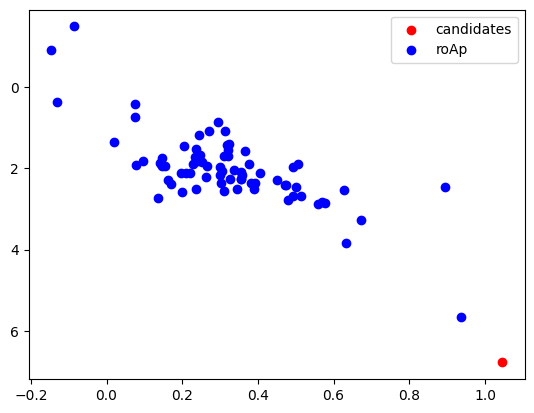

0.4823348800745777
0.31622953103745366
0.26300707720016536
1.261388236074216
0.09061526247555807
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


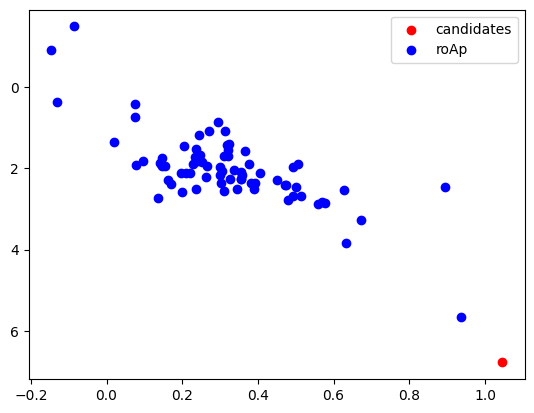

0.8333637933115703
0.2390611064158854
1.102373158458924
0.5098252003251227
0.30344378223285395
0.4707078413359258
0.03438443396934221
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


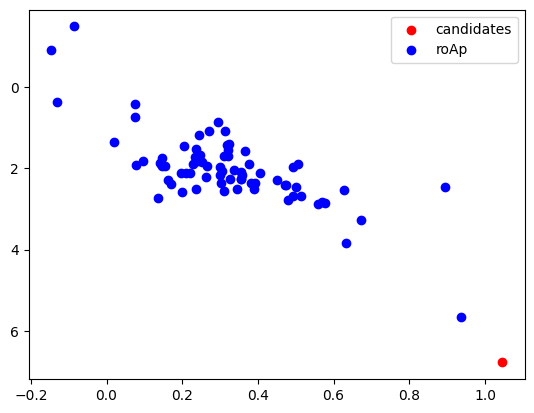

0.3217345108913994
0.42548005673376443
0.24798940916895562
0.5491607200584878
0.08211228165843987
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


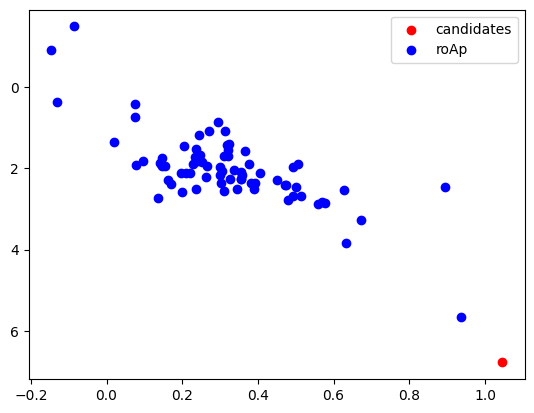

0.5433479869338129
0.7241736244371724
0.03270735153896309
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


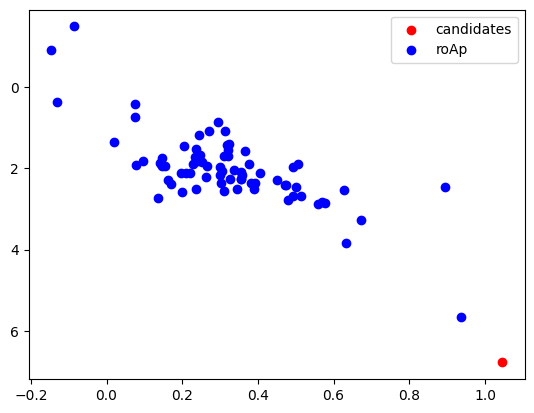

0.5507667590378842
0.6739268516622452
0.32021114863472744
0.11561400793230514
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


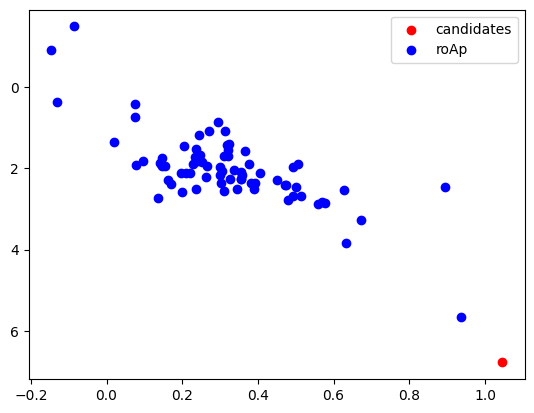

0.2966958431009341
0.3377342230674083
0.31604783472508546
7.513131244983029
1.5362637753643211
0.21929573905083943
2.264648181631684
1.2202718968529227
0.9617868126555951
3.0855886760570836
2.5986815069401956
2.0057792703214243
7.177417379342222
2.7886620962339315
0.8095042700752486
1.4346652736899095
2.7762032756222688
0.6286214207285796
2.5539984983518247
3.604754612169864
1.1629779199684849
1.321232259161749
6.148359600061563
2.7408081915864733
2.9577223789219067
1.600900450510628
3.6117119108294986
2.20013410554182
1.9530116870480512
1.615202332844748
2.6507333045164794
6.5680866507095725
1.4891341447070905
0.38790649448943504
0.6825854380656871
1.3634739889957934
1.9295117856112325
1.7866381941506002
5.370234847188649
2.208799607749098
0.3332908191023831
2.7778008263085274
0.2741399488878138
2.2726808877879128
4.00691552107287
2.5618410199025465
1.8301904688116843
1.4193156470745423
2.926165566015432
3.7412967852180747
0.9956223829262345
4.953951866851273
6.357168465300484
2.43659

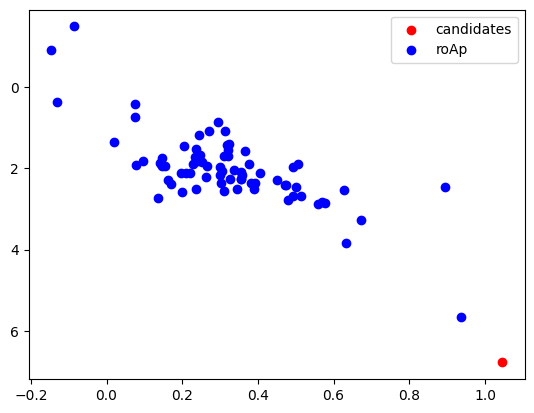

1.8340978979793723
5.269367848231616
3.7580399463065204
1.333580426912025
0.8138716001980708
1.7055331046566964
2.380774901754207
2.809841745483565
1.29511818387469
1.7422940599502243
3.525157167912342
1.2775105473066677
1.3080438212453236
1.8499834993920767
2.240954637687441
6.21679147902487
1.1362310486303755
1.021119379182533
1.247774476221839
1.202076416958788
1.7940830569807174
1.2059527250092106
0.9058241280097057
1.453929245276801
0.035252367350837366
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


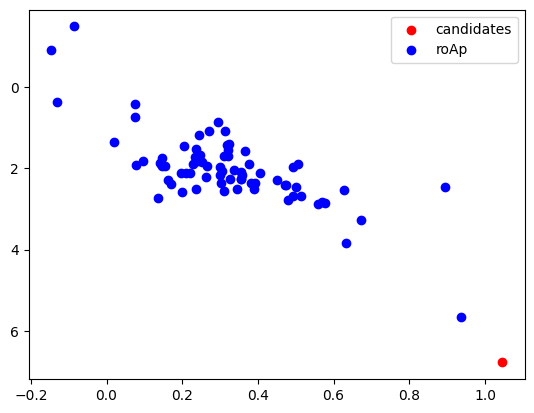

1.7001353197622187
2.5964891971239883
1.9435474094976433
4.493559889643968
1.705007503565114
1.3955840662091983
0.247821857387575
2.321440762737968
0.8798967794262358
7.274096859076183
2.3557569813752517
0.5172078209207098
0.07050221950606472
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


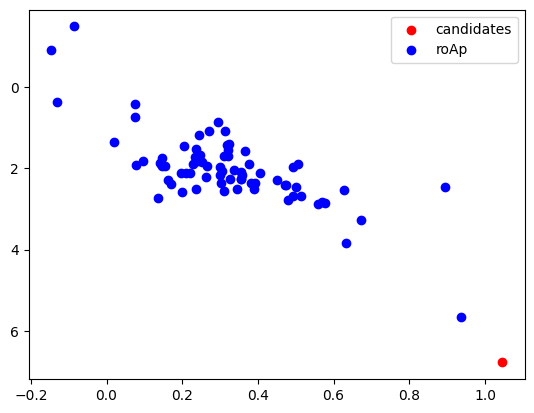

2.274848992290692
1.4127352597240035
0.3840025232236657
1.8608655167289914
5.18906499198276
1.3939035258769008
1.34022997230093
0.5106915612173162
2.4053260053741914
2.2170778249415264
1.589983854154531
2.2552184831004594
2.5998122408674815
0.17731523727328358
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


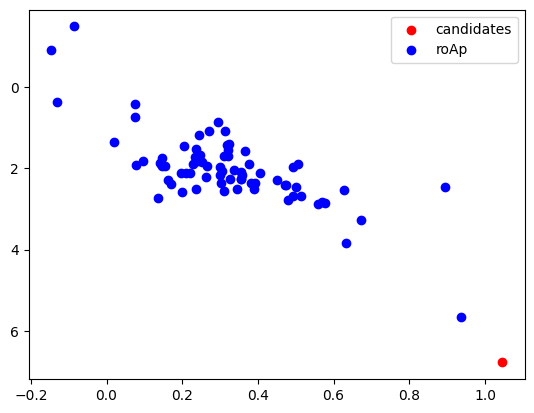

2.580970133314624
0.7265284556435396
0.9185007964422212
2.132310817316135
1.2303136440236873
1.4134890823421944
2.3286297408261296
1.7996537369711108
1.57895314703513
0.1324282124717331
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


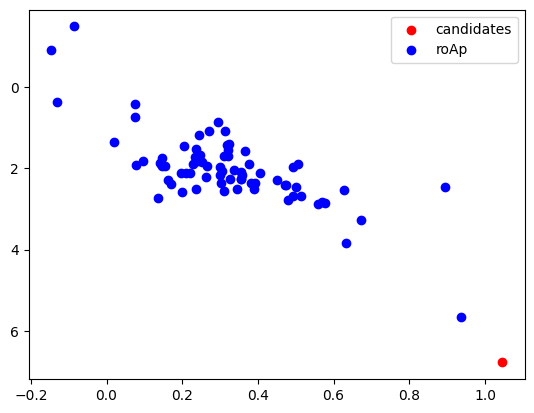

1.411825831519488
1.79838814486901
1.4497451839556497
2.0535432695190066
4.923961483513792
2.1611912141378395
2.454639144631175
1.8747178718137307
2.67173314286636
2.1619242893445207
1.6338819190074456
2.5052732024209527
3.7346299503195777
2.0542071866873224
2.755321005937609
1.7474670812200122
2.0373672043451645
2.8520212330830805
1.8899464718619574
3.0361856313502233
6.997281436809908
1.4415222931939142
2.414209355402323
1.8202420849927134
3.038834384219647
3.1565033285977355
1.0015008161873575
6.858754428060587
1.8066525304537648
3.2137592685610725
2.2578361148526183
2.535688907694386
5.235314430140124
2.48601268873598
2.3831470224701663
1.8922148555203673
1.4260412663056508
2.0632945529286344
1.8708484795671445
0.9217650558531034
5.34412077190159
1.7102738881866963
2.137840002483509
3.0369636592818425
1.3858535302110802
1.4415395827035054
0.025070731614037944
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


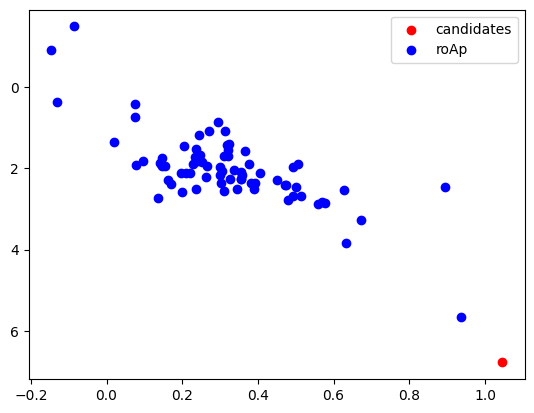

0.2833379679905119
0.44191546455148045
2.043339000958081
0.7224154377733703
1.3487986532544969
1.6353722747342363
1.820459932813567
2.1411630462270024
1.783484587601104
0.8442388948446478
0.7342622097454921
1.8528604737881087
2.3100020231922063
1.3647119178825482
1.5014373597324295
2.7430454541276177
0.27533103963701344
0.9619112971246542
2.0695671870084444
2.9138070245594
1.3956290189341354
0.6334590255122918
2.0019513728978584
0.5215682352396953
0.9941477442197338
0.6160519472555313
1.534546770600224
2.2019045513239934
2.287888740424629
1.3841107476442536
3.8905640373256576
1.2099569754306108
2.7258942606128125
1.1491117332760712
1.896115368884218
4.273647701345361
1.0094228694822
1.2650551845969236
2.950889564731331
2.0150775685797537
1.7846983111744306
2.3266172419096742
1.4894591874874112
1.7106369678881188
1.4749083362151738
3.23415397407525
0.859956944475972
1.3739479739063476
2.4443518864242106
0.5761270117067523
1.6532323381422944
1.335292088361587
2.5068811268129654
1.5641360

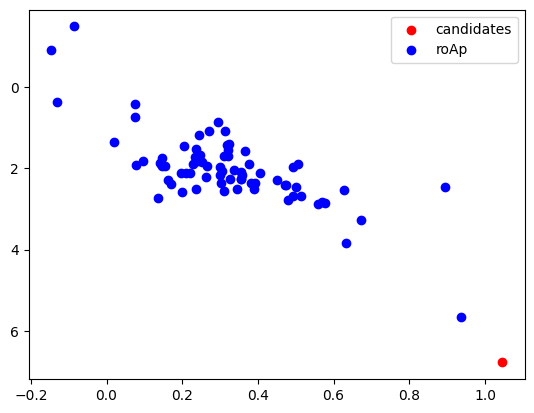

2.0798198661962264
0.32416887384188775
0.6601471125177893
1.2676520689375728
2.5795489356261996
1.0762399082496577
0.3430801394331118
3.6020263275563194
2.453615605663356
8.317791937177038
0.9458719755382419
0.2870275493373462
1.5370537494909973
1.824350072471663
1.3556280095431539
2.1417266842396865
2.3923104625536817
1.3969188163496644
2.972740046953116
1.5279905885631127
8.20206287577512
0.1058749836410493
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


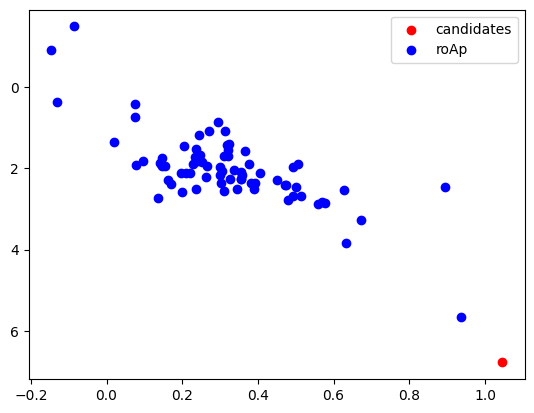

2.9202629274408807
1.228882072629508
1.3654795721084125
8.28717913149426
1.2315239096950952
1.4608692544268445
0.5297565469822476
1.7356756356785839
0.48918498377474484
1.4805723795573618
2.033231553650869
1.4154792613578377
1.755633073061753
0.39276138878273836
1.9250683816462073
1.5519884278761669
1.2130587134513326
8.698468901461599
2.9287589924541617
1.0824902224286557
0.6826945184377713
2.0678278623435355
2.5391848465337947
3.154601482542666
1.5352590983953955
2.6236613903980492
0.5419525670481187
2.7008728823319386
2.635207324903278
1.7838303777929354
2.102721550601178
1.2615454141498421
2.749359583030447
1.9613521464750086
1.1469125076560276
1.506551596669606
1.7450465498771972
1.9380424296436976
1.4586976920221477
1.7099730507198039
1.8178699642767542
3.3649525720371516
2.6538592478506287
0.16843188724515135
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


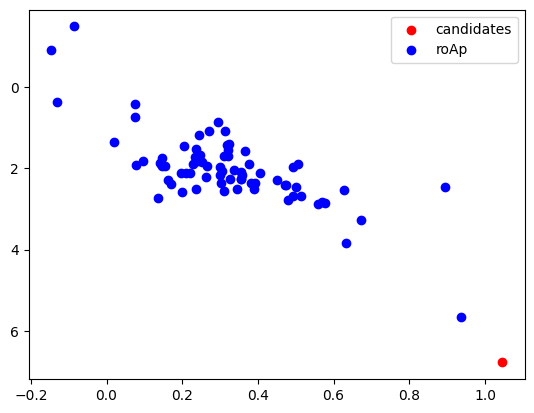

1.0482136132017745
0.03496724690423436
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


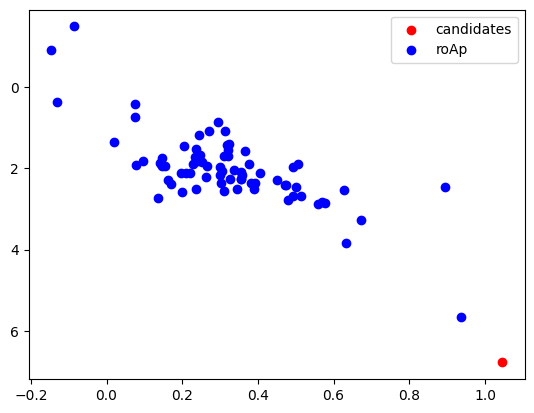

1.8160199867504605
1.5685967307897986
1.5626180183730447
1.3885887306284619
3.0116933120628504
1.7201185349481178
1.7964309723832474
1.4426841482384656
3.0911386086359673
1.6067373889487315
1.6240856828728798
1.7463501789003988
0.5035249030299667
1.5409023943260738
0.08827237746424732
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


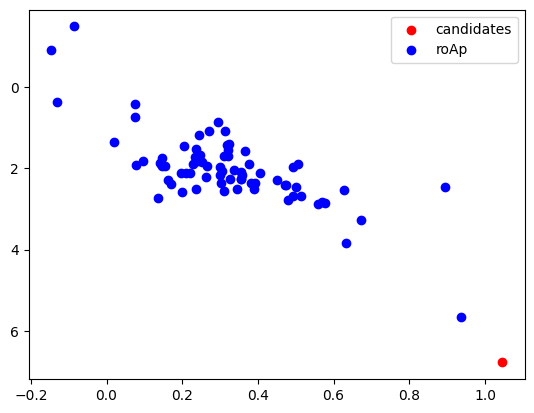

1.3679658035876752
0.9540810346923041
1.025054471565567
1.5530154247459051
1.3025042623721947
1.3134381482378836
1.618293697159715
1.2341000466242347
1.168647306625207
2.889995911949934
1.6282178756652577
1.4589328293525925
2.3220355218679165
2.7228997175515577
1.7582903142243154
3.016015689460736
2.371732488237833
1.593210076644312
3.002305108354646
1.636890293676373
0.6395226129877012
2.13056457684739
5.944772166719288
2.044127402595456
1.5185885532472347
1.6839281334711111
0.8301548603313813
2.686225209805988
1.3733843358936635
1.7492548165117776
1.1679469250250925
0.9975449763928139
1.572984808324131
0.8281216140034162
1.2584678814425476
3.0370016962029442
1.0604269227772372
3.3460274748382552
1.9391731635709843
0.5061720834100882
0.570501005285666
1.9303243925620348
0.0724094088756686
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


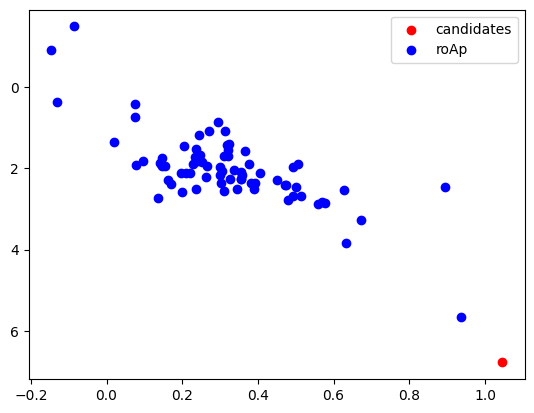

1.4949883726547852
4.8354357365032
2.2703640935026463
3.8788279182149212
5.871236424524558
2.0081271857239553
1.8902749725441967
1.6156345705845367
1.4798565938602717
1.6300229004666142
7.4461828059426765
1.5894893741802132
3.0656331240865304
0.48520493866677294
1.7216469275960093
1.282292825659687
1.8337832289048064
1.8696555034053286
2.2483891268118024
1.9653736864060007
1.534806113244097
2.232638383573911
1.533139404519473
2.7845471929511456
2.108707178821768
1.9911177661878001
1.7125284402374328
1.541797990922915
2.213049369206699
1.3511604002647004
2.3844783147087147
1.5383781259257086
2.698206839952923
1.927578818438899
1.0393648421928254
0.8698654059612252
0.4731179989729861
6.541274079235016
2.2589910540933333
1.2599651529731755
7.763262038145728
8.776911406478407
2.5227771019314256
2.675747766993516
1.8120848943674257
2.083218983781923
3.0595403009064723
6.03123354628465
1.8751881464746212
3.10302341752919
3.0781541869327222
0.8321761604642891
0.06716031376367781
ID: 95 --- Gm

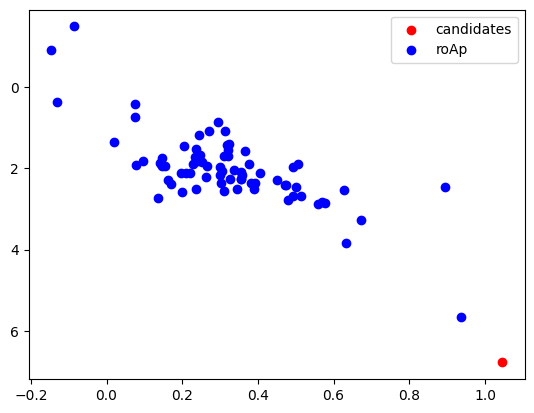

2.3990049606675248
0.45101508991116424
2.07129268006568
1.7997747635382513
2.923063827994709
2.3672683368612972
1.6719534191280123
1.8064588879463395
0.5962520008713021
4.32368700000519
4.4283749805819514
1.8917203755460494
1.364615096628835
3.1674372144634244
0.07975745045207216
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


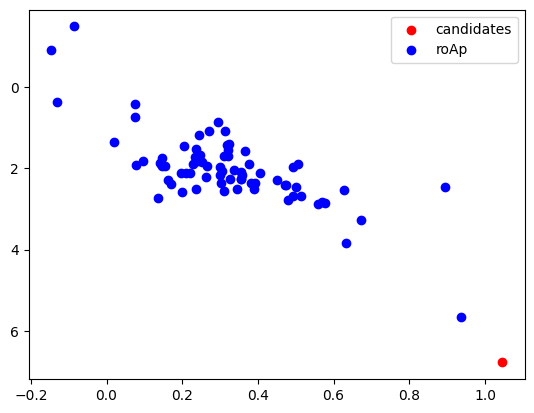

6.78746632211276
0.05953909793572798
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


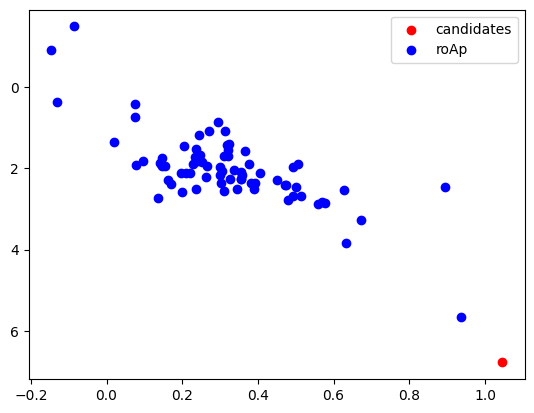

0.9805927686999683
1.1671101127608619
1.193078956167352
1.2600550584230505
2.7760511279378637
1.8132674968234876
1.0904864641530845
0.602289497620667
2.6180319260750444
1.556072210041689
0.6798779008636526
1.3779280190143195
1.433593324095235
1.0820457255704958
3.6158890563468145
1.1724007026958725
1.2952115472264845
0.8183426673784424
6.217033532159151
1.7067468282300229
3.033256788425417
1.8176348269463094
1.5841814947356105
1.9916433672793834
2.537514679907252
1.8131257228448365
2.0127607742944873
2.669637654303866
2.8831700135631957
1.190215813378993
0.07954306053313709
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


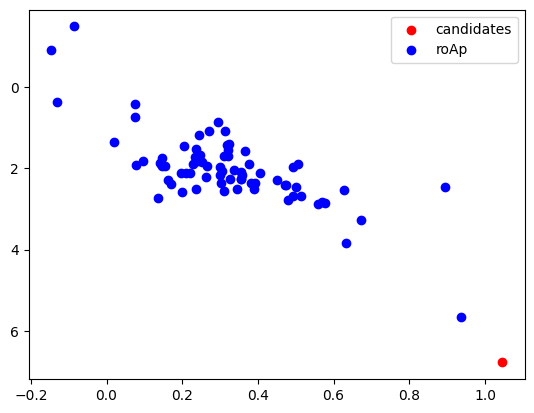

1.4744207720446922
1.284460930162466
1.3707597883376674
2.365245464239088
2.73035149618551
1.913546652454407
2.3166135316600105
1.3529619671641384
3.242359575327394
1.0181160349048255
0.539521661999548
0.14368179780320767
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


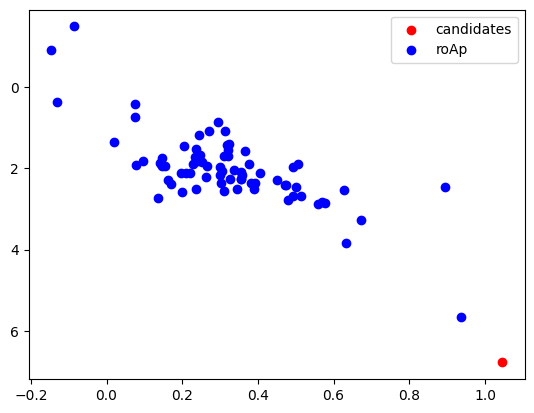

1.0476188540718254
0.2566168744551329
1.7997747635382513
1.6685819647576616
1.265345648358062
8.089535831549556
2.5023201541827182
1.0585354504279227
4.631350365284687
1.701539227941052
1.4975541358781699
1.2474198848135554
1.8043737730896001
7.071245958842507
1.9365831950341714
1.4270544315677147
1.5240693277877522
4.160494776872582
5.541093238874144
0.032636621011295164
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


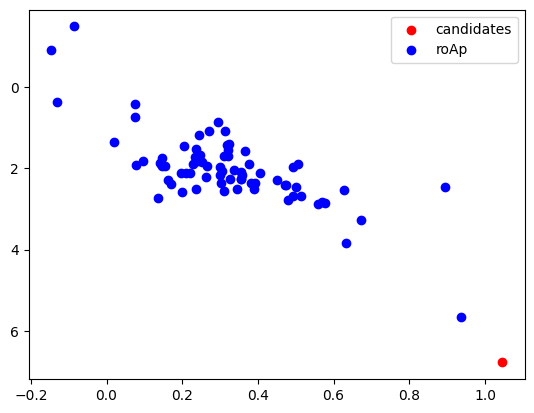

1.0429664035024002
2.080556399304826
0.6565942747583857
2.124776049036143
2.9783383901588563
1.71065425739771
3.036358526446139
2.2831064620716095
2.0031893017846123
2.3244180162896306
2.1679306649766215
1.2894610563363391
1.6402479164390502
1.6605942113263719
0.9212429126634392
2.569033455892626
2.8414919217418344
0.46792423029168817
0.8495121952700668
1.086292029126178
3.311320513284202
2.1130917984541817
1.9586722724883205
2.56062729632922
0.0286166535696053
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


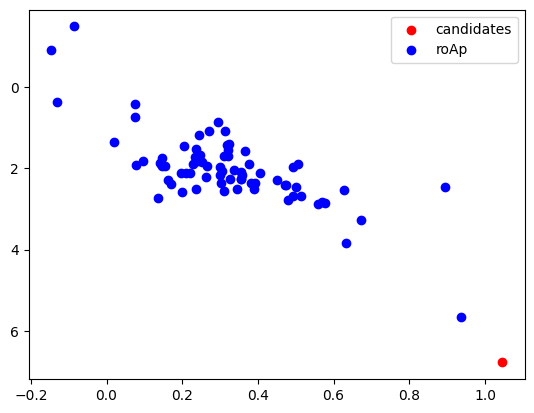

2.5325906275755825
0.36395203541201626
2.8219893549225796
2.3284360983187034
1.6730080792130957
0.8377657024535761
1.1389904543611846
2.9870765083064192
1.282704315987966
2.3343249052855812
2.1485041719995692
3.0563555732397116
0.6691134521919613
2.613180489683659
1.294786225290532
2.8855455921810726
1.9404352977711665
0.4590389948509397
1.3043715294080813
1.430851207874017
2.707788686168554
1.8443229139518074
0.5348657535282044
3.5452268306461994
1.8642508027070137
2.6298095400088
0.7408875498209693
2.542047989322154
2.7403863275524394
0.9556282893390893
2.8400050239169623
0.9017887564710405
0.9018805473335331
1.3431657310295735
0.7623938143402256
1.109950994051238
1.1109522131182452
1.585754840108441
7.1053581612666115
1.3068681345930988
2.6478390406108554
0.08248039175108235
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


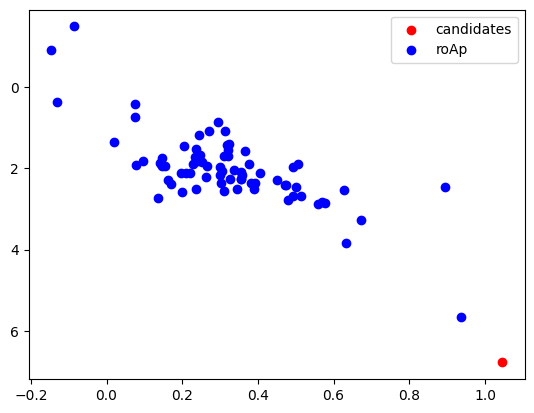

1.8226487847278559
2.33436985801052
1.7136591741647196
4.297604045835396
1.636378524192463
1.4121889112209105
1.2753977692345815
0.5051397432258165
7.775108810117848
3.112235268239562
5.773204905140539
6.128825912125044
1.8028142593244432
1.4008919456538
2.130485045103269
5.216527649017959
4.79077347532634
1.7210279631526333
6.146499248829515
1.515504104736104
1.9259190255181113
1.6416794878332286
2.216012791150688
2.384620088687365
0.8124280826088346
0.2280357426110191
0.9633620434410416
2.318052018858026
0.05451822435034548
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


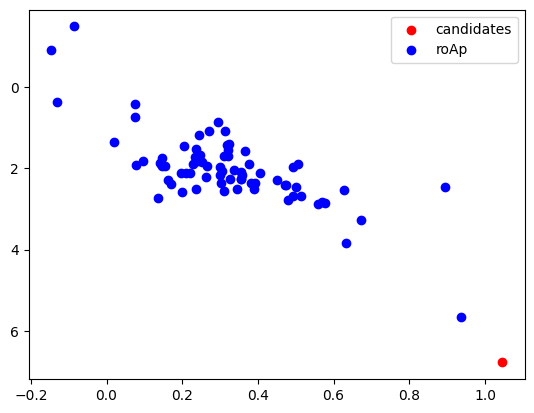

3.1326922159882695
1.3405792203946791
0.717513705342512
0.9652205092604744
1.4797874358219054
4.0836359909343605
1.4746697409828105
1.6529799113022585
0.41097950150099916
2.3634577289473233
2.8052946044609905
1.6634953910358312
1.3520006704308496
1.848932297208911
2.154534752945098
0.27207023812804954
2.1768935467488744
0.7319281259506344
1.8374486049382124
1.35257122424737
1.894932766428157
1.9814598461299677
2.7811964859923055
2.6164551228002955
3.044747396499953
1.595208743953094
1.0344269582534824
4.595042395142459
0.4913530882775239
2.2381986898585495
1.6523194520358613
2.224294466245035
1.9949664110228766
2.3228446709168002
1.9133460941431453
1.7158583997847632
1.770292691782761
2.099782333970616
2.6061021644568836
5.723839897354781
2.0786787585631847
0.4067589757480474
1.618428555334529
3.1886237795168944
2.3478729650015104
1.670414652774365
1.4723114518745246
1.4388251296976342
1.8521550617967744
1.6317933462487877
2.7308598077675024
1.3973130171683514
1.7327952033806333
2.0883

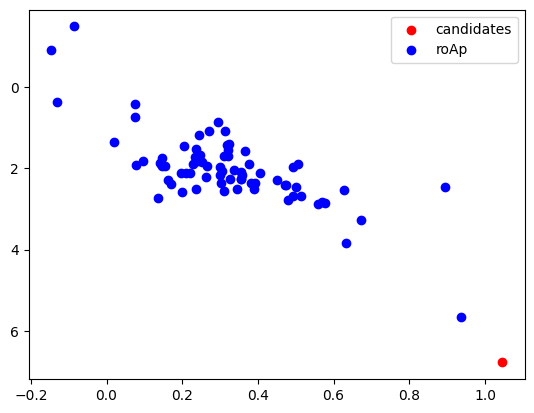

1.2794469723809196
1.4856001689465808
1.143893759281345
3.093123444337076
1.2431078811214256
2.398455154262513
2.5003664395988743
1.8574836886528858
2.810443420417351
1.5963187304688702
1.6222357053465861
1.621914120468183
2.363315954968672
1.0376635544490183
2.8679621609264787
1.0819246990033553
1.812323489599789
8.528668627763107
0.8167347429864293
1.2828825543984157
1.405300770599642
2.4391131650179743
1.2050951653334703
2.063353337261246
1.6164886723583585
3.9436566633793513
4.4419334140036355
0.3787015595829002
1.407040095264551
0.5126814273096449
0.48857136264590273
0.7534309325679727
3.2231059774462576
2.448380342159038
1.920365635037309
4.760060390487932
0.8231199153402415
1.8217773934444421
6.826893319785302
1.8359098385845651
6.70570077335246
0.7361310492706801
1.9164651216734583
1.5241799806491378
3.151561986756474
1.5965054571724593
1.5528529033557443
1.1222784143900044
2.534260794202125
2.1930315750016156
0.5988903800349712
1.6163468983797082
1.6102471593958139
2.782047129

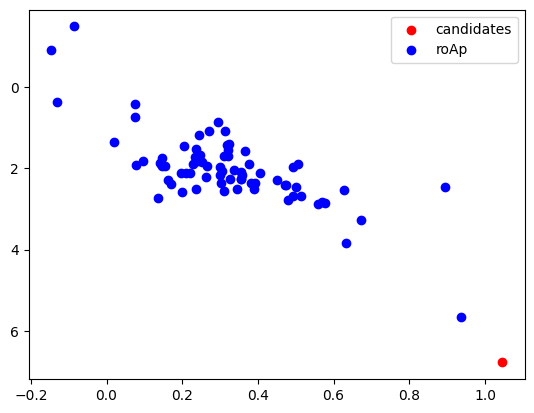

2.1944389410823675
1.5265728487766068
5.854942790685493
0.6936802728322344
2.7244868945320615
2.4613543901565285
1.144077028083015
2.700679239824513
1.5152378462883946
1.5093490393215168
1.5104382784257842
2.1144127169869753
1.6088709144323274
1.8917030860364583
3.5166368975856317
1.5066000072964625
1.3609739259088574
2.8726268706142752
2.3397883903165075
3.7216109495971494
2.088820784889581
3.323077379806448
0.6662418211104639
0.14372329262622752
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


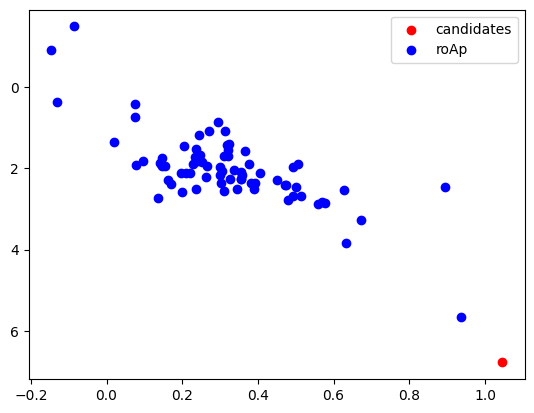

1.9965328405918699
1.8449315046894295
0.07362470493829654
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


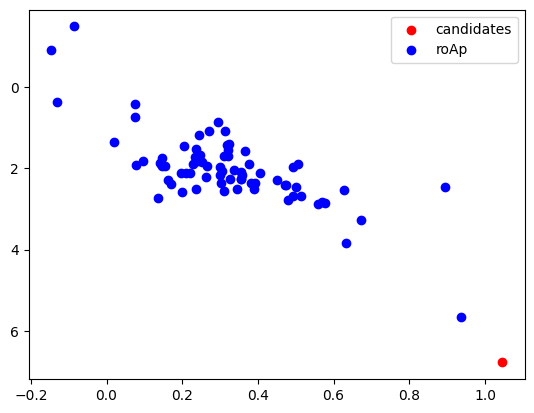

2.6963499466227923
1.8188935032445739
1.0970564777978689
3.024276617143572
1.4217500100250315
1.506219638085449
1.3431553573238186
2.839935865878596
1.1381901065287539
1.7671079641159995
2.0236185863179736
1.3126566624043459
2.039334750536681
11.537181612767423
2.975955895737142
1.3595043175935764
1.9371883278698758
5.864732111016223
1.9778532544291723
1.2419875208998945
8.335551721429464
1.5980788025452888
1.5894617109648663
0.570618573950888
3.0663419939797842
2.0163327869760996
1.4816270396424451
1.8582859218979333
2.1130468457292437
1.7043401284948805
2.183314870611172
3.5195069561778274
0.7350921062058858
3.083749072236544
1.530756910097759
2.481171626050349
0.9654487307870829
2.15107685102679
1.7326672610096565
3.189782176659527
0.12065908683111615
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


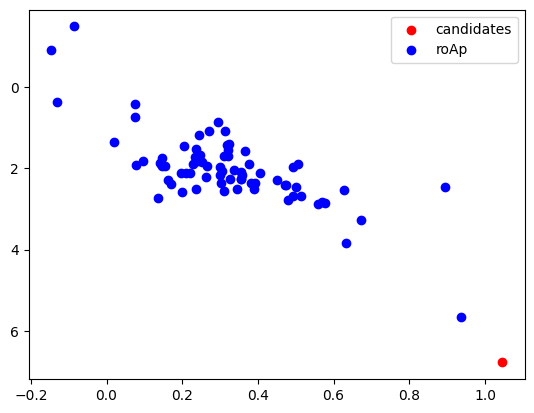

2.4966976056635497
0.8849384004231278
1.6678627211586539
7.176248608493834
1.9331702458408022
0.28869425806197047
2.7820471298642087
1.6008209187665068
1.1210128222879037
1.76150962091026
2.997159750300204
5.8778652225019545
3.1153785010833035
1.6266203249789999
1.8016074515549538
1.5501903188786474
1.1938396945893792
1.1152796209073494
1.5319913810825943
1.6043133997039971
1.432732306517576
1.0857026133107635
1.5439695533276125
1.3697846599967052
1.4719172510558376
1.8160718552792348
1.6867566972402865
1.164722587947928
0.6344825644801106
1.7336907999774753
1.6133592711222906
1.7109931317857041
0.8872586526103123
1.395514908170832
0.9926193515718419
1.7530273875046507
2.4286979644400315
0.9521773032246184
1.7149628031879212
2.1821633892723753
1.342560598193869
1.4769761615623211
2.1308377510989365
1.7757838400290333
1.7271952876855916
1.2471467105620089
1.137915046864591
2.280699762336468
0.09814814534293381
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


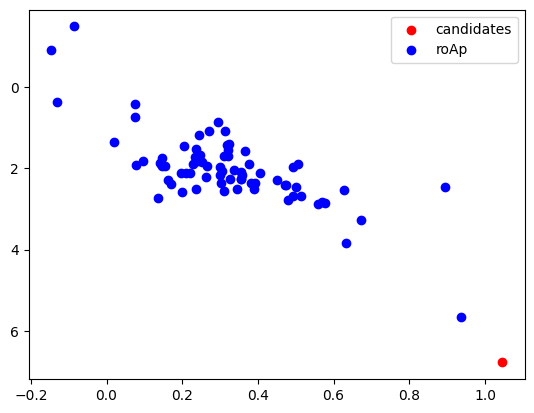

1.22861235627988
1.841573881926753
2.446122332206383
1.6037290142798033
1.3785020307327585
1.4213281459909977
0.07369920629119742
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


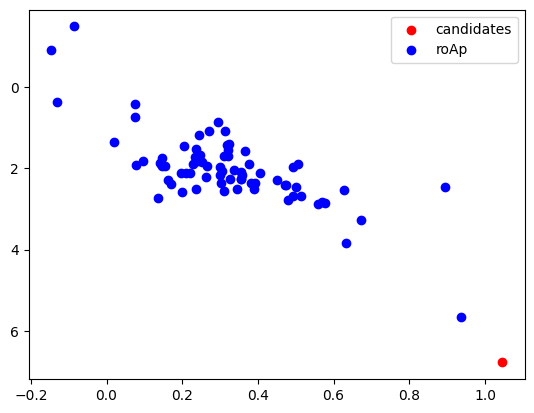

0.9005700025064944
1.0500186380031316
1.525092866755571
1.3847573753029774
1.5785105355895863
1.4470480204593696
1.4918831767321457
2.4273632142995654
1.6842185972322488
1.9224300024825387
1.8839885068567142
1.76569714013333
1.9095009072099873
2.5166220365168384
1.1424587299852476
1.3753657136928534
1.6081240076179728
3.568135430854986
2.0202782530648884
1.7137940323395335
5.009240260623093
1.9343632220026181
0.4503285399187227
1.1421890136356196
2.3458570081831374
1.246769799252913
0.2040724823171478
2.79810216847091
2.7764107497373676
1.7506345193771826
3.0658924667304044
0.49972121091982813
1.301380444248745
0.6408105249906135
0.39215625594703485
2.237227019419505
1.8174895950657406
3.8715939874018215
3.156247443855781
2.0514374072507575
2.293694557745468
1.7097966977219696
1.9624379276773574
3.0998559793720206
0.058944338805779095
ID: 95 --- Gmag: 6.775063 --- B-R:  [1.04512445]


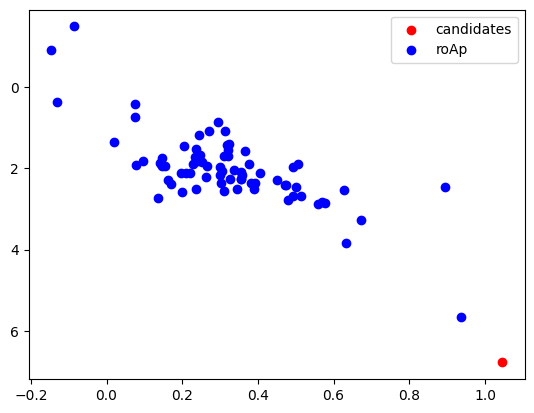

2.7381732703247224
2.3494048155513205
2.8483109043247365
1.815093269036354
1.5997213059564854
1.649705278185621
0.954635871488535
5.443794794696805
0.7897665659255486
6.051368909154955
2.822397387348939
8.189351628323422
2.990977021670271
2.189093024716664
1.4715161344333134
2.9095434314941278
1.0937956762889052
2.4875583708934634
2.4215193600576255
1.5757511298587772
2.495020523233171
1.7978798332870187
1.6123737690755726
1.655645953681273
1.8816163861407549
4.813000868857221
0.6880074282735935
1.955038017572179
1.854516808806978
2.714659537280231
1.2957993905525969
1.7481413720940828
2.144741974712451
3.791021414803337
1.5859657721254574
1.796309945816107
1.5221501922230913
0.8354611672866813
0.4329837038964921
0.752441972619337
1.4070331794607138
1.0508796555807896
0.651414337684761
2.3718465990011364
0.9157517644171664
2.463553615776572
1.8398207256541708
8.430433092165908
1.5671167487687627
2.5663743293174477
1.9846169105813825
3.1054059119509043
1.7549672704808221
1.6696089616273

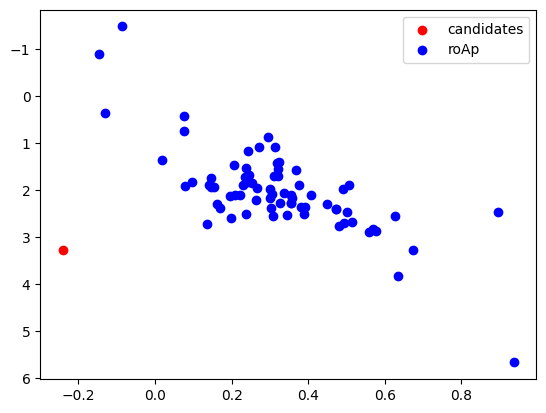

1.1349076324107457
0.2576344228166496
0.9429837022389207
0.5772241268299378
0.28653905996933027
0.8632064470816467
0.34755373931786737
1.1786535495792547
0.4865198665932642
0.22061070199487798
0.6309115120135811
0.9004030980168813
1.1863439234455706
0.1805612819770399
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


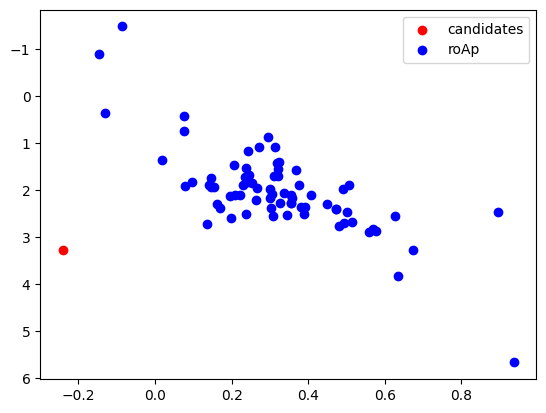

0.5102826035934216
0.6852662722674576
0.15138696349227931
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


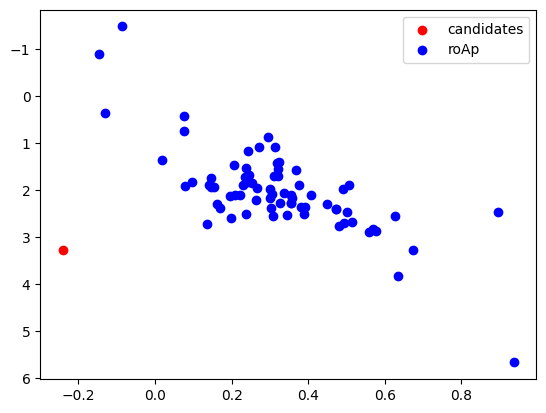

0.25107478287762053
0.06223875911884402
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


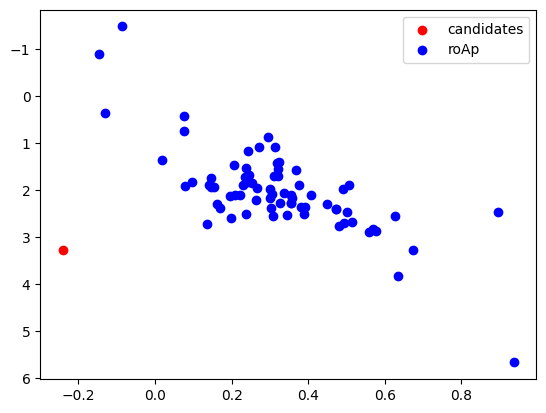

0.516779966280374
0.7598255534300056
0.43051918004382084
0.2444875147407921
0.6579868840339294
0.3641931633487636
0.2831779442871878
1.6442081393330463
0.9540351567698317
0.20898869364744677
0.9150749758562604
1.3834166695737555
0.41573319144113774
0.04539189599039695
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


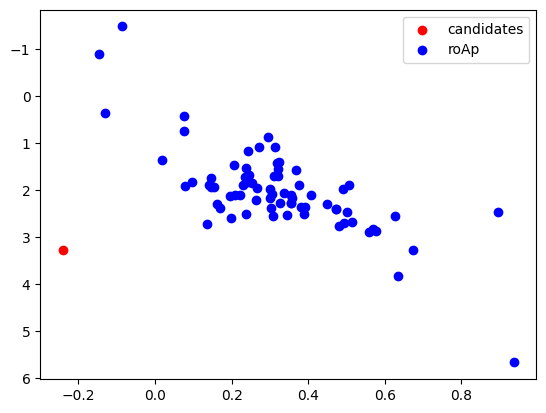

0.21147143220724374
0.297694216540243
0.1821380502342409
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


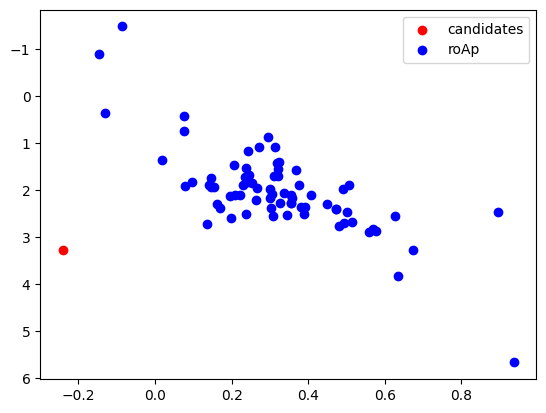

0.22128153496703007
0.738459177476783
0.8783831435835507
0.29102741665929344
0.3903729387722701
0.10248531456357357
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


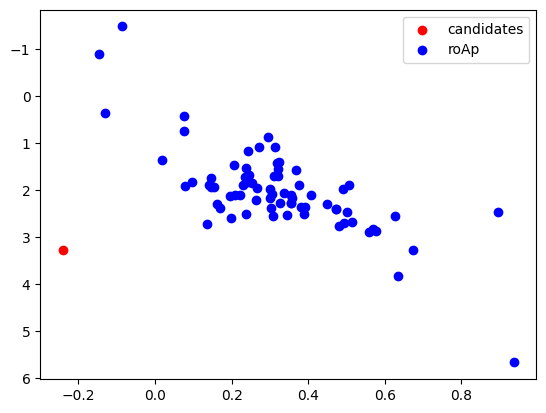

0.4663914545443437
0.25681493507955855
0.33083820642722106
0.10613682397175861
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


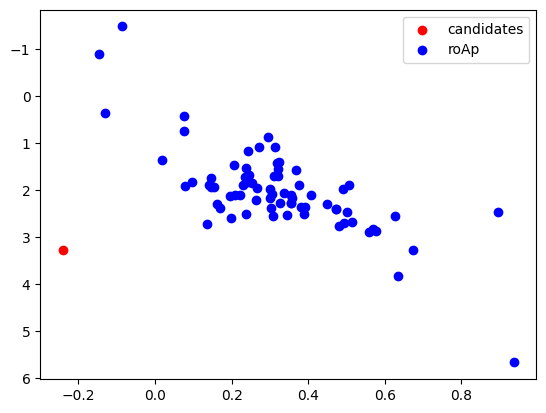

0.5101339138109344
0.7410594847018022
0.5486687377710062
1.2301935776716288
0.7169994031542188
0.18916796483415999
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


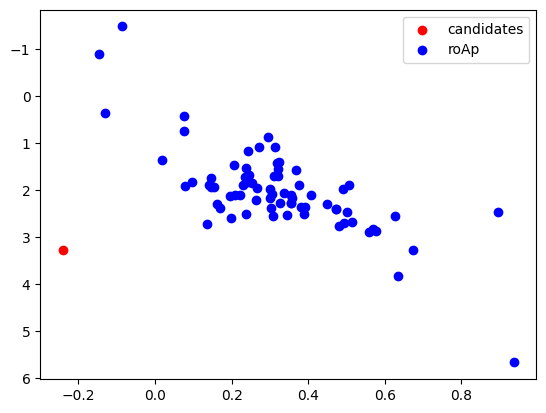

0.33698639105551953
0.3726961441658818
0.7006020672751518
0.5389451525942732
1.9558550426399819
0.6323742045250254
0.6484084957202172
0.7701128116369704
0.4108679234420789
0.5996417049663259
0.16082011992542222
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


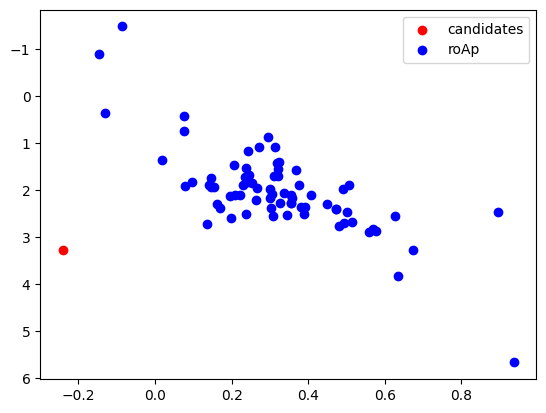

0.9593845310374536
0.38014792279983456
1.9045432360742158
0.733770262475558
0.19020879331157037
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


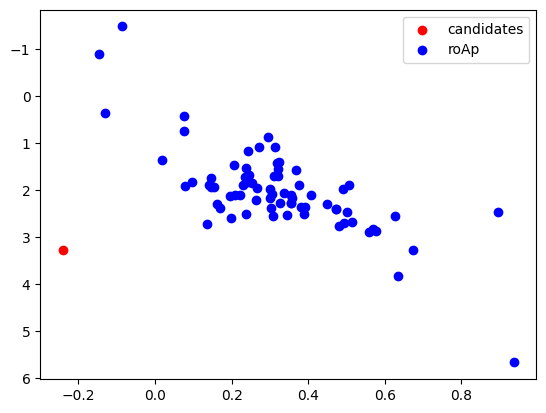

0.4040938935841145
1.745528158458924
0.13332979967487724
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


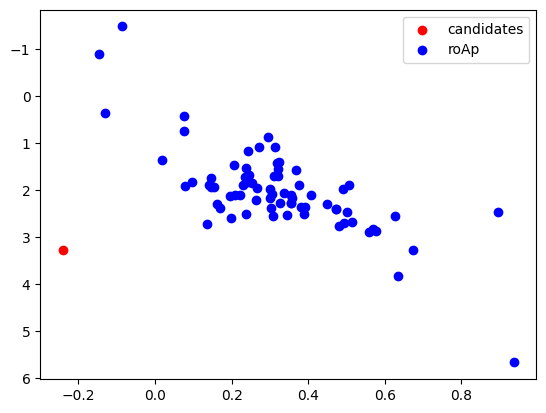

0.33971121776714597
1.1138628413359257
0.6087705660306577
0.9648895108913993
0.2176749432662355
0.3951655908310443
1.1923157200584877
0.7252672816584398
1.1865029869338128
0.08101862443717245
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


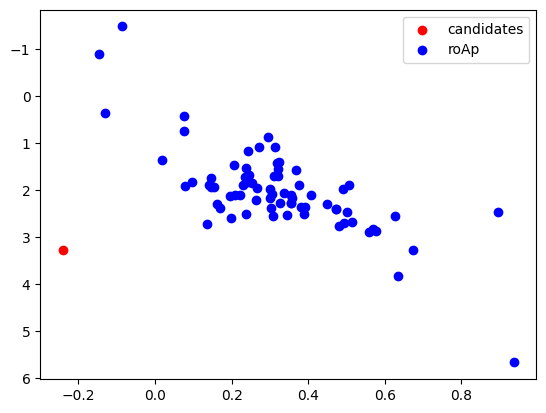

0.6104476484610368
0.09238824096211573
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


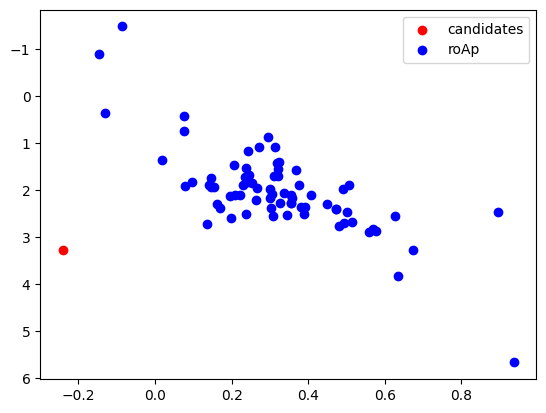

0.030771851662245275
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


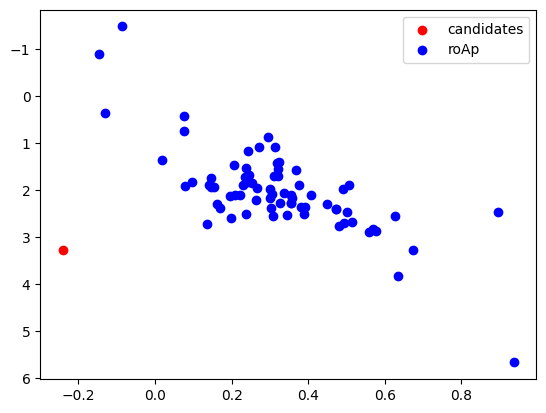

0.3229438513652725
0.5275409920676948
0.939850843100934
0.9808892230674082
0.32710716527491446
6.869976244983029
2.179418775364321
0.4238592609491605
1.621493181631684
0.5771168968529228
0.31863181265559515
2.4424336760570835
1.9555265069401955
1.3626242703214242
6.534262379342222
2.1455070962339313
0.1663492700752487
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


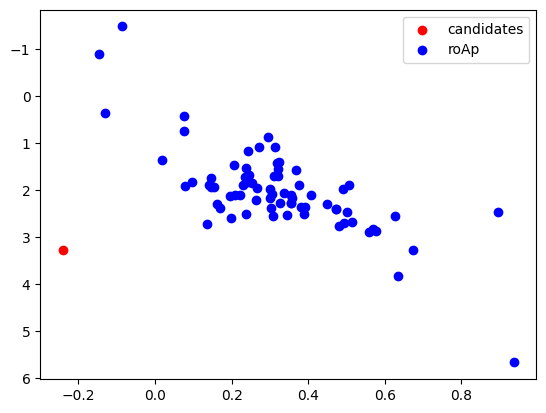

0.7915102736899096
2.1330482756222686
0.014533579271420294
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


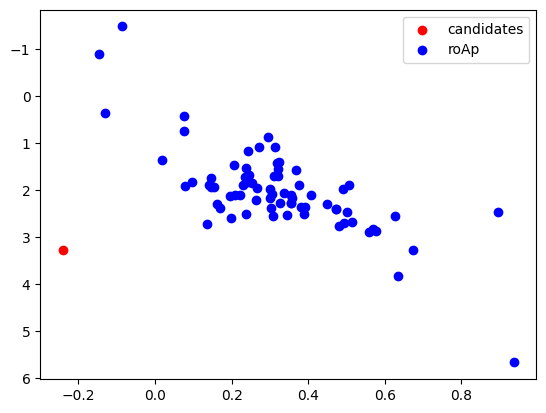

1.9108434983518245
2.961599612169864
0.519822919968485
0.678077259161749
5.505204600061563
2.097653191586473
2.3145673789219066
0.957745450510628
2.9685569108294985
1.5569791055418198
1.3098566870480512
0.9720473328447481
2.0075783045164792
5.924931650709572
0.8459791447070906
0.2552485055105649
0.039430438065687134
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


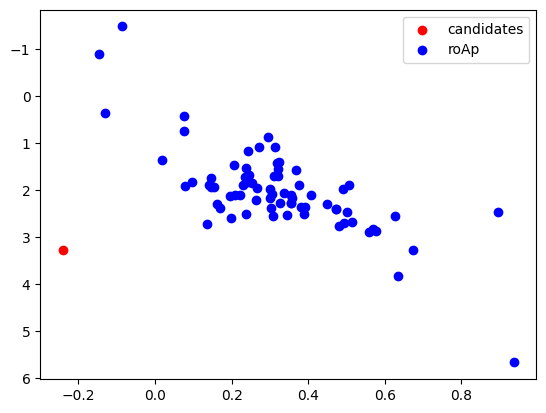

0.7203189889957935
1.2863567856112326
1.1434831941506003
4.727079847188649
1.565644607749098
0.976445819102383
2.1346458263085273
0.9172949488878137
1.6295258877879126
3.3637605210728703
1.9186860199025464
1.1870354688116844
0.7761606470745424
2.283010566015432
3.0981417852180746
0.3524673829262346
4.310796866851273
5.714013465300484
1.793440812421446
2.35542249008671
0.5996382120468597
1.5288801945536523
0.7838510559584064
1.1909428979793724
4.626212848231616
3.1148849463065202
0.6904254269120251
0.1707166001980709
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


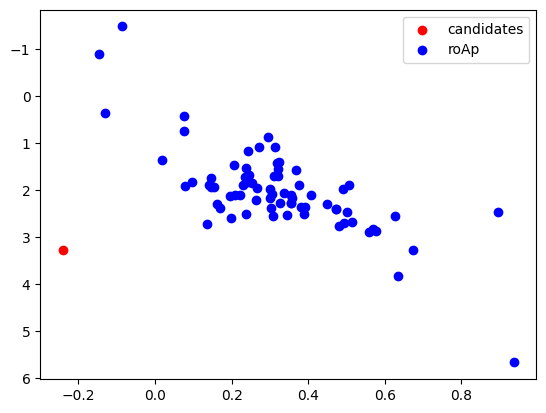

1.0623781046566965
1.7376199017542069
2.166686745483565
0.65196318387469
1.0991390599502244
2.8820021679123418
0.6343555473066678
0.6648888212453237
1.2068284993920768
1.5977996376874408
5.57363647902487
0.4930760486303756
1.6642743791825327
1.890929476221839
0.5589214169587882
1.1509280569807174
0.5627977250092107
0.26266912800970577
0.810774245276801
0.6079026326491626
1.0569803197622187
1.9533341971239881
1.3003924094976433
3.8504048896439675
1.061852503565114
0.7524290662091984
0.8909768573875749
1.6782857627379677
0.23674177942623587
6.630941859076183
1.7126019813752515
0.1259471790792901
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


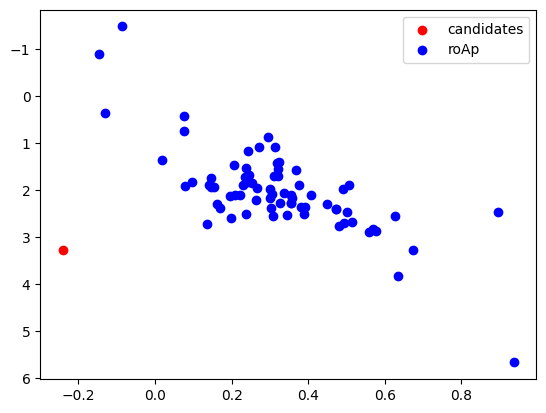

0.5726527804939352
1.6316939922906917
0.7695802597240036
0.25915247677633424
1.2177105167289914
4.54590999198276
0.7507485258769009
0.6970749723009302
1.153846561217316
1.7621710053741912
1.5739228249415262
0.9468288541545311
1.6120634831004592
1.9566572408674814
0.8204702372732835
1.9378151333146238
0.0833734556435397
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


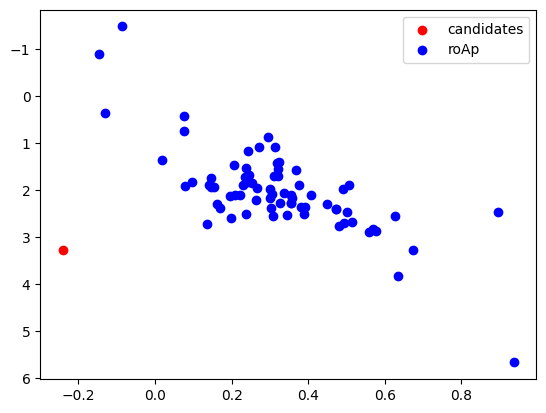

0.27534579644222124
1.489155817316135
0.5871586440236873
0.7703340823421945
1.6854747408261295
1.1564987369711108
0.93579814703513
0.775583212471733
0.7686708315194881
1.15523314486901
0.8065901839556497
1.4103882695190064
4.280806483513792
1.5180362141378394
1.8114841446311747
1.2315628718137308
2.02857814286636
1.5187692893445206
0.9907269190074457
1.8621182024209526
3.0914749503195775
1.4110521866873222
2.112166005937609
1.1043120812200122
1.3942122043451644
2.2088662330830804
1.2467914718619575
2.393030631350223
6.354126436809908
0.7983672931939143
1.771054355402323
1.1770870849927135
2.3956793842196467
2.5133483285977354
0.3583458161873576
6.215599428060587
1.163497530453765
2.5706042685610724
1.6146811148526181
1.8925339076943857
4.592159430140124
1.8428576887359798
1.7399920224701662
1.2490598555203674
0.7828862663056508
1.4201395529286343
1.2276934795671446
0.2786100558531035
4.70096577190159
1.0671188881866964
1.494685002483509
2.3938086592818424
0.7426985302110802
0.798384582

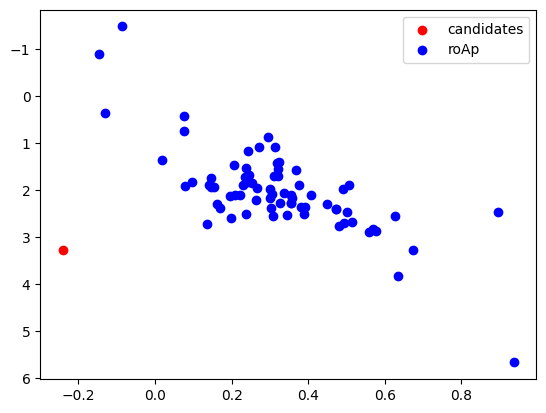

1.3587963728978583
0.12158676476030461
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


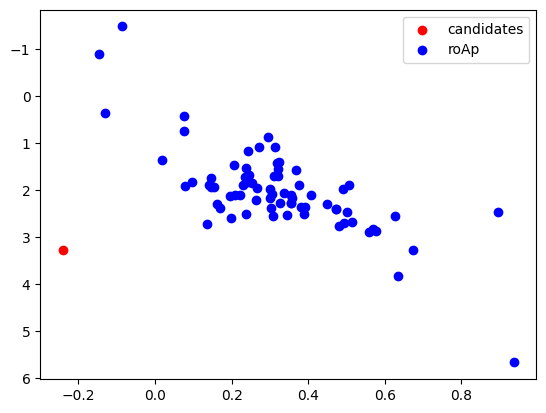

1.6373027442197339
0.02710305274446867
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


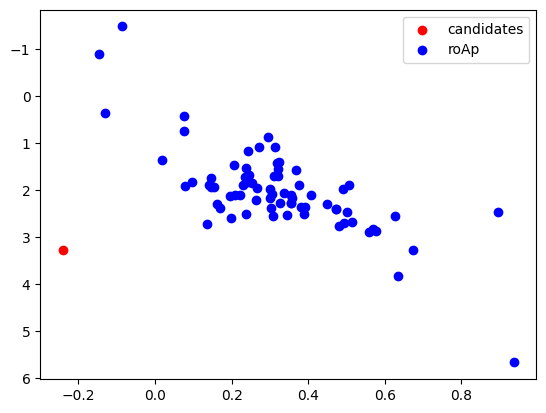

0.8913917706002241
1.5587495513239933
1.6447337404246287
0.7409557476442536
3.2474090373256574
0.5668019754306108
2.0827392606128123
0.5059567332760713
1.2529603688842181
3.6304927013453607
0.36626786948220014
0.6219001845969236
2.307734564731331
1.3719225685797536
1.1415433111744306
1.683462241909674
0.8463041874874113
1.0674819678881189
0.8317533362151739
2.5909989740752497
1.503111944475972
0.7307929739063477
1.8011968864242105
0.06702798829324763
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


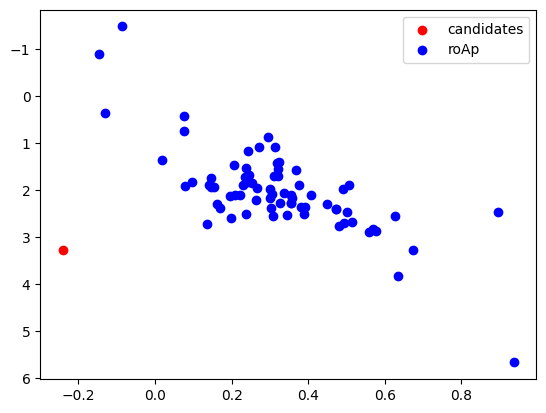

1.0100773381422945
0.6921370883615872
1.8637261268129652
0.9209810373151823
0.6453413017011309
0.6154581133231165
1.0627550159657924
1.2114379176667287
0.7123485250740949
0.6398328639452666
0.996612268072405
1.248247248569565
0.11002696362985454
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


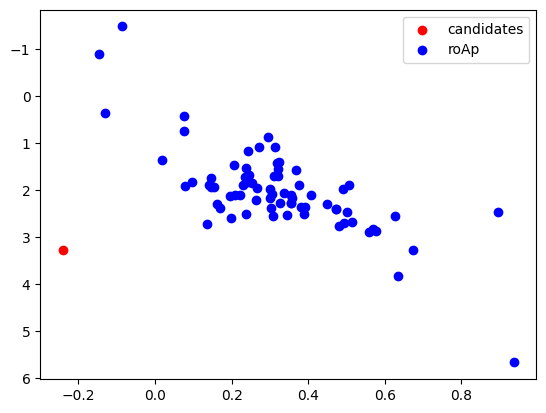

1.0293966361598796
2.582537488081151
0.5733270363504577
0.6259805088605264
1.0647709727841654
1.6137993498634495
0.7514816361011292
1.4366648661962262
0.9673238738418877
0.016992112517789426
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


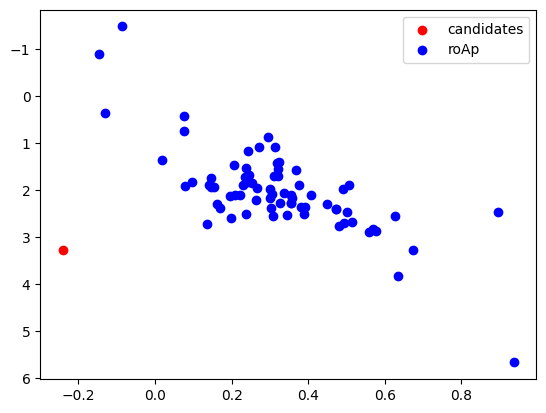

0.6244970689375728
1.9363939356261994
0.43308490824965773
0.9862351394331117
2.958871327556319
1.8104606056633559
7.674636937177038
1.5890269755382418
0.9301825493373461
0.8938987494909973
1.181195072471663
0.712473009543154
1.4985716842396863
1.7491554625536816
0.7537638163496645
2.329585046953116
0.8848355885631127
7.55890787577512
0.7490299836410492
2.2771079274408805
0.5857270726295081
0.7223245721084126
7.644024131494261
0.5883689096950953
0.8177142544268445
0.11339845301775231
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


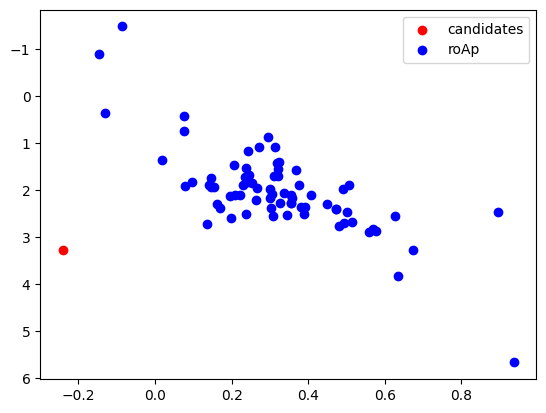

1.092520635678584
0.15397001622525508
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


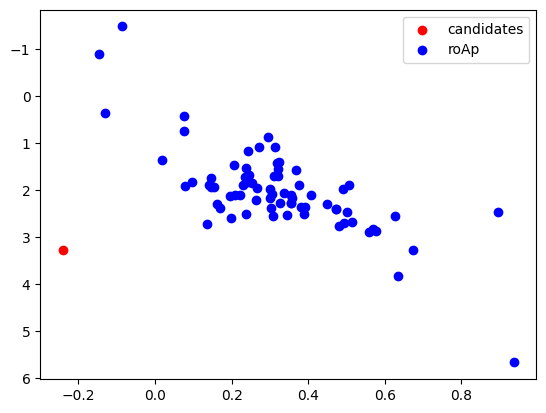

0.8374173795573618
1.3900765536508688
2.0586342613578377
2.398788073061753
0.25039361121726156
1.2819133816462074
0.9088334278761669
0.5699037134513327
8.055313901461599
2.2856039924541616
1.7256452224286556
1.3258495184377712
1.4246728623435354
1.8960298465337946
2.5114464825426657
0.8921040983953956
1.980506390398049
0.10120243295188125
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


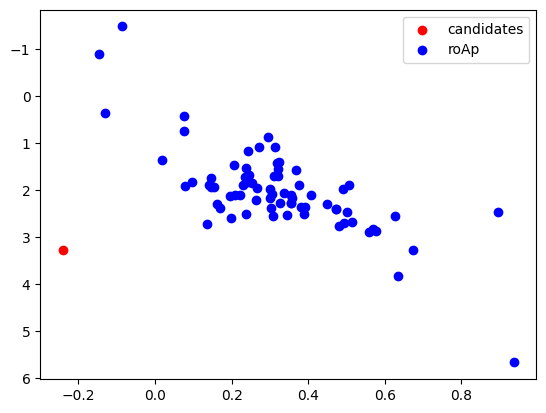

2.0577178823319384
1.9920523249032778
1.1406753777929355
1.4595665506011777
0.6183904141498422
2.106204583030447
1.3181971464750086
0.5037575076560277
0.863396596669606
1.1018915498771973
1.2948874296436976
0.8155426920221478
1.066818050719804
1.1747149642767543
2.7217975720371514
2.0107042478506285
0.8115868872451513
0.4050586132017746
0.6781222469042343
1.1728649867504606
0.9254417307897986
0.9194630183730448
0.745433730628462
2.3685383120628503
1.076963534948118
1.1532759723832475
0.7995291482384657
2.447983608635967
0.9635823889487316
0.9809306828728799
1.1031951789003989
0.13963009697003326
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


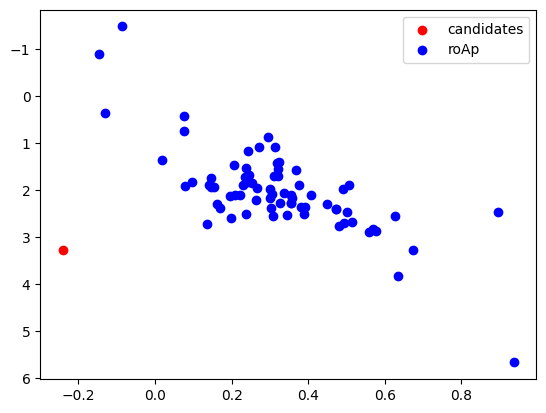

0.8977473943260739
0.5548826225357526
0.7248108035876752
1.597236034692304
1.6682094715655669
0.9098604247459052
0.6593492623721948
0.6702831482378837
0.9751386971597151
0.5909450466242347
1.811802306625207
2.246840911949934
0.9850628756652577
0.8157778293525926
1.6788805218679164
2.0797447175515575
1.1151353142243154
2.372860689460736
1.7285774882378329
0.9500550766443121
2.359150108354646
0.993735293676373
1.282677612987701
1.4874095768473898
5.3016171667192875
1.400972402595456
0.8754335532472348
1.0407731334711112
0.18699986033138138
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


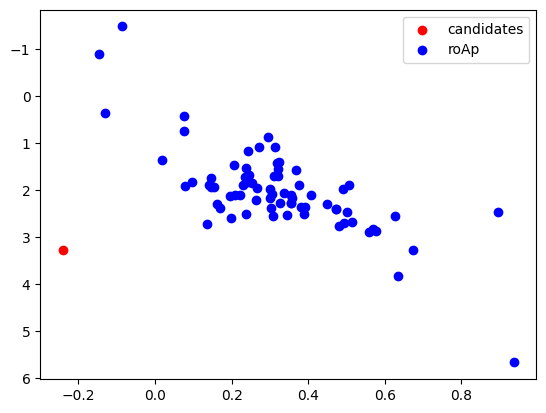

2.043070209805988
0.7302293358936636
1.1060998165117777
0.5247919250250925
0.354389976392814
0.929829808324131
0.1849666140034163
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


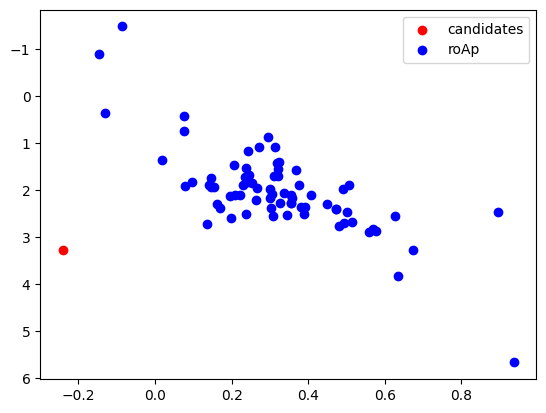

0.6153128814425477
2.393846696202944
0.41727192277723724
2.702872474838255
1.2960181635709844
1.1493270834100882
0.07265399471433387
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


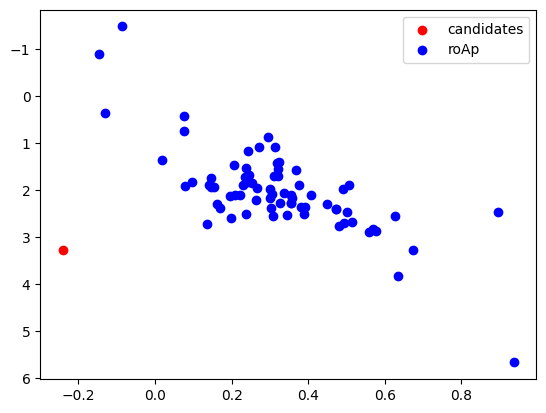

1.2871693925620349
0.7155644088756685
0.8518333726547853
4.1922807365032
1.6272090935026462
3.235672918214921
5.228081424524558
1.3649721857239552
1.2471199725441968
0.9724795705845368
0.8367015938602718
0.9868679004666143
6.803027805942676
0.9463343741802133
2.4224781240865303
0.15795006133322698
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


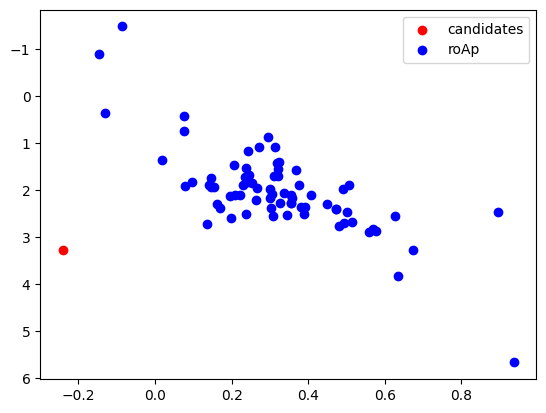

1.0784919275960094
0.6391378256596871
1.1906282289048065
1.2265005034053287
1.6052341268118022
1.3222186864060008
0.8916511132440972
1.5894833835739108
0.8899844045194731
2.1413921929511455
1.4655521788217678
1.3479627661878002
1.0693734402374329
0.898642990922915
1.5698943692066987
0.7080054002647005
1.7413233147087146
0.8952231259257086
2.055051839952923
1.2844238184388992
0.3962098421928255
0.22671040596122527
1.116272998972986
5.898119079235016
1.6158360540933332
0.6168101529731755
7.120107038145727
8.133756406478406
1.8796221019314254
2.032592766993516
1.1689298943674258
1.440063983781923
2.416385300906472
5.38807854628465
1.2320331464746213
2.45986841752919
2.434999186932722
1.4753311604642891
0.7103153137636777
1.7558499606675246
1.0941700899111642
1.4281376800656798
1.1566197635382514
2.279908827994709
1.724113336861297
1.0287984191280124
1.1633038879463395
0.046902999128697775
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


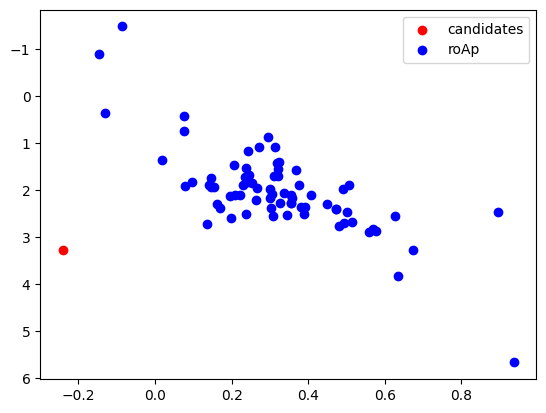

3.68053200000519
3.7852199805819513
1.2485653755460495
0.7214600966288351
2.5242822144634243
0.7229124504520721
6.14431132211276
0.7026940979357279
1.6237477686999682
0.5239551127608619
0.5499239561673521
0.6169000584230506
2.1328961279378635
1.1701124968234877
0.44733146415308456
0.04086550237933295
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


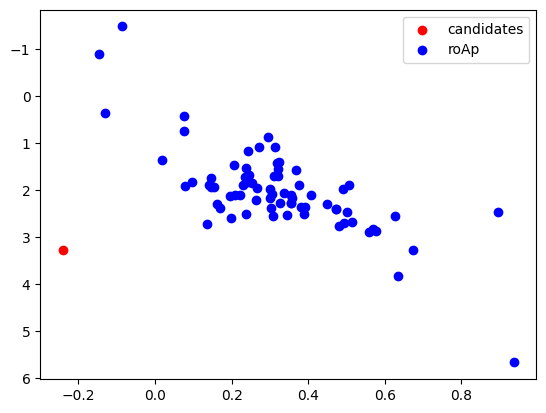

1.9748769260750443
0.9129172100416891
0.03672290086365271
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


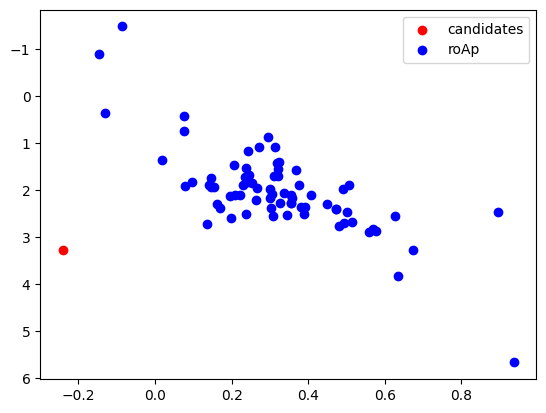

0.7347730190143196
0.7904383240952351
0.4388907255704959
2.9727340563468143
0.5292457026958726
0.6520565472264845
0.1751876673784425
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


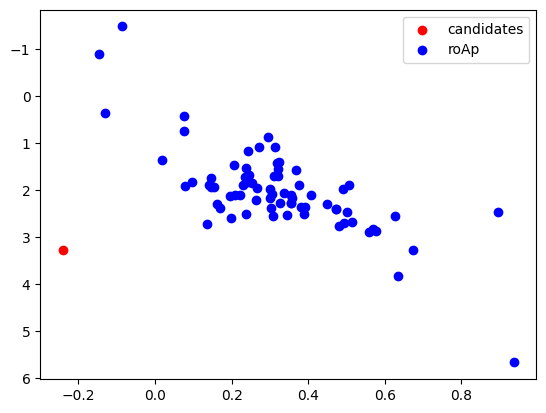

5.573878532159151
1.063591828230023
2.390101788425417
1.1744798269463095
0.9410264947356106
1.3484883672793835
1.894359679907252
1.1699707228448366
1.3696057742944872
2.026482654303866
2.2400150135631955
0.5470608133789931
0.722698060533137
0.8312657720446923
0.6413059301624662
0.7276047883376675
1.7220904642390877
2.08719649618551
1.270391652454407
1.6734585316600104
0.7098069671641385
2.599204575327394
0.3749610349048256
0.10363333800045194
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


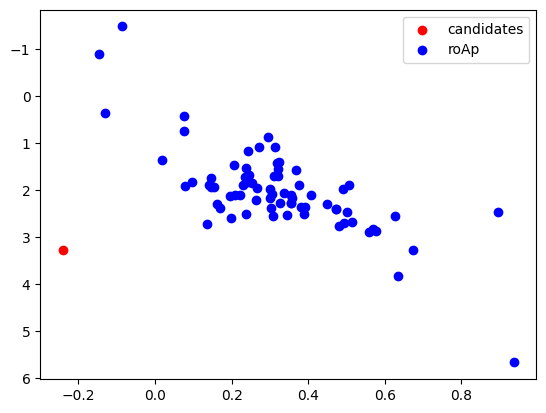

0.49947320219679225
0.4044638540718255
0.386538125544867
1.1566197635382514
1.0254269647576617
0.6221906483580621
7.446380831549556
1.859165154182718
0.4153804504279228
3.988195365284687
1.058384227941052
0.85439913587817
0.6042648848135554
1.1612187730896002
6.428090958842507
1.2934281950341715
0.7838994315677148
0.8809143277877522
3.517339776872582
4.8979382388741435
0.6757916210112951
1.6861214035024
1.437401399304826
1.2997492747583856
1.4816210490361428
2.335183390158856
1.06749925739771
2.393203526446139
1.6399514620716094
1.3600343017846122
1.6812630162896305
1.5247756649766213
0.6463060563363392
0.9970929164390503
1.017439211326372
0.27808791266343924
1.9258784558926259
2.1983369217418343
1.111079230291688
0.2063571952700669
0.44313702912617803
2.668165513284202
1.4699367984541816
1.3155172724883206
1.91747229632922
0.6145383464303946
1.8894356275755824
1.0071070354120162
2.1788343549225795
1.6852810983187032
1.0298530792130958
0.19461070245357615
ID: 96 --- Gmag: 3.272301 --- 

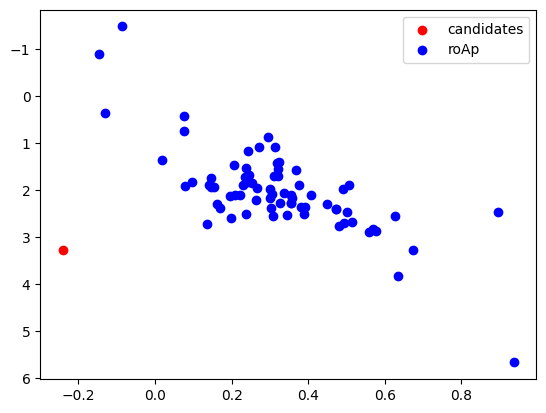

0.4958354543611847
2.343921508306419
0.6395493159879662
1.691169905285581
1.505349171999569
2.4132005732397115
0.025958452191961356
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


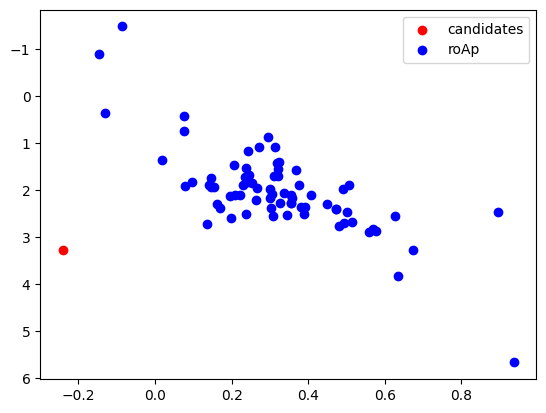

1.9700254896836586
0.6516312252905321
2.2423905921810725
1.2972802977711666
0.18411600514906024
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


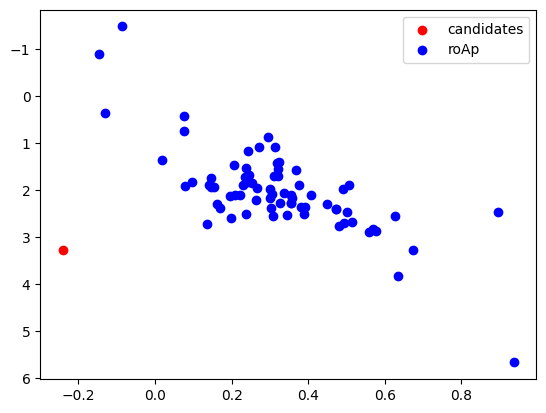

0.6612165294080814
0.7876962078740171
2.0646336861685537
1.2011679139518074
1.1780207535282043
2.9020718306461992
1.2210958027070138
1.9866545400088
1.3840425498209692
1.898892989322154
2.0972313275524392
0.31247328933908936
2.196850023916962
0.2586337564710406
1.545035547333533
0.7000107310295736
0.11923881434022565
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


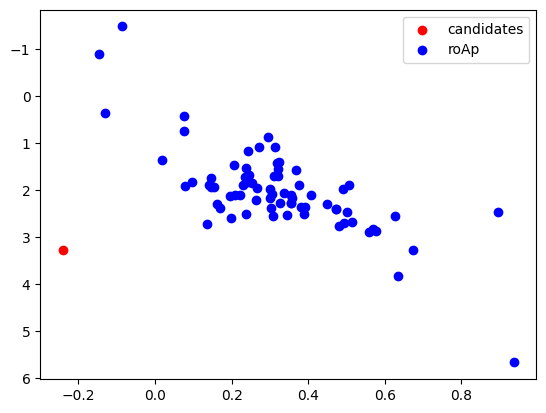

0.46679599405123806
1.7541072131182451
0.942599840108441
6.462203161266611
0.6637131345930989
2.0046840406108553
0.5606746082489176
1.179493784727856
1.69121485801052
1.0705041741647197
3.6544490458353955
0.9932235241924632
0.7690339112209106
0.6322427692345816
0.13801525677418347
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


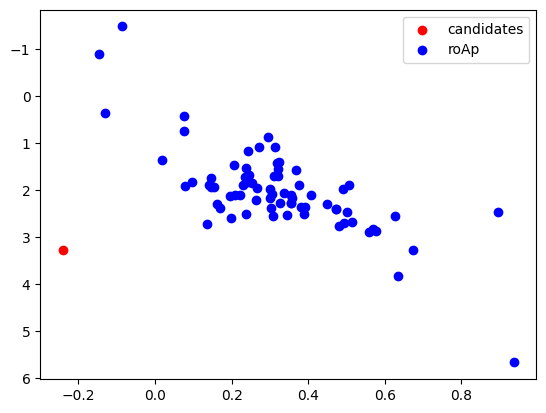

7.131953810117848
2.469080268239562
5.130049905140539
5.485670912125044
1.1596592593244432
0.7577369456538001
1.4873300451032687
4.5733726490179585
4.14761847532634
1.0778729631526334
5.503344248829515
0.872349104736104
1.2827640255181114
0.9985244878332287
1.572857791150688
1.7414650886873648
1.4555830826088345
0.871190742611019
1.6065170434410416
1.6748970188580259
0.6976732243503454
2.4895372159882694
0.6974242203946792
0.0743587053425121
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


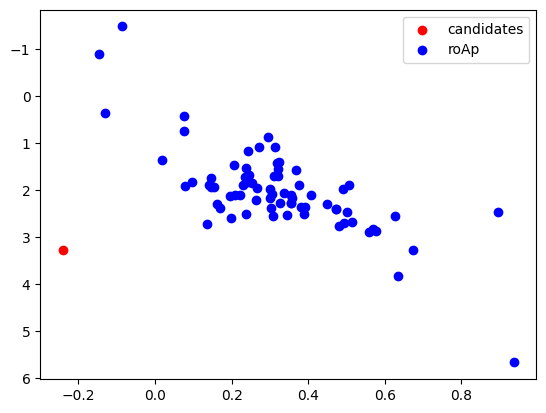

0.3220655092604745
0.8366324358219055
3.4404809909343603
0.8315147409828105
1.0098249113022586
1.054134501500999
1.7203027289473232
2.1621396044609904
1.0203403910358313
0.7088456704308497
1.2057772972089111
1.511379752945098
0.3710847618719504
1.5337385467488742
1.3750831259506344
1.1942936049382125
0.70941622424737
1.251777766428157
1.3383048461299678
2.1380414859923054
1.9733001228002953
2.401592396499953
0.9520537439530941
0.3912719582534825
3.9518873951424585
0.15180191172247604
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


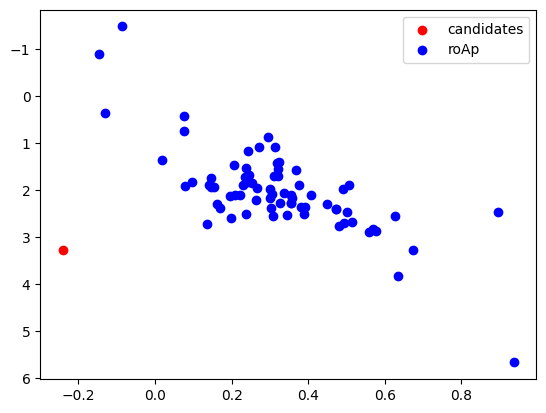

1.5950436898585494
1.0091644520358614
1.5811394662450349
1.3518114110228767
1.6796896709168
1.2701910941431453
1.0727033997847633
1.1271376917827611
1.4566273339706157
1.9629471644568834
5.0806848973547805
1.4355237585631846
0.2363960242519525
0.9752735553345291
2.545468779516894
1.7047179650015103
1.0272596527743652
0.8291564518745247
0.7956701296976343
1.2090000617967744
0.9886383462487878
2.0877048077675022
0.7541580171683515
1.0896402033806334
1.4452404629536293
1.0446148625023506
1.9034608777562383
1.1140702804334763
1.705464871815865
0.852597568978732
0.999399337018561
2.095004438717049
1.4889898380240565
1.0562921972804755
1.5233959621112163
0.2457219507080799
2.166347871095571
0.6362815986751649
2.148387528531881
1.9557754758783128
0.7924543159311557
0.6362919723809197
0.8424451689465808
0.500738759281345
2.4499684443370757
0.5999528811214256
1.755300154262513
1.8572114395988741
1.214328688652886
2.167288420417351
0.9531637304688703
0.9790807053465862
0.9787591204681831
1.72016

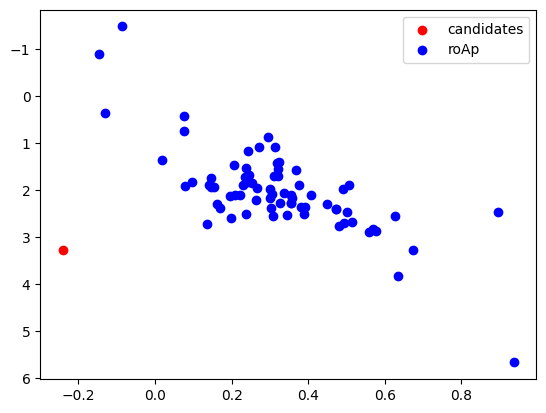

1.9260375543984156
0.7621457705996422
1.7959581650179741
0.5619401653334704
1.4201983372612457
0.9733336723583585
3.300501663379351
3.7987784140036354
0.2644534404170997
0.7638850952645511
0.13047357269035498
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


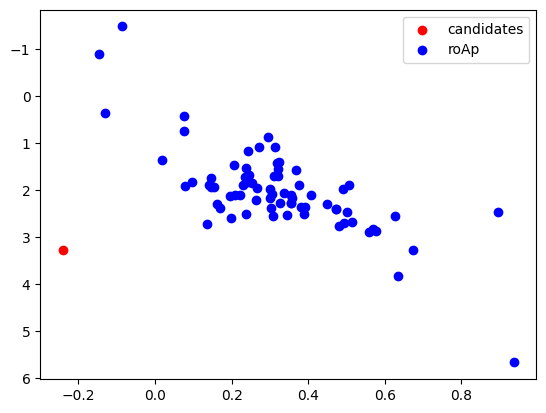

1.1317263626459027
0.11027593256797275
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


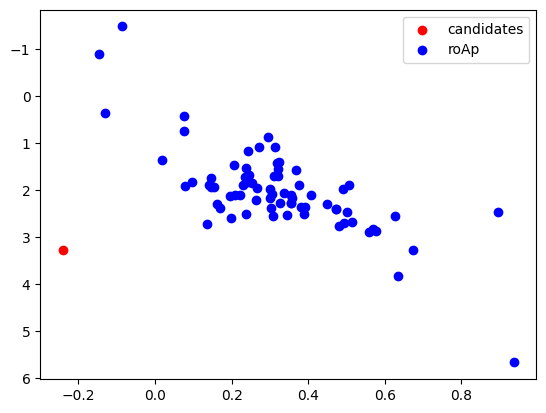

2.5799509774462575
1.805225342159038
1.2772106350373091
4.116905390487932
1.4662749153402415
1.1786223934444422
6.183738319785302
1.1927548385845652
6.0625457733524595
0.09297604927068015
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


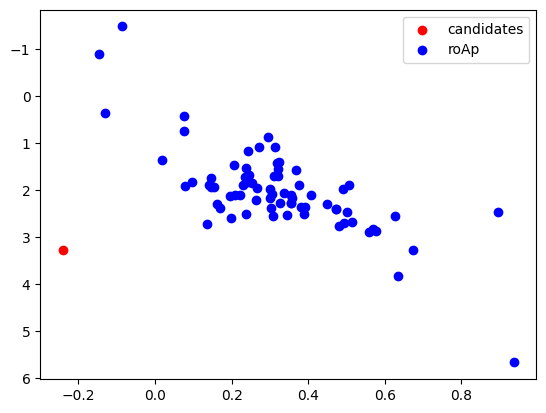

1.2733101216734584
0.8810249806491379
2.5084069867564738
0.9533504571724594
0.9096979033557444
0.4791234143900045
1.891105794202125
1.5498765750016155
0.04426461996502873
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


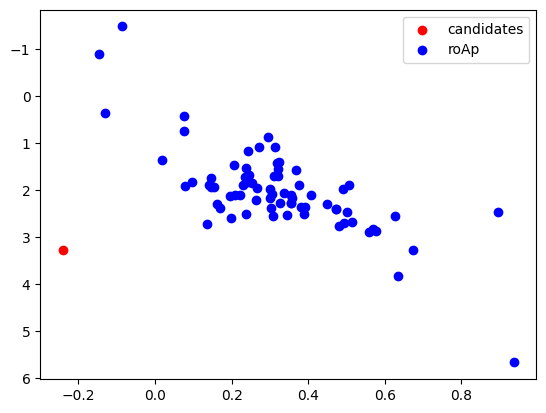

0.9731918983797083
0.9670921593958139
2.1388921298642085
0.7086796911387712
0.3726511914409436
0.8148269063250577
0.6787238868204719
1.5839991511314748
0.1676114392929784
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


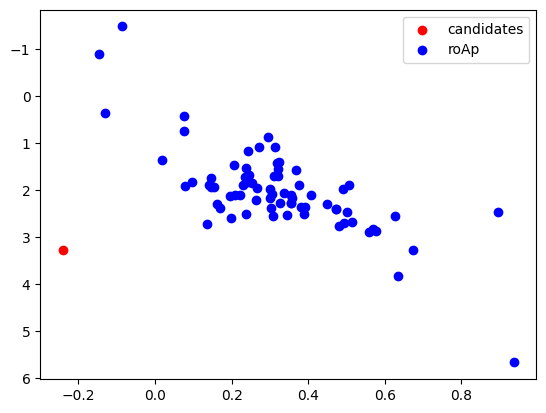

1.4465821288979317
1.4311183915192611
0.9125472145364295
4.799685413767352
2.037603266873143
6.547032411126532
0.9778220640658695
1.0108726555835057
2.1403963171986726
1.884241858894284
7.766333580246718
2.122933912511219
0.9367144910434817
1.9226211122855803
1.8863788422797985
0.5260436855195199
2.3933176372094422
1.779038650931695
1.3440069263932566
0.9811831097129167
0.48377086958575743
1.5512839410823673
0.8834178487766069
5.211787790685493
1.3368352728322344
2.0813318945320614
1.8181993901565283
0.5009220280830151
2.057524239824513
0.8720828462883947
0.8661940393215168
0.8672832784257842
1.4712577169869752
0.9657159144323275
1.2485480860364584
2.8734818975856316
0.8634450072964626
0.7178189259088574
2.229471870614275
1.6966333903165074
3.0784559495971493
1.4456657848895809
2.679922379806448
1.3093968211104638
0.4994317073737724
1.35337784059187
1.2017765046894295
0.5695302950617034
2.053194946622792
1.175738503244574
0.45390147779786894
2.381121617143572
0.7785950100250316
0.86306

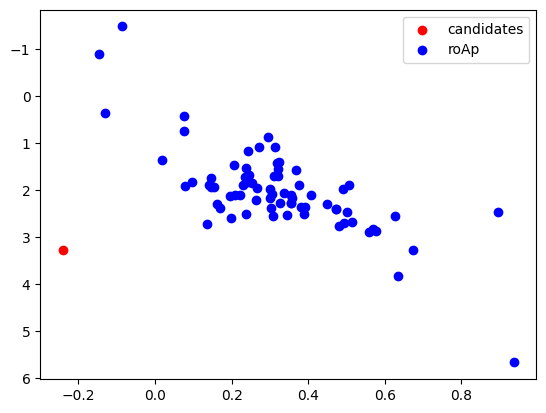

2.423186993979784
1.3731777869760995
0.8384720396424452
1.2151309218979334
1.4698918457292436
1.0611851284948806
1.5401598706111717
2.8763519561778272
1.3782471062058859
2.440594072236544
0.887601910097759
1.838016626050349
0.322293730787083
1.50792185102679
1.0895122610096566
2.546627176659527
0.5224959131688838
1.8535426056635496
0.24178340042312785
1.024707721158654
6.533093608493834
1.2900152458408023
0.9318492580619704
2.1388921298642085
0.9576659187665069
0.47785782228790374
1.1183546209102602
2.354004750300204
5.234710222501954
2.4722235010833034
0.983465324979
1.158452451554954
0.9070353188786475
0.5506846945893793
0.4721246209073495
0.8888363810825943
0.9611583997039972
0.7895773065175762
1.7288576133107632
0.9008145533276126
0.7266296599967053
0.8287622510558377
1.1729168552792348
1.0436016972402866
1.8078775879479276
0.008672435519889277
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


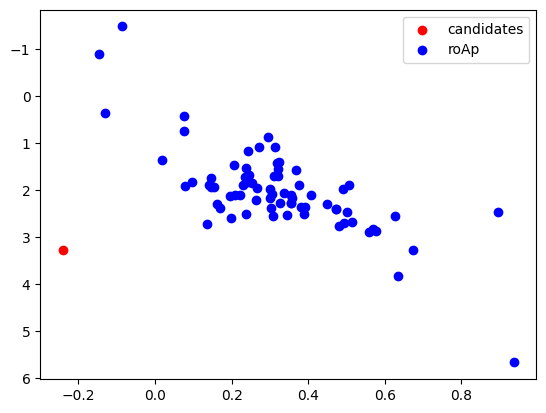

1.0905357999774754
0.9702042711222907
1.0678381317857042
0.24410365261031242
0.7523599081708321
1.635774351571842
1.1098723875046508
1.7855429644400314
0.30902230322461843
1.0718078031879212
1.5390083892723752
0.6994055981938692
0.8338211615623212
1.4876827510989363
1.1326288400290334
2.3703502876855915
0.603991710562009
0.4947600468645912
1.6375447623364678
0.5450068546570661
0.5854573562798802
1.1984188819267532
1.802967332206383
0.9605740142798034
0.7353470307327585
0.7781731459909977
0.7168542062911973
1.5437250025064944
0.40686363800313163
0.8819378667555711
0.7416023753029775
0.9353555355895864
0.8038930204593697
0.8487281767321457
1.7842082142995652
1.0410635972322488
1.2792750024825388
1.2408335068567142
1.12254214013333
1.2663459072099874
1.8734670365168382
0.49930372998524764
0.7322107136928535
0.9649690076179729
2.924980430854986
1.3771232530648883
1.0706390323395336
4.366085260623093
1.2912082220026182
0.19282646008127724
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


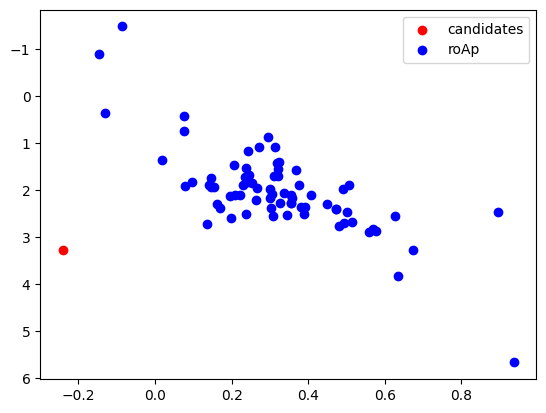

0.4990340136356197
1.7027020081831372
0.6036147992529131
0.8472274823171477
2.15494716847091
2.1332557497373674
1.1074795193771827
2.4227374667304042
0.1434337890801718
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


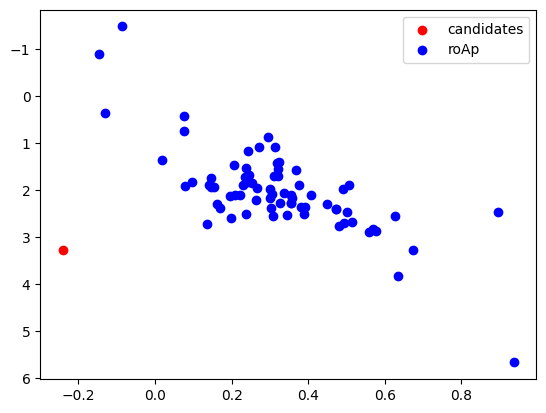

0.6582254442487452
0.002344475009386393
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


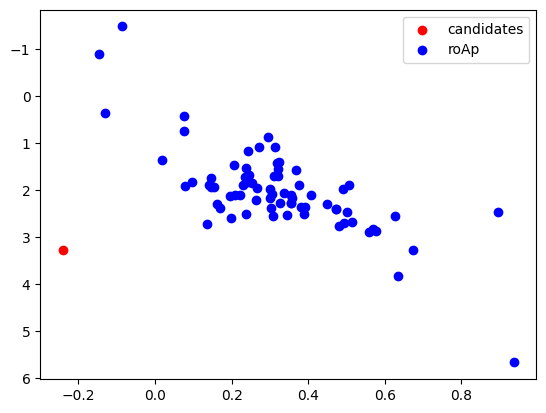

0.2509987440529651
1.5940720194195048
1.1743345950657407
3.2284389874018213
2.513092443855781
1.4082824072507574
1.6505395577454678
1.0666416977219697
1.3192829276773574
2.4567009793720205
0.702099338805779
2.095018270324722
1.7062498155513204
2.2051559043247364
1.171938269036354
0.9565663059564855
1.006550278185621
0.3114808714885351
4.800639794696805
0.1466115659255487
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


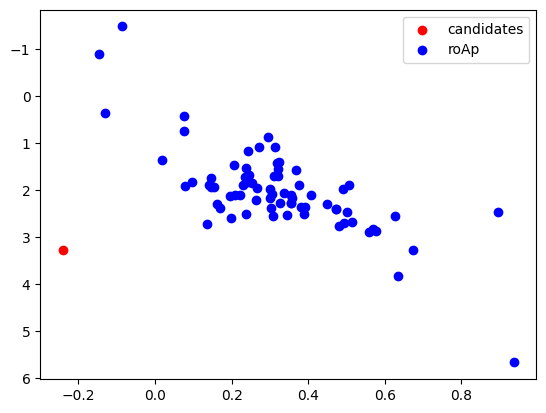

5.408213909154955
2.179242387348939
7.546196628323422
2.3478220216702708
1.5459380247166639
0.8283611344333135
2.2663884314941276
0.45064067628890525
1.8444033708934633
1.7783643600576253
0.9325961298587773
1.8518655232331707
1.1547248332870188
0.9692187690755727
1.0124909536812732
1.238461386140755
4.16984586885722
0.04485242827359359
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


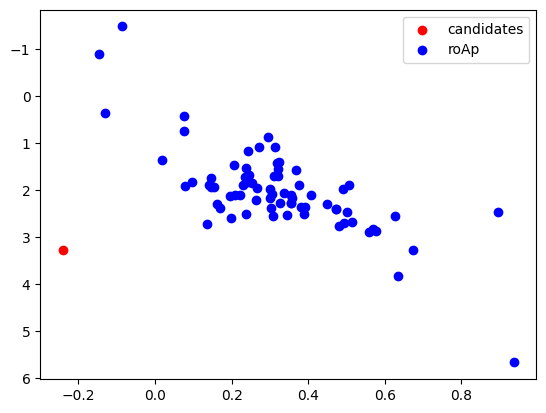

1.3118830175721792
1.211361808806978
2.071504537280231
0.6526443905525969
1.104986372094083
1.5015869747124508
3.147866414803337
0.9428107721254575
1.153154945816107
0.8789951922230914
1.478616167286681
0.21017129610350782
0.10928697261933706
ID: 96 --- Gmag: 3.272301 --- B-R:  [-0.24091397]


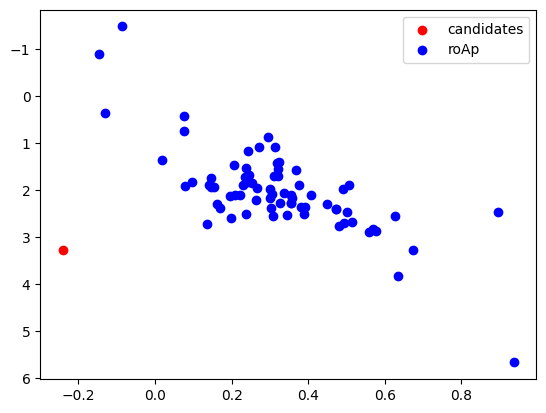

0.7638781794607139
0.40772465558078963
1.294569337684761
1.7286915990011362
0.2725967644171665
1.820398615776572
1.1966657256541708
7.7872780921659075
0.9239617487687628
1.9232193293174475
1.3414619105813825
2.462250911950904
1.1118122704808222
1.026453961627399
1.203726761371355
1.6972696792870237
1.9653310140427442
0.7093872408854238
0.4625622019566298
0.30683134857255867
0.9587296324107459
0.43381242281664933
0.766805702238921
0.4010461268299381
0.11036105996933054
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


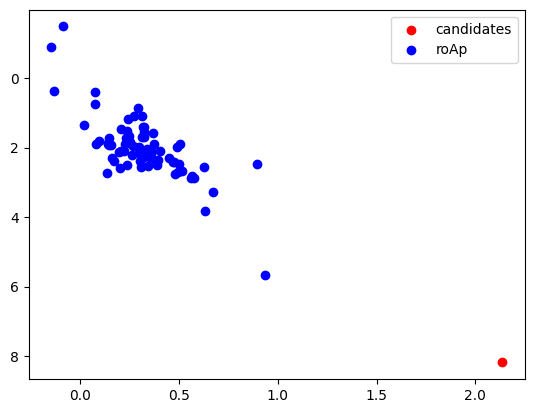

0.687028447081647
0.17137573931786765
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


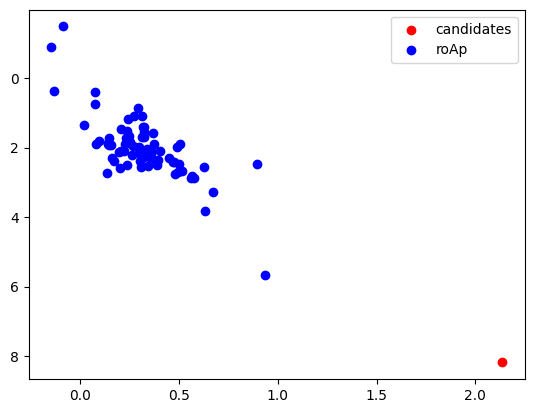

1.002475549579255
0.6626978665932639
0.044432701994878254
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


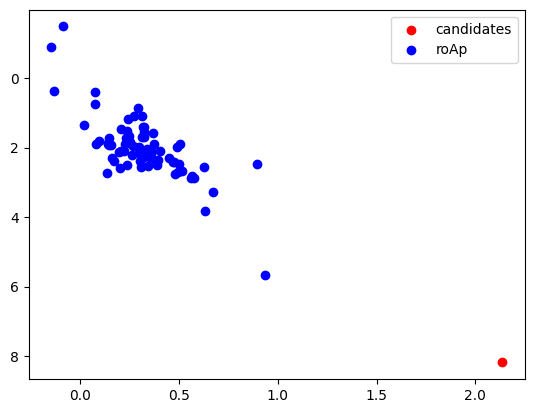

0.45473351201358136
0.7242250980168816
1.0101659234455709
0.004383281977040188
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


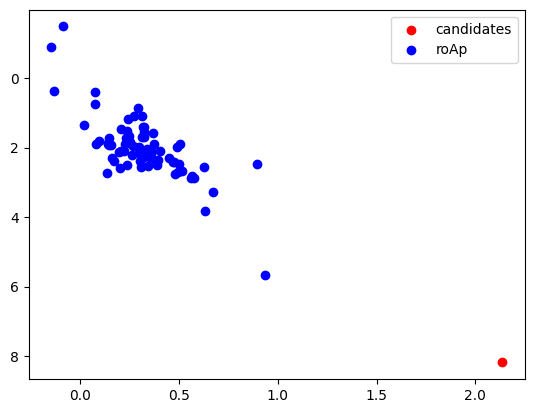

0.33410460359342187
0.5090882722674579
0.02479103650772041
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


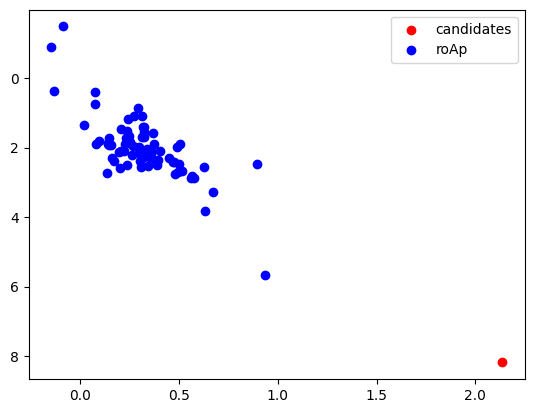

0.42725278287762025
0.23841675911884375
0.6929579662803738
0.5836475534300058
0.2543411800438211
0.06830951474079239
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


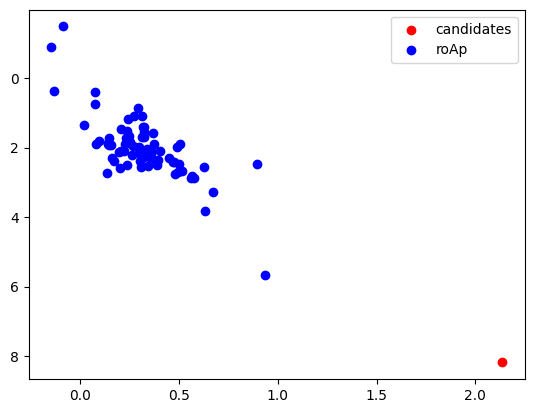

0.48180888403392963
0.1880151633487639
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


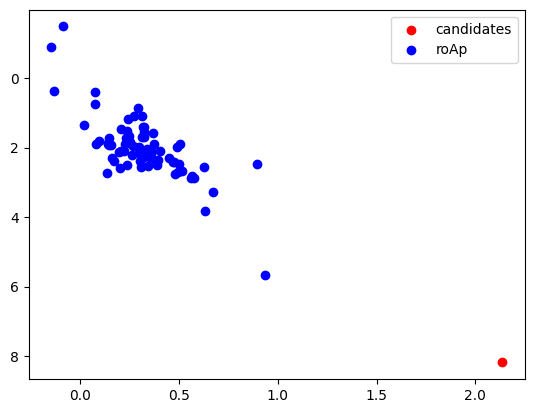

0.4593559442871875
1.820386139333046
0.777857156769832
0.03281069364744704
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


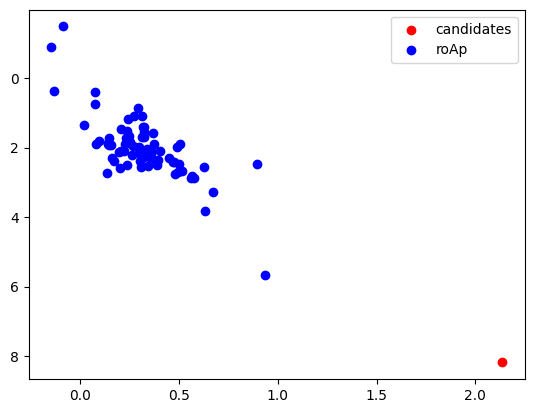

0.7388969758562607
1.2072386695737558
0.23955519144113802
0.13078610400960278
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


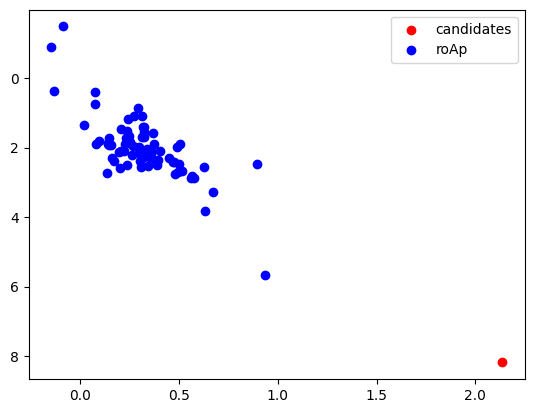

0.38764943220724346
0.4738722165402427
0.3583160502342406
0.045103534967030345
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


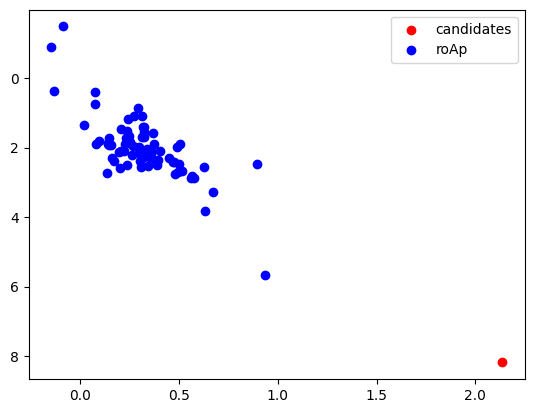

0.5622811774767833
1.0545611435835505
0.11484941665929371
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


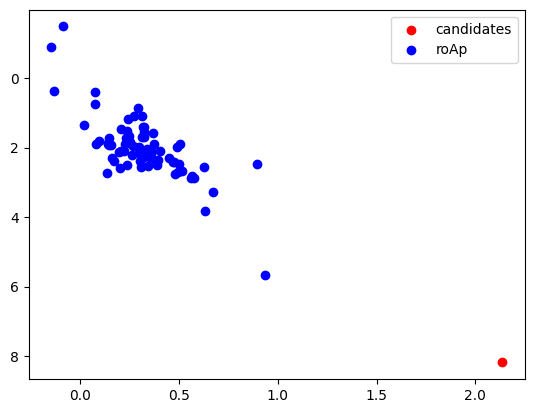

0.21419493877227036
0.07369268543642615
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


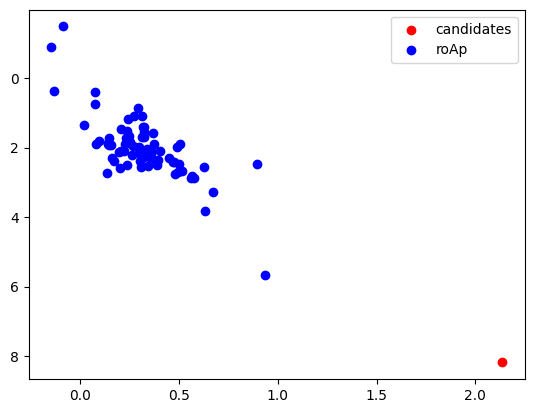

0.290213454544344
0.08063693507955882
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


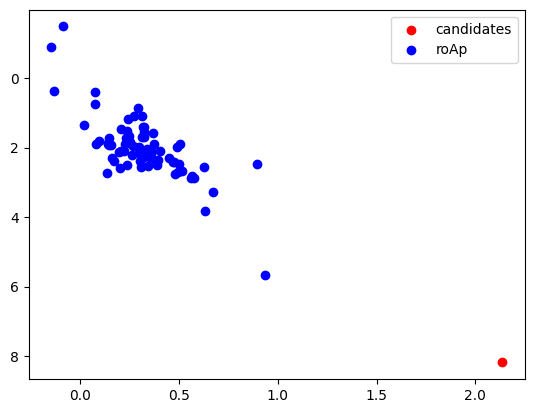

0.5070162064272208
0.28231482397175833
0.3339559138109347
0.9172374847018019
0.724846737771006
1.0540155776716291
0.8931774031542186
0.3653459648341597
0.1608083910555198
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


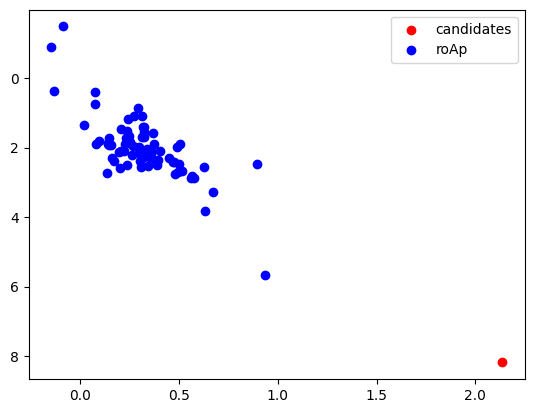

0.1965181441658821
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


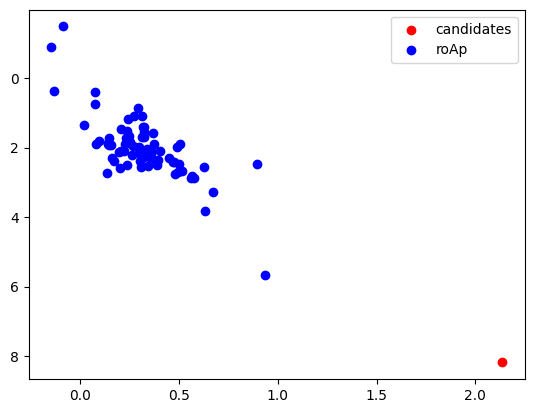

0.5244240672751521
0.3627671525942735
1.7796770426399822
0.45619620452502563
0.47223049572021747
0.5939348116369707
0.23468992344207917
0.4234637049663261
0.015357880074577501
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


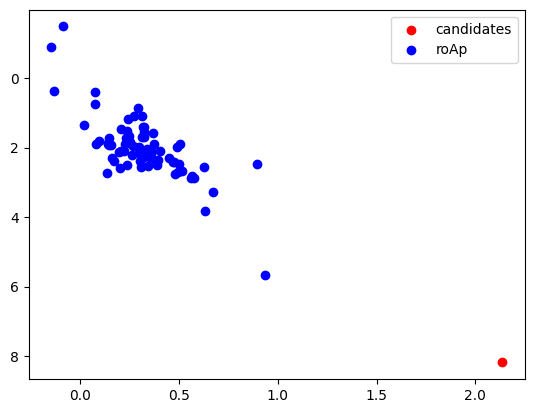

0.7832065310374539
0.20396992279983484
1.728365236074216
0.5575922624755583
0.3663867933115701
0.2279158935841148
1.5693501584589242
0.04284820032512249
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


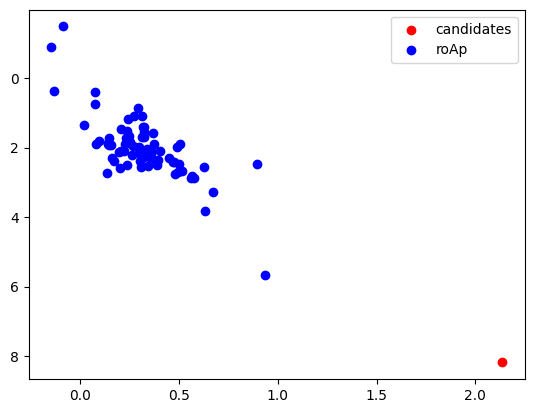

0.16353321776714624
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


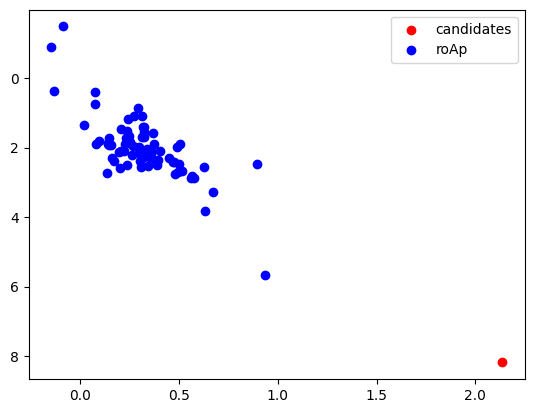

0.937684841335926
0.432592566030658
0.7887115108913996
0.041496943266235764
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


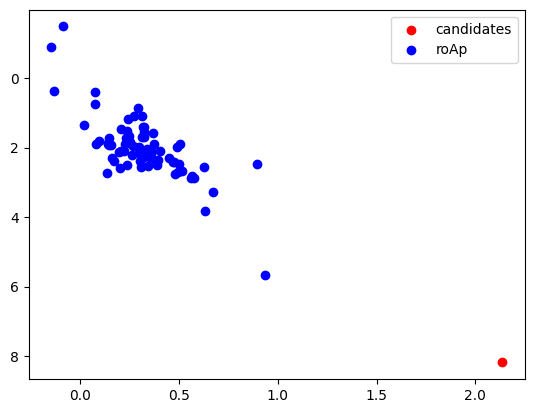

0.21898759083104458
1.016137720058488
0.5490892816584401
1.0103249869338131
0.25719662443717217
0.4342696484610371
0.08378975903788399
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


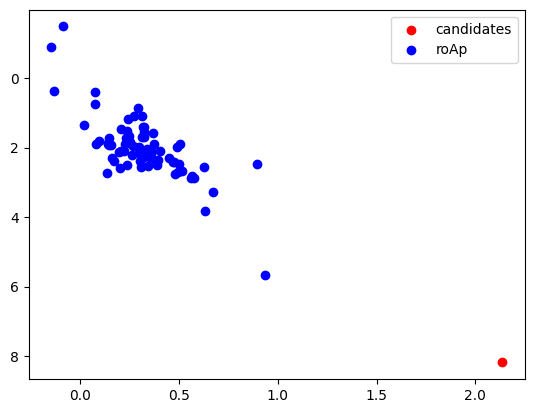

0.206949851662245
0.14676585136527276
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


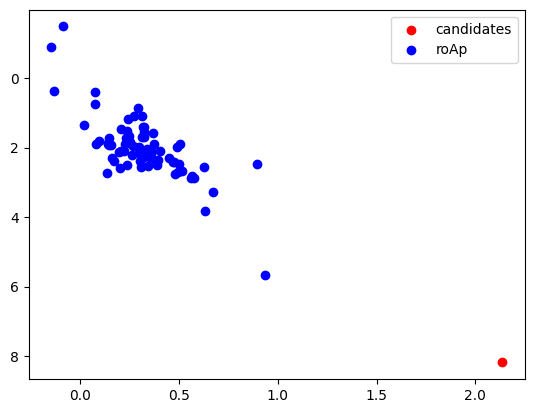

0.35136299206769506
0.7636728431009343
0.8047112230674085
0.15092916527491473
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


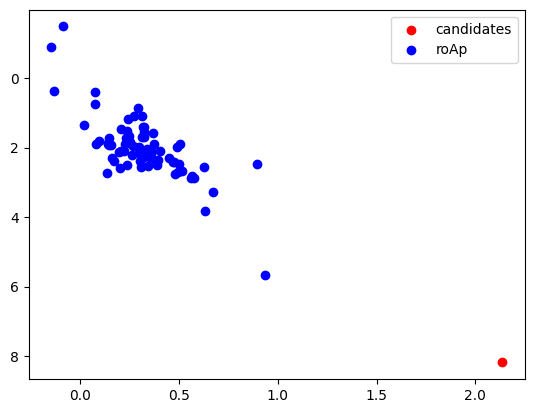

7.046154244983029
2.003240775364321
0.24768126094916076
1.7976711816316837
0.7532948968529225
0.49480981265559487
2.6186116760570832
2.131704506940195
1.538802270321424
6.710440379342222
2.321685096233931
0.3425272700752484
0.9676882736899093
2.3092262756222683
0.16164442072857943
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


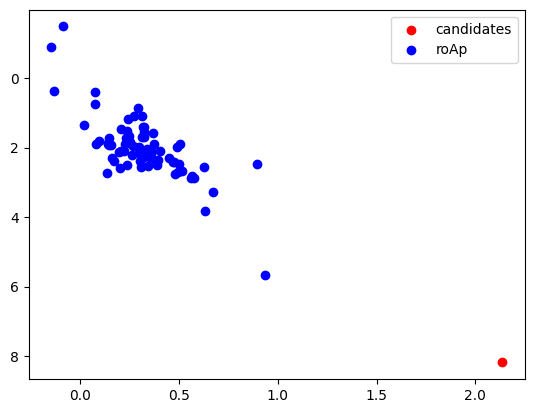

2.0870214983518243
3.1377776121698635
0.6960009199684847
0.8542552591617487
5.681382600061562
2.273831191586473
2.4907453789219063
1.1339234505106277
3.144734910829498
1.7331571055418196
1.486034687048051
1.1482253328447478
2.183756304516479
6.101109650709573
1.0221571447070903
0.07907050551056516
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


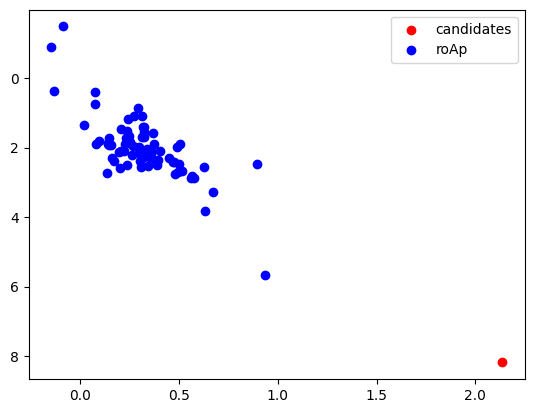

0.21560843806568686
0.8964969889957932
1.4625347856112323
1.3196611941506
4.903257847188648
1.7418226077490977
0.8002678191023833
2.310823826308527
0.741116948887814
1.8057038877879124
3.53993852107287
2.094864019902546
1.3632134688116841
0.9523386470745421
2.4591885660154316
3.2743197852180743
0.5286453829262343
4.4869748668512734
5.890191465300484
1.9696188124214458
2.5316004900867095
0.7758162120468595
1.705058194553652
0.6076730559584067
1.367120897979372
4.8023908482316155
3.29106294630652
0.8666034269120249
0.3468946001980706
1.2385561046566962
1.9137979017542066
2.3428647454835647
0.8281411838746897
1.2753170599502242
3.0581801679123415
0.8105335473066675
0.8410668212453234
1.3830064993920765
1.7739776376874405
5.74981447902487
0.6692540486303753
1.488096379182533
1.7147514762218392
0.7350994169587879
1.3271060569807172
0.7389757250092104
0.4388471280097055
0.9869522452768007
0.43172463264916283
1.2331583197622185
2.129512197123988
1.476570409497643
4.026582889643967
1.238030503

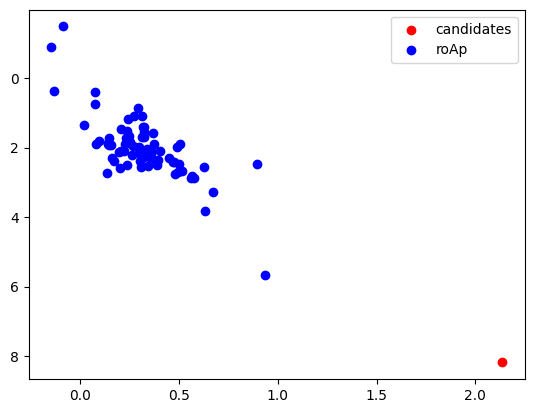

0.3964747804939355
1.8078719922906914
0.9457582597240033
0.08297447677633452
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


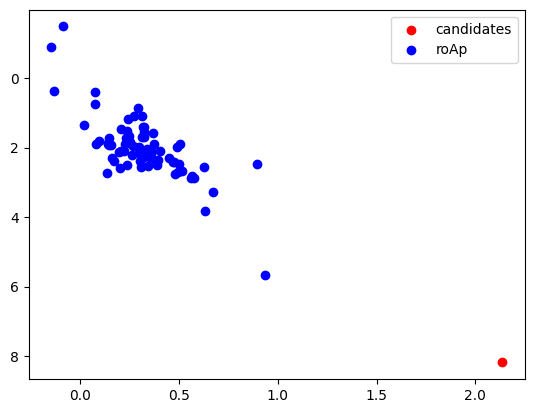

1.3938885167289912
4.722087991982759
0.9269265258769006
0.8732529723009299
0.9776685612173164
1.938349005374191
1.750100824941526
1.1230068541545308
1.788241483100459
2.132835240867481
0.6442922372732838
2.1139931333146236
0.25955145564353943
0.45152379644222096
1.6653338173161347
0.7633366440236871
0.9465120823421942
1.8616527408261292
1.3326767369711106
1.1119761470351297
0.5994052124717333
0.9448488315194878
1.3314111448690098
0.9827681839556495
1.5865662695190061
4.456984483513791
1.6942142141378391
1.9876621446311744
1.4077408718137305
2.20475614286636
1.6949472893445203
1.1669049190074454
2.0382962024209523
3.2676529503195773
1.587230186687322
2.2883440059376086
1.280490081220012
1.570390204345164
2.38504423308308
1.4229694718619572
2.569208631350223
6.530304436809908
0.974545293193914
1.9472323554023228
1.3532650849927133
2.5718573842196464
2.689526328597735
0.5345238161873573
6.391777428060587
1.3396755304537646
2.746782268561072
1.7908591148526178
2.0687119076943854
4.76833743

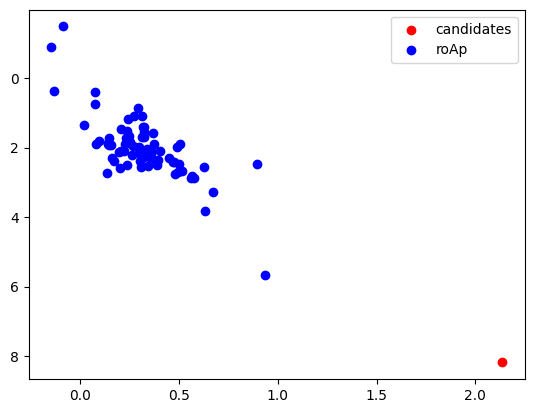

1.5763620009580808
1.1893924377733704
0.8818216532544967
1.168395274734236
1.353482932813567
1.674186046227002
1.3165075876011039
0.37726189484464756
1.2012392097454923
1.3858834737881085
1.8430250231922058
0.897734917882548
1.0344603597324293
2.2760684541276173
0.19164596036298676
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


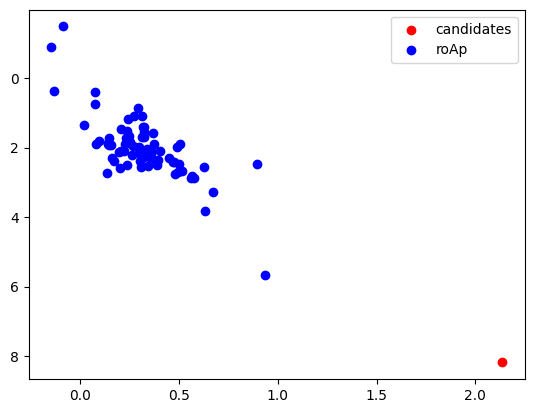

0.494934297124654
1.602590187008444
2.4468300245593997
0.9286520189341352
0.16648202551229163
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


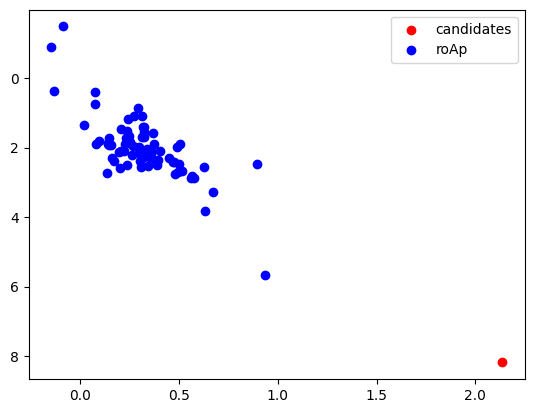

1.534974372897858
0.05459123523969511
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


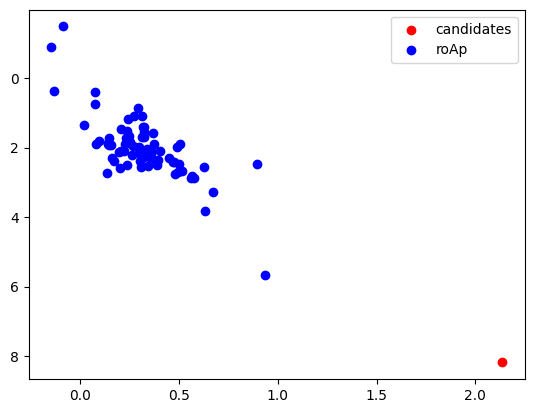

1.4611247442197342
0.14907494725553105
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


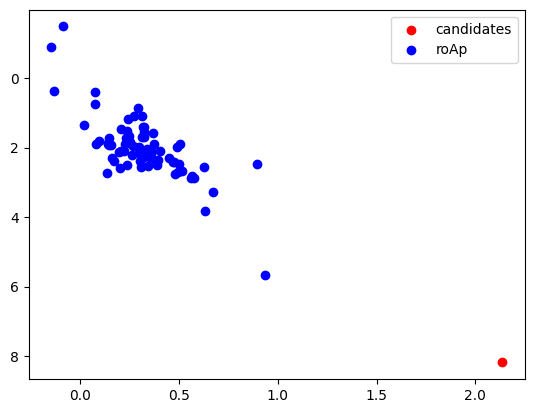

1.0675697706002238
1.734927551323993
1.8209117404246284
0.9171337476442534
3.423587037325657
0.7429799754306106
2.258917260612812
0.682134733276071
1.4291383688842179
3.8066707013453605
0.5424458694821999
0.7980781845969234
2.4839125647313307
1.5481005685797533
1.3177213111744304
1.8596402419096738
1.022482187487411
1.2436599678881186
1.0079313362151736
2.7671769740752494
1.3269339444759722
0.9069709739063474
1.9773748864242102
0.10915001170675209
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


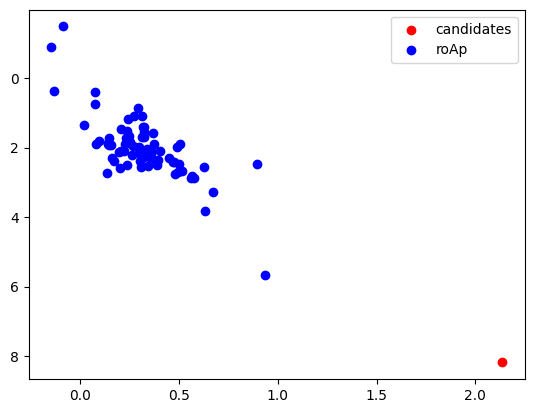

1.1862553381422942
0.8683150883615869
2.039904126812965
1.097159037315182
0.8215193017011306
0.7916361133231162
1.238933015965792
1.035259917666729
0.8885265250740946
0.8160108639452663
1.1727902680724047
1.4244252485695648
0.28620496362985426
1.2055746361598794
2.7587154880811506
0.7495050363504574
0.8021585088605261
1.2409489727841652
1.7899773498634493
0.5753036361011294
1.612842866196226
0.791145873841888
0.19317011251778915
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


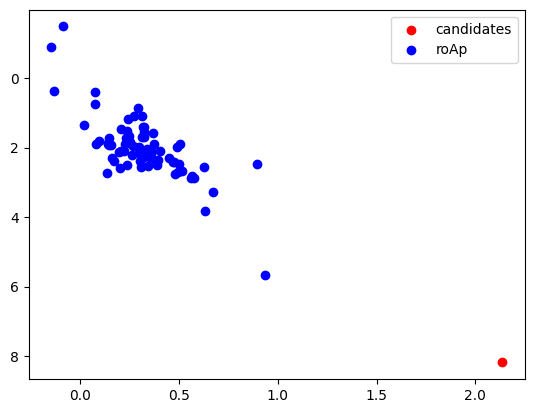

0.8006750689375726
2.112571935626199
0.6092629082496575
0.810057139433112
3.135049327556319
1.9866386056633556
7.850814937177038
1.412848975538242
0.7540045493373464
1.070076749490997
1.3573730724716628
0.8886510095431537
1.674749684239686
1.9253334625536813
0.9299418163496642
2.5057630469531156
1.0610135885631125
7.73508587577512
0.5728519836410495
2.4532859274408803
0.7619050726295078
0.8985025721084123
7.820202131494261
0.764546909695095
0.9938922544268443
0.06277954698224741
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


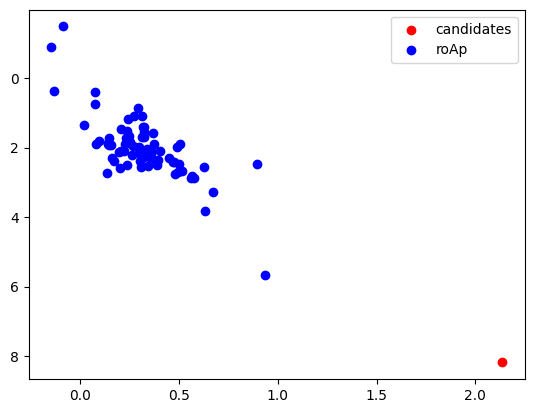

1.2686986356785837
0.022207983774744644
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


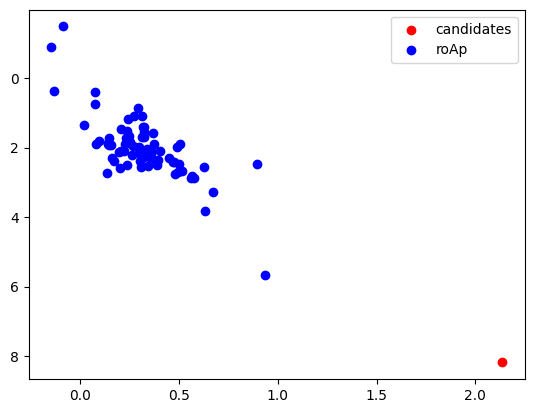

1.0135953795573616
1.5662545536508685
1.882456261357838
2.2226100730617535
0.07421561121726183
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


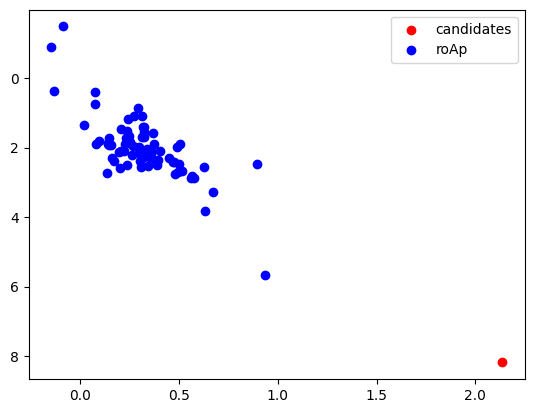

1.458091381646207
1.0850114278761667
0.7460817134513325
8.231491901461599
2.4617819924541613
1.5494672224286559
1.1496715184377715
1.6008508623435351
2.0722078465337943
2.6876244825426654
1.0682820983953953
2.156684390398049
0.07497556704811847
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


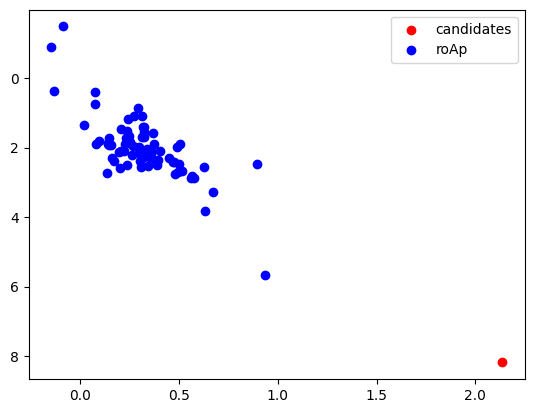

2.233895882331938
2.1682303249032775
1.3168533777929352
1.6357445506011774
0.7945684141498419
2.2823825830304467
1.4943751464750084
0.6799355076560274
1.0395745966696057
1.278069549877197
1.4710654296436974
0.9917206920221475
1.2429960507198037
1.350892964276754
2.897975572037151
2.1868822478506282
0.6354088872451515
0.5812366132017743
0.5019442469042346
1.3490429867504603
1.1016197307897984
1.0956410183730445
0.9216117306284617
2.54471631206285
1.2531415349481176
1.3294539723832473
0.9757071482384654
2.624161608635967
1.1397603889487313
1.1571086828728796
1.2793731789003986
0.036547903029966466
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


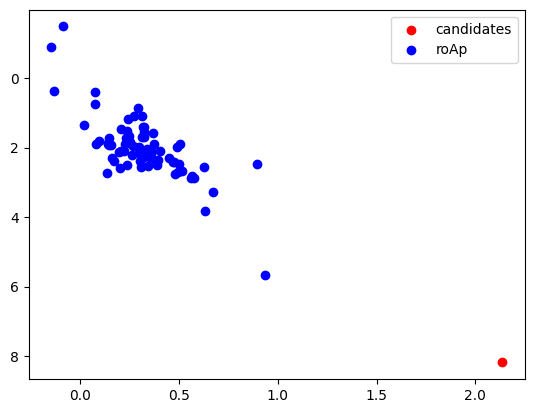

1.0739253943260736
0.3787046225357529
0.900988803587675
1.4210580346923043
1.4920314715655671
1.086038424745905
0.8355272623721945
0.8464611482378834
1.1513166971597149
0.7671230466242345
1.6356243066252072
2.4230189119499337
1.1612408756652575
0.9919558293525923
1.855058521867916
2.2559227175515573
1.2913133142243152
2.5490386894607355
1.9047554882378326
1.1262330766443118
2.5353281083546455
1.1699132936763728
1.1064996129877014
1.6635875768473896
5.477795166719288
1.5771504025954557
1.0516115532472345
1.216951133471111
0.3631778603313811
2.2192482098059876
0.9064073358936633
1.2822778165117774
0.7009699250250923
0.5305679763928137
1.1060078083241307
0.361144614003416
0.7914908814425474
2.570024696202944
0.593449922777237
2.879050474838255
1.4721961635709842
0.9731490834100884
0.10352400528566585
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


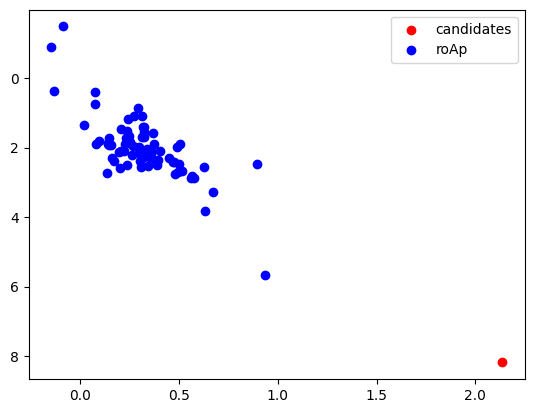

1.4633473925620346
0.5393864088756688
1.028011372654785
4.3684587365032
1.803387093502646
3.411850918214921
5.404259424524557
1.541150185723955
1.4232979725441965
1.1486575705845365
1.0128795938602715
1.163045900466614
6.9792058059426765
1.122512374180213
2.59865612408653
0.018227938666772747
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


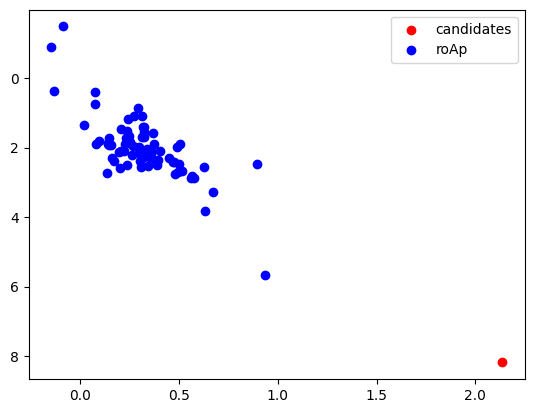

1.2546699275960091
0.8153158256596869
1.3668062289048062
1.4026785034053284
1.781412126811802
1.4983966864060005
1.067829113244097
1.7656613835739106
1.0661624045194729
2.317570192951145
1.6417301788217675
1.5241407661878
1.2455514402374326
1.0748209909229147
1.7460723692066984
0.8841834002647002
1.9175013147087143
1.0714011259257084
2.2312298399529227
1.460601818438899
0.5723878421928252
0.402888405961225
0.9400949989729863
6.074297079235016
1.792014054093333
0.7929881529731753
7.296285038145728
8.309934406478407
2.055800101931425
2.2087707669935157
1.3451078943674255
1.6162419837819226
2.592563300906472
5.56425654628465
1.408211146474621
2.63604641752919
2.611177186932722
1.2991531604642894
0.534137313763678
1.9320279606675244
0.9179920899111644
1.6043156800656795
1.332797763538251
2.456086827994709
1.9002913368612968
1.2049764191280121
1.3394818879463393
0.12927500087130195
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


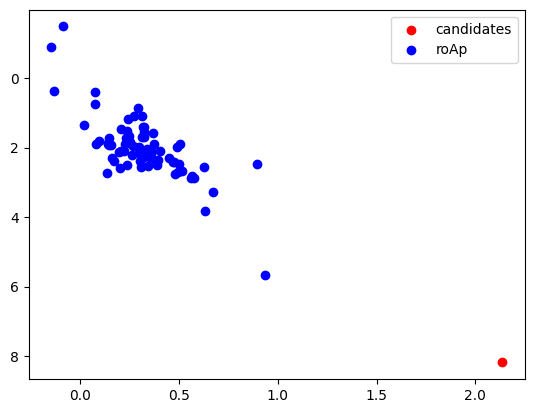

3.8567100000051897
3.961397980581951
1.4247433755460492
0.8976380966288349
2.700460214463424
0.5467344504520724
6.32048932211276
0.5265160979357282
1.4475697686999685
0.7001331127608617
0.7261019561673518
0.7930780584230503
2.3090741279378633
1.3462904968234874
0.6235094641530843
0.13531249762066677
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


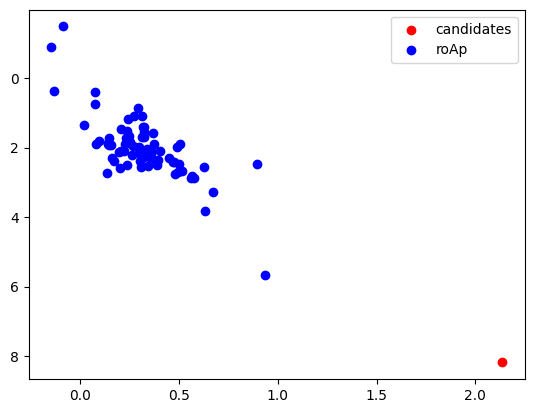

2.151054926075044
1.0890952100416889
0.21290090086365243
0.9109510190143193
0.9666163240952348
0.6150687255704956
3.148912056346814
0.7054237026958723
0.8282345472264843
0.3513656673784422
5.750056532159151
1.2397698282300227
2.5662797884254167
1.3506578269463092
1.1172044947356103
1.5246663672793832
2.0705376799072517
1.3461487228448363
1.5457837742944869
2.2026606543038656
2.4161930135631953
0.7232388133789929
0.5465200605331373
1.007443772044692
0.8174839301624659
0.9037827883376672
1.8982684642390875
2.26337449618551
1.4465696524544067
1.84963653166001
0.8859849671641382
2.7753825753273937
0.5511390349048253
0.07254466199954779
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


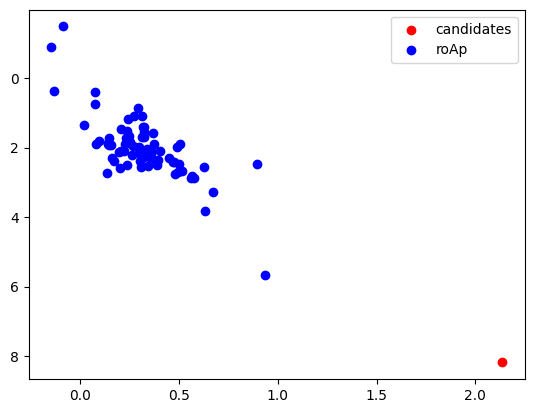

0.32329520219679253
0.5806418540718252
0.21036012554486727
1.332797763538251
1.2016049647576614
0.7983686483580619
7.622558831549556
2.035343154182718
0.5915584504279225
4.164373365284687
1.2345622279410517
1.0305771358781697
0.7804428848135552
1.3373967730896
6.604268958842507
1.4696061950341712
0.9600774315677145
1.057092327787752
3.6935177768725818
5.074116238874144
0.49961362101129536
1.5099434035024002
1.6135793993048257
1.123571274758386
1.6577990490361425
2.511361390158856
1.2436772573977097
2.5693815264461386
1.816129462071609
1.5362123017846119
1.8574410162896302
1.700953664976621
0.8224840563363389
1.17327091643905
1.1936172113263717
0.45426591266343896
2.1020564558926256
2.374514921741834
0.9349012302916884
0.38253519527006663
0.6193150291261778
2.8443435132842017
1.6461147984541813
1.4916952724883203
2.0936502963292196
0.4383603464303949
2.065613627575582
0.8309290354120165
2.355012354922579
1.861459098318703
1.2060310792130955
0.37078870245357587
0.6720134543611844
2.52009

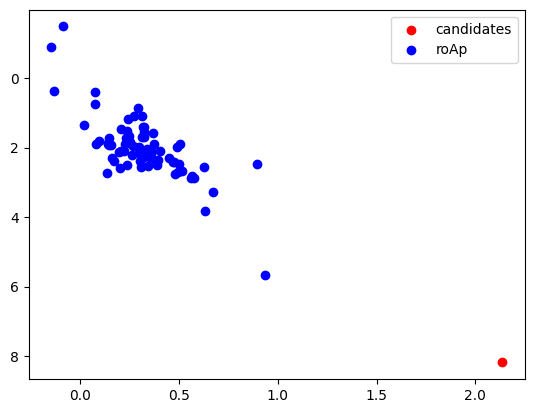

0.8373945294080811
0.9638742078740168
2.2408116861685534
1.3773459139518072
1.0018427535282046
3.078249830646199
1.3972738027070135
2.1628325400087998
1.2078645498209695
2.0750709893221537
2.273409327552439
0.4886512893390891
2.373028023916962
0.4348117564710403
1.3688575473335334
0.8761887310295733
0.2954168143402254
0.6429739940512378
1.5779292131182454
1.1187778401084407
6.6383811612666115
0.8398911345930986
2.180862040610855
0.38449660824891785
1.3556717847278557
1.8673928580105197
1.2466821741647194
3.8306270458353953
1.169401524192463
0.9452119112209103
0.8084207692345813
0.038162743225816254
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


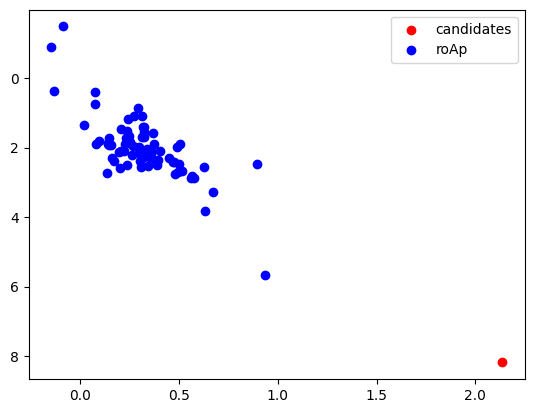

7.308131810117848
2.645258268239562
5.306227905140538
5.661848912125043
1.335837259324443
0.9339149456537998
1.6635080451032684
4.749550649017959
4.32379647532634
1.254050963152633
5.679522248829514
1.0485271047361038
1.4589420255181111
1.1747024878332284
1.7490357911506877
1.9176430886873645
1.2794050826088348
0.6950127426110193
1.430339043441042
1.8510750188580256
0.5214952243503457
2.665715215988269
0.8736022203946789
0.2505367053425118
0.4982435092604742
1.0128104358219052
3.61665899093436
1.0076927409828103
1.1860029113022583
0.8779565015009994
1.896480728947323
2.33831760446099
1.196518391035831
0.8850236704308494
1.3819552972089109
1.6875577529450978
0.19490676187195066
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


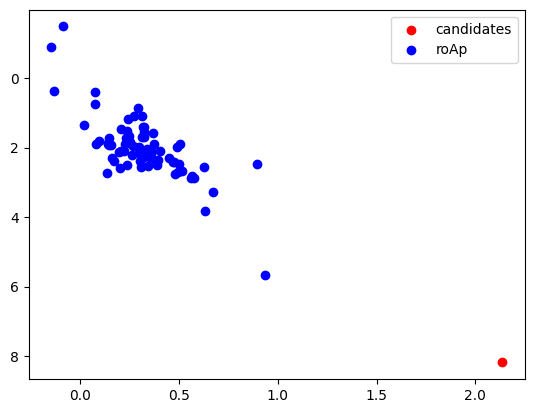

1.709916546748874
1.1989051259506347
1.3704716049382122
0.8855942242473698
1.4279557664281568
1.5144828461299675
2.314219485992305
2.149478122800295
2.5777703964999525
1.1282317439530938
0.5674499582534822
4.128065395142459
0.02437608827752369
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


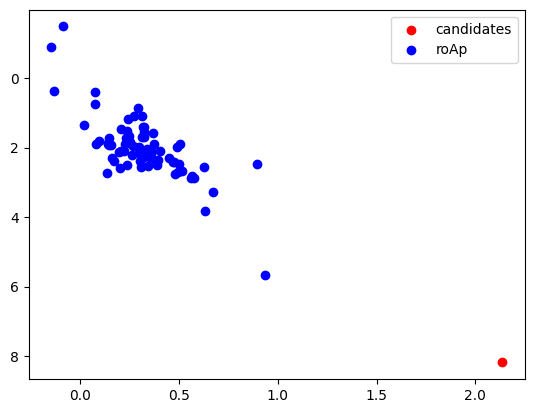

1.771221689858549
1.185342452035861
1.7573174662450346
1.5279894110228764
1.8558676709167998
1.446369094143145
1.248881399784763
1.3033156917827609
1.6328053339706154
2.139125164456883
5.256862897354781
1.6117017585631843
0.06021802425195277
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


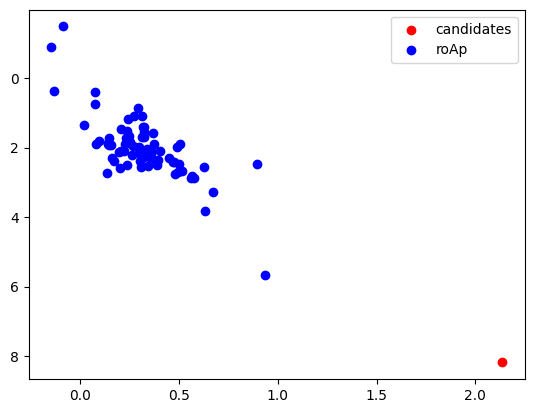

1.1514515553345288
2.721646779516894
1.88089596500151
1.2034376527743649
1.0053344518745244
0.971848129697634
1.3851780617967742
1.1648163462487875
2.263882807767502
0.9303360171683512
1.2658182033806331
1.621418462953629
1.2207928625023503
2.079638877756238
1.290248280433476
1.8816428718158646
1.0287755689787317
1.1755773370185607
2.2711824387170485
1.6651678380240562
1.2324701972804752
1.699573962111216
0.4218999507080796
2.3425258710955705
0.8124595986751646
2.3245655285318807
2.1319534758783125
0.616276315931156
0.8124699723809194
1.0186231689465806
0.6769167592813448
2.6261464443370754
0.7761308811214254
1.9314781542625128
2.033389439598874
1.3905066886528856
2.3434664204173505
1.12934173046887
1.155258705346586
1.1549371204681829
1.8963389549686718
0.5706865544490181
2.4009851609264783
0.6149476990033551
1.3453464895997889
8.061691627763107
0.34975774298642914
1.749859554398416
0.9383237705996419
1.9721361650179738
0.7381181653334701
1.5963763372612454
1.1495116723583583
3.476679

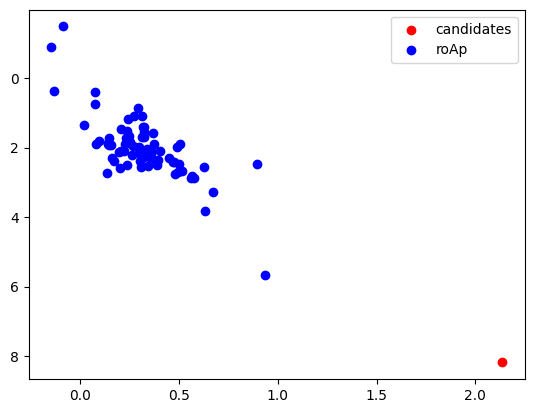

0.9400630952645508
0.045704427309644746
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


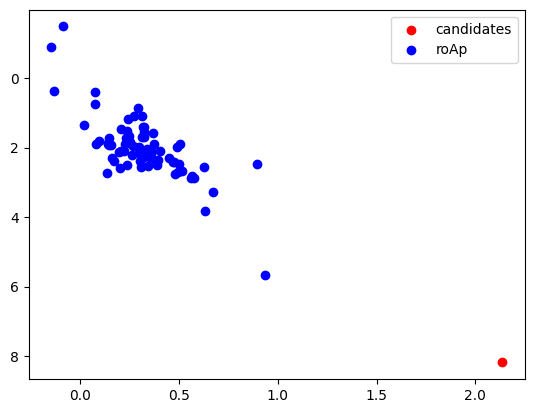

0.9555483626459029
0.28645393256797247
2.756128977446257
1.9814033421590378
1.4533886350373089
4.293083390487931
1.2900969153402417
1.354800393444442
6.359916319785302
1.368932838584565
6.23872377335246
0.2691540492706799
1.449488121673458
1.0572029806491376
2.6845849867564735
1.129528457172459
1.0858759033557441
0.6553014143900042
2.0672837942021247
1.7260545750016152
0.131913380034971
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


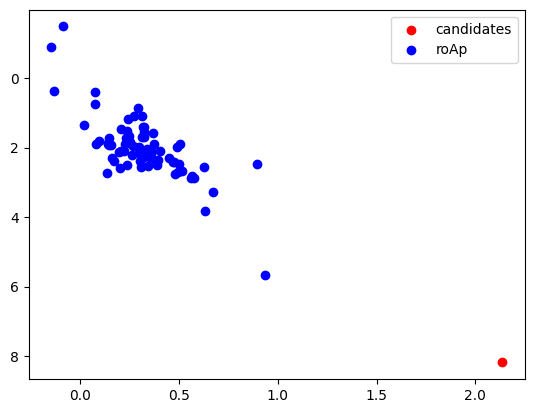

1.149369898379708
1.1432701593958137
2.3150701298642082
0.8848576911387709
0.19647319144094388
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


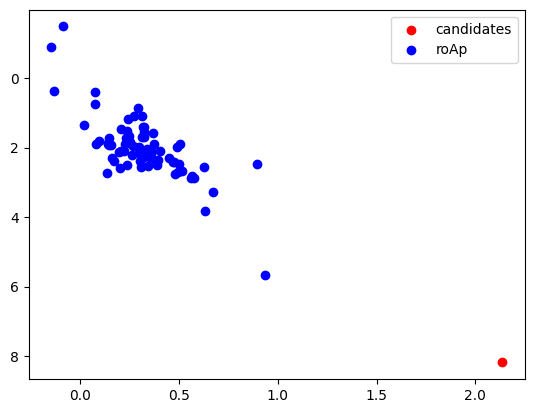

0.9910049063250574
0.8549018868204716
1.7601771511314745
0.008566560707021331
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


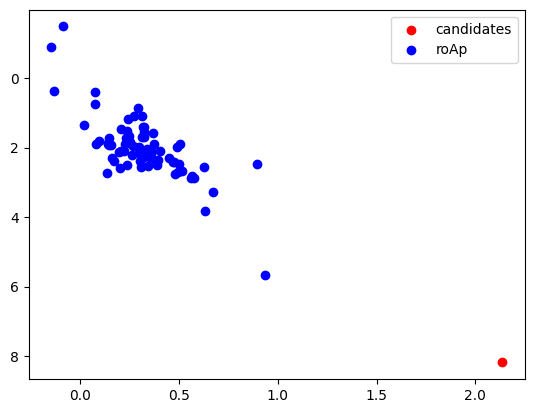

1.6227601288979314
1.6072963915192608
1.0887252145364292
4.975863413767351
2.2137812668731427
6.723210411126532
0.8016440640658697
1.1870506555835054
2.3165743171986724
2.0604198588942837
7.942511580246718
2.299111912511219
1.1128924910434814
2.09879911228558
2.062556842279798
0.7022216855195196
2.569495637209442
1.9552166509316948
1.5201849263932563
1.1573611097129164
0.3075928695857577
1.727461941082367
1.0595958487766066
5.387965790685493
1.1606572728322346
2.257509894532061
1.994377390156528
0.6771000280830148
2.2337022398245128
1.0482608462883944
1.0423720393215166
1.043461278425784
1.6474357169869749
1.1418939144323272
1.4247260860364581
3.0496598975856313
1.0396230072964623
0.8939969259088572
2.405649870614275
1.8728113903165071
3.254633949597149
1.6218437848895806
2.8561003798064477
1.1332188211104641
0.3232537073737727
1.5295558405918697
1.3779545046894293
0.39335229506170366
2.229372946622792
1.3519165032445737
0.6300794777978687
2.557299617143572
0.9547730100250313
1.0392426

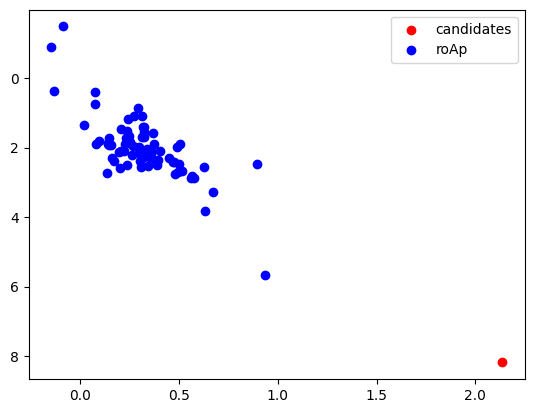

2.599364993979784
1.5493557869760992
1.014650039642445
1.391308921897933
1.6460698457292433
1.2373631284948803
1.7163378706111714
3.052529956177827
1.2020691062058861
2.6167720722365435
1.0637799100977587
2.0141946260503487
0.49847173078708273
1.6840998510267897
1.2656902610096563
2.7228051766595267
0.34631791316888405
2.0297206056635493
0.41796140042312757
1.2008857211586537
6.709271608493834
1.466193245840802
0.7556712580619707
2.3150701298642082
1.1338439187665066
0.6540358222879035
1.29453262091026
2.5301827503002037
5.410888222501955
2.648401501083303
1.1596433249789997
1.3346304515549536
1.0832133188786472
0.726862694589379
0.6483026209073492
1.065014381082594
1.137336399703997
0.9657553065175759
1.5526796133107634
1.0769925533276123
0.902807659996705
1.0049402510558374
1.3490948552792346
1.2197796972402863
1.631699587947928
0.16750556448011045
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


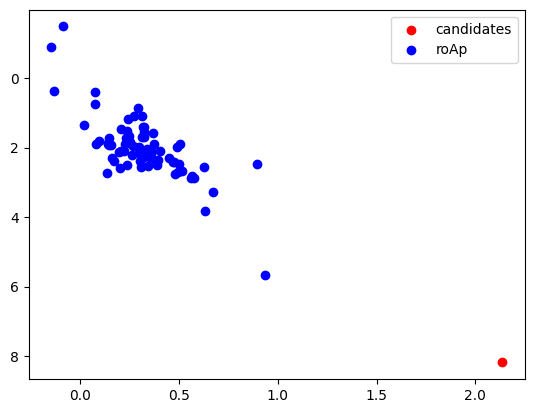

1.2667137999774751
1.1463822711222904
1.244016131785704
0.42028165261031214
0.9285379081708318
1.4595963515718422
1.2860503875046505
1.961720964440031
0.48520030322461816
1.247985803187921
1.7151863892723749
0.8755835981938689
1.009999161562321
1.663860751098936
1.3088068400290331
2.194172287685592
0.7801697105620087
0.6709380468645909
1.8137227623364676
0.3688288546570664
0.7616353562798799
1.374596881926753
1.9791453322063828
1.136752014279803
0.9115250307327583
0.9543511459909975
0.5406762062911976
1.3675470025064946
0.5830416380031314
1.0581158667555708
0.9177803753029772
1.1115335355895861
0.9800710204593694
1.0249061767321455
1.960386214299565
1.2172415972322486
1.4554530024825385
1.417011506856714
1.2987201401333297
1.4425239072099871
2.049645036516838
0.6754817299852474
0.9083887136928532
1.1411470076179726
3.1011584308549858
1.553301253064888
1.2468170323395333
4.542263260623093
1.467386222002618
0.016648460081277516
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


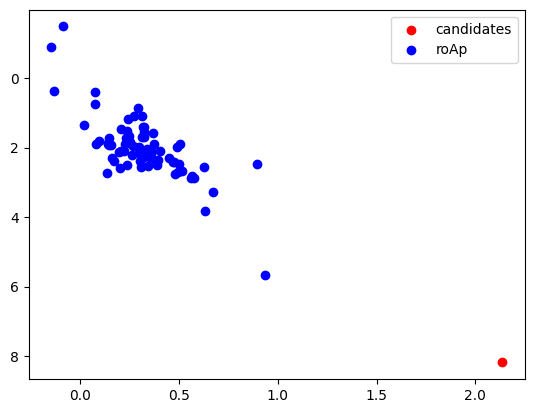

0.6752120136356194
1.878880008183137
0.7797927992529128
0.671049482317148
2.33112516847091
2.309433749737367
1.2836575193771824
2.598915466730404
0.03274421091982793
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


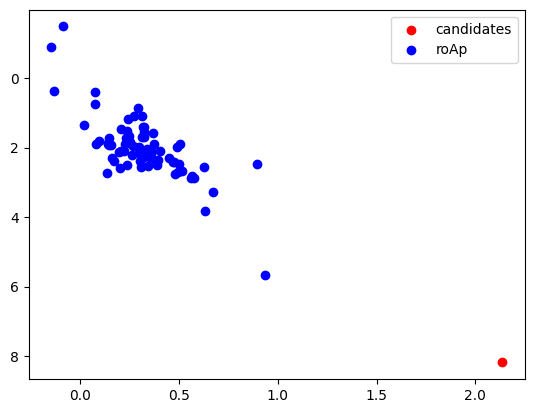

0.8344034442487449
0.17383352499061333
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


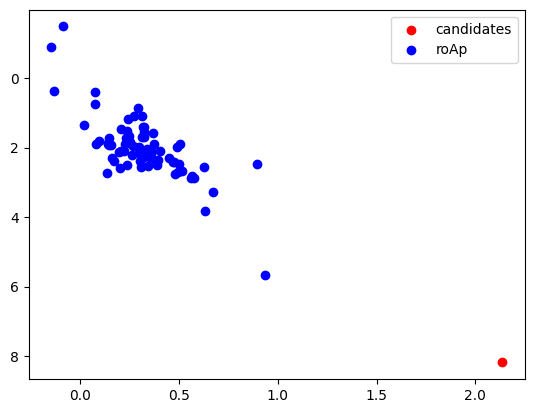

0.07482074405296535
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


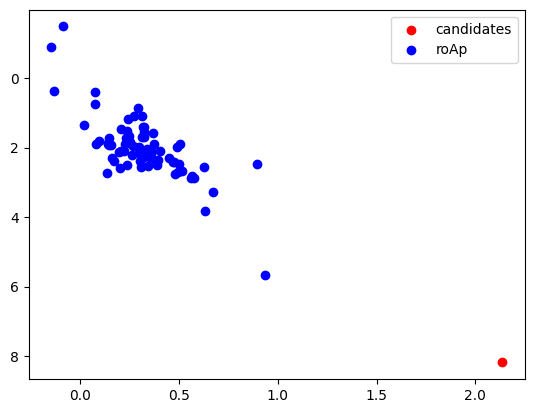

1.7702500194195046
1.3505125950657404
3.404616987401821
2.6892704438557806
1.584460407250757
1.8267175577454675
1.2428196977219694
1.4954609276773572
2.63287897937202
0.5259213388057793
2.271196270324722
1.88242781555132
2.381333904324736
1.3481162690363537
1.1327443059564852
1.1827282781856208
0.4876588714885348
4.976817794696805
0.3227895659255484
5.584391909154954
2.3554203873489388
7.722374628323422
2.5240000216702705
1.7221160247166636
1.0045391344333132
2.4425664314941273
0.626818676288905
2.020581370893463
1.954542360057625
1.108774129858777
2.0280435232331704
1.3309028332870185
1.1453967690755724
1.188668953681273
1.4146393861407547
4.34602386885722
0.22103042827359332
1.488061017572179
1.3875398088069777
2.2476825372802307
0.8288223905525967
1.2811643720940826
1.6777649747124506
3.324044414803337
1.1189887721254572
1.3293329458161067
1.0551731922230911
1.3024381672866814
0.0339932961035081
ID: 97 --- Gmag: 8.181364 --- B-R:  [2.13485484]


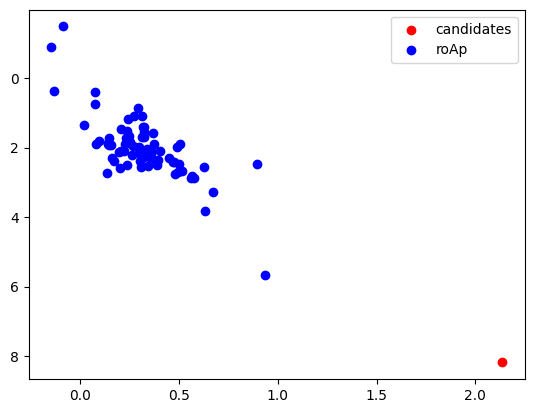

0.2854649726193368
0.9400561794607136
0.5839026555807894
1.1183913376847612
1.904869599001136
0.44877476441716624
1.9965766157765716
1.3728437256541706
7.963456092165908
1.1001397487687625
2.0993973293174473
1.5176399105813823
2.638428911950904
1.287990270480822
1.2026319616273988
1.3799047613713546
1.521091679287024
1.4626760140427444
1.2120422408854237
0.9652172019566296
0.19582365142744118
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


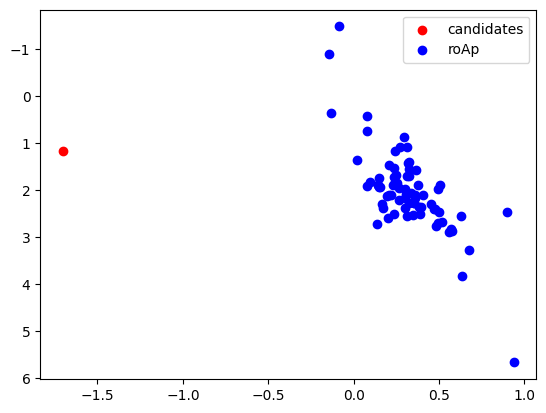

1.4613846324107458
0.06884257718335052
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


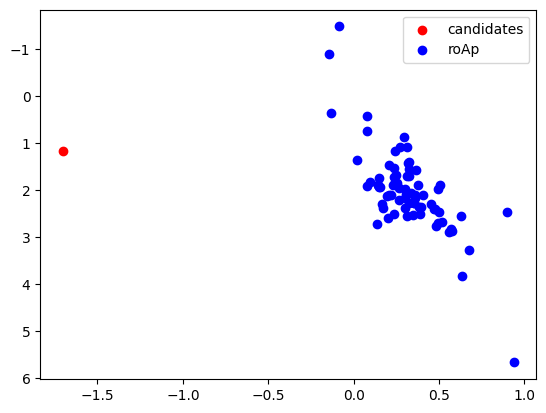

1.2694607022389208
0.903701126829938
0.6130160599693304
1.1896834470816469
0.6740307393178675
1.5051305495792549
0.16004286659326405
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


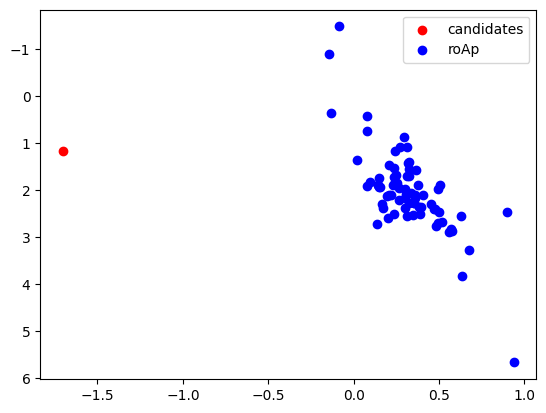

0.5470877019948781
0.9573885120135812
1.2268800980168815
1.5128209234455707
0.50703828197704
0.8367596035934217
1.0117432722674577
0.47786396349227944
0.0754022171223796
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


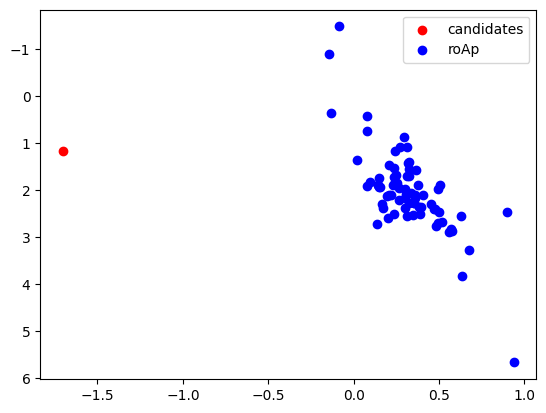

0.2642382408811561
0.1903029662803739
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


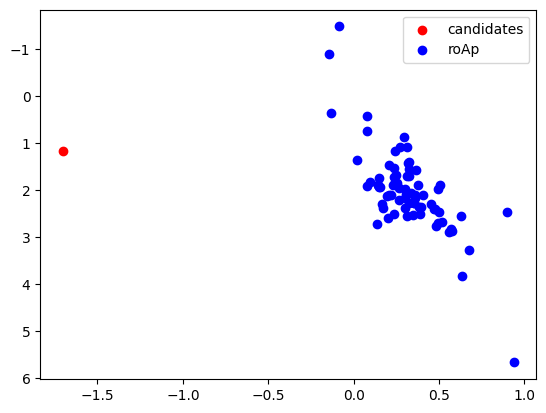

1.0863025534300057
0.756996180043821
0.5709645147407922
0.9844638840339295
0.6906701633487637
0.04329905571281234
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


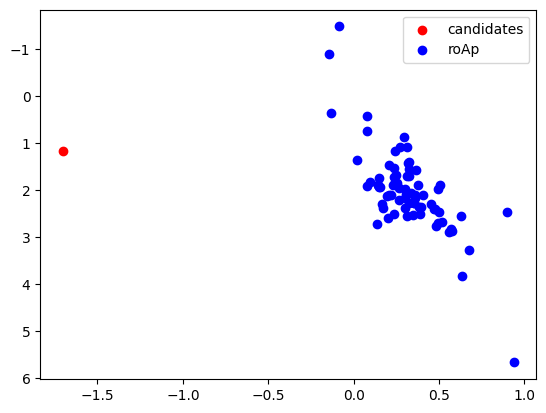

1.3177311393330462
1.2805121567698319
0.5354656936474469
1.2415519758562605
1.7098936695737557
0.7422101914411379
0.3718688959903971
0.11500556779275639
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


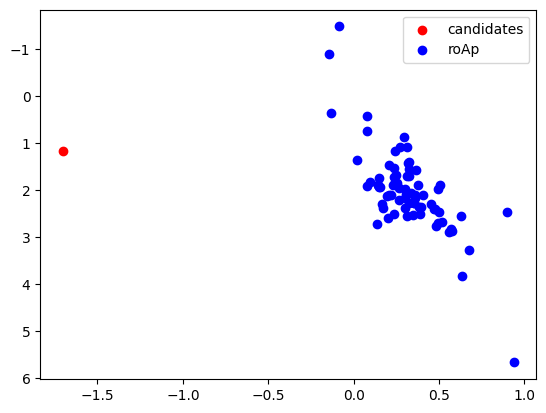

0.028782783459757155
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


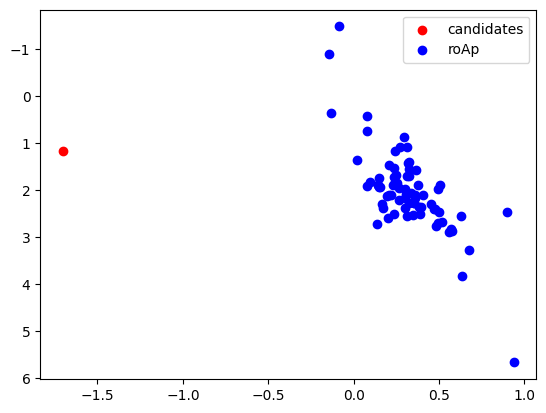

0.14433894976575923
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


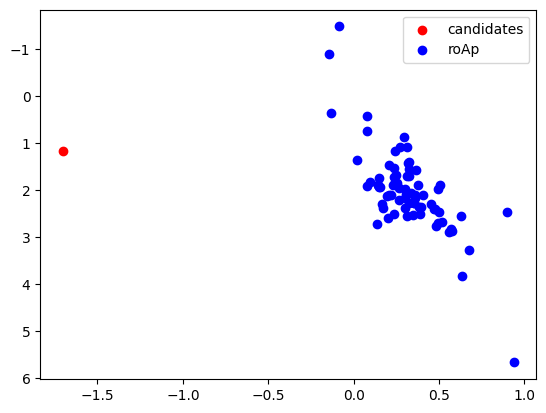

0.5477585349670302
1.0649361774767832
0.5519061435835506
0.6175044166592936
0.7168499387722702
0.4289623145635737
0.7928684545443438
0.5832919350795587
0.004361206427220932
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


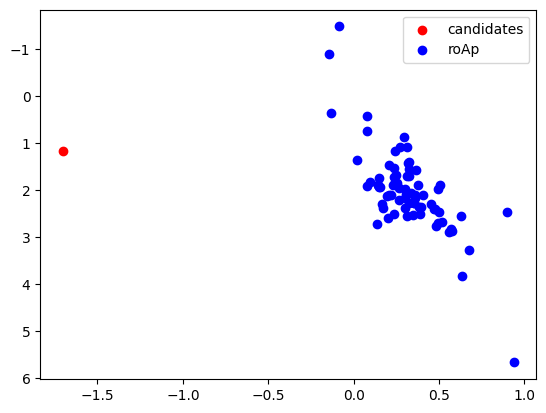

0.22034017602824152
0.8366109138109346
0.41458248470180203
0.2221917377710061
1.556670577671629
0.3905224031542187
0.13730903516584014
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


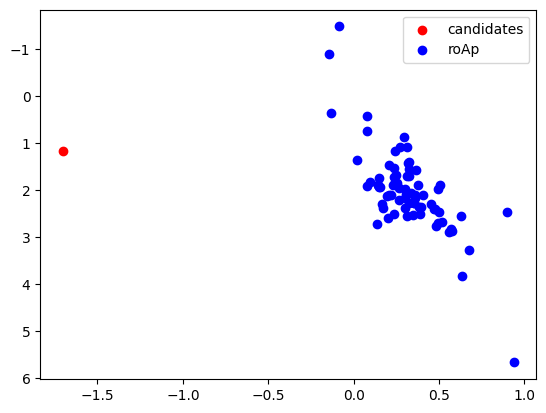

0.6634633910555197
0.6991731441658819
1.027079067275152
0.8654221525942734
2.282332042639982
0.9588512045250255
0.9748854957202173
1.0965898116369706
0.737344923442079
0.926118704966326
0.48729711992542235
1.2858615310374537
0.7066249227998347
2.2310202360742157
1.0602472624755581
0.13626820668842976
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


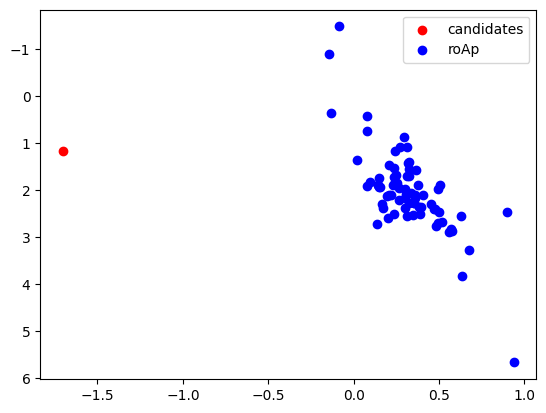

0.7305708935841146
2.072005158458924
0.45980679967487736
0.6661882177671461
1.4403398413359259
0.9352475660306578
1.2913665108913994
0.5441519432662356
0.7216425908310444
1.5187927200584879
1.05174428165844
1.512979986933813
0.24545837556282768
0.936924648461037
0.41886524096211586
0.29570514833775485
0.6494208513652726
0.8540179920676949
1.2663278431009342
1.3073662230674084
0.6535841652749146
6.543499244983028
2.505895775364321
0.7503362609491606
1.2950161816316839
0.25063989685292265
0.00784518734440498
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


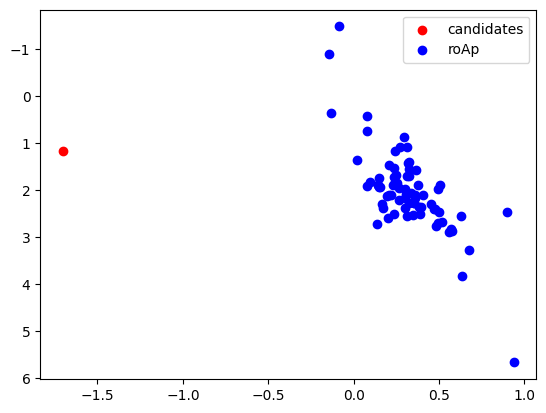

2.1159566760570834
1.6290495069401953
1.036147270321424
6.207785379342221
1.8190300962339312
0.16012772992475144
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


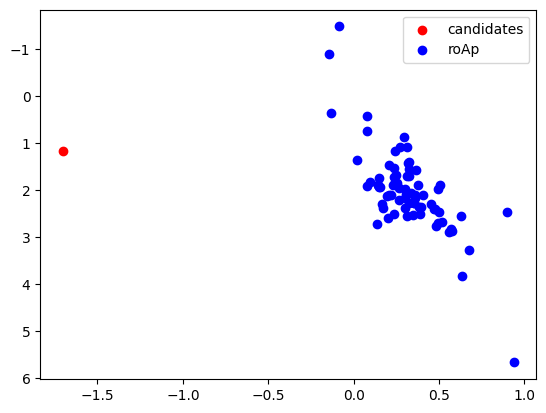

0.46503327368990943
1.8065712756222685
0.3410105792714204
1.5843664983518244
2.6351226121698637
0.19334591996848483
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


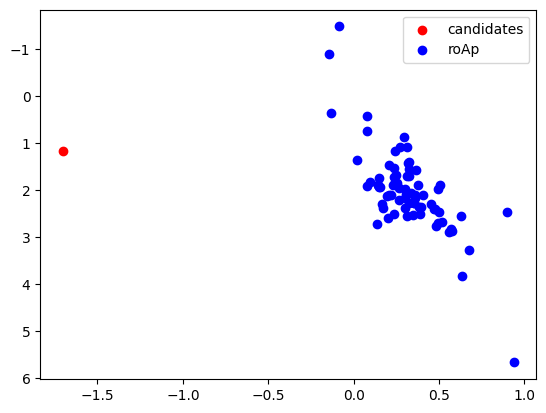

0.35160025916174886
5.178727600061563
1.771176191586473
1.9880903789219064
0.6312684505106279
2.6420799108294983
1.2305021055418197
0.9833796870480511
0.645570332844748
1.681101304516479
5.598454650709572
0.5195021447070904
0.581725505510565
0.287046561934313
0.39384198899579337
0.9598797856112324
0.8170061941506002
4.400602847188649
1.2391676077490978
1.3029228191023832
1.8081688263085272
1.2437719488878138
1.3030488877879125
3.03728352107287
1.5922090199025463
0.8605584688116843
0.4496836470745422
1.9565335660154317
2.7716647852180745
0.025990382926234457
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


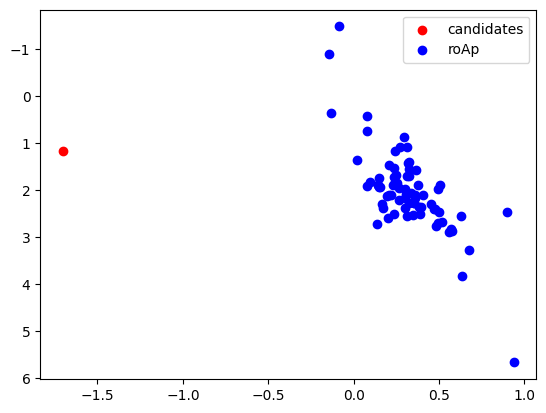

3.984319866851273
5.387536465300483
1.466963812421446
2.0289454900867097
0.2731612120468596
1.2024031945536522
1.1103280559584066
0.8644658979793722
4.299735848231617
2.78840794630652
0.363948426912025
0.15576039980192924
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


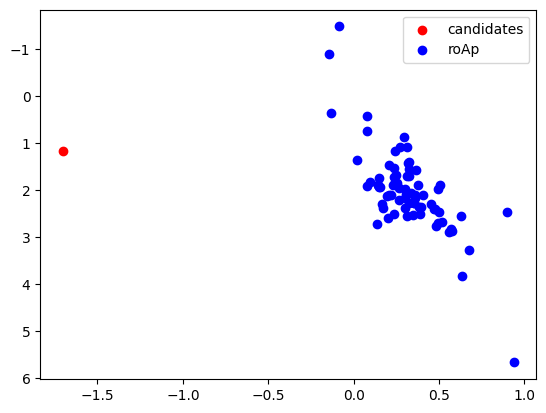

0.7359011046566963
1.4111429017542068
1.8402097454835649
0.32548618387468986
0.7726620599502243
2.5555251679123416
0.30787854730666764
0.33841182124532354
0.8803514993920767
1.2713226376874407
5.2471594790248695
0.16659904863037545
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


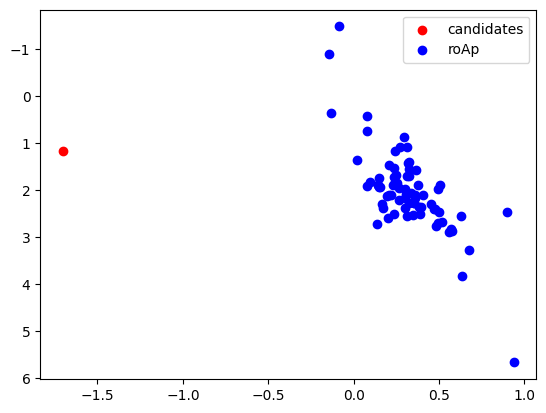

1.9907513791825329
2.2174064762218393
0.23244441695878804
0.8244510569807173
0.23632072500921053
0.06380787199029436
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


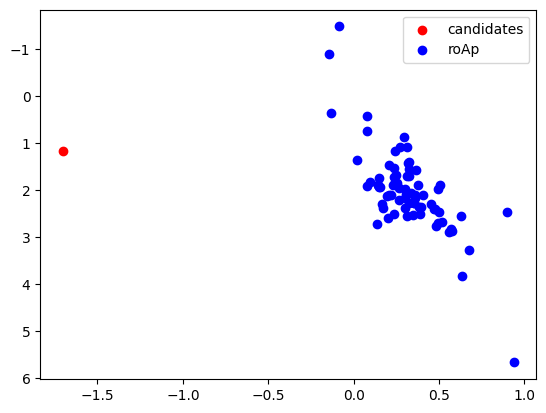

0.48429724527680085
0.9343796326491627
0.7305033197622186
1.626857197123988
0.9739154094976432
3.5239278896439674
0.7353755035651139
0.42595206620919823
1.217453857387575
1.3518087627379676
0.08973522057376426
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


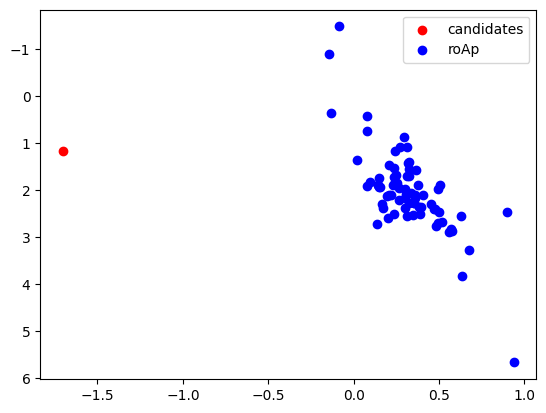

6.304464859076182
1.3861249813752514
0.4524241790792902
0.8991297804939353
1.3052169922906915
0.44310325972400344
0.5856294767763344
0.8912335167289913
4.21943299198276
0.42427152587690076
0.37059797230093006
1.4803235612173162
1.4356940053741911
1.2474458249415261
0.620351854154531
1.285586483100459
1.6301802408674813
1.1469472372732836
1.6113381333146237
0.24310354435646042
0.05113120355777889
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


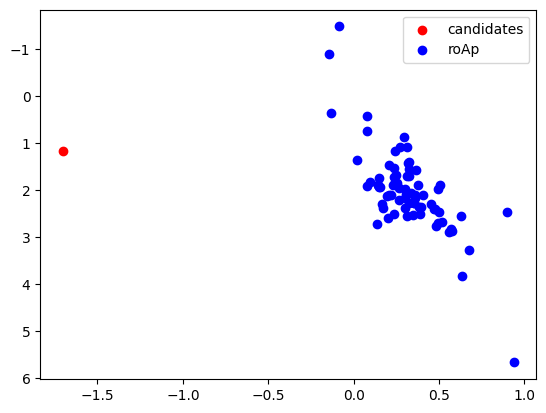

1.1626788173161349
0.2606816440236872
0.44385708234219434
1.3589977408261293
0.8300217369711107
0.6093211470351299
1.1020602124717331
0.442193831519488
0.82875614486901
0.4801131839556496
1.0839112695190063
3.9543294835137917
1.1915592141378393
1.4850071446311746
0.9050858718137307
1.70210114286636
1.1922922893445205
0.6642499190074456
1.5356412024209525
2.7649979503195774
1.0845751866873221
1.7856890059376087
0.7778350812200121
1.0677352043451642
1.8823892330830803
0.9203144718619574
2.066553631350223
6.027649436809908
0.4718902931939142
1.444577355402323
0.8506100849927134
2.0692023842196465
2.1868713285977353
0.031868816187357485
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


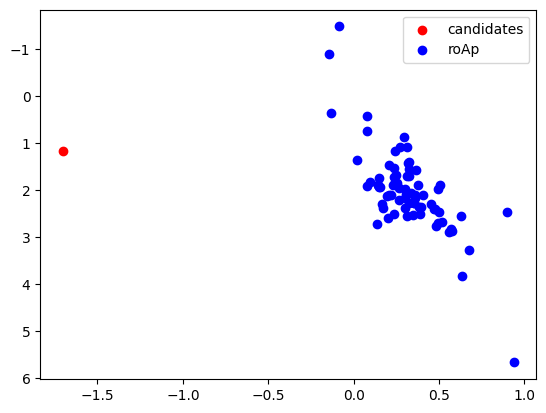

5.8891224280605865
0.8370205304537648
2.2441272685610723
1.288204114852618
1.5660569076943855
4.265682430140124
1.5163806887359796
1.413515022470166
0.9225828555203672
0.4564092663056507
1.0936625529286341
0.9012164795671445
0.04786694414689663
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


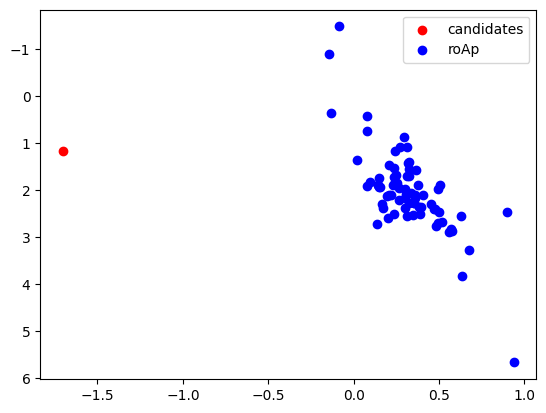

4.374488771901589
0.7406418881866963
1.1682080024835089
2.0673316592818423
0.4162215302110801
0.4719075827035053
0.994702731614038
1.252969967990512
0.5277165354485196
1.073707000958081
1.6920474377733703
0.37916665325449683
0.6657402747342362
0.8508279328135671
1.171531046227002
0.813852587601104
0.1253931051553523
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


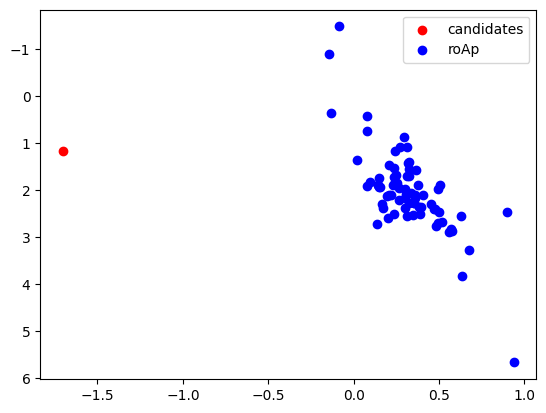

1.703894209745492
0.8832284737881086
1.340370023192206
0.39507991788254815
0.5318053597324295
1.7734134541276174
0.6943009603629866
0.007720702875345875
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


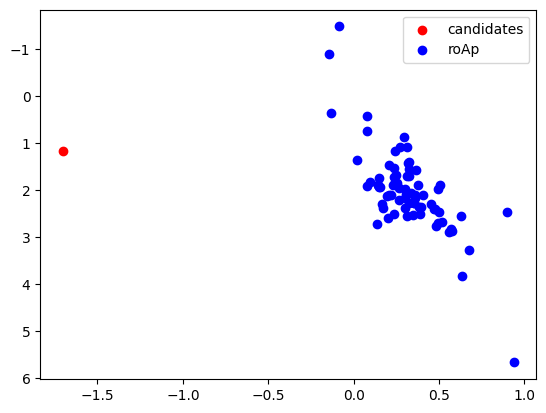

1.0999351870084442
1.9441750245593998
0.42599701893413533
0.3361729744877082
1.0323193728978581
0.44806376476030474
1.963779744219734
0.3535800527444688
0.564914770600224
1.2322725513239932
1.3182567404246286
0.4144787476442535
2.9209320373256573
0.2403249754306107
1.7562622606128122
0.17947973327607114
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


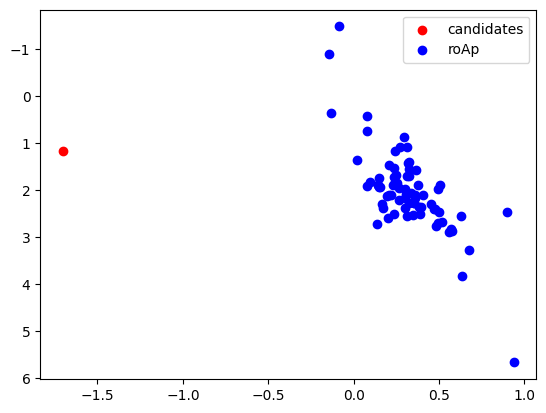

0.926483368884218
3.3040157013453606
0.03979086948220001
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


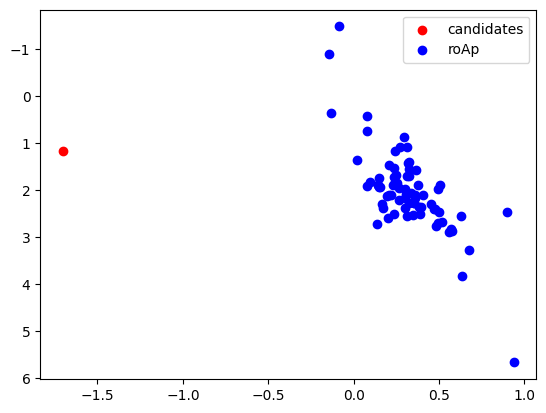

0.2954231845969235
1.9812575647313309
1.0454455685797535
0.8150663111744305
1.356985241909674
0.5198271874874112
0.7410049678881188
0.5052763362151738
2.2645219740752496
1.829588944475972
0.40431597390634755
1.4747198864242104
0.39350498829324776
0.6836003381422944
0.36566008836158703
1.537249126812965
0.5945040373151822
0.3188643017011308
0.2889811133231164
0.7362780159657922
1.5379149176667288
0.3858715250740947
0.3133558639452665
0.6701352680724049
0.9217702485695649
0.2164500363701456
0.7029196361598795
2.256060488081151
0.24685003635045755
0.29950350886052624
0.7382939727841653
1.2873223498634494
1.0779586361011293
1.1101878661962261
1.2938008738418878
0.3094848874822107
0.2980200689375727
1.6099169356261993
0.1066079082496576
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


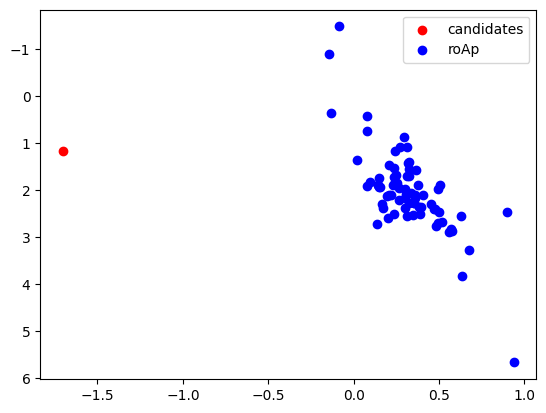

1.3127121394331118
2.632394327556319
1.4839836056633557
7.348159937177037
1.915503975538242
1.2566595493373462
0.5674217494909972
0.854718072471663
0.38599600954315383
1.1720946842396862
1.4226784625536815
0.42728681634966437
2.0031080469531157
0.5583585885631126
7.232430875775119
1.0755069836410494
1.9506309274408804
0.25925007262950794
0.3958475721084125
7.31754713149426
0.2618919096950951
0.4912372544268444
0.43987545301775244
0.7660436356785838
0.4804470162252552
0.5109403795573617
1.0635995536508687
2.385111261357838
2.7252650730617534
0.5768706112172617
0.9554363816462073
0.5823564278761668
0.2434267134513326
7.728836901461598
1.9591269924541614
2.0521222224286557
1.6523265184377713
1.0981958623435353
1.5695528465337945
2.1849694825426655
0.5656270983953955
1.654029390398049
0.4276794329518814
1.7312408823319383
1.6655753249032776
0.8141983777929354
1.1330895506011776
0.29191341414984207
1.7797275830304469
0.9917201464750085
0.17728050765602754
ID: 98 --- Gmag: 1.17121 --- B-R:  

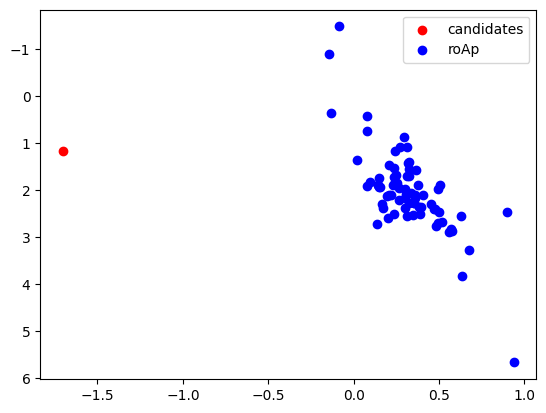

0.5369195966696059
0.7754145498771972
0.9684104296436975
0.48906569202214767
0.7403410507198038
0.8482379642767541
2.3953205720371513
1.6842272478506284
1.1380638872451514
0.07858161320177448
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


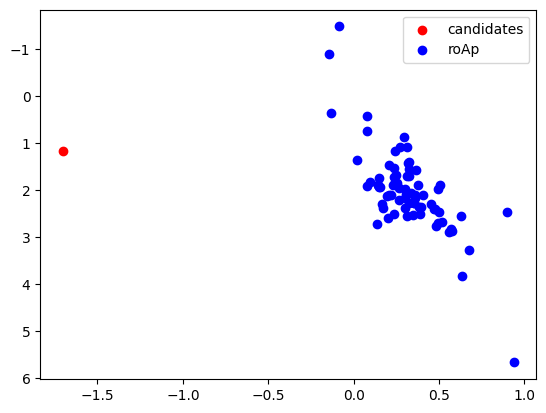

1.0045992469042344
0.8463879867504605
0.5989647307897985
0.5929860183730447
0.41895673062846184
2.04206131206285
0.7504865349481178
0.8267989723832474
0.47305214823846553
2.121506608635967
0.6371053889487315
0.6544536828728797
0.7767181789003987
0.4661070969700334
0.5712703943260737
0.8813596225357527
0.3983338035876751
1.9237130346923041
1.994686471565567
0.5833834247459051
0.3328722623721947
0.3438061482378836
0.648661697159715
0.2644680466242346
2.138279306625207
1.9203639119499338
0.6585858756652576
0.48930082935259245
1.3524035218679162
1.7532677175515574
0.7886583142243153
2.0463836894607357
1.4021004882378327
0.623578076644312
2.0326731083546457
0.6672582936763729
1.6091546129877012
1.1609325768473897
4.975140166719287
1.0744954025954558
0.5489565532472347
0.7142961334711111
0.13947713966861874
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


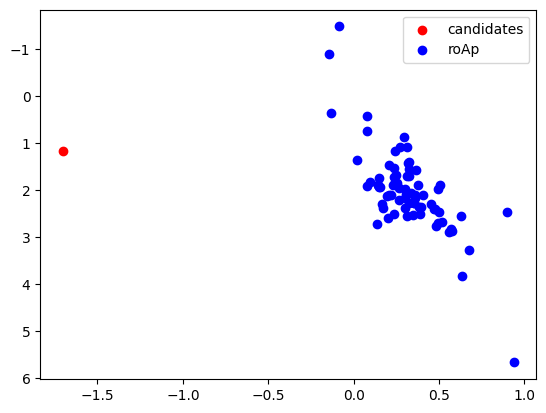

1.7165932098059877
0.40375233589366344
0.7796228165117776
0.1983149250250924
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


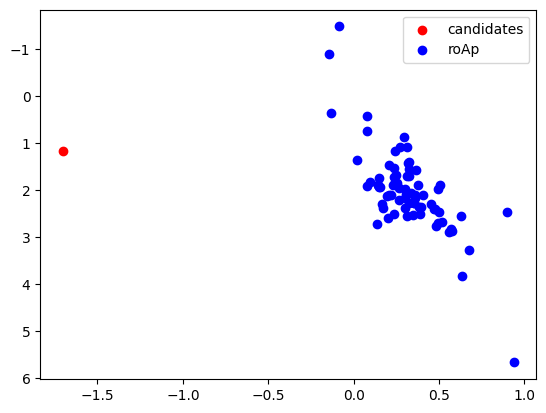

0.02791297639281387
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


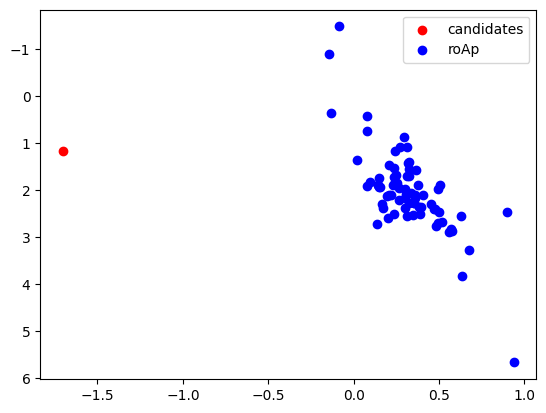

0.6033528083241309
0.14151038599658383
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


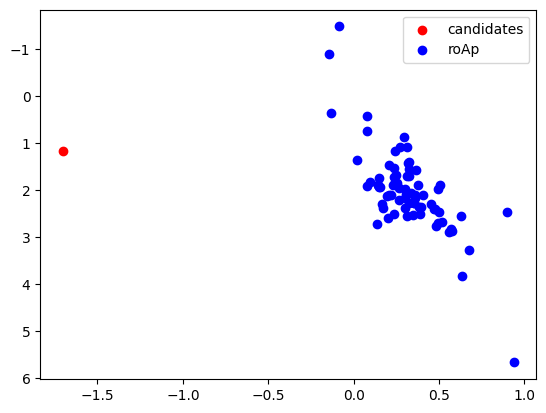

0.28883588144254757
2.067369696202944
0.09079492277723711
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


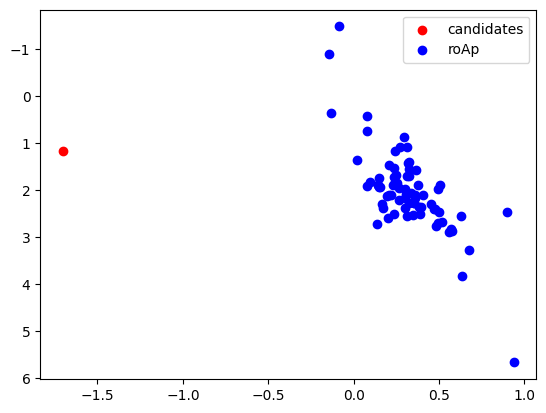

2.376395474838255
0.9695411635709843
1.4758040834100883
0.399130994714334
0.9606923925620348
1.0420414088756687
0.5253563726547852
3.8658037365032
1.300732093502646
2.909195918214921
4.9016044245245585
1.038495185723955
0.9206429725441967
0.6460025705845367
0.5102245938602716
0.6603909004666142
6.476550805942676
0.6198573741802131
2.09600112408653
0.4844270613332271
0.7520149275960093
0.312660825659687
0.8641512289048063
0.9000235034053286
1.278757126811802
0.9957416864060007
0.565174113244097
1.2630063835739107
0.563507404519473
1.8149151929511453
1.1390751788217677
1.0214857661878
0.7428964402374327
0.5721659909229149
1.2434173692066985
0.38152840026470036
1.4148463147087145
0.5687461259257085
1.7285748399529228
0.9579468184388991
0.06973284219282538
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


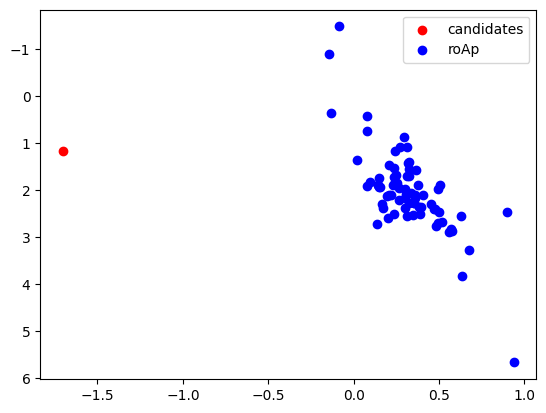

0.09976659403877486
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


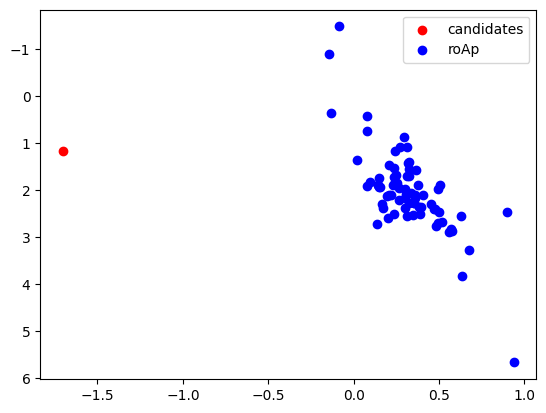

1.4427499989729862
5.571642079235016
1.289359054093333
0.2903331529731754
6.793630038145727
7.807279406478406
1.5531451019314253
1.7061157669935159
0.8424528943674257
1.1135869837819228
2.089908300906472
5.061601546284649
0.9055561464746211
2.13339141752919
2.108522186932722
1.8018081604642893
1.0367923137636779
1.4293729606675245
1.4206470899111643
1.1016606800656796
0.8301427635382512
1.953431827994709
1.397636336861297
0.7023214191280123
0.8368268879463394
0.3733799991286979
3.35405500000519
3.458742980581951
0.9220883755460494
0.394983096628835
2.197805214463424
1.0493894504520722
5.817834322112759
1.029171097935728
1.9502247686999683
0.1974781127608618
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


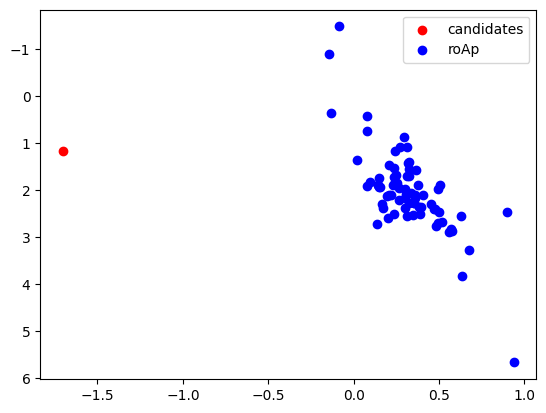

0.223446956167352
0.2904230584230505
1.8064191279378634
0.8436354968234876
0.12085446415308443
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


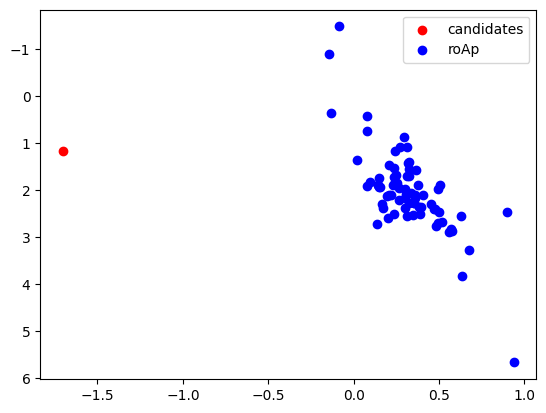

0.3673425023793331
1.6483999260750442
0.586440210041689
0.2897540991363474
0.40829601901431944
0.46396132409523494
0.11241372557049578
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


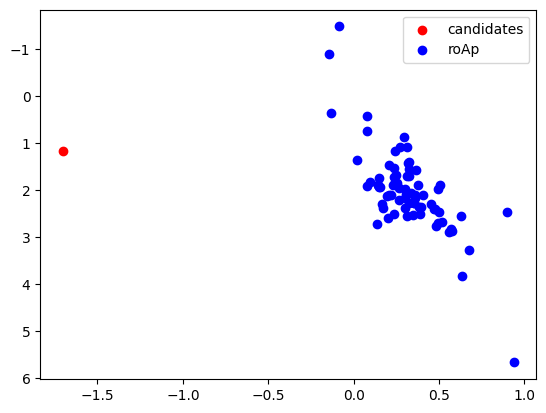

2.646257056346814
0.20276870269587244
0.3255795472264844
0.15128933262155764
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


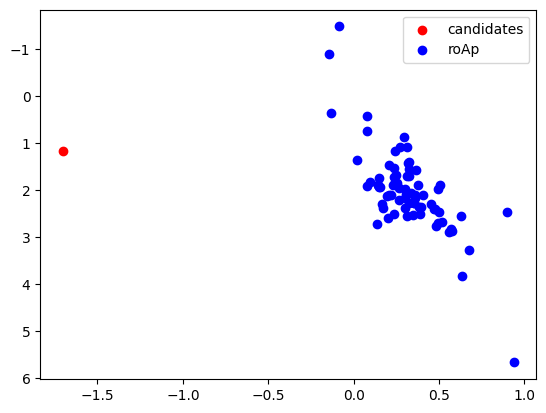

5.2474015321591505
0.7371148282300228
2.063624788425417
0.8480028269463094
0.6145494947356105
1.0220113672793834
1.5678826799072518
0.8434937228448365
1.043128774294487
1.7000056543038657
1.9135380135631954
0.22058381337899302
1.0491750605331371
0.5047887720446922
0.31482893016246605
0.4011277883376674
1.3956134642390876
1.76071949618551
0.9439146524544069
1.3469815316600102
0.38332996716413836
2.272727575327394
0.048484034904825446
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


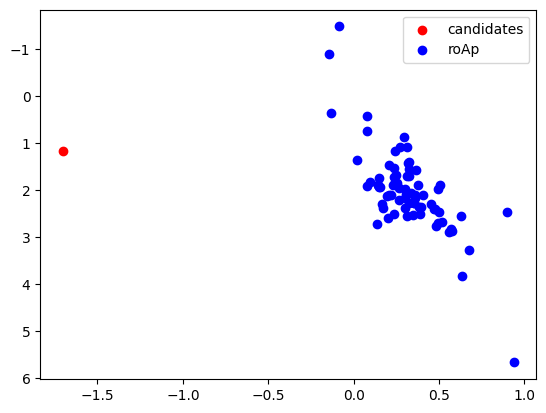

0.43011033800045206
0.8259502021967924
0.07798685407182537
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


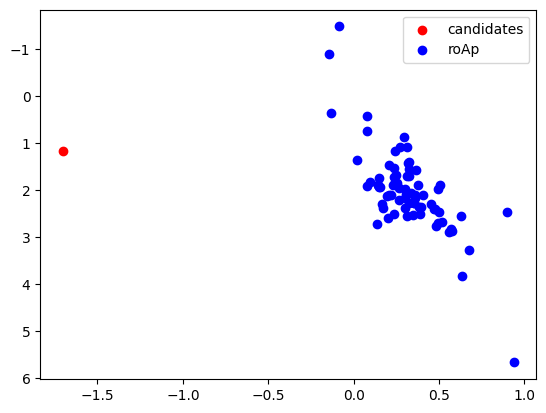

0.7130151255448671
0.8301427635382512
0.6989499647576616
0.295713648358062
7.119903831549555
1.532688154182718
0.08890345042792269
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


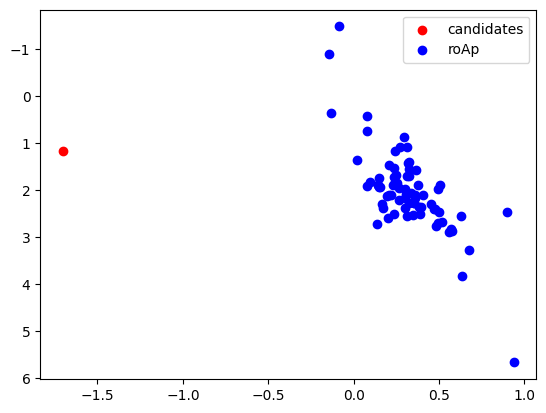

3.661718365284687
0.7319072279410519
0.5279221358781698
0.2777878848135553
0.8347417730896001
6.101613958842506
0.9669511950341714
0.45742243156771467
0.5544373277877521
3.190862776872582
4.571461238874143
1.0022686210112952
2.0125984035024
1.110924399304826
1.6262262747583858
1.1551440490361427
2.008706390158856
0.7410222573977099
2.0667265264461387
1.3134744620716092
1.033557301784612
1.3547860162896304
1.1982986649766212
0.31982905633633907
0.6706159164390502
0.6909622113263718
0.04838908733656089
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


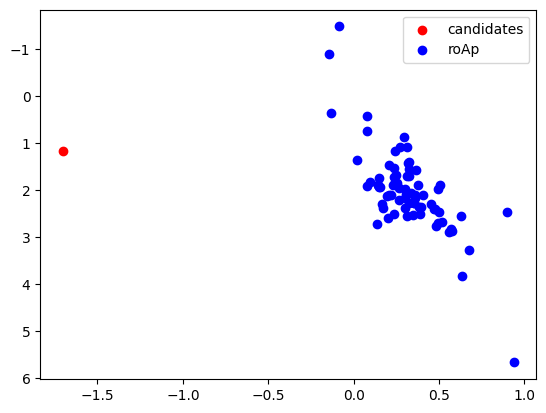

1.5994014558926257
1.8718599217418341
1.4375562302916882
0.12011980472993322
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


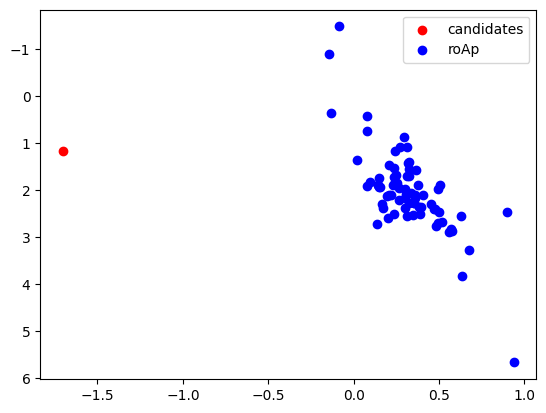

0.1166600291261779
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


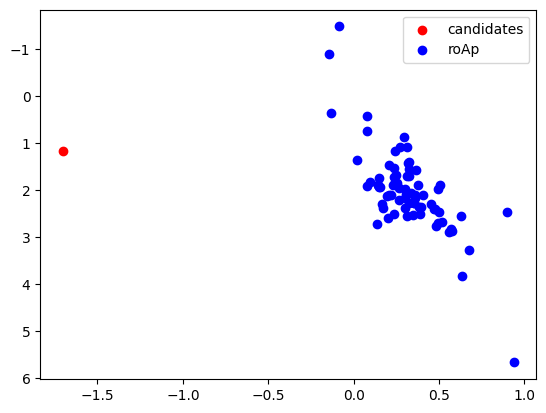

2.341688513284202
1.1434597984541814
0.9890402724883205
1.5909952963292198
0.9410153464303948
1.5629586275755822
1.3335840354120163
1.8523573549225794
1.358804098318703
0.7033760792130956
0.13186629754642398
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


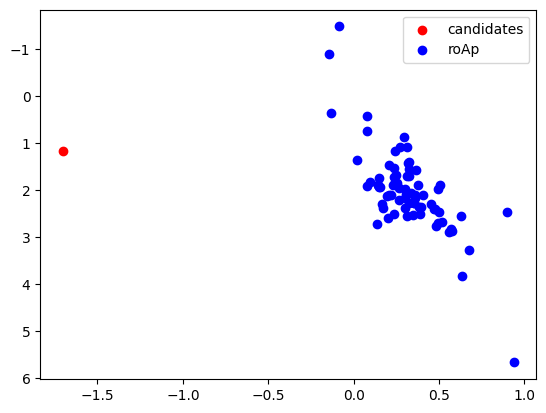

0.16935845436118457
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


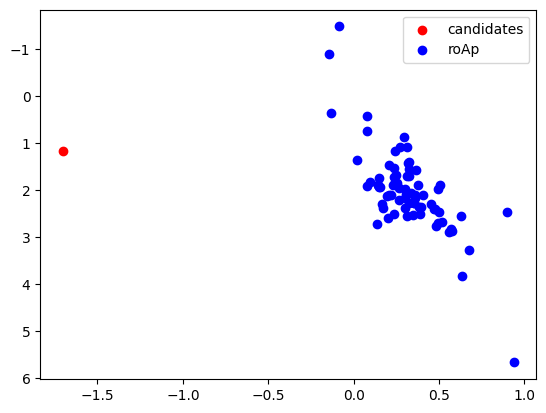

2.017444508306419
0.31307231598796603
1.364692905285581
1.178872171999569
2.0867235732397114
0.30051854780803877
1.6435484896836585
0.32515422529053195
1.9159135921810724
0.9708032977711665
0.5105930051490604
0.33473952940808127
0.46121920787401693
1.7381566861685536
0.8746909139518073
1.5044977535282045
2.575594830646199
0.8946188027070137
1.6601775400088
1.7105195498209693
1.5724159893221539
1.7707543275524391
0.014003710660910773
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


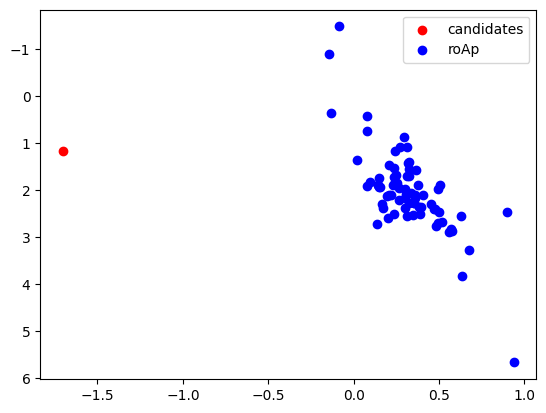

1.870373023916962
0.06784324352895954
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


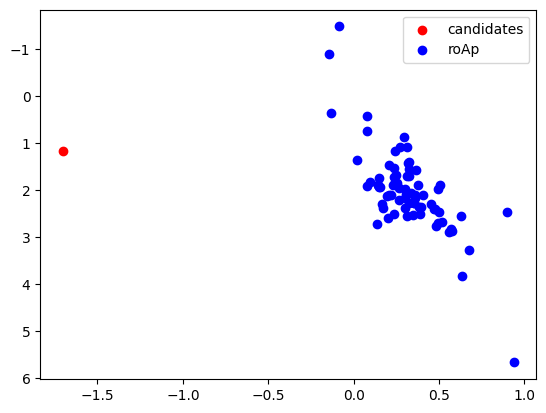

1.8715125473335332
0.37353373102957343
0.20723818565977448
0.14031899405123793
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


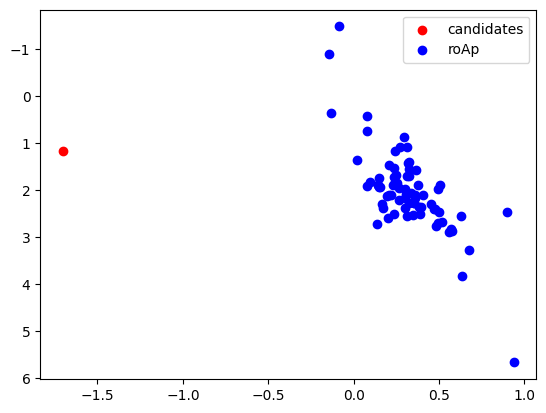

2.0805842131182453
0.6161228401084409
6.135726161266611
0.33723613459309876
1.6782070406108551
0.8871516082489177
0.8530167847278558
1.3647378580105198
0.7440271741647195
3.3279720458353954
0.666746524192463
0.44255691122091045
0.30576576923458143
0.4644922567741836
6.805476810117847
2.142603268239562
4.803572905140539
5.159193912125044
0.8331822593244431
0.4312599456538
1.1608530451032686
4.246895649017958
3.8211414753263395
0.7513959631526332
5.176867248829515
0.5458721047361039
0.9562870255181113
0.6720474878332285
1.246380791150688
1.4149880886873647
1.7820600826088346
1.1976677426110192
1.9329940434410418
1.3484200188580258
1.0241502243503455
2.1630602159882693
0.3709472203946791
0.25211829465748803
0.004411490739525625
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


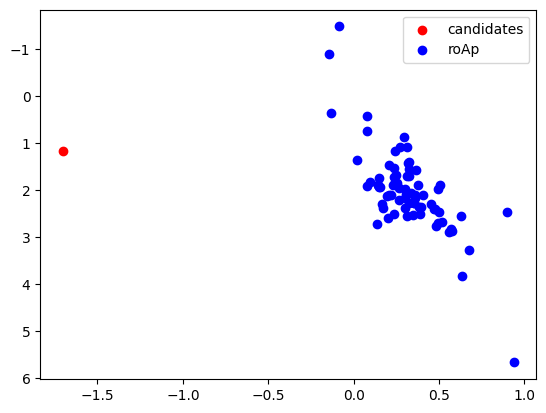

0.5101554358219054
3.11400399093436
0.5050377409828104
0.6833479113022585
1.3806115015009992
1.393825728947323
1.8356626044609903
0.6938633910358312
0.38236867043084954
0.879300297208911
1.184902752945098
0.6975617618719505
1.207261546748874
1.7015601259506345
0.8678166049382123
0.3829392242473699
0.925300766428157
1.0118278461299677
1.8115644859923052
1.6468231228002952
2.0751153964999527
0.6255767439530939
0.06479495825348236
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


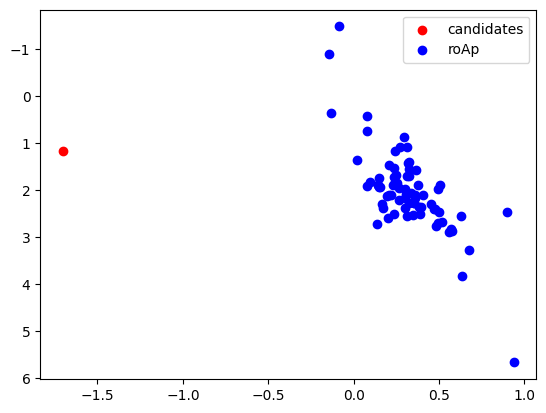

3.6254103951424583
0.47827891172247616
1.2685666898585493
0.6826874520358612
1.2546624662450347
1.0253344110228766
1.3532126709168
0.9437140941431452
0.7462263997847631
0.800660691782761
1.1301503339706156
1.6364701644568833
4.75420789735478
1.1090467585631845
0.5628730242519526
0.648796555334529
2.218991779516894
1.3782409650015102
0.700782652774365
0.5026794518745246
0.46919312969763416
0.8825230617967743
0.6621613462487876
1.761227807767502
0.4276810171683514
0.7631632033806333
1.1187634629536292
0.7181378625023505
1.5769838777562382
0.7875932804334762
1.3789878718158648
0.5261205689787318
0.6729223370185609
1.7685274387170486
1.1625128380240564
0.7298151972804754
1.1969189621112162
0.08075504929192023
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


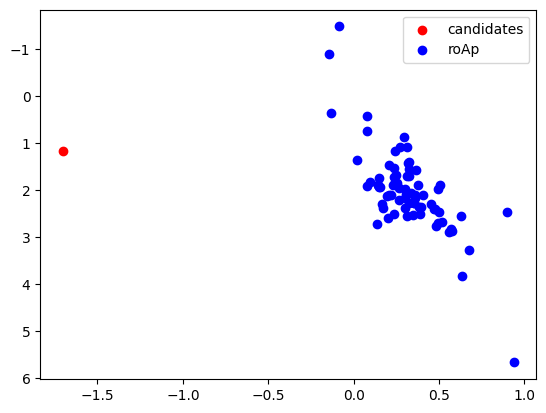

1.8398708710955707
0.30980459867516474
1.8219105285318808
1.6292984758783127
1.1189313159311558
0.3098149723809196
0.5159681689465807
0.1742617592813449
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


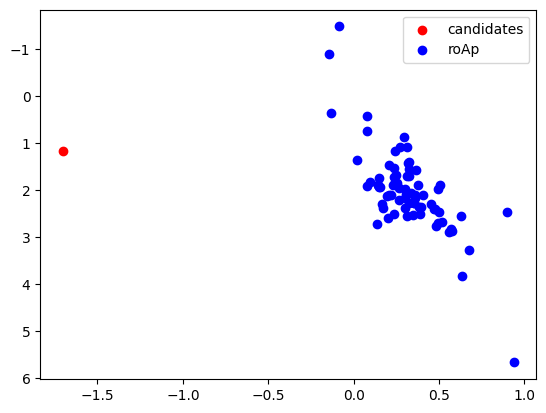

2.1234914443370756
0.2734758811214255
1.428823154262513
1.530734439598874
0.8878516886528858
1.8408114204173507
0.6266867304688701
0.6526037053465861
0.652282120468183
1.393683954968672
0.0680315544490182
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


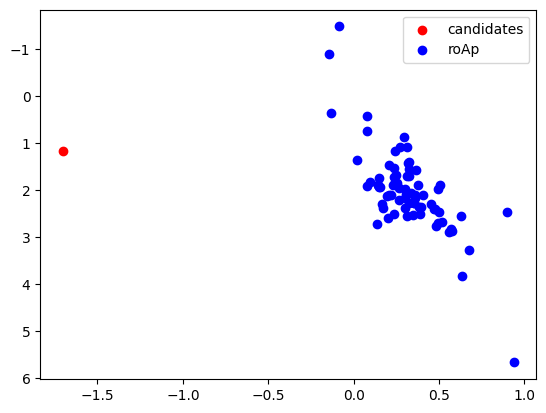

1.8983301609264784
0.11229269900335526
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


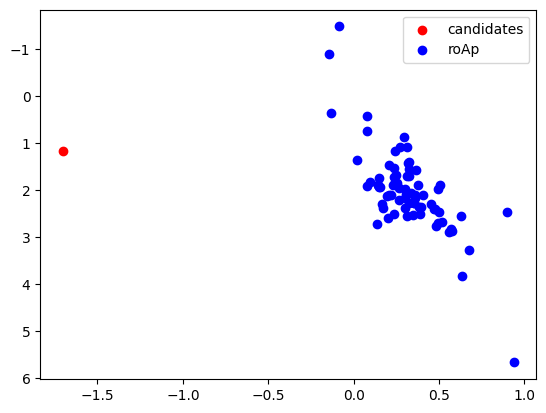

0.842691489599789
7.559036627763106
0.1528972570135707
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


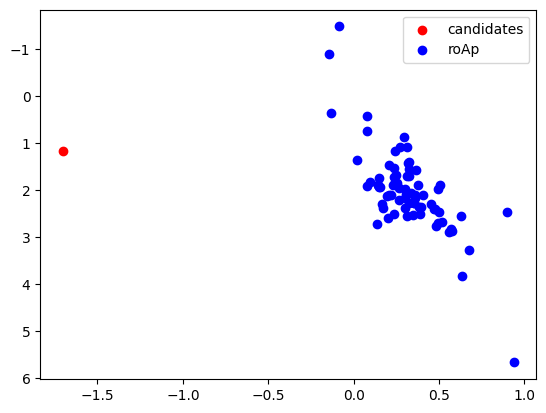

2.2525145543984157
0.43566877059964204
1.469481165017974
0.23546316533347023
1.0937213372612455
0.6468566723583584
2.974024663379351
3.4723014140036352
0.5909304404170999
0.43740809526455093
0.4569505726903551
1.4582033626459028
0.21620106743202738
2.2534739774462573
1.478748342159038
0.950733635037309
3.7904283904879317
1.7927519153402416
0.8521453934444421
5.857261319785302
0.8662778385845651
5.736068773352459
0.23350095072931998
0.9468331216734582
0.5545479806491378
2.1819299867564736
0.6268734571724592
0.5832209033557443
0.15264641439000437
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


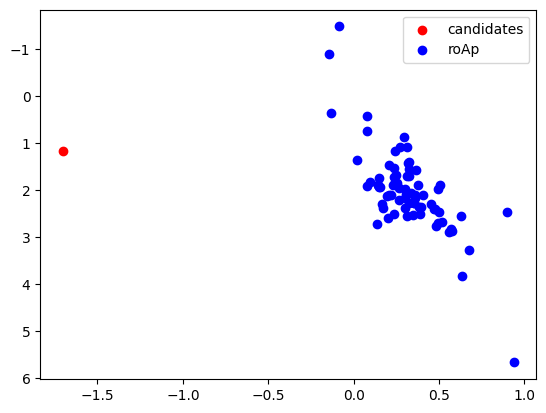

1.5646287942021249
1.2233995750016153
0.37074161996502886
0.6467148983797082
0.6406151593958138
1.8124151298642084
0.38220269113877103
0.6991281914409437
0.4883499063250576
0.3522468868204718
1.2575221511314747
0.4940884392929785
1.1201051288979316
1.104641391519261
0.5860702145364294
4.4732084137673525
1.7111262668731428
6.220555411126531
1.3042990640658696
0.6843956555835056
1.8139193171986725
1.5577648588942838
7.439856580246717
1.796456912511219
0.6102374910434816
1.5961441122855802
1.5599018422797983
0.19956668551951973
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


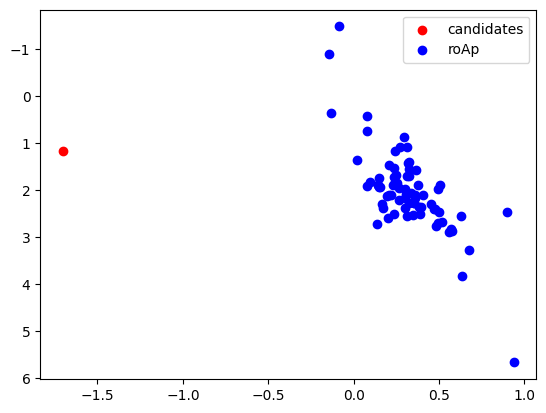

2.066840637209442
1.452561650931695
1.0175299263932565
0.6547061097129165
0.8102478695857576
1.2248069410823672
0.5569408487766068
4.885310790685493
1.6633122728322345
1.7548548945320612
1.4917223901565282
0.17444502808301499
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


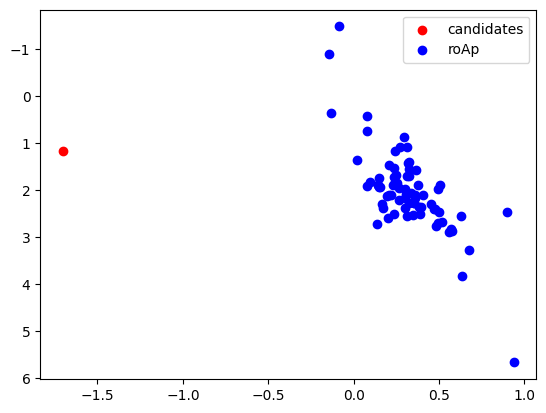

1.731047239824513
0.5456058462883946
0.5397170393215167
0.5408062784257841
1.144780716986975
0.6392389144323274
0.9220710860364583
2.5470048975856314
0.5369680072964624
0.3913419259088573
1.902994870614275
1.3701563903165073
2.751978949597149
1.1191887848895807
2.353445379806448
1.635873821110464
0.8259087073737725
1.0269008405918698
0.8752995046894294
0.8960072950617035
1.726717946622792
0.8492615032445738
0.1274244777978688
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


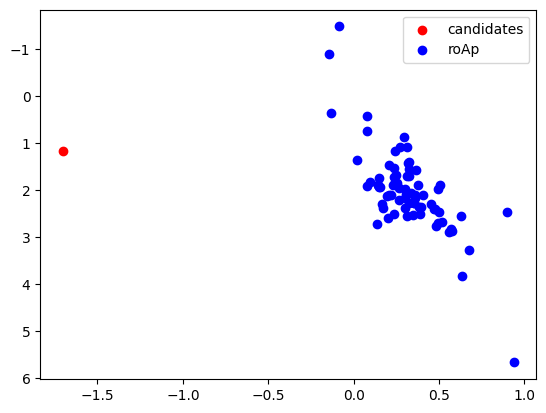

2.054644617143572
0.4521180100250315
0.5365876380854488
0.3735233573238186
1.8703038658785958
2.107822106528754
0.7974759641159994
1.0539865863179734
0.3430246624043458
1.0697027505366807
10.567549612767422
2.006323895737142
0.3898723175935763
0.9675563278698758
4.895100111016223
1.0082212544291722
0.27235552089989445
7.365919721429464
0.6284468025452887
0.6198297109648663
0.39901342604911205
2.096709993979784
1.0467007869760994
0.5119950396424451
0.8886539218979332
1.1434148457292435
0.7347081284948804
1.2136828706111715
2.549874956177827
1.704724106205886
2.1141170722365437
0.5611249100977589
1.5115396260503489
0.004183269212917118
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


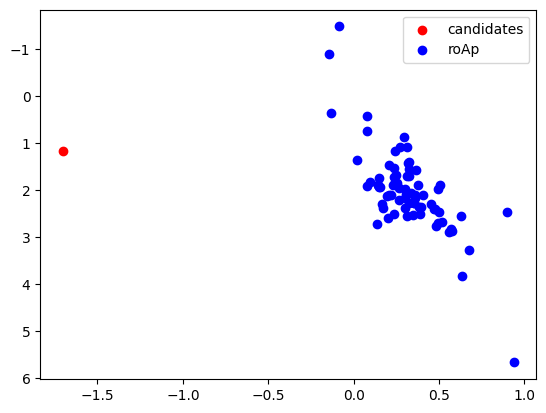

1.1814448510267899
0.7630352610096565
2.220150176659527
0.8489729131688839
1.5270656056635494
0.08469359957687228
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


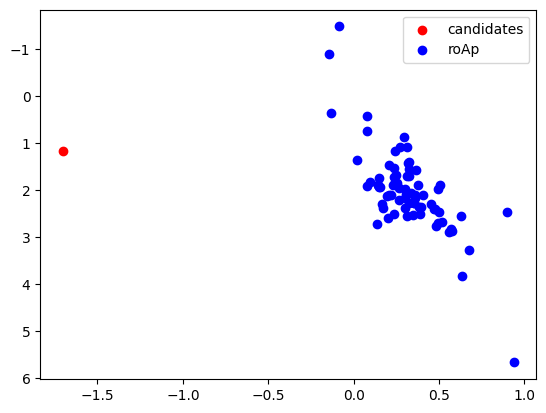

0.6982307211586538
6.2066166084938335
0.9635382458408022
1.2583262580619705
1.8124151298642084
0.6311889187665067
0.15138082228790362
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


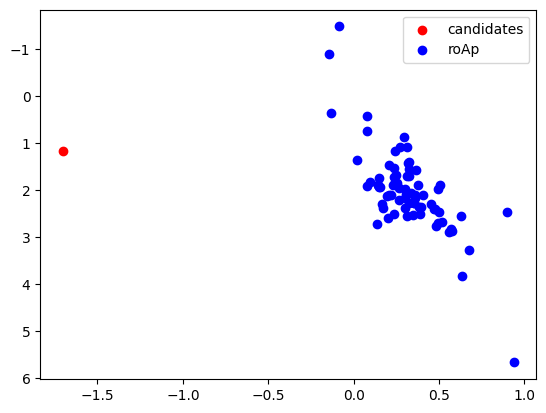

0.79187762091026
2.027527750300204
4.908233222501954
2.1457465010833032
0.6569883249789998
0.8319754515549538
0.5805583188786474
0.22420769458937917
0.1456476209073494
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


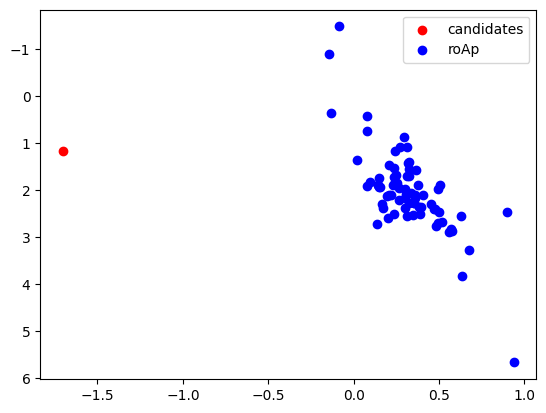

0.5623593810825942
0.6346813997039971
0.46310030651757605
2.0553346133107633
0.5743375533276125
0.40015265999670513
0.5022852510558375
0.8464398552792347
0.7171246972402865
2.1343545879479278
0.3351494355198894
0.7640587999774753
0.6437272711222906
0.7413611317857041
0.08237334738968771
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


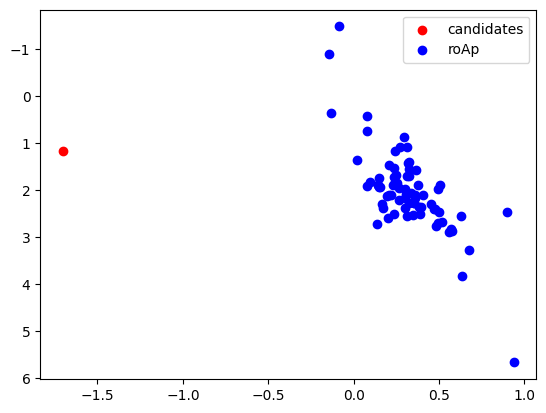

0.42588290817083196
1.962251351571842
0.7833953875046507
1.4590659644400312
0.017454696775381695
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


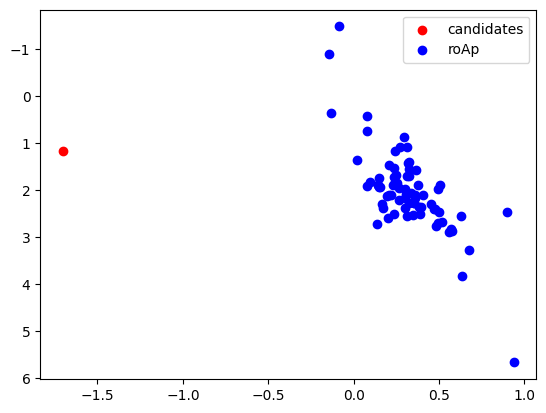

0.7453308031879211
1.212531389272375
0.37292859819386903
0.5073441615623211
1.1612057510989362
0.8061518400290333
2.6968272876855917
0.2775147105620088
0.16828304686459106
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


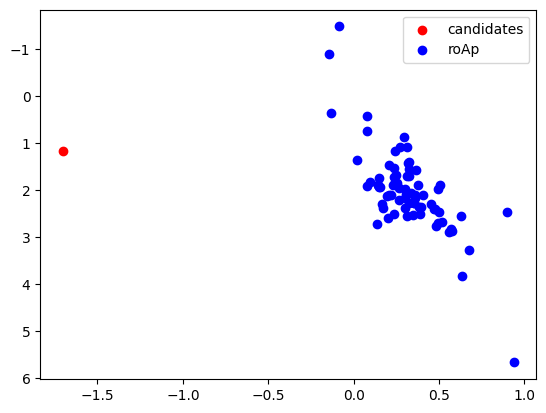

1.3110677623364677
0.8714838546570662
0.25898035627988003
0.871941881926753
1.476490332206383
0.6340970142798033
0.4088700307327584
0.4516961459909976
1.0433312062911975
1.8702020025064945
0.0803866380031315
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


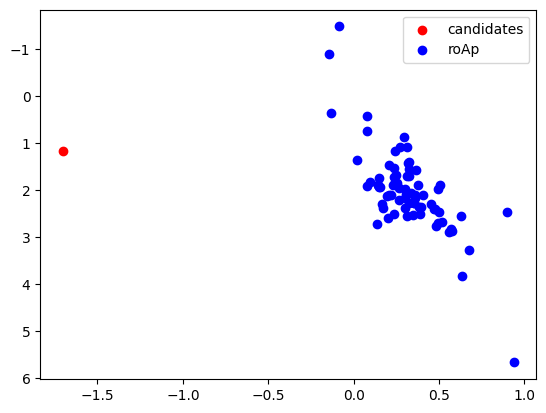

0.5554608667555709
0.41512537530297733
0.6088785355895863
0.4774160204593696
0.5222511767321456
1.457731214299565
0.7145865972322487
0.9527980024825387
0.9143565068567141
0.7960651401333299
0.9398689072099873
1.546990036516838
0.1728267299852475
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


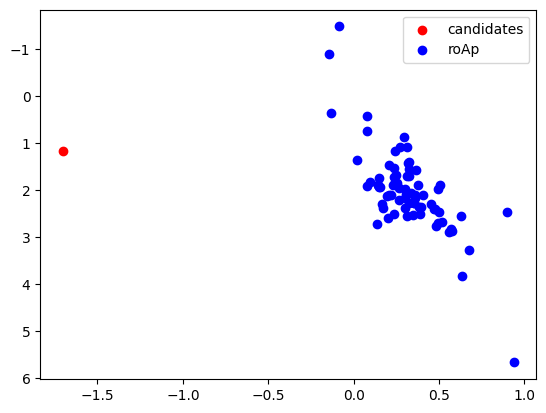

0.4057337136928534
0.6384920076179728
2.598503430854986
1.0506462530648881
0.7441620323395335
4.039608260623092
0.9647312220026181
0.5193034600812774
0.1725570136356196
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


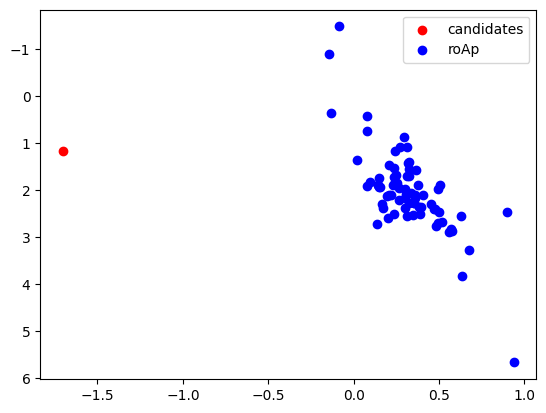

1.376225008183137
0.27713779925291293
1.1737044823171479
1.82847016847091
1.8067787497373673
0.7810025193771826
2.096260466730404
0.4699107890801719
0.33174844424874506
0.3288214750093865
0.5774757440529652
1.2675950194195047
0.8478575950657405
2.901961987401821
2.1866154438557808
1.0818054072507572
1.3240625577454677
0.7401646977219696
0.9928059276773573
2.1302239793720203
1.0285763388057791
1.768541270324722
1.3797728155513203
1.8786789043247363
0.8454612690363539
0.6300893059564854
0.6800732781856209
0.014996128511465034
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


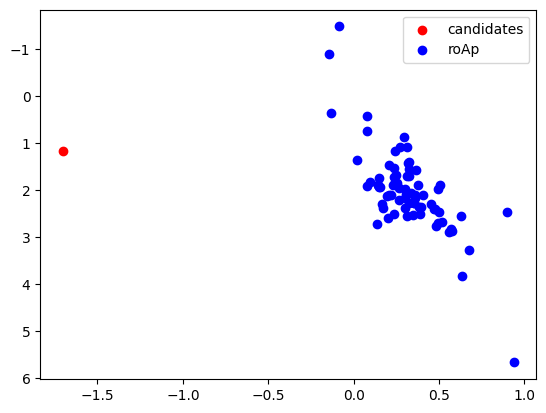

4.474162794696804
0.17986543407445144
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


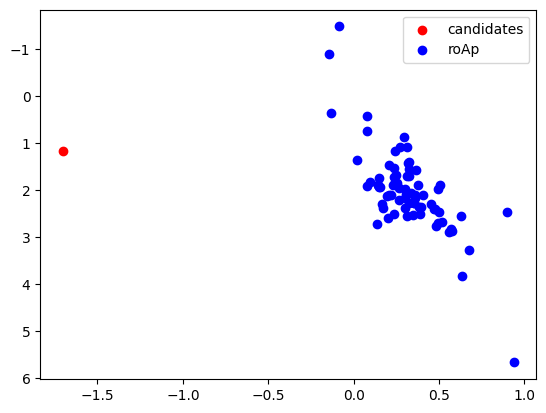

5.081736909154955
1.852765387348939
7.219719628323421
2.0213450216702706
1.2194610247166637
0.5018841344333134
1.9399114314941275
0.12416367628890512
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


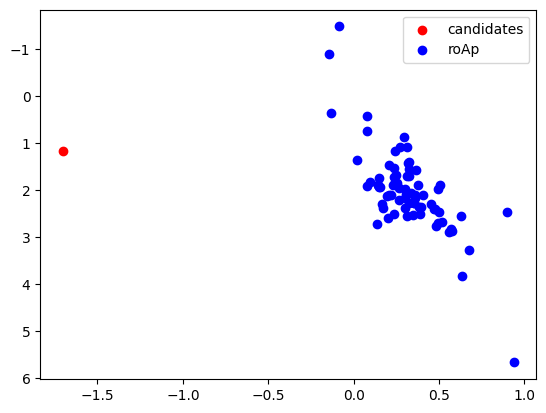

1.5179263708934632
1.4518873600576252
0.6061191298587771
1.5253885232331705
0.8282478332870187
0.6427417690755726
0.686013953681273
0.9119843861407548
3.8433688688572203
0.28162457172640654
0.985406017572179
0.8848848088069778
1.7450275372802309
0.3261673905525968
0.7785093720940828
1.1751099747124507
2.821389414803337
0.6163337721254574
0.8266779458161069
0.5525181922230913
1.8050931672866812
0.536648296103508
0.21719002738066306
0.4374011794607138
0.0812476555807895
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


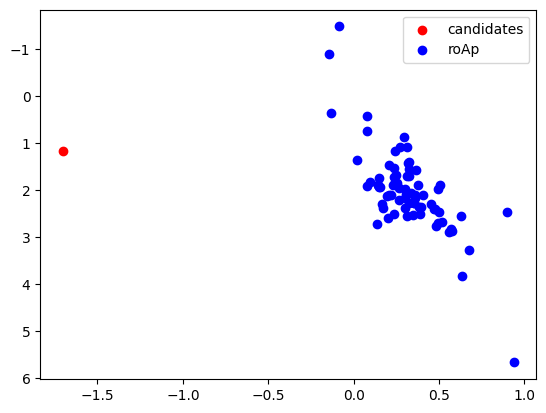

1.621046337684761
1.402214599001136
0.05388023558283361
ID: 98 --- Gmag: 1.17121 --- B-R:  [-1.7032105]


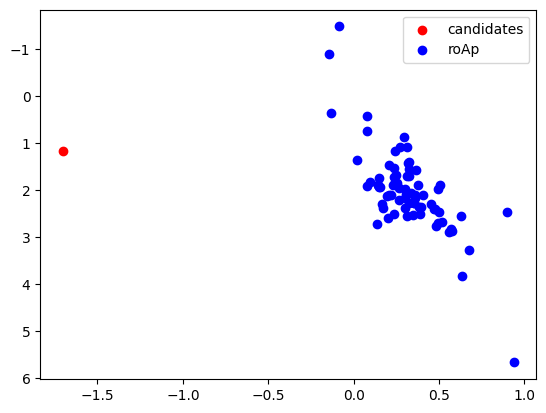

1.4939216157765718
0.8701887256541707
7.460801092165907
0.5974847487687627
1.5967423293174474
1.0149849105813824
2.135773911950904
0.7853352704808221
0.699976961627399
0.8772497613713548
2.023746679287024
2.2129370140427445
0.4617812408854236
0.21495620195662957
0.5544373485725589
0.7111236324107457
0.6814184228166495
0.5191997022389208
0.1534401268299379
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


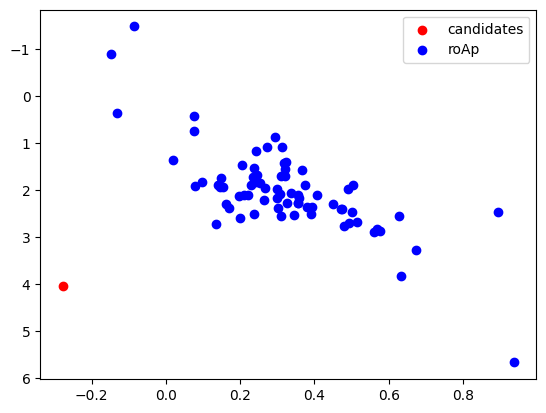

0.13724494003066967
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


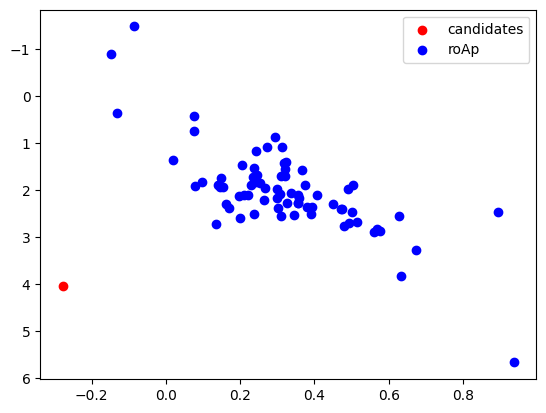

0.4394224470816468
0.07623026068213257
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


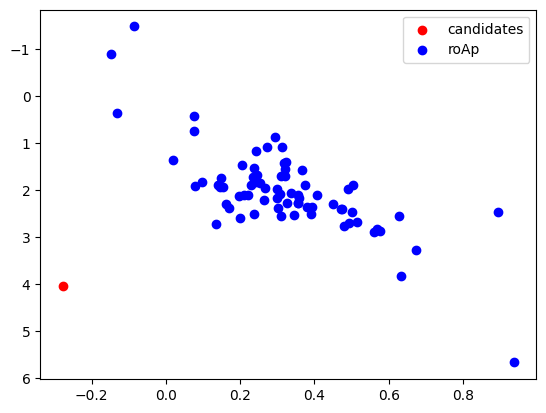

0.7548695495792548
0.9103038665932641
0.20317329800512196
0.20712751201358115
0.4766190980168814
0.7625599234455707
0.24322271802296003
0.08649860359342165
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


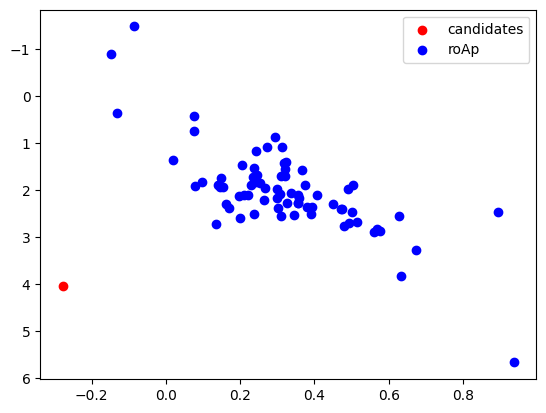

0.2614822722674577
0.2723970365077206
0.6748587828776205
0.48602275911884396
0.940563966280374
0.33604155343000564
0.006735180043820899
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


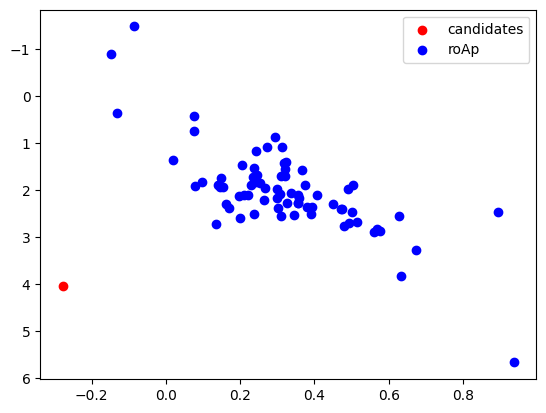

0.17929648525920783
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


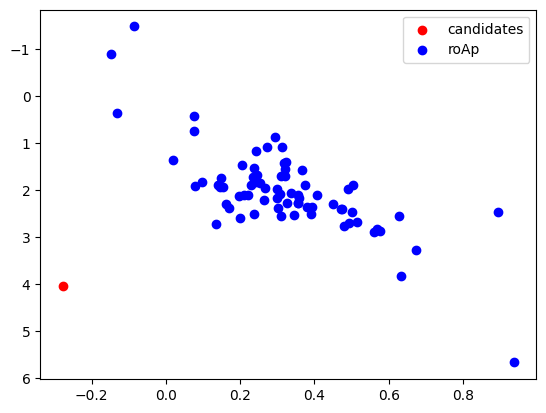

0.23420288403392941
0.05959083665123632
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


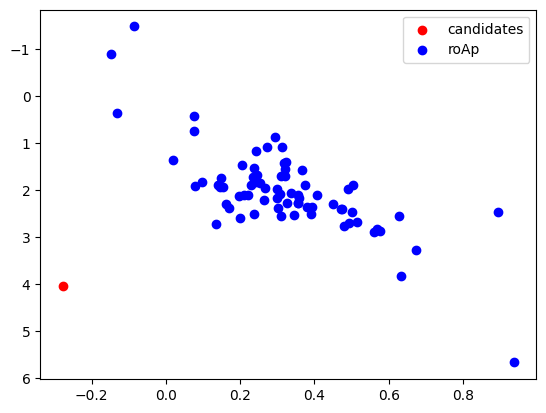

0.7069619442871877
2.0679921393330463
0.5302511567698318
0.21479530635255317
0.49129097585626047
0.9596326695737556
0.0080508085588622
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


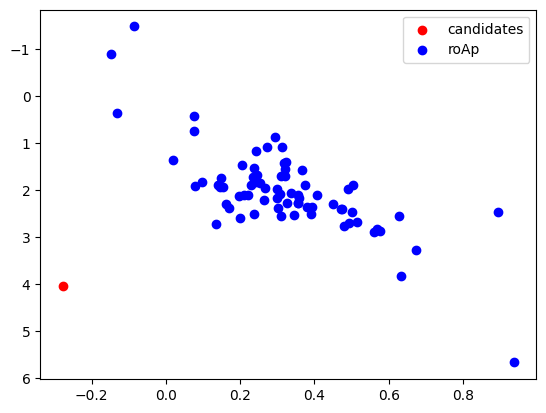

0.378392104009603
0.6352554322072437
0.7214782165402429
0.6059220502342408
0.20250246503296987
0.3146751774767831
1.3021671435835507
0.1327565833407065
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


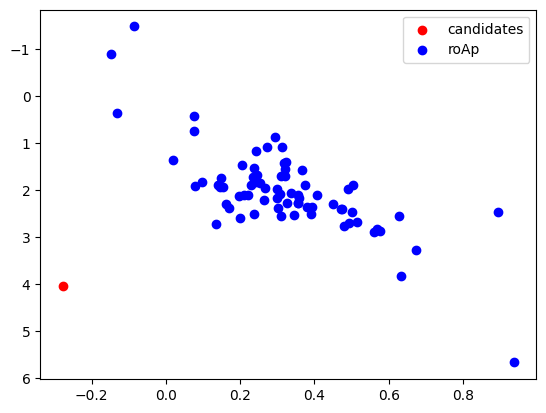

0.033411061227729855
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


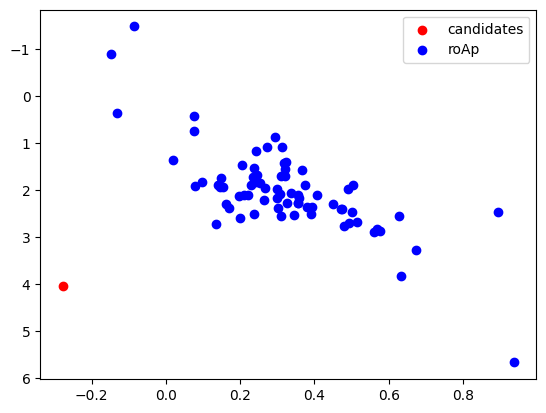

0.32129868543642637
0.04260745454434378
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


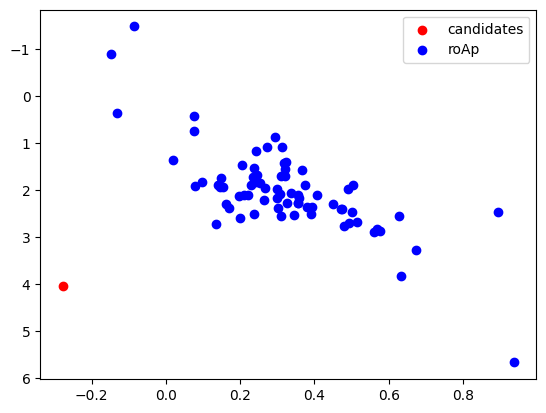

0.1669690649204414
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


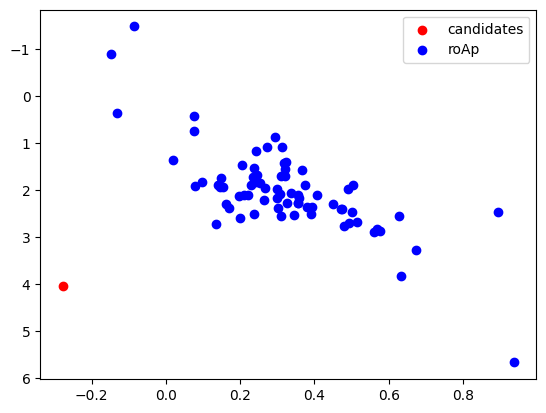

0.754622206427221
0.5299208239717585
0.08634991381093449
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


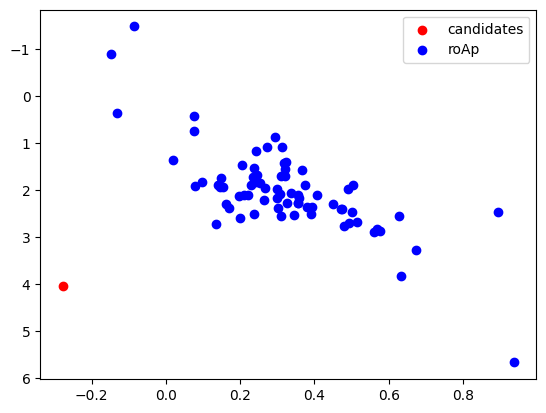

1.164843484701802
0.9724527377710062
0.8064095776716289
1.1407834031542188
0.6129519648341599
0.08679760894448041
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


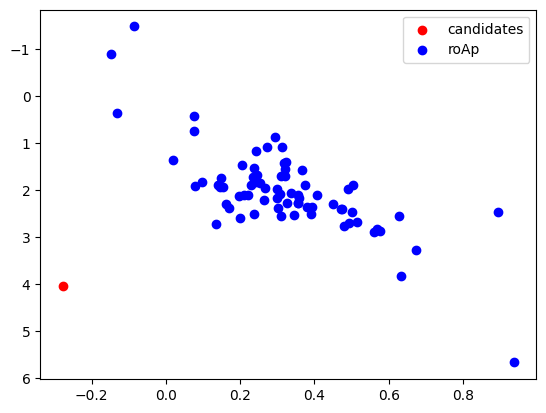

0.05108785583411812
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


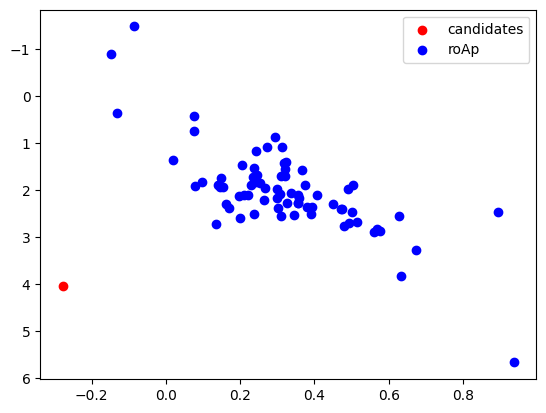

0.2768180672751519
0.11516115259427329
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


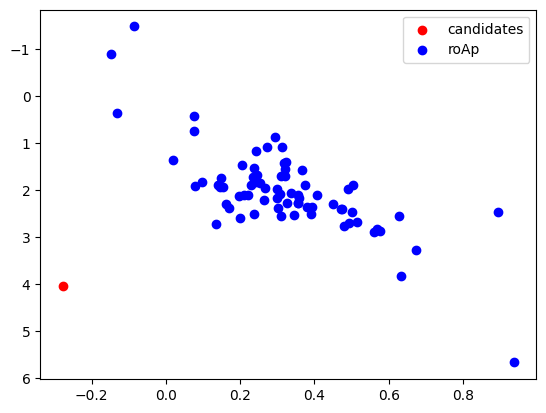

1.532071042639982
0.2085902045250254
0.22462449572021725
0.3463288116369705
0.012916076557921041
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


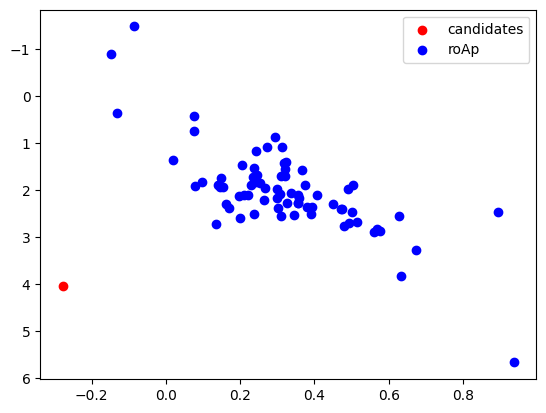

0.1758577049663259
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


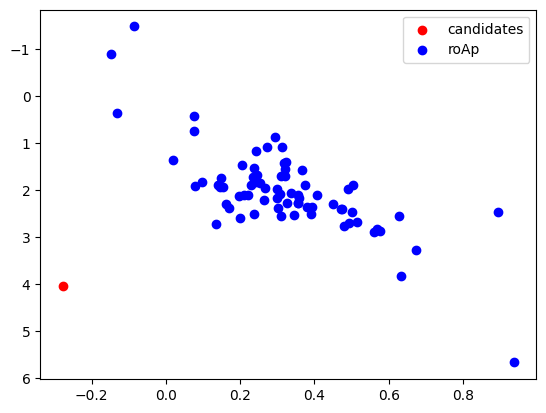

0.2629638800745777
0.5356005310374536
0.04363607720016538
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


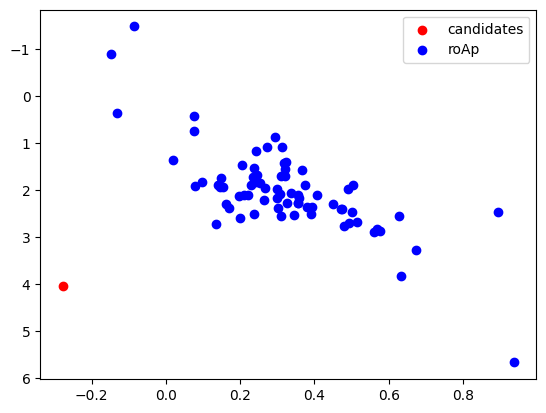

1.480759236074216
0.30998626247555805
0.6139927933115703
0.019690106415885422
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


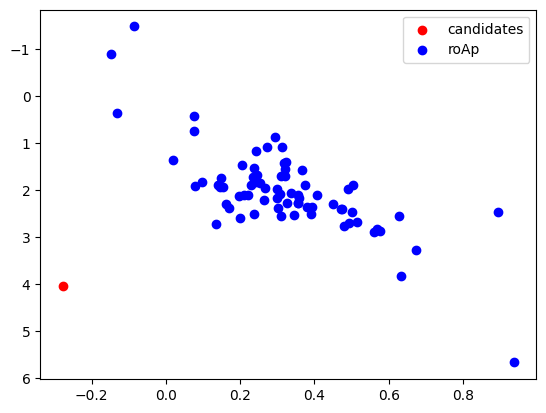

1.321744158458924
0.2904542003251227
0.08407278223285397
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


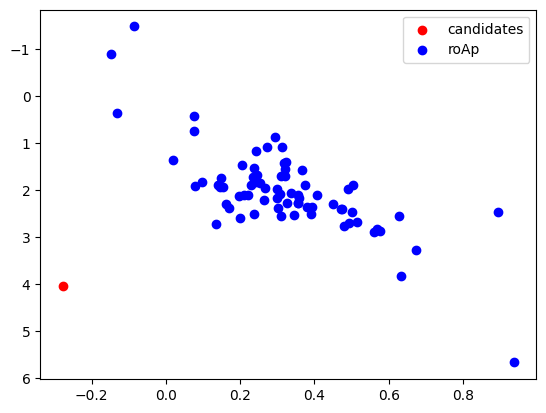

0.6900788413359258
0.18498656603065777
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


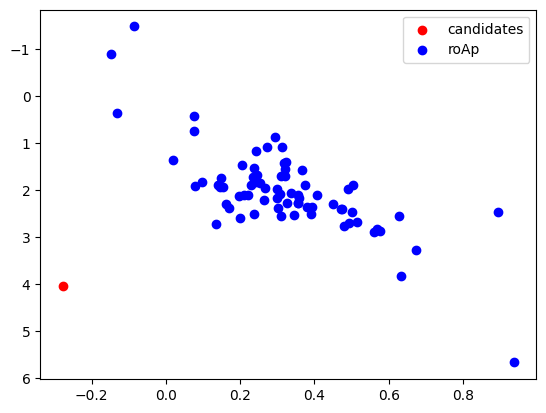

0.5411055108913994
0.20610905673376445
0.02861840916895564
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


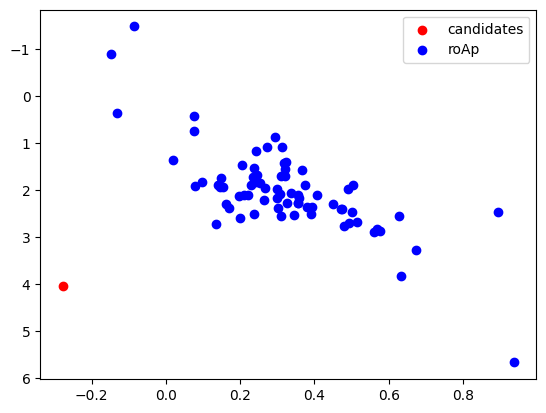

0.7685317200584878
0.30148328165843985
0.7627189869338129
0.5048026244371724
0.1866636484610369
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


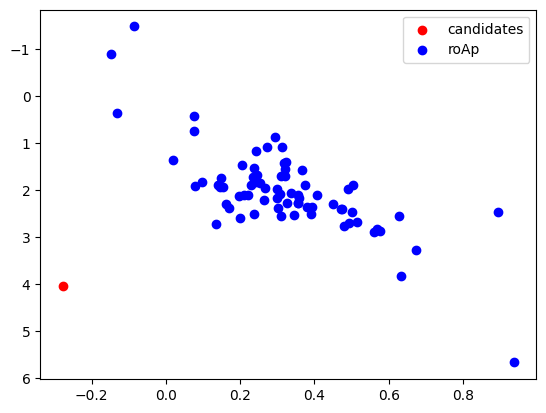

0.3313957590378842
0.4545558516622452
0.10084014863472746
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


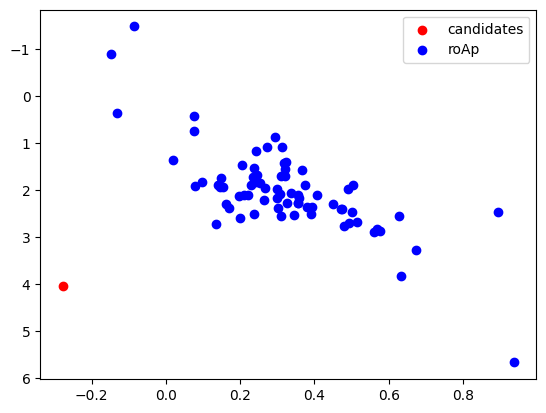

0.10375699206769484
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


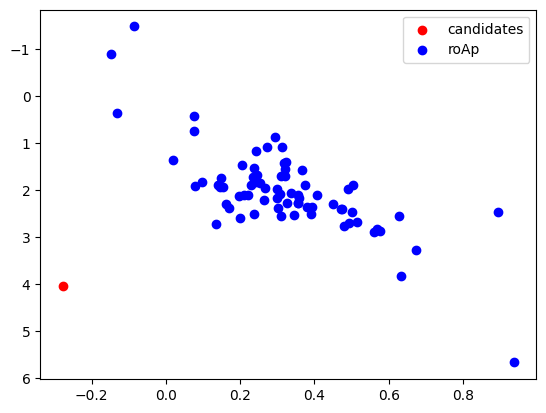

0.5160668431009341
0.5571052230674083
0.09667683472508548
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


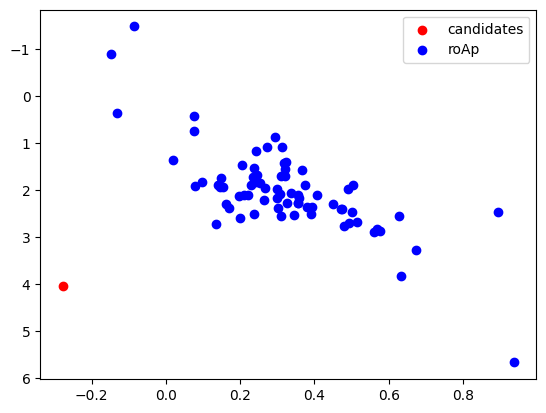

7.293760244983028
1.7556347753643209
7.526094916054937e-05
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


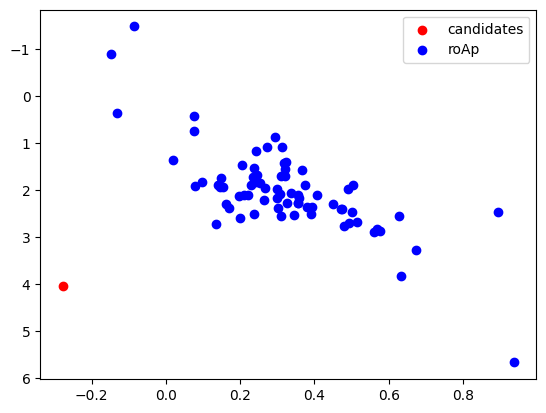

2.045277181631684
1.0009008968529227
0.7424158126555951
2.8662176760570834
2.3793105069401954
1.7864082703214241
6.958046379342221
2.5692910962339313
0.5901332700752486
1.2152942736899095
2.5568322756222686
0.40925042072857964
2.3346274983518245
3.3853836121698637
0.9436069199684849
1.101861259161749
5.9289886000615635
2.521437191586473
2.7383513789219065
1.381529450510628
3.3923409108294984
1.9807631055418198
1.7336406870480512
1.395831332844748
2.431362304516479
6.348715650709572
1.2697631447070905
0.16853549448943506
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


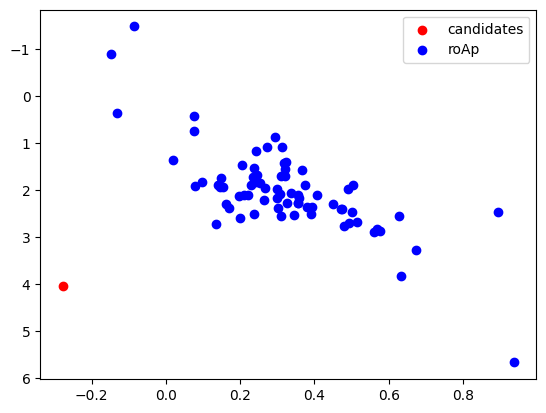

0.4632144380656871
1.1441029889957934
1.7101407856112325
1.5672671941506002
5.150863847188649
1.989428607749098
0.5526618191023831
2.558429826308527
0.49351094888781377
2.0533098877879126
3.78754452107287
2.3424700199025463
1.6108194688116844
1.1999446470745423
2.706794566015432
3.5219257852180745
0.7762513829262345
4.734580866851273
6.137797465300483
2.217224812421446
2.7792064900867097
1.0234222120468597
1.9526641945536523
0.3600670559584065
1.6147268979793723
5.049996848231617
3.53866894630652
1.114209426912025
0.5945006001980708
1.4861621046566964
2.161403901754207
2.590470745483565
1.07574718387469
1.5229230599502244
3.3057861679123417
1.0581395473066677
1.0886728212453236
1.6306124993920768
2.0215836376874408
5.9974204790248695
0.9168600486303755
1.2404903791825328
1.467145476221839
0.9827054169587881
1.5747120569807174
0.9865817250092106
0.6864531280097057
1.234558245276801
0.18411863264916262
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


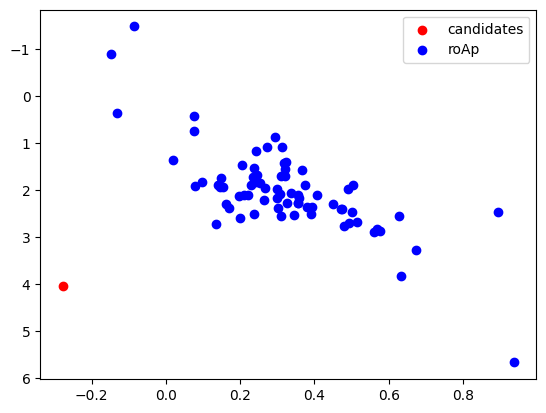

1.4807643197622187
2.377118197123988
1.7241764094976433
4.274188889643968
1.485636503565114
1.1762130662091983
0.467192857387575
2.1020697627379676
0.6605257794262358
7.054725859076182
2.1363859813752515
0.29783682092070984
0.14886878049393526
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


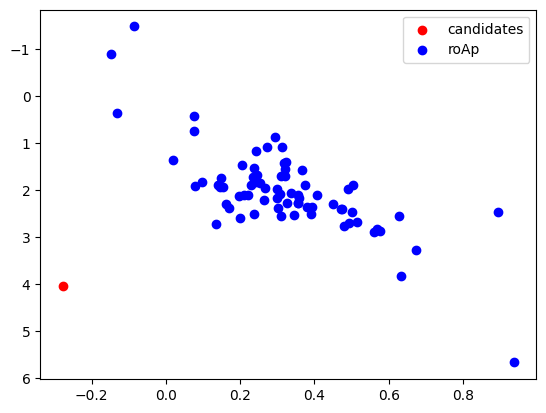

2.0554779922906916
1.1933642597240035
0.1646315232236657
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


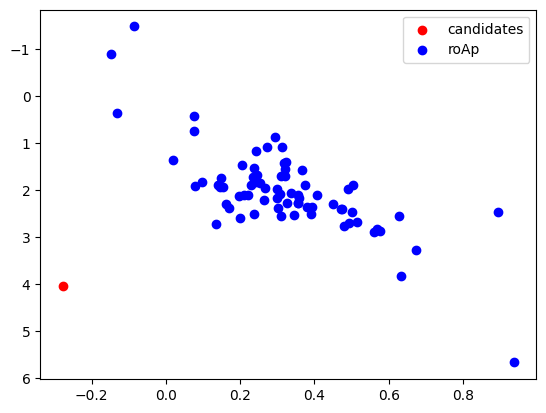

1.6414945167289914
4.96969399198276
1.1745325258769008
1.1208589723009301
0.7300625612173162
2.185955005374191
1.9977068249415262
1.370612854154531
2.035847483100459
2.3804412408674813
0.39668623727328356
2.361599133314624
0.5071574556435396
0.6991297964422212
1.912939817316135
1.0109426440236873
1.1941180823421944
2.1092587408261294
1.5802827369711108
1.35958214703513
0.35179921247173307
1.192454831519488
1.57901714486901
1.2303741839556497
1.8341722695190064
4.704590483513792
1.9418202141378393
2.2352681446311746
1.6553468718137307
2.45236214286636
1.9425532893445205
1.4145109190074456
2.2859022024209525
3.5152589503195775
1.8348361866873222
2.5359500059376088
1.5280960812200122
1.8179962043451643
2.6326502330830803
1.6705754718619574
2.816814631350223
6.777910436809908
1.2221512931939142
2.194838355402323
1.6008710849927135
2.8194633842196466
2.9371323285977353
0.7821298161873576
6.639383428060587
1.5872815304537649
2.9943882685610723
2.038465114852618
2.3163179076943856
5.015943430

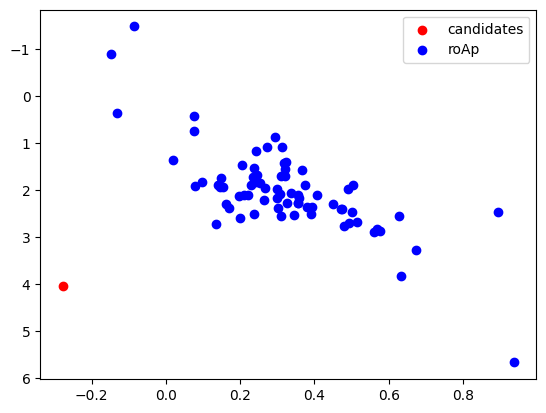

0.7425402971246542
1.8501961870084442
2.6944360245594
1.1762580189341354
0.41408802551229185
1.7825803728978582
0.3021972352396953
1.213518744219734
0.39668094725553127
1.315175770600224
1.9825335513239932
2.0685177404246287
1.1647397476442536
3.6711930373256574
0.9905859754306108
2.5065232606128123
0.9297407332760712
1.676744368884218
4.05427670134536
0.7900518694822001
1.0456841845969236
2.731518564731331
1.7957065685797535
1.5653273111744306
2.107246241909674
1.2700881874874113
1.4912659678881188
1.2555373362151738
3.0147829740752496
1.079327944475972
1.1545769739063476
2.2249808864242104
0.3567560117067523
1.4338613381422944
1.115921088361587
2.287510126812965
1.3447650373151823
1.0691253017011308
1.0392421133231164
1.4865390159657923
0.7876539176667288
1.1361325250740948
1.0636168639452666
1.420396268072405
1.672031248569565
0.5338109636298545
1.4531806361598796
3.006321488081151
0.9971110363504576
1.0497645088605263
1.4885549727841654
2.0375833498634495
0.32769763610112923
1.8604

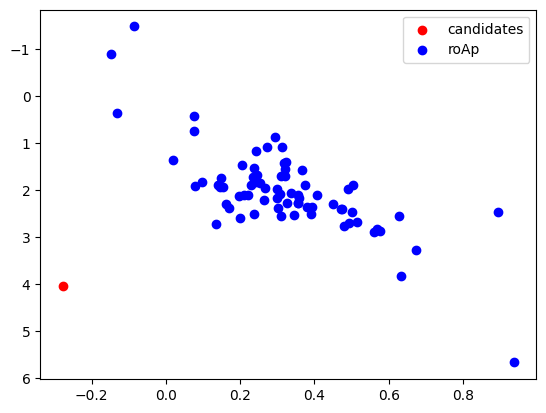

1.7056973816462073
1.3326174278761669
0.9936877134513327
8.479097901461598
2.7093879924541615
1.3018612224286557
0.9020655184377713
1.8484568623435353
2.3198138465337945
2.9352304825426656
1.3158880983953956
2.404290390398049
0.3225815670481187
2.4815018823319384
2.4158363249032777
1.5644593777929354
1.8833505506011776
1.0421744141498421
2.529988583030447
1.7419811464750086
0.9275415076560276
1.287180596669606
1.5256755498771972
1.7186714296436976
1.2393266920221477
1.490602050719804
1.5984989642767542
3.1455815720371514
2.4344882478506285
0.38780288724515133
0.8288426132017745
0.25433824690423434
1.5966489867504605
1.3492257307897986
1.3432470183730447
1.169217730628462
2.79232231206285
1.5007475349481179
1.5770599723832475
1.2233131482384656
2.871767608635967
1.3873663889487315
1.4047146828728798
1.5269791789003988
0.2841539030299667
1.3215313943260738
0.13109862253575266
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


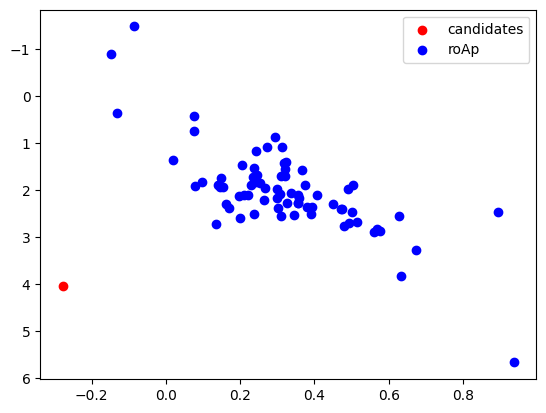

1.1485948035876752
1.173452034692304
1.244425471565567
1.3336444247459052
1.0831332623721948
1.0940671482378836
1.398922697159715
1.0147290466242347
1.388018306625207
2.670624911949934
1.4088468756652577
1.2395618293525925
2.1026645218679163
2.5035287175515575
1.5389193142243154
2.7966446894607357
2.152361488237833
1.373839076644312
2.7829341083546457
1.417519293676373
0.8588936129877012
1.9111935768473898
5.725401166719287
1.824756402595456
1.2992175532472348
1.4645571334711112
0.6107838603313813
2.466854209805988
1.1540133358936635
1.5298838165117776
0.9485759250250925
0.7781739763928139
1.353613808324131
0.6087506140034162
1.0390968814425476
2.817630696202944
0.8410559227772372
3.126656474838255
1.7198021635709844
0.7255430834100882
0.35113000528566607
1.7109533925620348
0.2917804088756686
1.2756173726547853
4.6160647365031995
2.050993093502646
3.659456918214921
5.6518654245245585
1.7887561857239551
1.6709039725441968
1.3962635705845368
1.2604855938602717
1.4106519004666143
7.226811

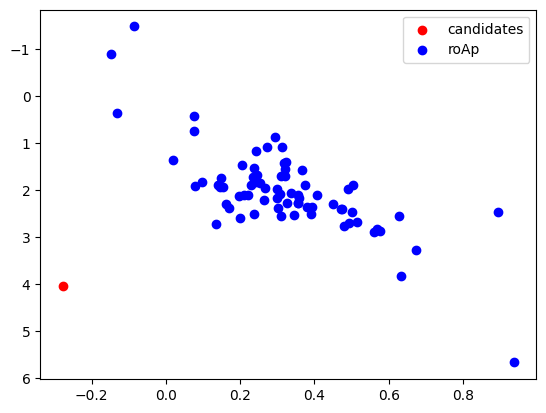

0.8282478540718254
0.037245874455132943
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


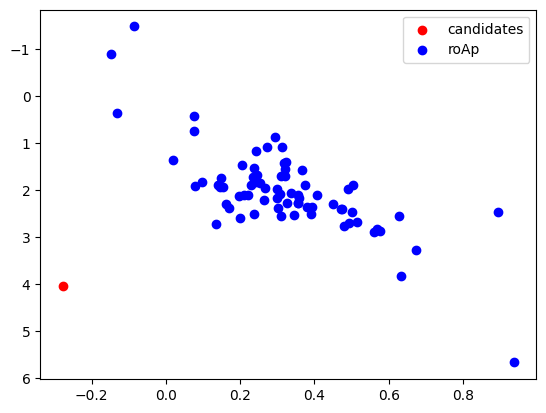

1.5804037635382513
1.4492109647576616
1.045974648358062
7.870164831549555
2.282949154182718
0.8391644504279228
4.411979365284687
1.482168227941052
1.27818313587817
1.0280488848135554
1.5850027730896001
6.851874958842506
1.7172121950341714
1.2076834315677147
1.3046983277877522
3.941123776872582
5.321722238874143
0.25200762101129515
1.2623374035024
1.861185399304826
0.8759652747583857
1.9054050490361427
2.758967390158856
1.49128325739771
2.816987526446139
2.0637354620716093
1.783818301784612
2.1050470162896304
1.9485596649766213
1.0700900563363391
1.4208769164390502
1.4412232113263719
0.7018719126634392
2.349662455892626
2.622120921741834
0.6872952302916882
0.6301411952700668
0.866921029126178
3.091949513284202
1.8937207984541815
1.7393012724883206
2.34125629632922
0.19075434643039468
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


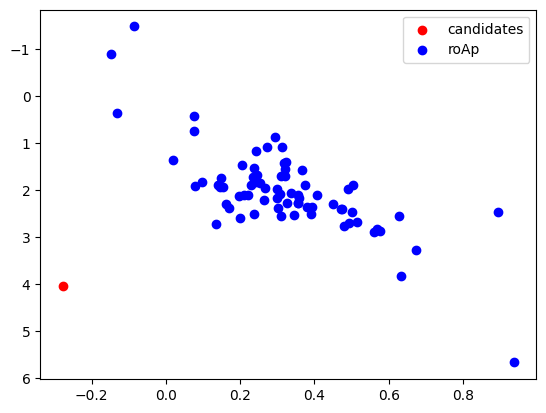

2.3132196275755823
0.5833230354120162
2.6026183549225794
2.109065098318703
1.4536370792130957
0.6183947024535761
0.9196194543611846
2.767705508306419
1.063333315987966
2.114953905285581
1.929133171999569
2.8369845732397114
0.4497424521919613
2.3938094896836586
1.075415225290532
2.6661745921810724
1.7210642977711665
0.2396679948509397
1.0850005294080813
1.211480207874017
2.4884176861685536
1.6249519139518074
0.7542367535282044
3.325855830646199
1.6448798027070137
2.4104385400088
0.9602585498209693
2.322676989322154
2.521015327552439
0.7362572893390893
2.620634023916962
0.6824177564710405
1.1212515473335332
1.1237947310295735
0.5430228143402256
0.890579994051238
1.3303232131182452
1.366383840108441
6.885987161266611
1.0874971345930988
2.428468040610855
0.13689060824891763
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


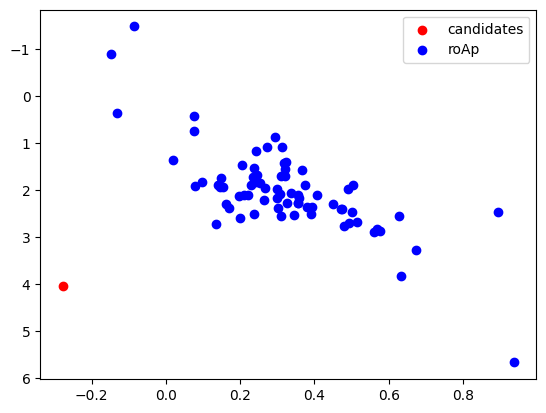

1.6032777847278559
2.11499885801052
1.4942881741647196
4.078233045835395
1.4170075241924631
1.1928179112209105
1.0560267692345815
0.28576874322581647
7.555737810117847
2.892864268239562
5.553833905140539
5.909454912125044
1.5834432593244432
1.1815209456538
1.9111140451032687
4.997156649017958
4.571402475326339
1.5016569631526333
5.927128248829515
1.296133104736104
1.7065480255181114
1.4223084878332286
1.996641791150688
2.1652490886873648
1.0317990826088346
0.4474067426110191
1.1827330434410417
2.098681018858026
0.27388922435034546
2.9133212159882693
1.1212082203946792
0.49814270534251204
0.7458495092604744
1.2604164358219054
3.8642649909343603
1.2552987409828105
1.4336089113022585
0.6303505015009991
2.144086728947323
2.5859236044609903
1.4441243910358312
1.1326296704308496
1.629561297208911
1.935163752945098
0.05269923812804955
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


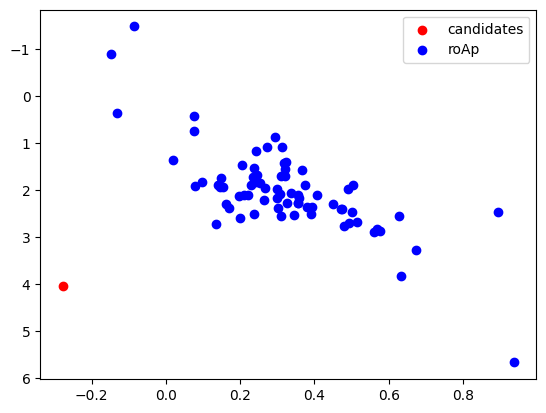

1.9575225467488742
0.9512991259506344
1.6180776049382124
1.13320022424737
1.675561766428157
1.7620888461299677
2.5618254859923053
2.3970841228002953
2.8253763964999528
1.375837743953094
0.8150559582534824
4.375671395142458
0.2719820882775239
2.0188276898585493
1.4329484520358613
2.004923466245035
1.7755954110228767
2.1034736709168
1.6939750941431453
1.4964873997847632
1.550921691782761
1.8804113339706157
2.3867311644568834
5.50446889735478
1.8593077585631845
0.18738797574804744
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


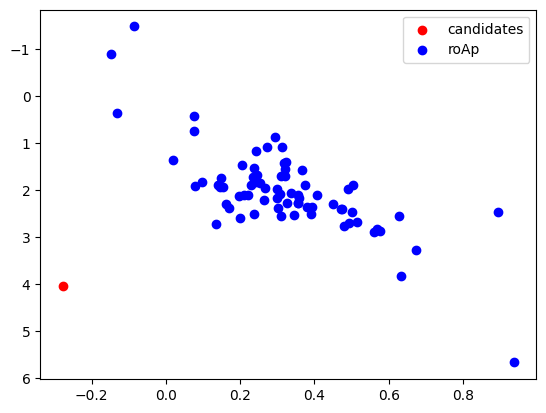

1.399057555334529
2.969252779516894
2.1285019650015102
1.451043652774365
1.2529404518745246
1.2194541296976342
1.6327840617967744
1.4124223462487877
2.511488807767502
1.1779420171683515
1.5134242033806333
1.8690244629536292
1.4683988625023505
2.3272448777562382
1.5378542804334763
2.129248871815865
1.276381568978732
1.423183337018561
2.5187884387170487
1.9127738380240564
1.4800761972804755
1.9471799621112162
0.6695059507080798
2.5901318710955707
1.0600655986751648
2.572171528531881
2.3795594758783127
0.36867031593115573
1.0600759723809197
1.2662291689465808
0.924522759281345
2.8737524443370757
1.0237368811214256
2.179084154262513
2.280995439598874
1.6381126886528858
2.5910724204173508
1.3769477304688702
1.4028647053465861
1.402543120468183
2.143944954968672
0.8182925544490183
2.6485911609264785
0.8625536990033553
1.592952489599789
8.309297627763106
0.5973637429864294
1.5022535543984157
1.185929770599642
2.219742165017974
0.9857241653334703
1.8439823372612456
1.3971176723583585
3.7242856

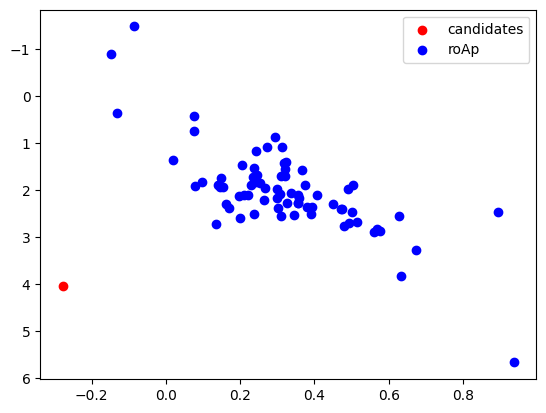

1.187669095264551
0.29331042730964496
0.7079423626459027
0.5340599325679727
3.0037349774462574
2.229009342159038
1.700994635037309
4.540689390487932
1.0424909153402415
1.6024063934444421
6.607522319785302
1.6165388385845652
6.486329773352459
0.5167600492706801
1.6970941216734583
1.3048089806491379
2.9321909867564737
1.3771344571724593
1.3334819033557443
0.9029074143900044
2.314889794202125
1.9736605750016154
0.3795193800349712
1.3969758983797083
1.3908761593958139
2.5626761298642085
1.132463691138771
0.05113280855905633
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


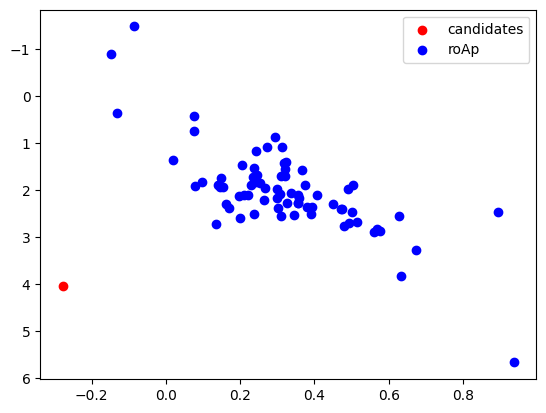

1.2386109063250577
1.1025078868204718
2.0077831511314748
0.25617256070702155
1.8703661288979316
1.854902391519261
1.3363312145364294
5.2234694137673525
2.461387266873143
6.970816411126531
0.5540380640658695
1.4346566555835056
2.5641803171986726
2.308025858894284
8.190117580246717
2.546717912511219
1.3604984910434816
2.3464051122855802
2.3101628422797984
0.9498276855195198
2.817101637209442
2.202822650931695
1.7677909263932565
1.4049671097129166
0.059986869585757496
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


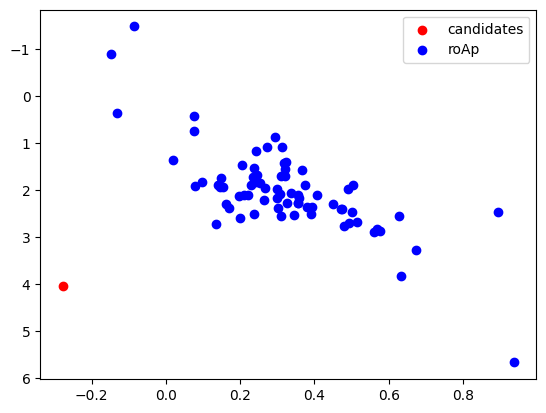

1.9750679410823673
1.3072018487766068
5.635571790685493
0.9130512728322344
2.5051158945320613
2.2419833901565283
0.924706028083015
2.481308239824513
1.2958668462883947
1.2899780393215168
1.2910672784257842
1.895041716986975
1.3894999144323275
1.6723320860364583
3.2972658975856315
1.2872290072964625
1.1416029259088574
2.653255870614275
2.1204173903165073
3.5022399495971492
1.8694497848895808
3.103706379806448
0.8856128211104639
0.07564770737377247
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


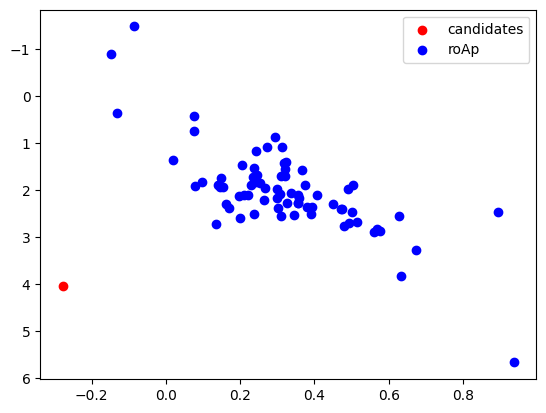

1.7771618405918699
1.6255605046894295
0.14574629506170345
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


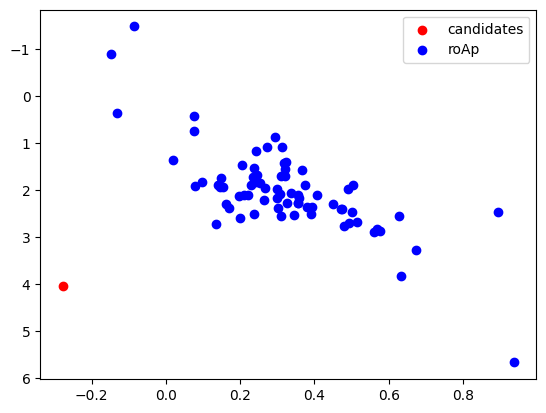

2.476978946622792
1.599522503244574
0.8776854777978689
2.804905617143572
1.2023790100250316
1.286848638085449
1.1237843573238187
2.620564865878596
1.3575611065287538
1.5477369641159995
1.8042475863179734
1.0932856624043459
1.8199637505366808
11.317810612767422
2.756584895737142
1.1401333175935764
1.7178173278698758
5.645361111016223
1.7584822544291723
1.0226165208998945
8.116180721429464
1.3787078025452888
1.3700907109648663
0.351247573950888
2.846970993979784
1.7969617869760994
1.2622560396424451
1.6389149218979333
1.8936758457292435
1.4849691284948805
1.9639438706111716
3.300135956177827
0.9544631062058858
2.8643780722365437
1.311385910097759
2.261800626050349
0.746077730787083
1.93170585102679
1.5132962610096565
2.970411176659527
0.09871191316888384
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


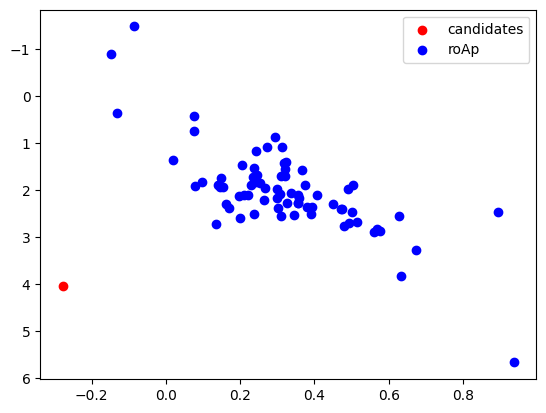

2.2773266056635495
0.6655674004231278
1.4484917211586539
6.9568776084938335
1.7137992458408022
0.5080652580619704
2.5626761298642085
1.3814499187665068
0.9016418222879037
1.54213862091026
2.777788750300204
5.658494222501954
2.8960075010833033
1.407249324979
1.5822364515549538
1.3308193188786475
0.9744686945893792
0.8959086209073495
1.3126203810825943
1.3849423997039971
1.2133613065175761
1.3050736133107632
1.3245985533276126
1.1504136599967052
1.2525462510558376
1.5967008552792348
1.4673856972402866
1.3840935879479277
0.41511156448011066
1.5143197999774753
1.3939882711222906
1.4916221317857041
0.6678876526103124
1.176143908170832
1.211990351571842
1.5336563875046507
2.2093269644400313
0.7328063032246184
1.4955918031879212
1.962792389272375
1.123189598193869
1.2576051615623212
1.9114667510989363
1.5564128400290334
1.9465662876855916
1.027775710562009
0.9185440468645911
2.061328762336468
0.12122285465706617
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


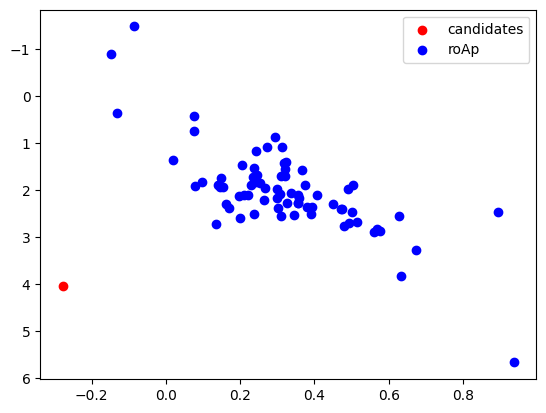

1.00924135627988
1.622202881926753
2.226751332206383
1.3843580142798033
1.1591310307327585
1.2019571459909977
0.2930702062911974
1.1199410025064944
0.8306476380031316
1.305721866755571
1.1653863753029774
1.3591395355895863
1.2276770204593697
1.2725121767321457
2.207992214299565
1.4648475972322488
1.7030590024825387
1.6646175068567142
1.54632614013333
1.6901299072099873
2.297251036516838
0.9230877299852476
1.1559947136928534
1.3887530076179728
3.348764430854986
1.8009072530648882
1.4944230323395336
4.789869260623092
1.7149922220026181
0.2309575399187227
0.9228180136356197
2.126486008183137
1.027398799252913
0.4234434823171478
2.57873116847091
2.5570397497373674
1.5312635193771826
2.846521466730404
0.28035021091982815
1.0820094442487451
0.42143952499061355
0.17278525594703487
ID: 99 --- Gmag: 4.028238 --- B-R:  [-0.27750926]


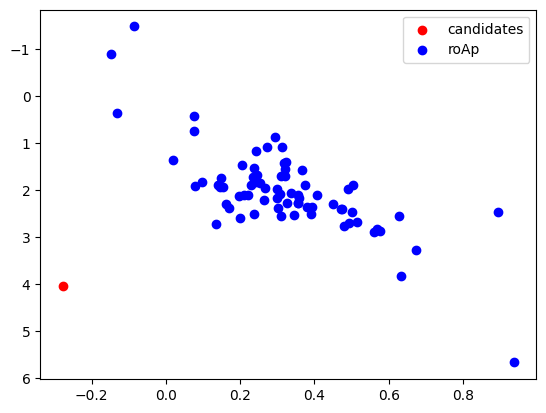

2.0178560194195048
1.5981185950657406
3.6522229874018213
2.936876443855781
1.8320664072507573
2.0743235577454677
1.4904256977219696
1.7430669276773574
2.8804849793720204
0.2783153388057791
2.518802270324722
2.1300338155513203
2.6289399043247363
1.595722269036354
1.3803503059564854
1.430334278185621
0.735264871488535
5.224423794696804
0.5703955659255486
5.831997909154955
2.603026387348939
7.969980628323421
2.7716060216702707
1.9697220247166638
1.2521451344333134
2.6901724314941275
0.8744246762889052
2.2681873708934632
2.2021483600576253
1.3563801298587772
2.2756495232331706
1.5785088332870187
1.3930027690755726
1.4362749536812731
1.662245386140755
4.593629868857221
0.46863642827359353
1.7356670175721791
1.635145808806978
2.495288537280231
1.0764283905525969
1.5287703720940828
1.9253709747124508
3.571650414803337
1.3665947721254574
1.576938945816107
1.3027791922230914
1.0548321672866812
0.21361270389649212
0.533070972619337
1.1876621794607138
0.8315086555807896
0.870785337684761
2.152475

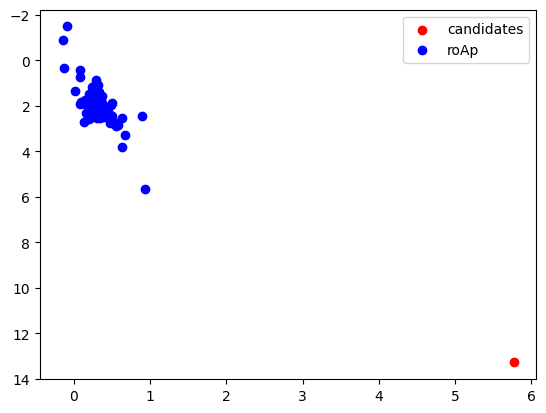

0.6516643485725588
0.6138966324107458
0.7786454228166495
0.4219727022389208
0.056213126829937954
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


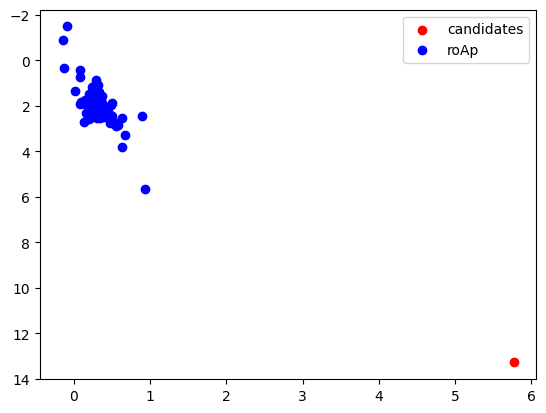

0.23447194003066962
0.34219544708164684
0.17345726068213252
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


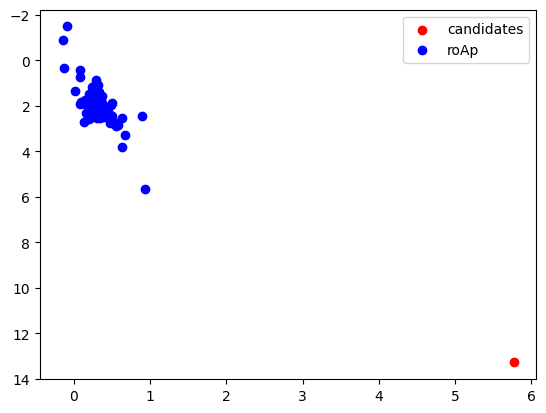

0.6576425495792548
1.007530866593264
0.3004002980051219
0.1099005120135812
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


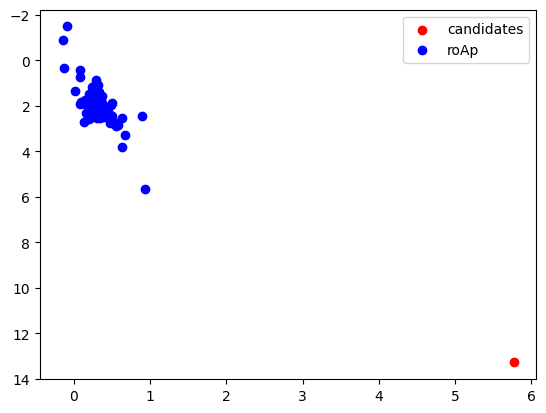

0.37939209801688145
0.6653329234455707
0.34044971802296
0.0107283964065783
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


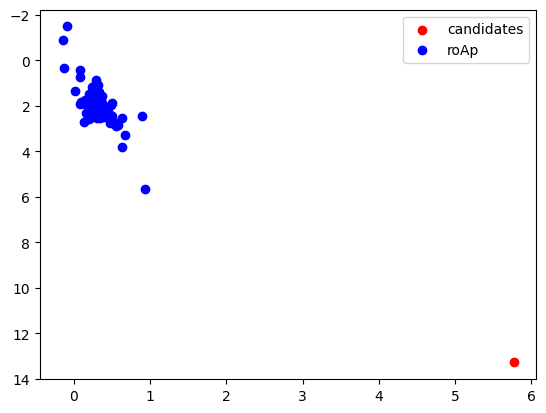

0.16425527226745773
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


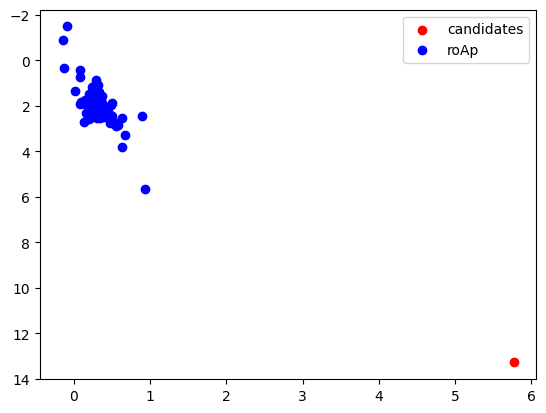

0.3696240365077206
0.7720857828776204
0.5832497591188439
1.037790966280374
0.23881455343000568
0.09049181995617905
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


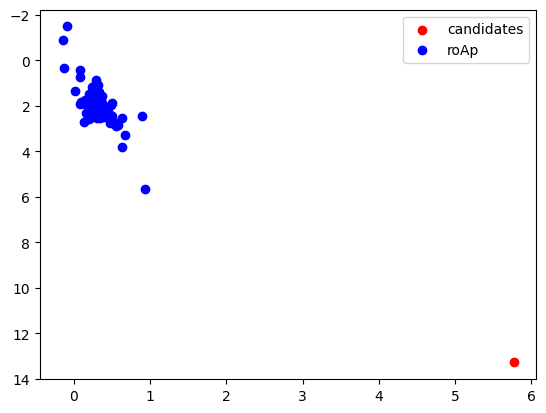

0.2765234852592078
0.13697588403392946
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


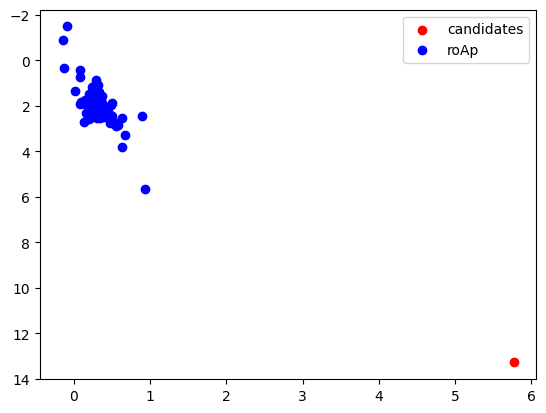

0.15681783665123628
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


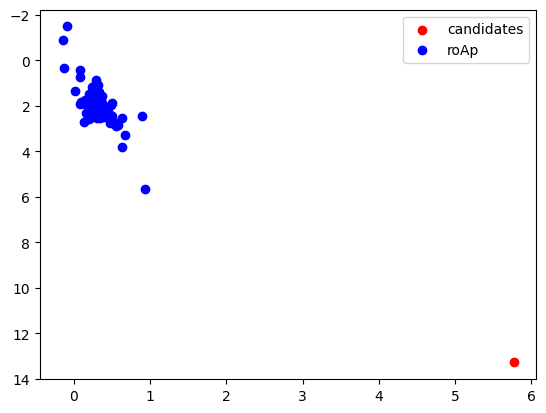

0.8041889442871877
2.165219139333046
0.43302415676983186
0.3120223063525531
0.3940639758562605
0.8624056695737556
0.10527780855886215
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


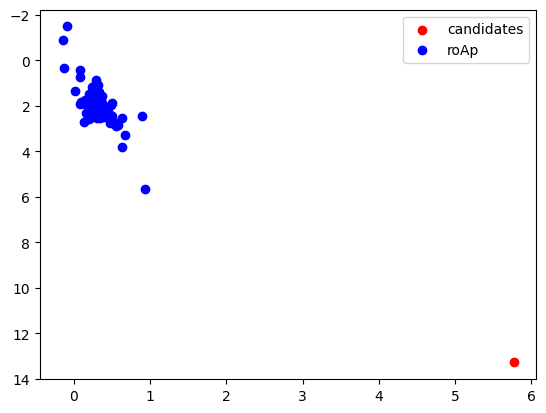

0.47561910400960294
0.7324824322072436
0.8187052165402429
0.7031490502342408
0.2997294650329698
0.21744817747678313
1.3993941435835506
0.22998358334070645
0.1306380612277298
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


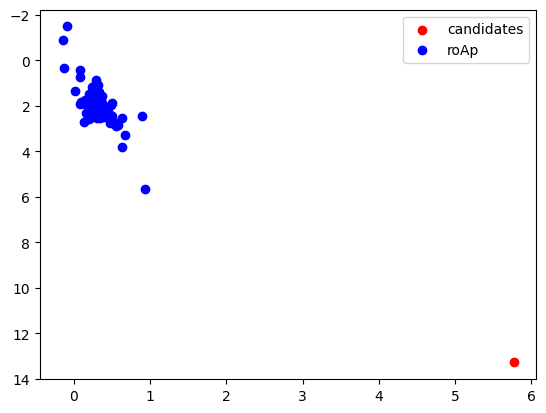

0.4185256854364263
0.05461954545565617
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


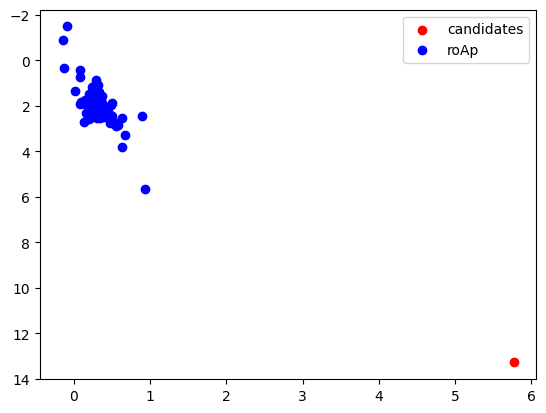

0.26419606492044134
0.851849206427221
0.6271478239717585
0.010877086189065466
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


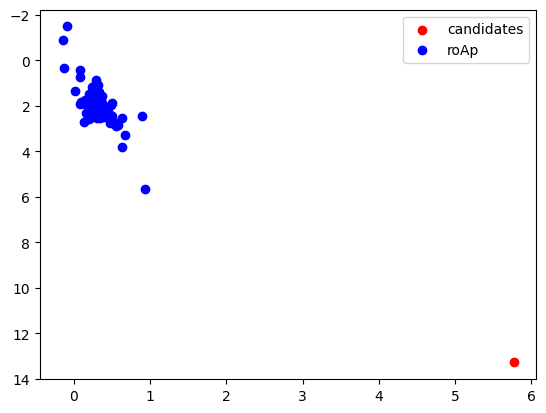

1.262070484701802
1.0696797377710061
0.709182577671629
1.2380104031542187
0.7101789648341599
0.18402460894448036
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


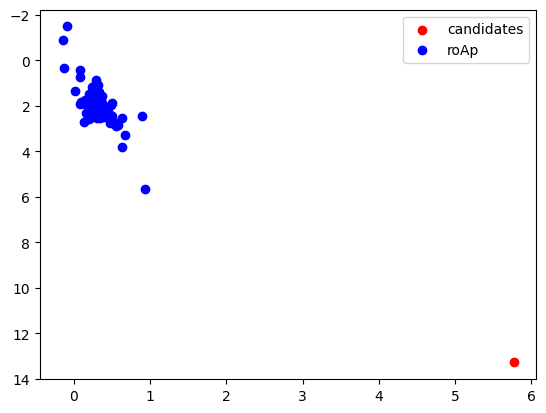

0.14831485583411808
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


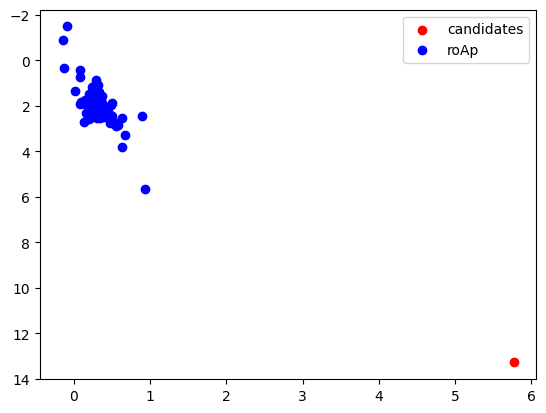

0.17959106727515195
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


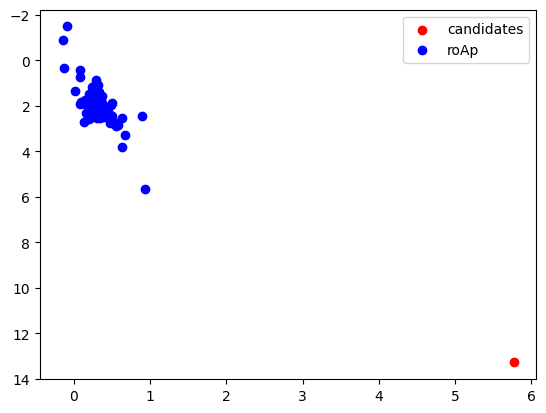

0.017934152594273334
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


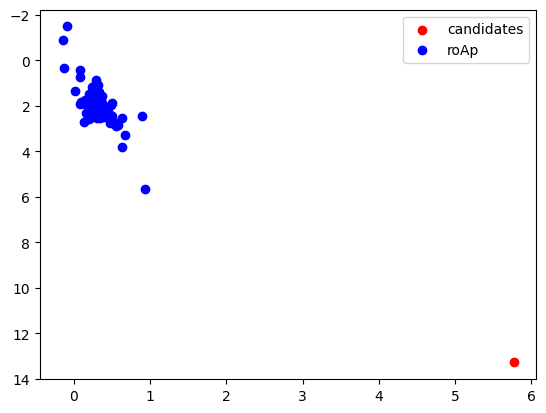

1.434844042639982
0.11136320452502546
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


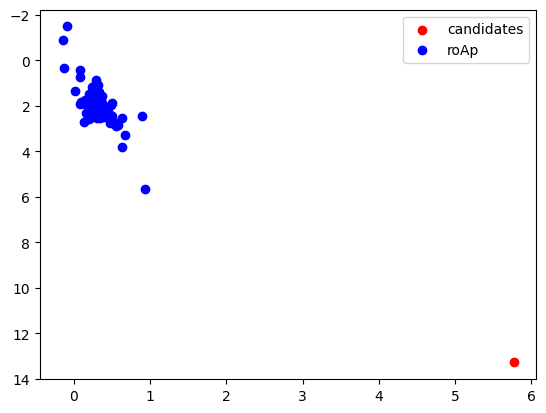

0.1273974957202173
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


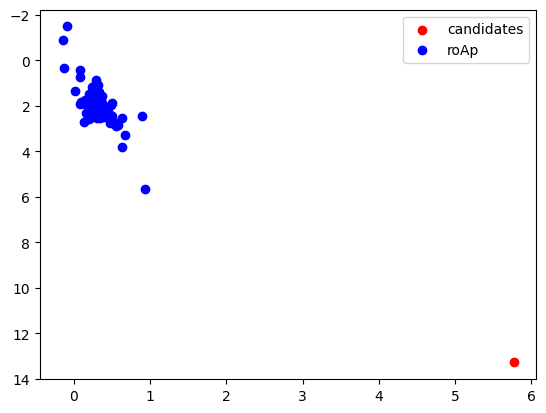

0.24910181163697054
0.110143076557921
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


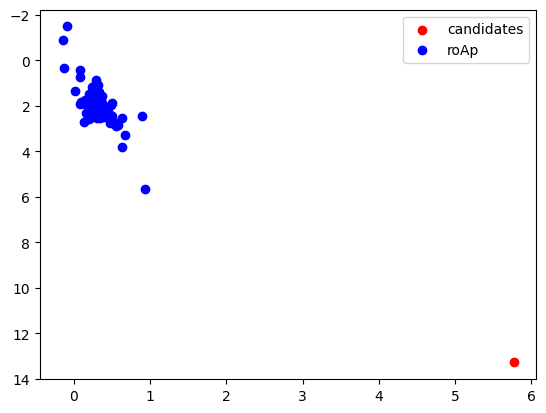

0.07863070496632596
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


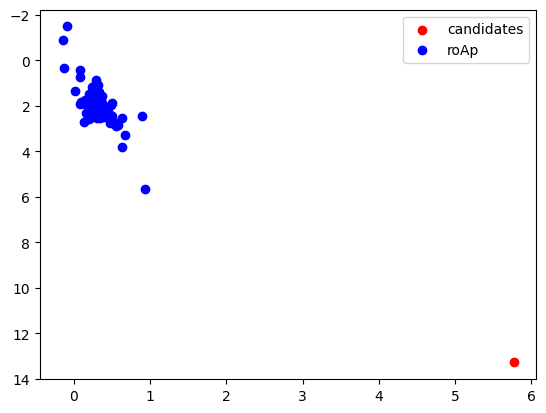

0.36019088007457767
0.4383735310374537
0.14086307720016533
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


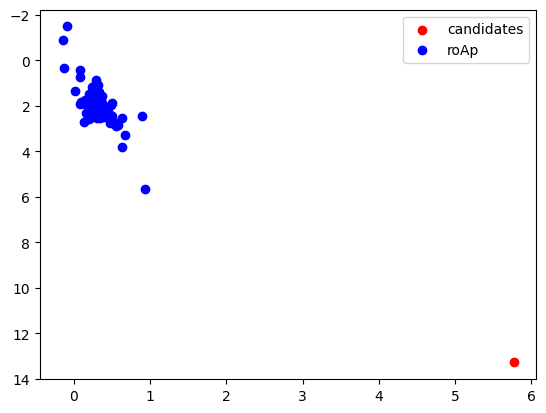

1.383532236074216
0.2127592624755581
0.7112197933115703
0.11691710641588537
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


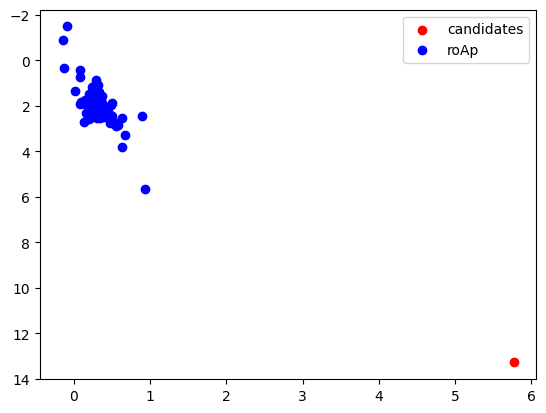

1.224517158458924
0.38768120032512265
0.18129978223285392
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


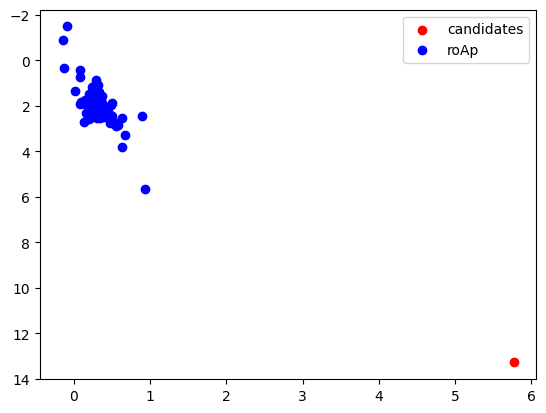

0.5928518413359258
0.08775956603065782
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


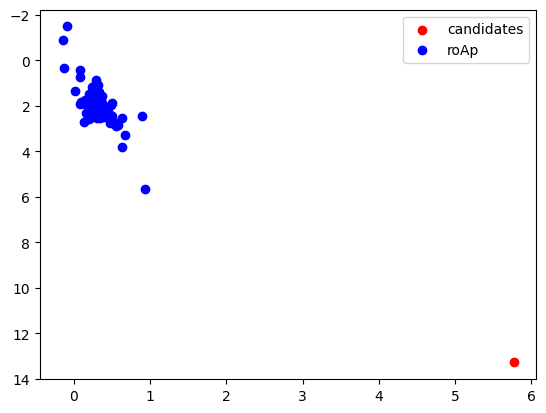

0.4438785108913994
0.3033360567337644
0.1258454091689556
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


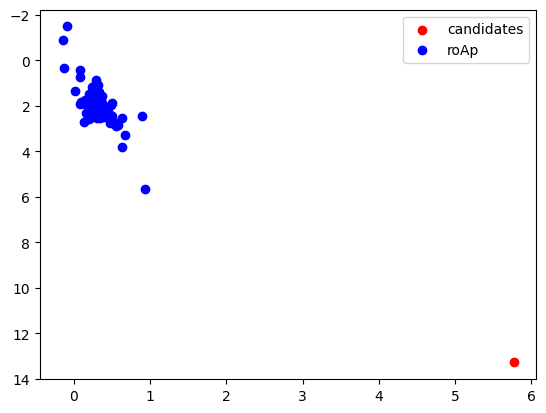

0.6713047200584878
0.2042562816584399
0.665491986933813
0.6020296244371723
0.08943664846103694
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


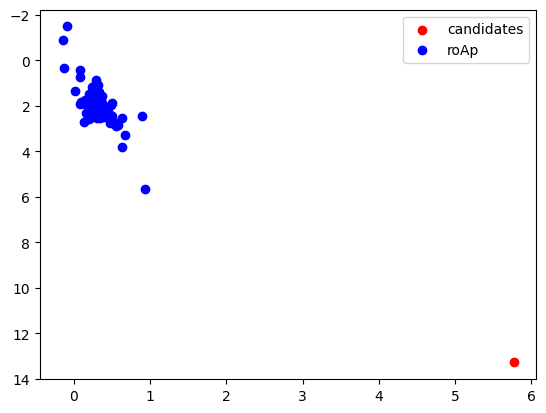

0.42862275903788416
0.5517828516622452
0.1980671486347274
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


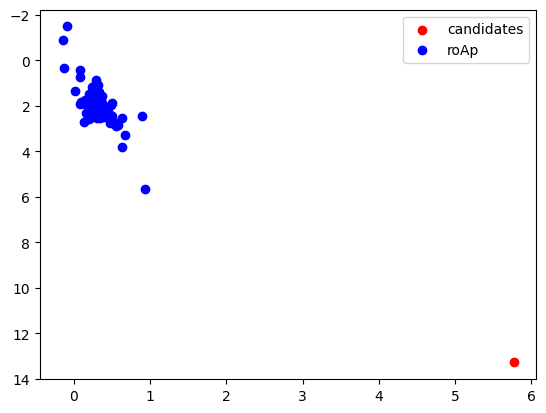

0.00652999206769489
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


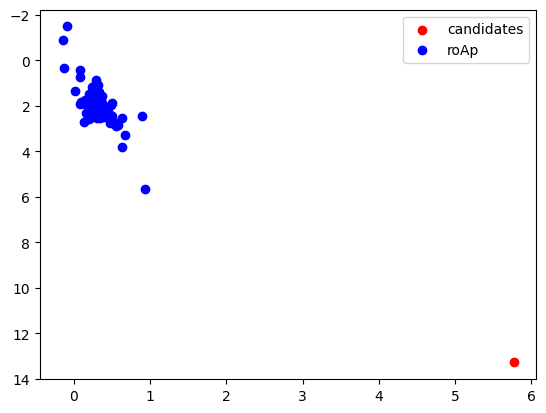

0.41883984310093414
0.45987822306740833
0.19390383472508543
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


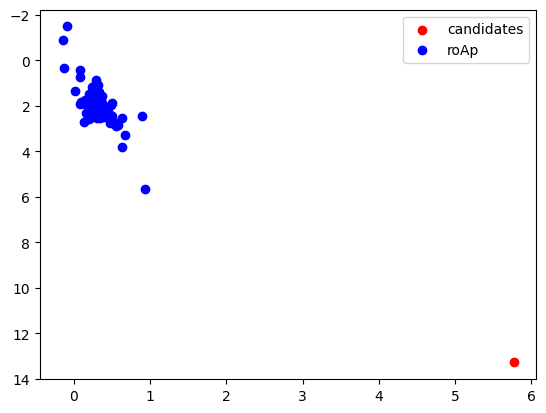

7.3909872449830285
1.6584077753643212
0.0971517390508394
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


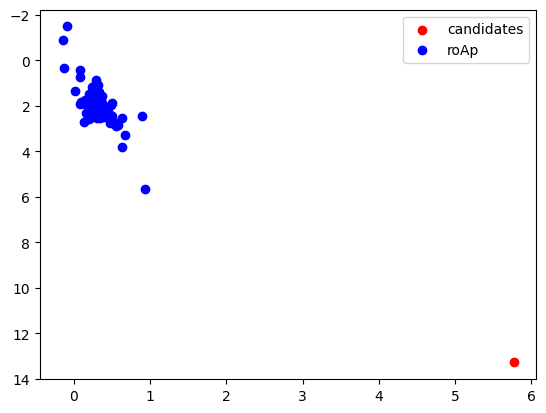

2.1425041816316837
1.0981278968529227
0.839642812655595
2.963444676057083
2.476537506940195
1.883635270321424
7.055273379342221
2.666518096233931
0.6873602700752486
1.3125212736899095
2.6540592756222683
0.5064774207285796
2.431854498351824
3.4826106121698635
1.0408339199684848
1.1990882591617489
6.026215600061563
2.618664191586473
2.8355783789219062
1.4787564505106279
3.489567910829498
2.0779901055418195
1.8308676870480511
1.493058332844748
2.528589304516479
6.445942650709572
1.3669901447070905
0.265762494489435
0.560441438065687
1.2413299889957934
1.8073677856112325
1.6644941941506002
5.2480908471886485
2.0866556077490976
0.45543481910238315
2.655656826308527
0.3962839488878138
2.1505368877879123
3.88477152107287
2.439697019902546
1.7080464688116843
1.2971716470745422
2.8040215660154315
3.6191527852180743
0.8734783829262345
4.831807866851273
6.235024465300484
2.3144518124214457
2.8764334900867095
1.1206492120468596
2.049891194553652
0.26284005595840654
1.7119538979793723
5.14722384823

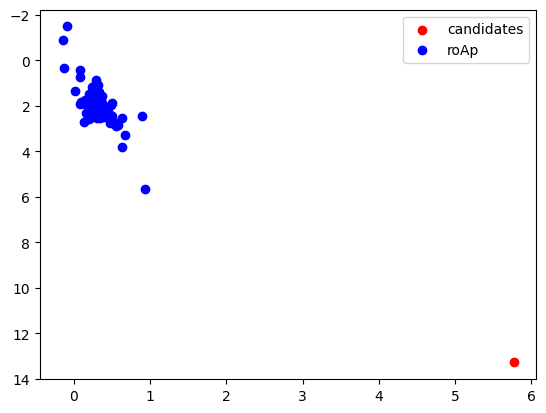

1.5779913197622186
2.474345197123988
1.8214034094976432
4.371415889643967
1.582863503565114
1.2734400662091983
0.36996585738757504
2.1992967627379674
0.7577527794262358
7.151952859076182
2.233612981375251
0.3950638209207098
0.05164178049393531
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


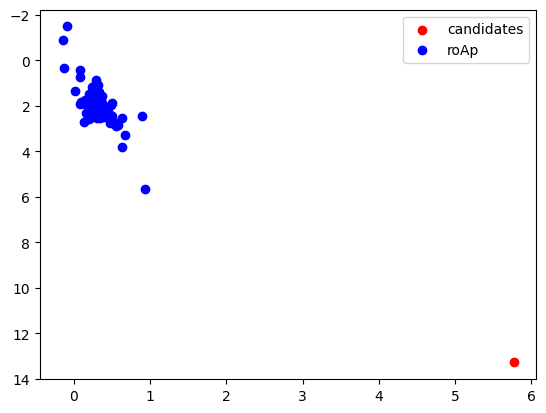

2.1527049922906913
1.2905912597240035
0.26185852322366565
1.7387215167289913
5.06692099198276
1.2717595258769008
1.21808597230093
0.6328355612173162
2.283182005374191
2.094933824941526
1.467839854154531
2.133074483100459
2.477668240867481
0.2994592372732836
2.4588261333146235
0.6043844556435396
0.7963567964422211
2.0101668173161347
1.1081696440236872
1.2913450823421944
2.206485740826129
1.6775097369711107
1.4568091470351299
0.2545722124717331
1.289681831519488
1.67624414486901
1.3276011839556496
1.9313992695190063
4.8018174835137915
2.039047214137839
2.3324951446311744
1.7525738718137307
2.5495891428663597
2.0397802893445203
1.5117379190074456
2.3831292024209523
3.612485950319577
1.9320631866873221
2.6331770059376085
1.6253230812200121
1.9152232043451642
2.72987723308308
1.7678024718619574
2.914041631350223
6.875137436809908
1.3193782931939142
2.2920653554023227
1.6980980849927134
2.9166903842196463
3.034359328597735
0.8793568161873575
6.736610428060587
1.6845085304537648
3.09161526856

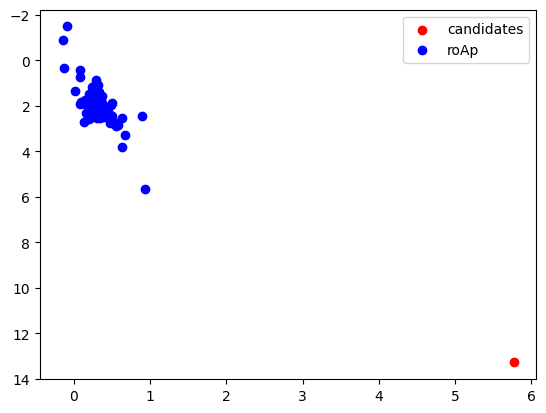

0.40548196799051195
0.3197714645514804
1.921195000958081
0.8445594377733703
1.2266546532544969
1.5132282747342363
1.698315932813567
2.019019046227002
1.661340587601104
0.7220948948446477
0.8564062097454921
1.7307164737881087
2.187858023192206
1.2425679178825482
1.3792933597324295
2.620901454127617
0.1531870396370134
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


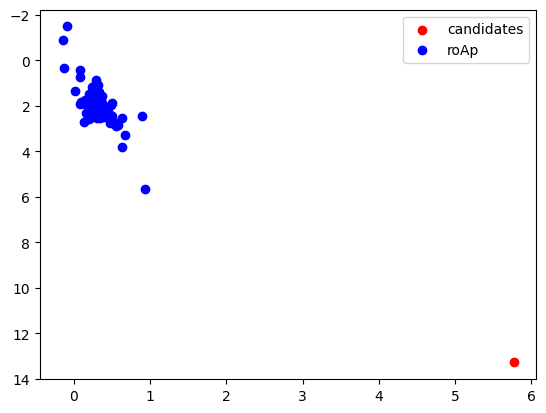

0.8397672971246541
1.9474231870084442
2.7916630245593996
1.2734850189341353
0.5113150255122918
1.8798073728978582
0.3994242352396953
1.1162917442197338
0.4939079472555312
1.412402770600224
2.079760551323993
2.1657447404246284
1.2619667476442535
3.768420037325657
1.0878129754306107
2.603750260612812
1.0269677332760712
1.773971368884218
4.15150370134536
0.8872788694822
1.1429111845969235
2.8287455647313307
1.8929335685797535
1.6625543111744305
2.2044732419096738
1.3673151874874112
1.5884929678881188
1.3527643362151738
3.1120099740752494
0.9821009444759721
1.2518039739063476
2.32220788642421
0.45398301170675226
1.5310883381422944
1.213148088361587
2.384737126812965
1.4419920373151822
1.1663523017011308
1.1364691133231164
1.5837660159657923
0.6904269176667288
1.2333595250740947
1.1608438639452665
1.5176232680724049
1.769258248569565
0.6310379636298544
1.5504076361598795
3.1035484880811506
1.0943380363504576
1.1469915088605263
1.5857819727841653
2.134810349863449
0.23047063610112928
1.95767

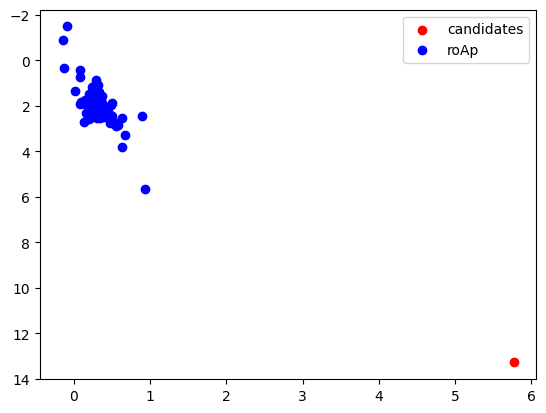

1.6938759867504605
1.4464527307897985
1.4404740183730447
1.2664447306284619
2.88954931206285
1.5979745349481178
1.6742869723832474
1.3205401482384655
2.968994608635967
1.4845933889487315
1.5019416828728798
1.6242061789003988
0.38138090302996663
1.4187583943260738
0.03387162253575271
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


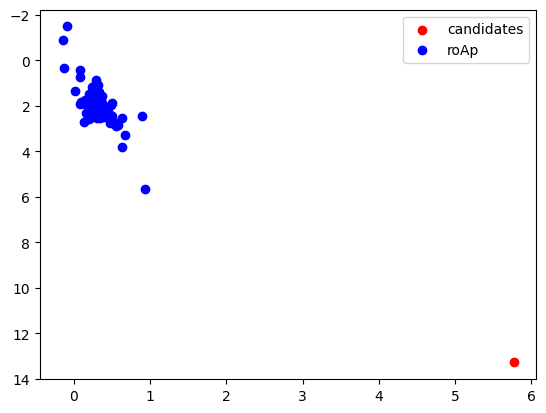

1.2458218035876751
1.0762250346923041
1.147198471565567
1.4308714247459051
1.1803602623721947
1.1912941482378836
1.496149697159715
1.1119560466242346
1.290791306625207
2.7678519119499336
1.5060738756652576
1.3367888293525925
2.199891521867916
2.600755717551557
1.6361463142243153
2.8938716894607355
2.2495884882378325
1.471066076644312
2.8801611083546454
1.514746293676373
0.7616666129877012
2.0084205768473895
5.822628166719287
1.9219834025954559
1.3964445532472347
1.5617841334711111
0.7080108603313813
2.5640812098059875
1.2512403358936635
1.6271108165117776
1.0458029250250924
0.8754009763928139
1.4508408083241309
0.7059776140034162
1.1363238814425476
2.9148576962029438
0.9382829227772371
3.2238834748382548
1.8170291635709843
0.6283160834100883
0.448357005285666
1.8081803925620348
0.19455340887566863
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


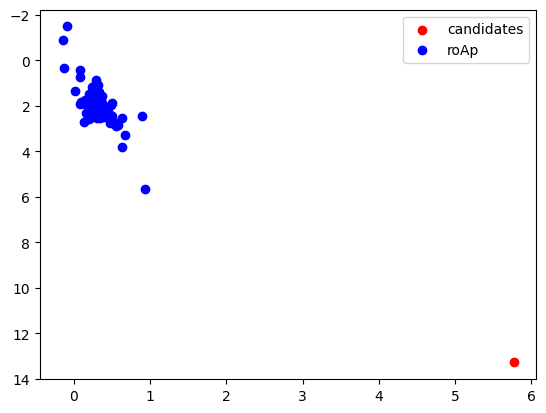

1.3728443726547852
4.7132917365032
2.148220093502646
3.7566839182149208
5.749092424524558
1.885983185723955
1.7681309725441967
1.4934905705845367
1.3577125938602717
1.5078789004666142
7.324038805942676
1.4673453741802132
2.94348912408653
0.3630609386667729
1.5995029275960093
1.160148825659687
1.7116392289048064
1.7475115034053286
2.126245126811802
1.8432296864060007
1.412662113244097
2.1104943835739105
1.410995404519473
2.662403192951145
1.9865631788217677
1.8689737661878
1.5903844402374328
1.4196539909229149
2.0909053692066983
1.2290164002647004
2.2623343147087143
1.4162341259257085
2.5760628399529226
1.805434818438899
0.9172208421928254
0.7477214059612252
0.5952619989729862
6.419130079235016
2.136847054093333
1.1378211529731754
7.641118038145727
8.654767406478406
2.400633101931425
2.5536037669935157
1.6899408943674257
1.9610749837819228
2.937396300906472
5.909089546284649
1.7530441464746211
2.9808794175291897
2.9560101869327218
0.9543201604642891
0.18930431376367785
ID: 100 --- Gmag:

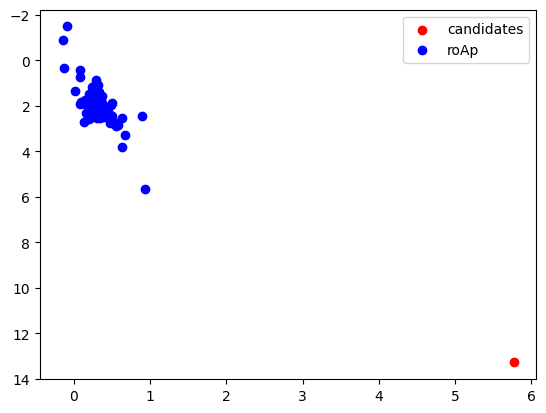

2.2768609606675243
0.5731590899111643
1.9491486800656797
1.6776307635382512
2.8009198279947087
2.2451243368612968
1.5498094191280123
1.6843148879463394
0.4741080008713021
4.20154300000519
4.306230980581951
1.7695763755460494
1.242471096628835
3.045293214463424
0.2019014504520722
6.665322322112759
0.181683097935728
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


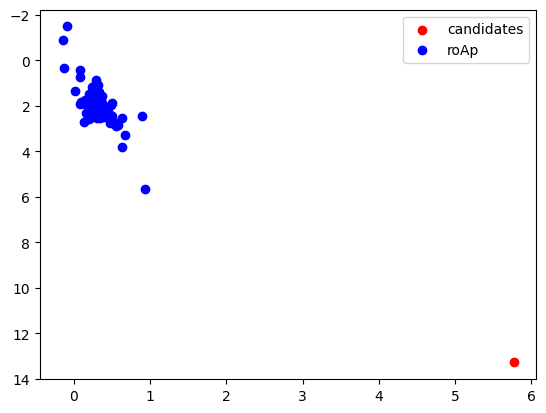

1.1027367686999683
1.0449661127608618
1.070934956167352
1.1379110584230505
2.653907127937863
1.6911234968234876
0.9683424641530844
0.48014549762066694
2.495887926075044
1.433928210041689
0.5577339008636526
1.2557840190143195
1.311449324095235
0.9599017255704958
3.493745056346814
1.0502567026958725
1.1730675472264844
0.6961986673784424
6.094889532159151
1.5846028282300229
2.9111127884254167
1.6954908269463094
1.4620374947356105
1.8694993672793834
2.4153706799072516
1.6909817228448365
1.890616774294487
2.5474936543038655
2.761026013563195
1.068071813378993
0.20168706053313712
1.3522767720446922
1.162316930162466
1.2486157883376674
2.2431014642390874
2.6082074961855097
1.7914026524544069
2.19446953166001
1.2308179671641384
3.1202155753273937
0.8959720349048255
0.41737766199954796
0.021537797803207637
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


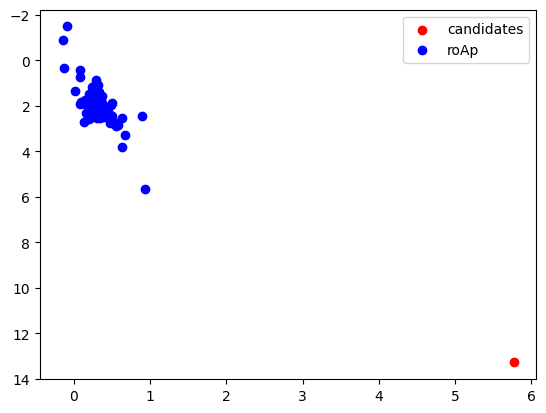

0.9254748540718254
0.1344728744551329
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


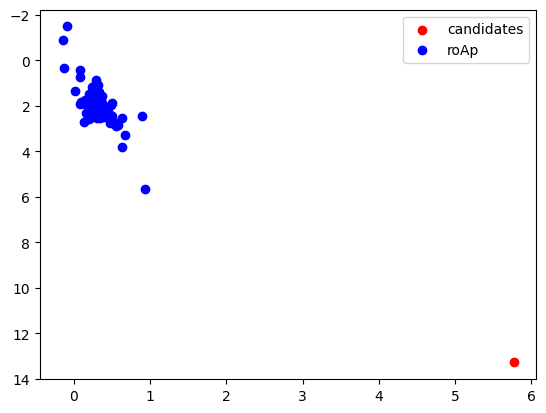

1.6776307635382512
1.5464379647576616
1.143201648358062
7.9673918315495555
2.3801761541827178
0.9363914504279227
4.509206365284687
1.579395227941052
1.3754101358781698
1.1252758848135553
1.6822297730896
6.9491019588425065
1.8144391950341714
1.3049104315677147
1.4019253277877521
4.038350776872582
5.418949238874143
0.1547806210112952
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


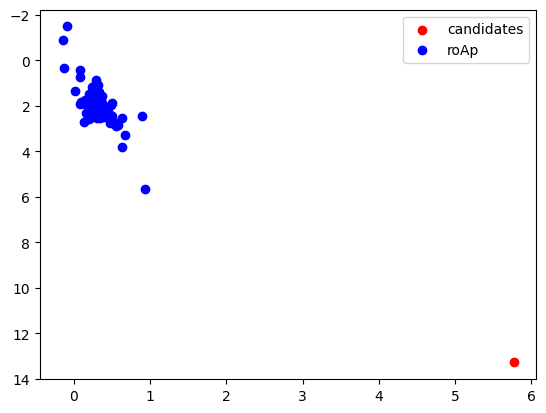

1.1651104035024002
1.958412399304826
0.7787382747583858
2.0026320490361424
2.856194390158856
1.58851025739771
2.9142145264461385
2.160962462071609
1.881045301784612
2.20227401628963
2.045786664976621
1.167317056336339
1.5181039164390502
1.5384502113263718
0.7990989126634391
2.4468894558926255
2.719347921741834
0.5900682302916882
0.7273681952700668
0.9641480291261779
3.1891765132842016
1.9909477984541815
1.8365282724883205
2.4384832963292196
0.09352734643039473
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


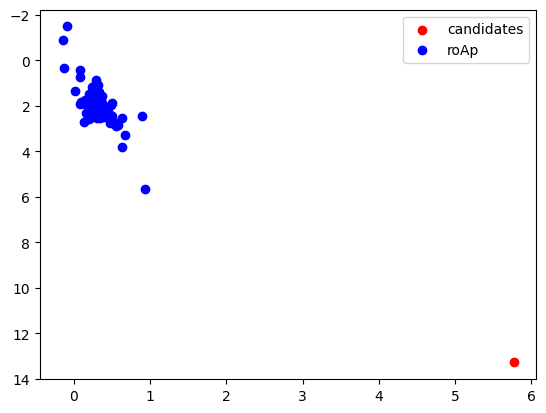

2.410446627575582
0.4860960354120163
2.699845354922579
2.206292098318703
1.5508640792130957
0.715621702453576
1.0168464543611846
2.8649325083064188
1.160560315987966
2.2121809052855808
2.0263601719995687
2.934211573239711
0.5469694521919612
2.4910364896836583
1.172642225290532
2.763401592181072
1.8182912977711665
0.33689499485093966
1.1822275294080813
1.308707207874017
2.5856446861685534
1.7221789139518073
0.6570097535282045
3.423082830646199
1.7421068027070137
2.5076655400087997
0.8630315498209693
2.4199039893221537
2.618242327552439
0.8334842893390892
2.717861023916962
0.7796447564710405
1.024024547333533
1.2210217310295735
0.6402498143402255
0.987806994051238
1.2330962131182452
1.463610840108441
6.983214161266611
1.1847241345930988
2.525695040610855
0.03966360824891768
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


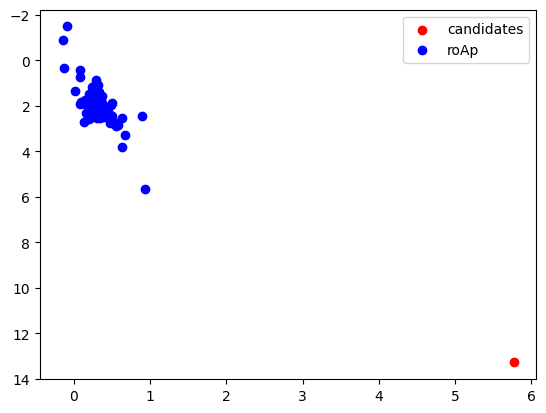

1.7005047847278558
2.2122258580105196
1.5915151741647195
4.175460045835395
1.514234524192463
1.2900449112209105
1.1532537692345814
0.3829957432258164
7.652964810117847
2.9900912682395617
5.651060905140539
6.006681912125043
1.6806702593244431
1.2787479456538
2.0083410451032684
5.094383649017958
4.668629475326339
1.5988839631526333
6.024355248829514
1.393360104736104
1.8037750255181113
1.5195354878332286
2.0938687911506877
2.2624760886873645
0.9345720826088346
0.35017974261101914
1.0855060434410415
2.1959080188580256
0.1766622243503455
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


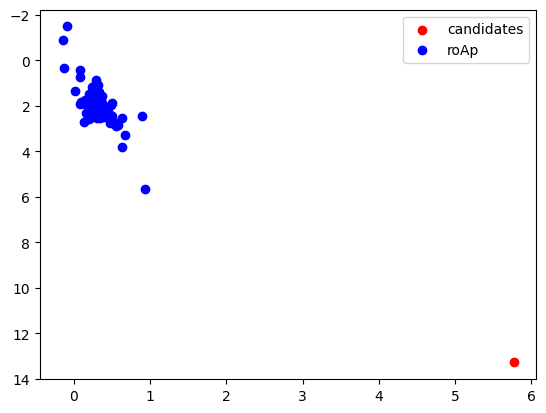

3.010548215988269
1.218435220394679
0.595369705342512
0.8430765092604744
1.3576434358219054
3.96149199093436
1.3525257409828104
1.5308359113022585
0.5331235015009992
2.241313728947323
2.68315060446099
1.5413513910358312
1.2298566704308496
1.726788297208911
2.0323907529450977
0.1499262381280495
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


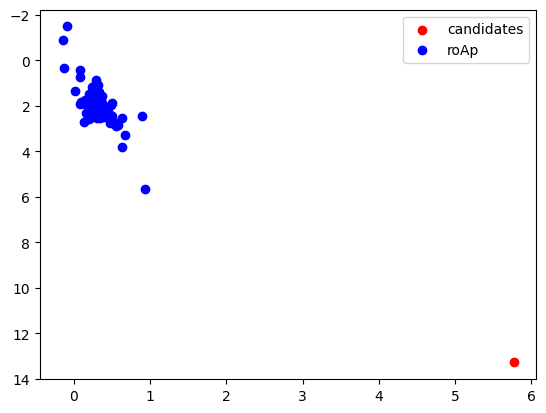

2.054749546748874
0.8540721259506344
1.7153046049382124
1.23042722424737
1.772788766428157
1.8593158461299677
2.659052485992305
2.494311122800295
2.9226033964999525
1.473064743953094
0.9122829582534824
4.472898395142458
0.36920908827752386
2.116054689858549
1.5301754520358612
2.1021504662450345
1.8728224110228766
2.2007006709167998
1.7912020941431452
1.5937143997847631
1.648148691782761
1.9776383339706156
2.483958164456883
5.60169589735478
1.9565347585631845
0.2846149757480474
1.496284555334529
3.066479779516894
2.22572896500151
1.548270652774365
1.3501674518745246
1.3166811296976342
1.7300110617967743
1.5096493462487877
2.608715807767502
1.2751690171683514
1.6106512033806333
1.9662514629536292
1.5656258625023505
2.424471877756238
1.6350812804334762
2.2264758718158646
1.3736085689787318
1.5204103370185609
2.6160154387170484
2.010000838024056
1.5773031972804754
2.044406962111216
0.7667329507080798
2.6873588710955705
1.1572925986751648
2.6693985285318806
2.4767864758783125
0.271443315931

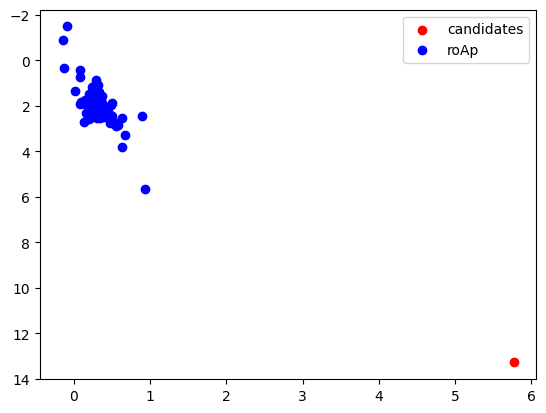

1.3358379063250576
1.1997348868204718
2.1050101511314745
0.3533995607070215
1.9675931288979316
1.952129391519261
1.4335582145364294
5.320696413767352
2.5586142668731426
7.068043411126531
0.4568110640658696
1.5318836555835056
2.6614073171986723
2.4052528588942836
8.287344580246717
2.643944912511219
1.4577254910434816
2.44363211228558
2.407389842279798
1.0470546855195197
2.914328637209442
2.300049650931695
1.8650179263932565
1.5021941097129166
0.037240130414242456
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


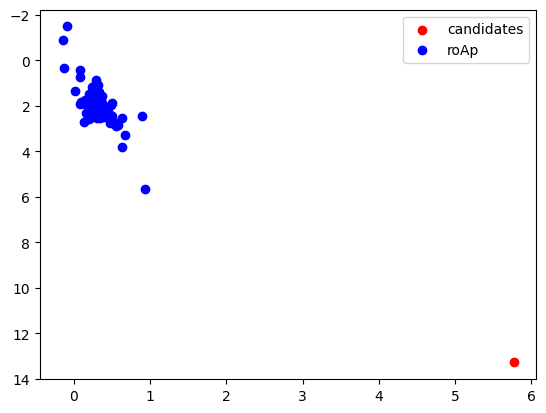

2.072294941082367
1.4044288487766068
5.732798790685493
0.8158242728322345
2.602342894532061
2.339210390156528
1.021933028083015
2.5785352398245127
1.3930938462883946
1.3872050393215167
1.3882942784257841
1.992268716986975
1.4867269144323274
1.7695590860364583
3.394492897585631
1.3844560072964625
1.2388299259088573
2.7504828706142748
2.217644390316507
3.599466949597149
1.9666767848895808
3.2009333798064477
0.788385821110464
0.021579292626227486
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


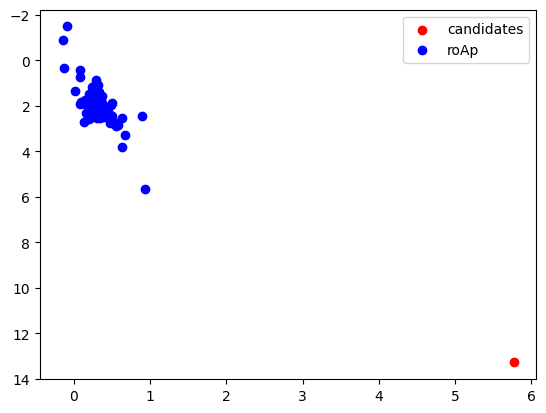

1.8743888405918698
1.7227875046894294
0.048519295061703493
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


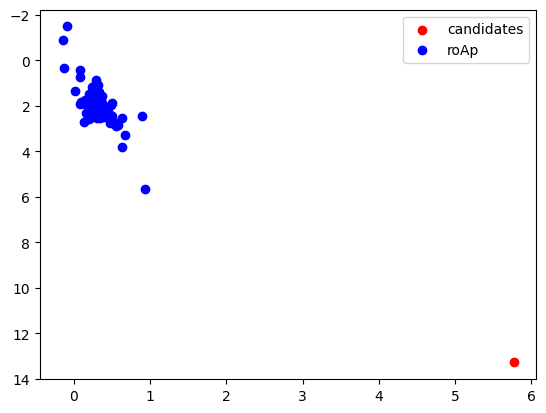

2.574205946622792
1.6967495032445739
0.9749124777978688
2.9021326171435717
1.2996060100250315
1.3840756380854489
1.2210113573238186
2.7177918658785956
1.2603341065287539
1.6449639641159994
1.9014745863179734
1.1905126624043458
1.9171907505366808
11.415037612767422
2.8538118957371417
1.2373603175935763
1.8150443278698758
5.7425881110162225
1.8557092544291722
1.1198435208998945
8.213407721429464
1.4759348025452887
1.4673177109648663
0.44847457395088797
2.9441979939797838
1.8941887869760994
1.359483039642445
1.7361419218979333
1.9909028457292435
1.5821961284948804
2.0611708706111713
3.397362956177827
0.8572361062058859
2.9616050722365435
1.408612910097759
2.3590276260503487
0.8433047307870829
2.0289328510267897
1.6105232610096565
3.0676381766595266
0.0014849131688838835
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


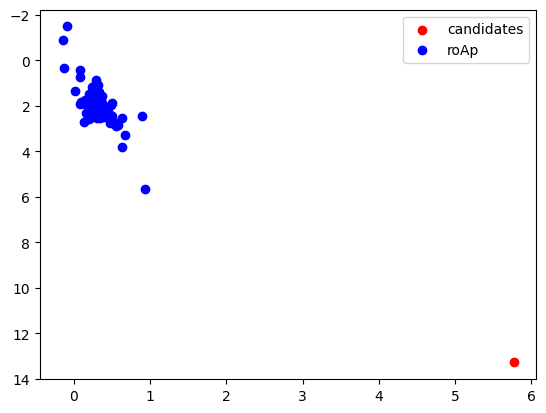

2.3745536056635492
0.7627944004231277
1.5457187211586538
7.054104608493834
1.8110262458408022
0.4108382580619705
2.659903129864208
1.4786769187665068
0.9988688222879036
1.63936562091026
2.8750157503002036
5.755721222501954
2.993234501083303
1.5044763249789999
1.6794634515549538
1.4280463188786474
1.0716956945893792
0.9931356209073494
1.4098473810825942
1.482169399703997
1.310588306517576
1.2078466133107635
1.4218255533276125
1.2476406599967051
1.3497732510558376
1.6939278552792347
1.5646126972402865
1.286866587947928
0.5123385644801106
1.6115467999774753
1.4912152711222906
1.588849131785704
0.7651146526103123
1.273370908170832
1.1147633515718418
1.6308833875046507
2.306553964440031
0.8300333032246183
1.5928188031879211
2.060019389272375
1.220416598193869
1.3548321615623211
2.008693751098936
1.6536398400290333
1.8493392876855916
1.1250027105620088
1.015771046864591
2.1585557623364675
0.023995854657066218
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


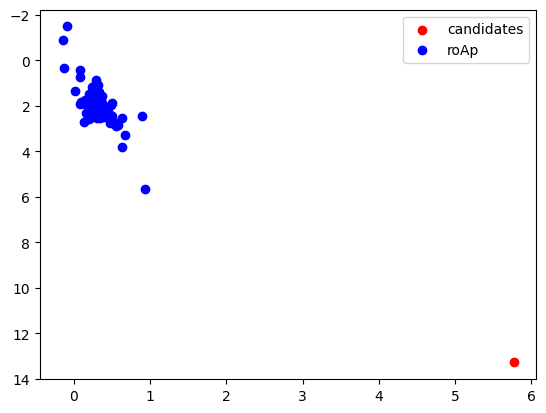

1.10646835627988
1.719429881926753
2.3239783322063827
1.4815850142798033
1.2563580307327584
1.2991841459909976
0.19584320629119745
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


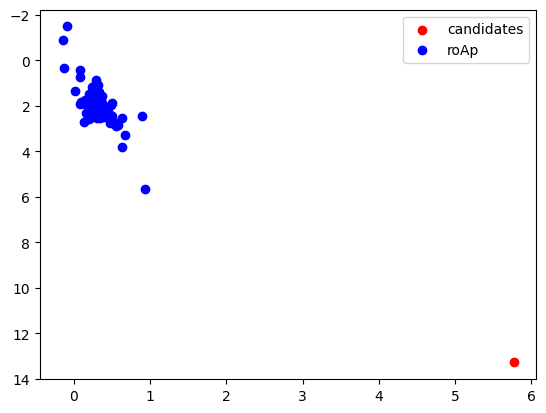

1.0227140025064945
0.9278746380031315
1.402948866755571
1.2626133753029773
1.4563665355895863
1.3249040204593696
1.3697391767321456
2.305219214299565
1.5620745972322487
1.8002860024825387
1.7618445068567141
1.6435531401333299
1.7873569072099873
2.394478036516838
1.0203147299852475
1.2532217136928534
1.4859800076179728
3.4459914308549857
1.8981342530648881
1.5916500323395335
4.8870962606230925
1.812219222002618
0.32818453991872265
1.0200450136356196
2.223713008183137
1.124625799252913
0.32621648231714784
2.6759581684709097
2.654266749737367
1.6284905193771826
2.943748466730404
0.3775772109198281
1.179236444248745
0.5186665249906135
0.2700122559470348
2.1150830194195045
1.6953455950657406
3.749449987401821
3.0341034438557806
1.9292934072507573
2.1715505577454675
1.5876526977219696
1.8402939276773573
2.97771197937202
0.18108833880577913
ID: 100 --- Gmag: 13.284124 --- B-R:  [5.7675087]


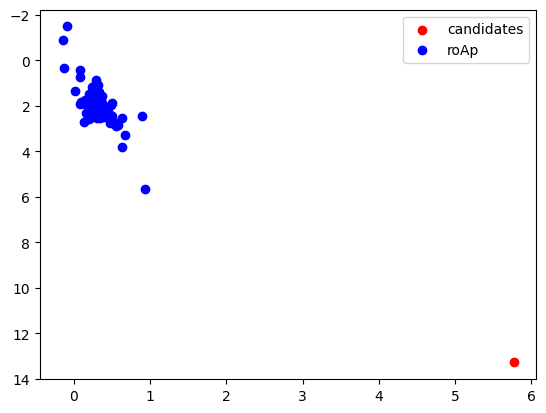

2.616029270324722
2.22726081555132
2.726166904324736
1.692949269036354
1.4775773059564854
1.527561278185621
0.832491871488535
5.321650794696804
0.6676225659255486
5.9292249091549545
2.7002533873489387
8.067207628323422
2.8688330216702704
2.0669490247166635
1.3493721344333134
2.7873994314941273
0.9716516762889051
2.365414370893463
2.299375360057625
1.4536071298587772
2.3728765232331703
1.6757358332870187
1.4902297690755726
1.533501953681273
1.7594723861407549
4.69085686885722
0.5658634282735935
1.832894017572179
1.7323728088069779
2.5925155372802307
1.1736553905525968
1.6259973720940828
2.0225979747124505
3.6688774148033367
1.4638217721254574
1.674165945816107
1.4000061922230913
0.9576051672866813
0.31083970389649207
0.630297972619337
1.2848891794607138
0.9287356555807895
0.773558337684761
2.249702599001136
0.7936077644171664
2.3414096157765716
1.7176767256541707
8.308289092165907
1.4449727487687627
2.444230329317447
1.8624729105813824
2.983261911950904
1.632823270480822
1.5474649616273

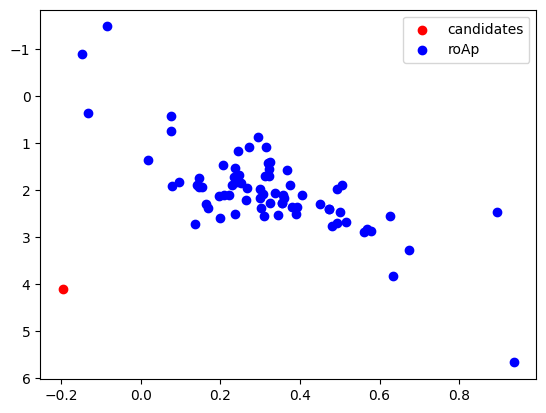

0.5497164470816469
0.03406373931786755
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


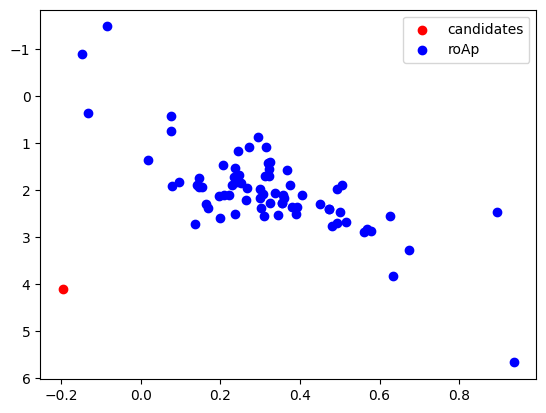

0.8651635495792549
0.800009866593264
0.09287929800512185
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


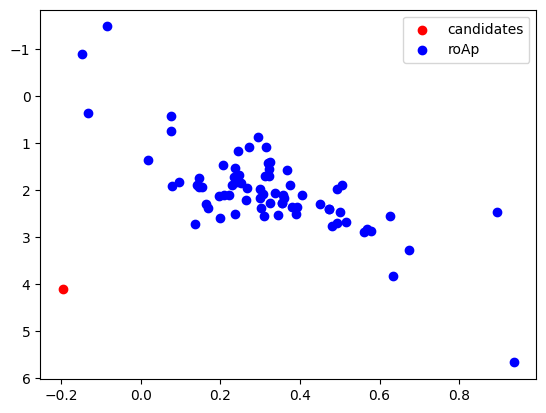

0.31742151201358126
0.5869130980168815
0.8728539234455708
0.1329287180229599
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


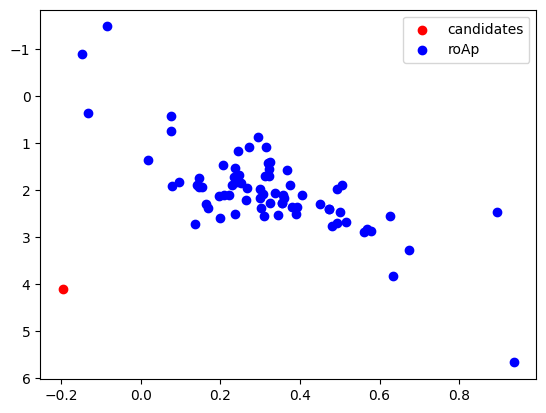

0.19679260359342177
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


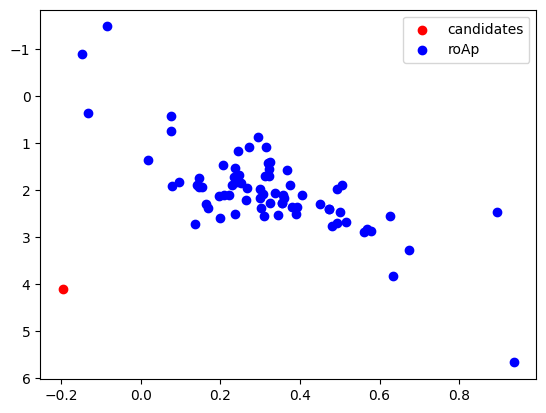

0.3717762722674578
0.1621030365077205
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


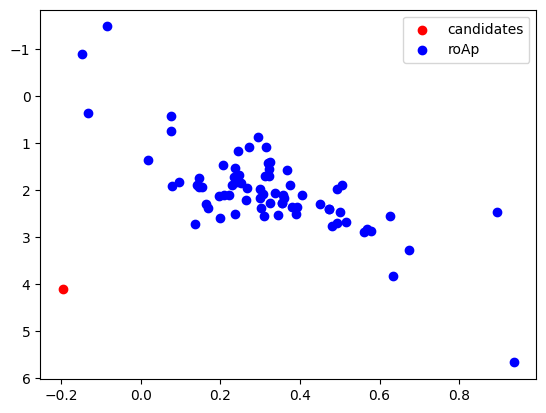

0.5645647828776204
0.37572875911884385
0.8302699662803739
0.44633555343000575
0.11702918004382101
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


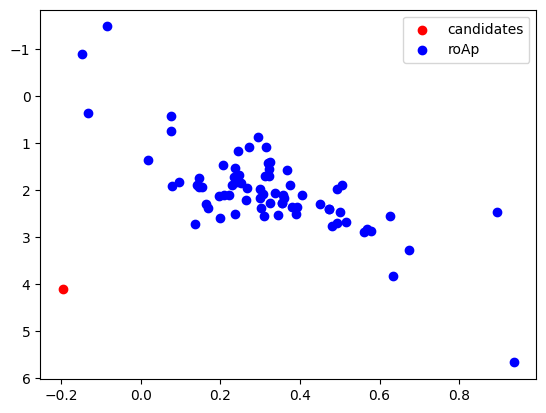

0.06900248525920771
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


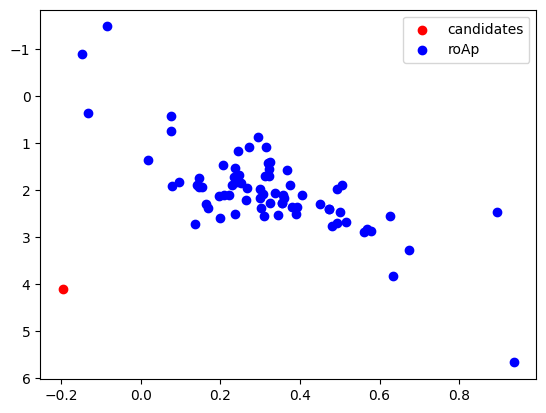

0.34449688403392953
0.05070316334876379
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


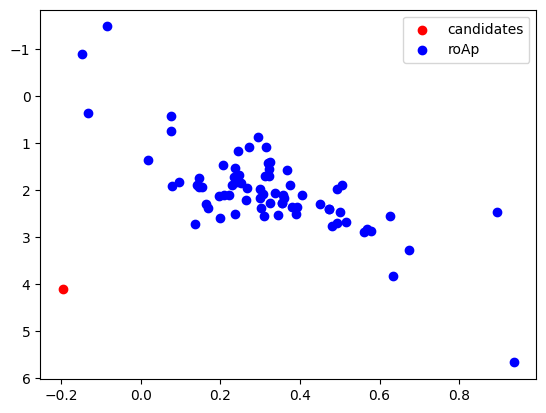

0.5966679442871876
1.9576981393330462
0.6405451567698319
0.10450130635255306
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


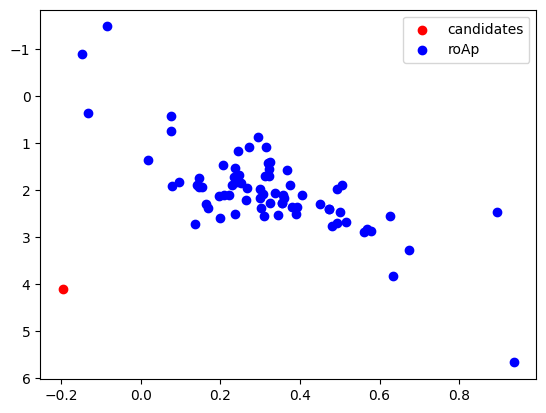

0.6015849758562606
1.0699266695737557
0.10224319144113792
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


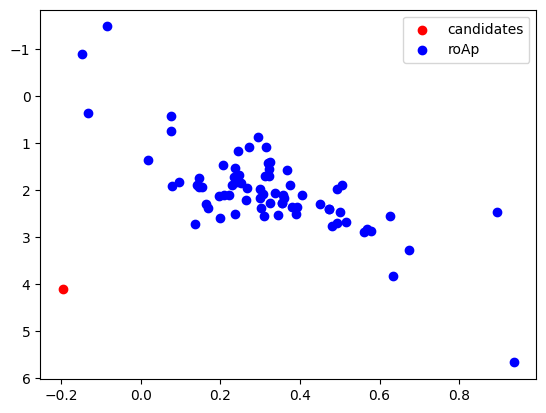

0.2680981040096029
0.5249614322072436
0.6111842165402428
0.4956280502342407
0.09220846503296976
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


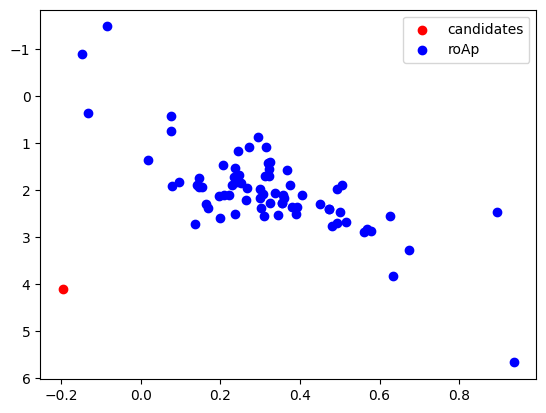

0.4249691774767832
1.1918731435835506
0.022462583340706388
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


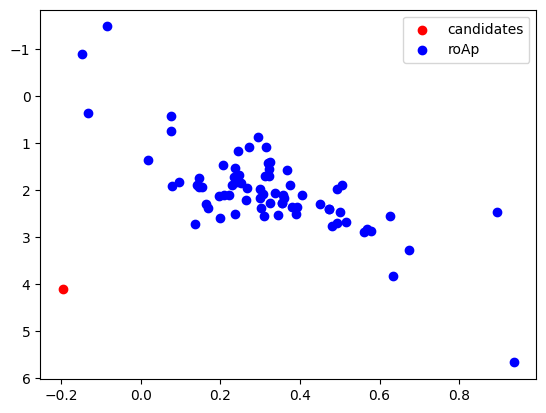

0.07688293877227026
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


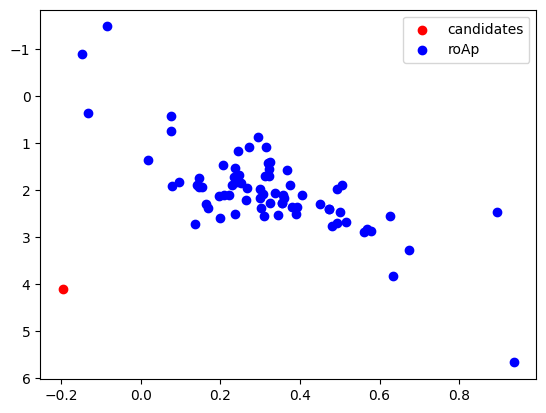

0.21100468543642625
0.1529014545443439
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


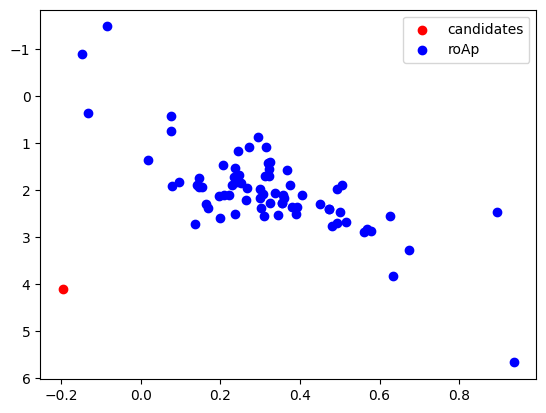

0.056675064920441276
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


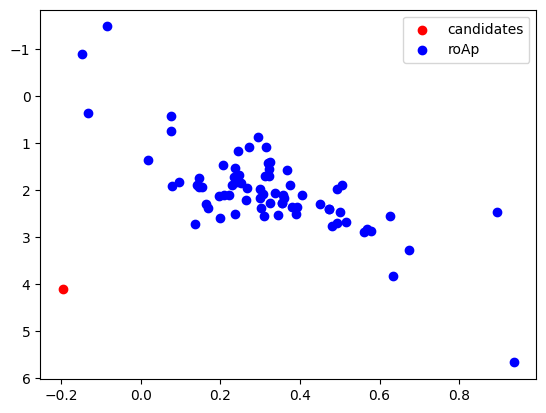

0.6443282064272209
0.41962682397175843
0.1966439138109346
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


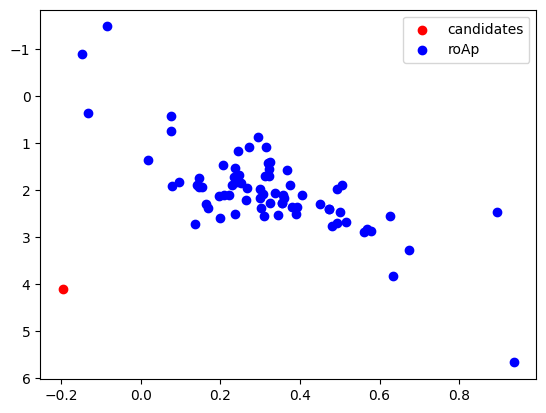

1.054549484701802
0.862158737771006
0.916703577671629
1.0304894031542187
0.5026579648341598
0.023496391055519705
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


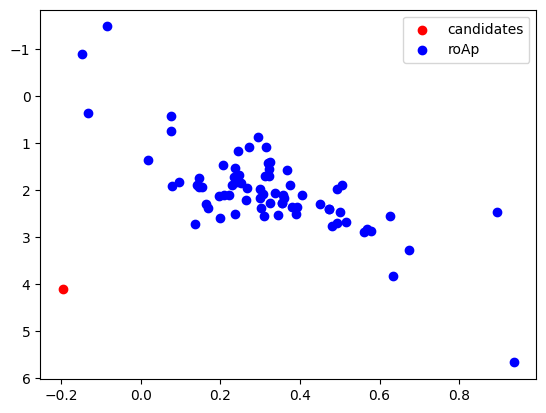

0.05920614416588199
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


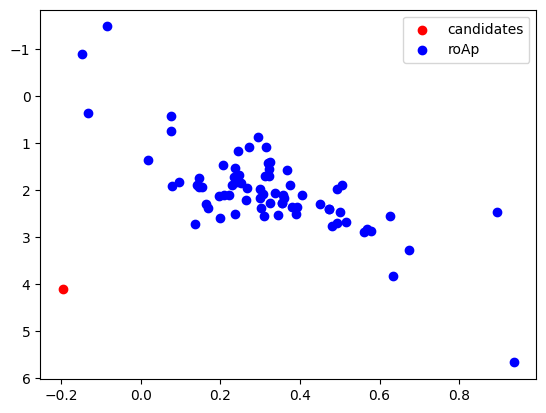

0.387112067275152
0.2254551525942734
1.642365042639982
0.3188842045250255
0.33491849572021737
0.4566228116369706
0.09737792344207907
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


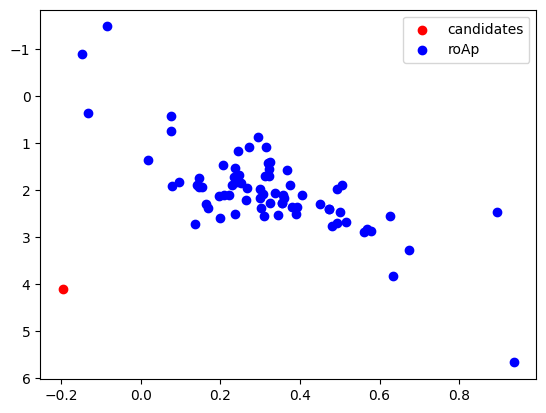

0.286151704966326
0.1526698800745776
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


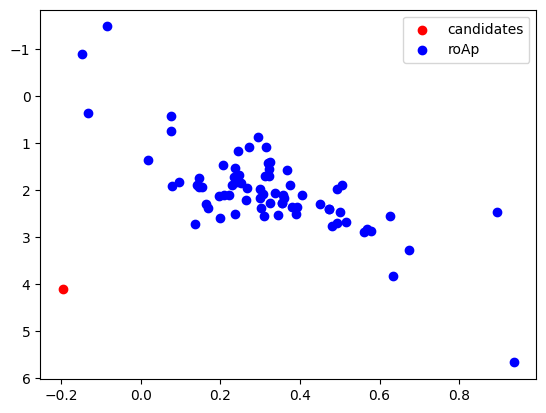

0.6458945310374538
0.06665792279983473
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


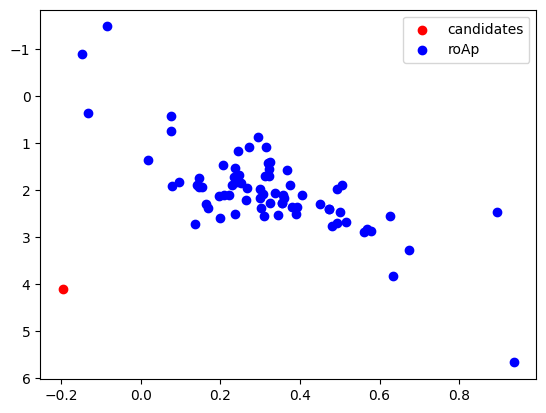

1.591053236074216
0.42028026247555816
0.5036987933115702
0.09060389358411469
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


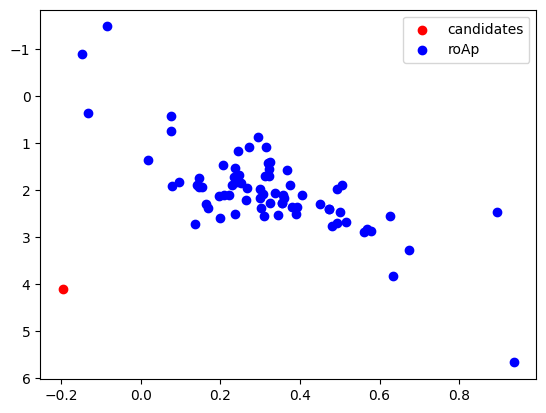

1.4320381584589241
0.1801602003251226
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


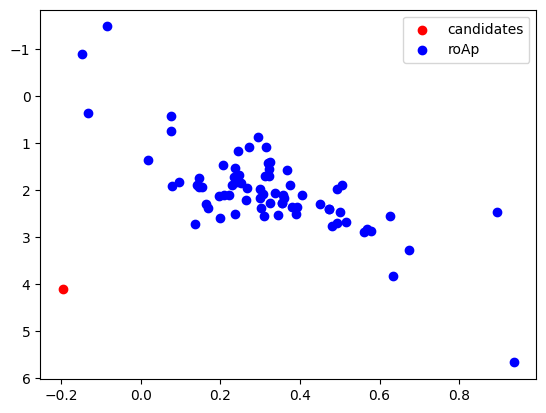

0.026221217767146143
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


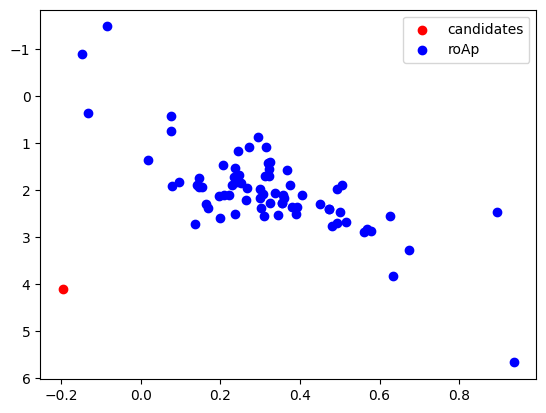

0.8003728413359259
0.2952805660306579
0.6513995108913995
0.09581505673376434
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


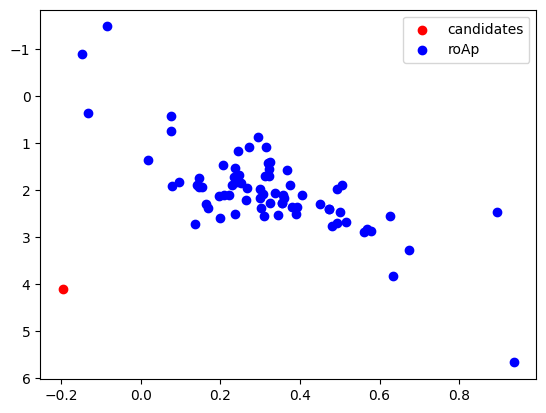

0.08167559083104448
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


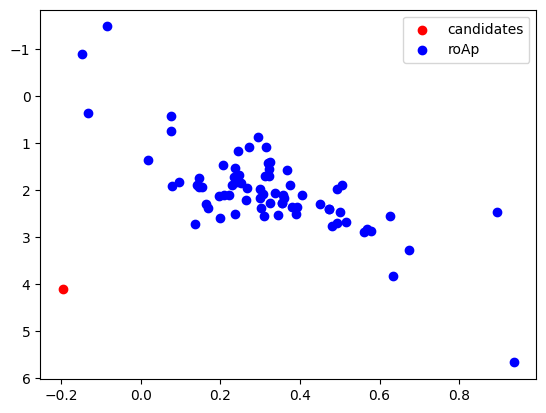

0.8788257200584879
0.41177728165843996
0.873012986933813
0.3945086244371723
0.296957648461037
0.2211017590378841
0.3442618516622451
0.009453851365272659
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


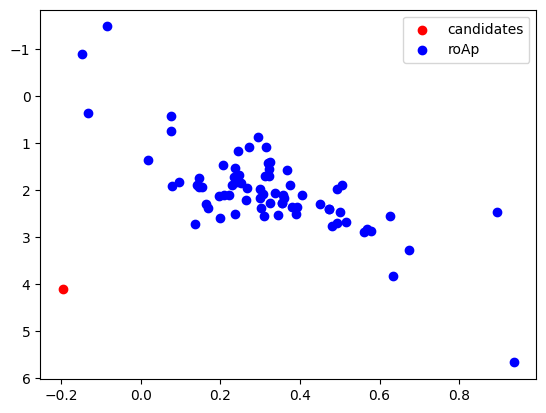

0.21405099206769496
0.6263608431009342
0.6673992230674084
0.013617165274914633
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


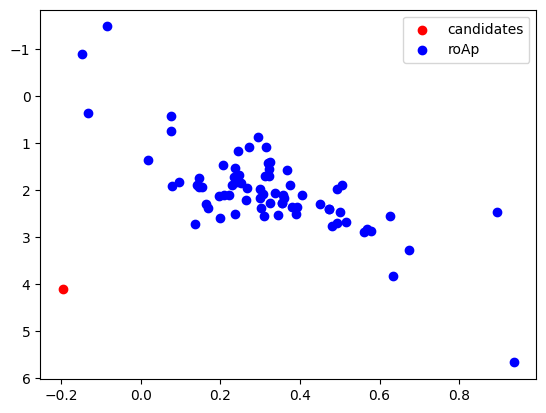

7.183466244983029
1.865928775364321
0.11036926094916066
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


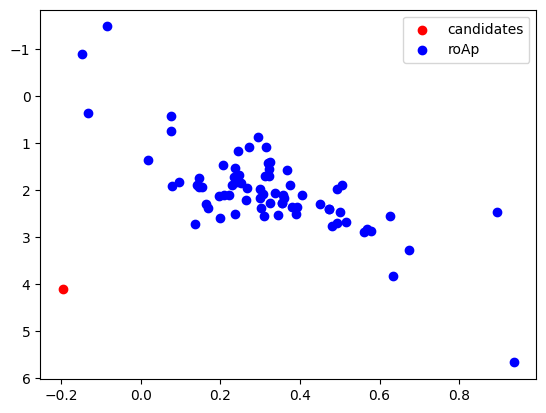

1.9349831816316838
0.8906068968529226
0.632121812655595
2.7559236760570833
2.2690165069401953
1.676114270321424
6.8477523793422215
2.458997096233931
0.4798392700752485
1.1050002736899094
2.4465382756222684
0.29895642072857953
2.2243334983518244
3.2750896121698636
0.8333129199684848
0.9915672591617488
5.818694600061563
2.411143191586473
2.6280573789219064
1.2712354505106278
3.2820469108294983
1.8704691055418197
1.623346687048051
1.285537332844748
2.321068304516479
6.238421650709572
1.1594691447070904
0.05824149448943494
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


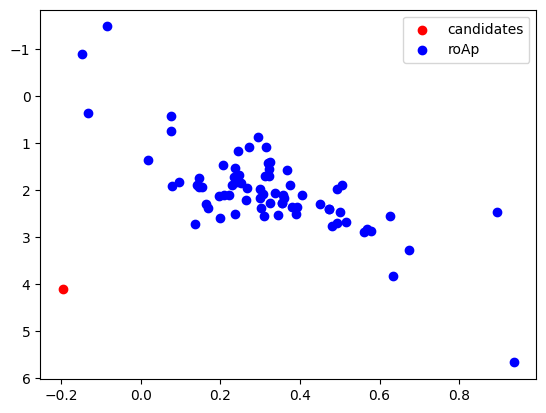

0.35292043806568696
1.0338089889957933
1.5998467856112324
1.4569731941506001
5.040569847188649
1.8791346077490978
0.6629558191023832
2.448135826308527
0.6038049488878139
1.9430158877879125
3.67725052107287
2.232176019902546
1.5005254688116842
1.0896506470745422
2.5965005660154317
3.4116317852180744
0.6659573829262344
4.624286866851273
6.027503465300484
2.106930812421446
2.6689124900867096
0.9131282120468596
1.8423701945536521
0.4703610559584066
1.5044328979793722
4.939702848231616
3.42837494630652
1.003915426912025
0.4842066001980707
1.3758681046566963
2.0511099017542067
2.480176745483565
0.9654531838746898
1.4126290599502243
3.1954921679123416
0.9478455473066676
0.9783788212453235
1.5203184993920766
1.9112896376874406
5.88712647902487
0.8065660486303754
1.350784379182533
1.577439476221839
0.872411416958788
1.4644180569807173
0.8762877250092105
0.5761591280097056
1.1242642452768008
0.29441263264916273
1.3704703197622186
2.266824197123988
1.6138824094976432
4.163894889643967
1.375342503

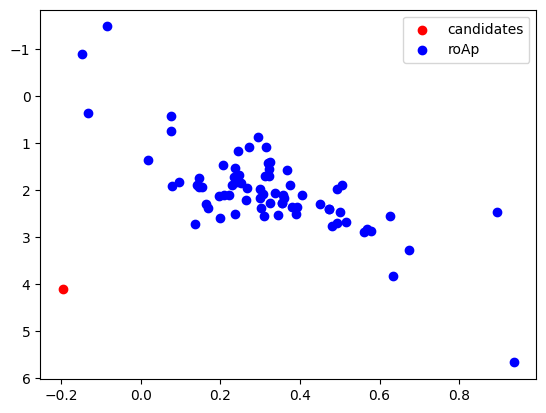

0.2591627804939354
1.9451839922906915
1.0830702597240034
0.054337523223665585
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


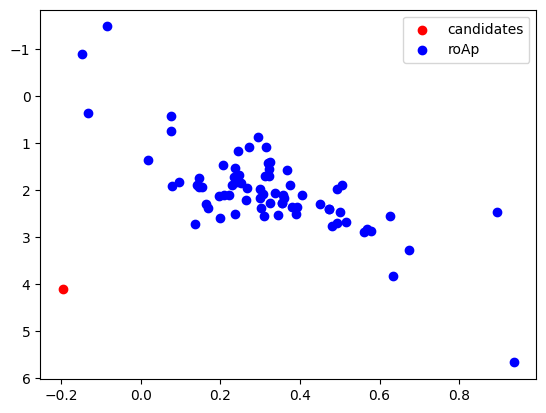

1.5312005167289913
4.85939999198276
1.0642385258769007
1.01056497230093
0.8403565612173163
2.075661005374191
1.887412824941526
1.260318854154531
1.925553483100459
2.270147240867481
0.5069802372732837
2.2513051333146237
0.39686345564353953
0.5888357964422211
1.8026458173161348
0.9006486440236872
1.0838240823421943
1.9989647408261293
1.4699887369711107
1.2492881470351298
0.4620932124717332
1.082160831519488
1.46872314486901
1.1200801839556496
1.7238782695190062
4.594296483513792
1.8315262141378392
2.1249741446311745
1.5450528718137306
2.34206814286636
1.8322592893445204
1.3042169190074455
2.1756082024209524
3.4049649503195774
1.724542186687322
2.4256560059376087
1.417802081220012
1.7077022043451642
2.52235623308308
1.5602814718619573
2.706520631350223
6.667616436809908
1.1118572931939141
2.084544355402323
1.4905770849927134
2.7091693842196465
2.826838328597735
0.6718358161873574
6.529089428060587
1.4769875304537647
2.884094268561072
1.928171114852618
2.2060239076943855
4.905649430140124


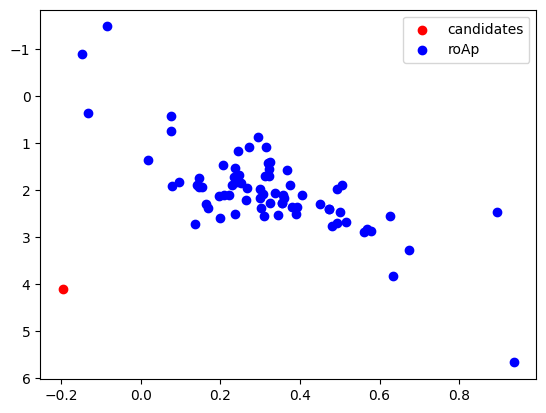

1.7136740009580809
1.0520804377733703
1.0191336532544968
1.3057072747342362
1.490794932813567
1.811498046227002
1.453819587601104
0.5145738948446477
1.0639272097454922
1.5231954737881086
1.980337023192206
1.035046917882548
1.1717723597324294
2.4133804541276174
0.054333960362986655
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


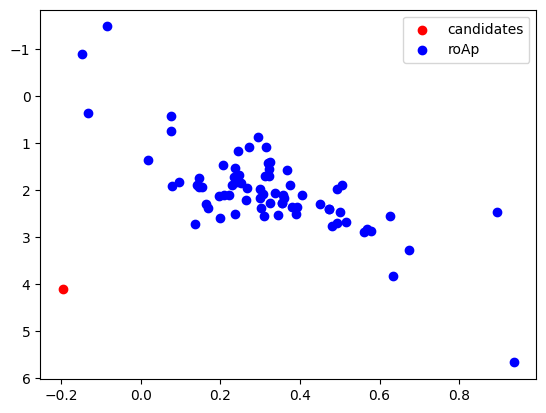

0.6322462971246541
1.7399021870084441
2.5841420245594
1.0659640189341353
0.30379402551229173
1.672286372897858
0.1919032352396952
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


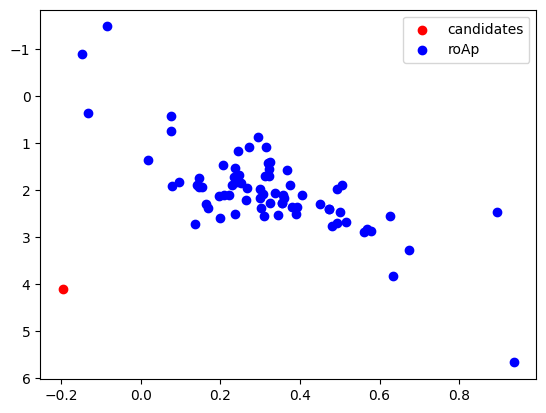

1.323812744219734
0.28638694725553115
1.204881770600224
1.8722395513239931
1.9582237404246285
1.0544457476442535
3.5608990373256573
0.8802919754306107
2.396229260612812
0.8194467332760711
1.566450368884218
3.9439827013453606
0.6797578694822
0.9353901845969235
2.621224564731331
1.6854125685797534
1.4550333111744305
1.996952241909674
1.1597941874874111
1.3809719678881187
1.1452433362151737
2.9044889740752495
1.1896219444759721
1.0442829739063475
2.1146868864242103
0.2464620117067522
1.3235673381422943
1.005627088361587
2.177216126812965
1.2344710373151822
0.9588313017011307
0.9289481133231163
1.3762450159657922
0.8979479176667289
1.0258385250740947
0.9533228639452664
1.3101022680724048
1.5617372485695649
0.42351696362985436
1.3428866361598795
2.8960274880811507
0.8868170363504575
0.9394705088605262
1.3782609727841653
1.9272893498634494
0.43799163610112934
1.750154866196226
0.6538338738418878
0.33048211251778925
0.9379870689375727
2.2498839356261993
0.7465749082496576
0.6727451394331119
3

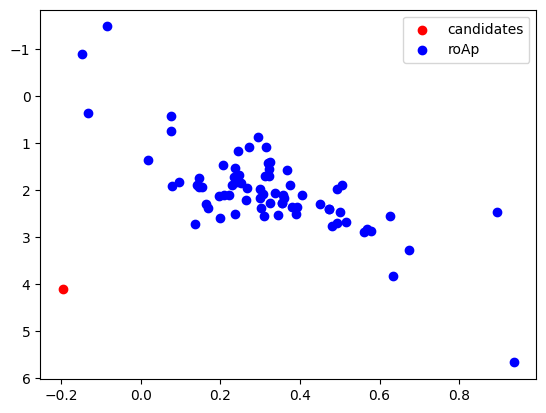

1.1509073795573617
1.7035665536508686
1.7451442613578378
2.085298073061753
0.06309638878273827
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


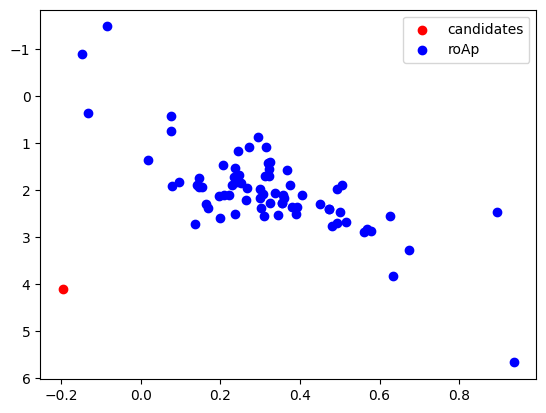

1.5954033816462072
1.2223234278761668
0.8833937134513326
8.368803901461598
2.5990939924541614
1.4121552224286558
1.0123595184377714
1.7381628623435352
2.2095198465337944
2.8249364825426655
1.2055940983953954
2.293996390398049
0.21228756704811858
2.3712078823319382
2.3055423249032776
1.4541653777929353
1.7730565506011775
0.931880414149842
2.419694583030447
1.6316871464750085
0.8172475076560275
1.1768865966696058
1.415381549877197
1.6083774296436975
1.1290326920221476
1.3803080507198038
1.488204964276754
3.0352875720371513
2.3241942478506283
0.49809688724515144
0.7185486132017744
0.36463224690423446
1.4863549867504604
1.2389317307897985
1.2329530183730446
1.0589237306284618
2.68202831206285
1.3904535349481177
1.4667659723832474
1.1130191482384655
2.761473608635967
1.2770723889487314
1.2944206828728797
1.4166851789003987
0.17385990302996657
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


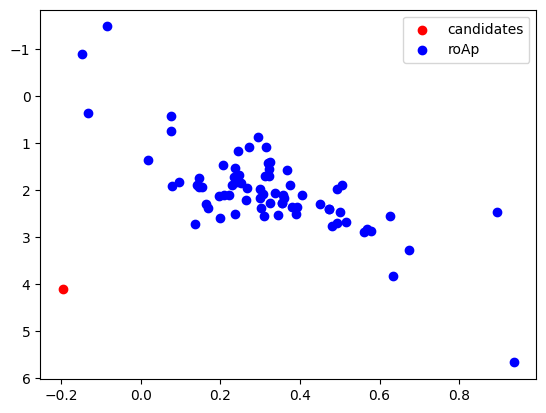

1.2112373943260737
0.24139262253575278
1.038300803587675
1.2837460346923042
1.354719471565567
1.223350424745905
0.9728392623721946
0.9837731482378835
1.288628697159715
0.9044350466242346
1.498312306625207
2.560330911949934
1.2985528756652576
1.1292678293525924
1.9923705218679162
2.3932347175515574
1.4286253142243153
2.6863506894607356
2.0420674882378327
1.263545076644312
2.6726401083546456
1.3072252936763729
0.9691876129877013
1.8008995768473897
5.615107166719287
1.7144624025954558
1.1889235532472346
1.354263133471111
0.5004898603313812
2.3565602098059877
1.0437193358936634
1.4195898165117775
0.8382819250250924
0.6678799763928138
1.2433198083241308
0.4984566140034161
0.9288028814425475
2.707336696202944
0.7307619227772371
3.016362474838255
1.6095081635709843
0.8358370834100883
0.24083600528566596
1.6006593925620347
0.4020744088756687
1.1653233726547851
4.5057707365032
1.940699093502646
3.549162918214921
5.541571424524558
1.678462185723955
1.5606099725441966
1.2859695705845366
1.1501915

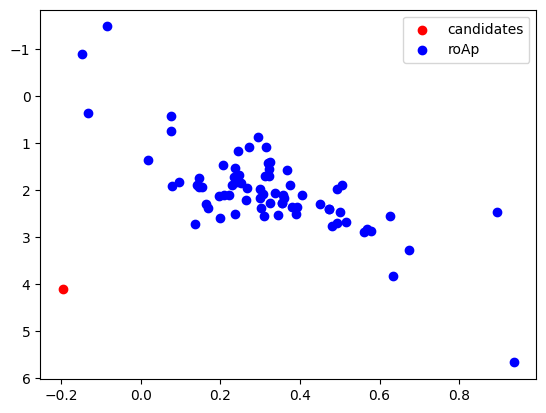

1.3919819275960092
0.952627825659687
1.5041182289048063
1.5399905034053285
1.918724126811802
1.6357086864060006
1.205141113244097
1.9029733835739107
1.203474404519473
2.4548821929511453
1.7790421788217676
1.6614527661878
1.3828634402374327
1.2121329909229148
1.8833843692066985
1.0214954002647003
2.0548133147087144
1.2087131259257085
2.368541839952923
1.597913818438899
0.7096998421928253
0.5402004059612251
0.8027829989729862
6.211609079235016
1.929326054093333
0.9303001529731754
7.433597038145727
8.447246406478406
2.1931121019314253
2.346082766993516
1.4824198943674256
1.7535539837819227
2.729875300906472
5.7015685462846495
1.545523146474621
2.77335841752919
2.748489186932722
1.1618411604642893
0.3968253137636779
2.0693399606675245
0.7806800899111643
1.7416276800656796
1.4701097635382512
2.593398827994709
2.037603336861297
1.3422884191280122
1.4767938879463394
0.26658700087130205
3.99402200000519
4.098709980581951
1.5620553755460493
1.034950096628835
2.837772214463424
0.4094224504520722

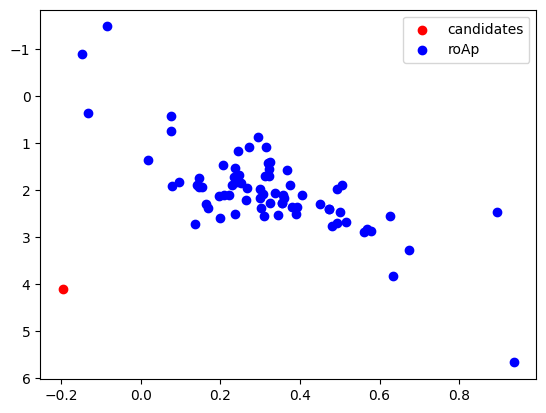

0.7179538540718253
0.07304812554486717
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


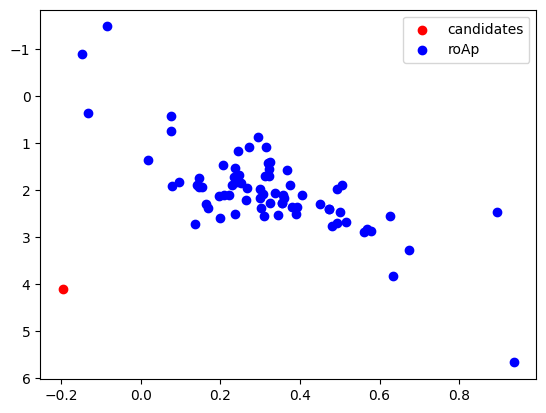

1.4701097635382512
1.3389169647576615
0.935680648358062
7.759870831549556
2.172655154182718
0.7288704504279226
4.301685365284687
1.3718742279410518
1.1678891358781698
0.9177548848135553
1.4747087730896
6.741580958842507
1.6069181950341713
1.0973894315677146
1.194404327787752
3.830829776872582
5.211428238874143
0.36230162101129526
1.3726314035024
1.7508913993048258
0.9862592747583858
1.7951110490361426
2.648673390158856
1.3809892573977098
2.7066935264461387
1.9534414620716092
1.673524301784612
1.9947530162896303
1.8382656649766211
0.959796056336339
1.3105829164390501
1.3309292113263718
0.5915779126634391
2.2393684558926257
2.511826921741834
0.7975892302916883
0.5198471952700667
0.7566270291261779
2.9816555132842018
1.7834267984541814
1.6290072724883204
2.2309622963292197
0.3010483464303948
2.202925627575582
0.6936170354120164
2.4923243549225793
1.998771098318703
1.3433430792130956
0.508100702453576
0.8093254543611845
2.657411508306419
0.953039315987966
2.004659905285581
1.81883917199956

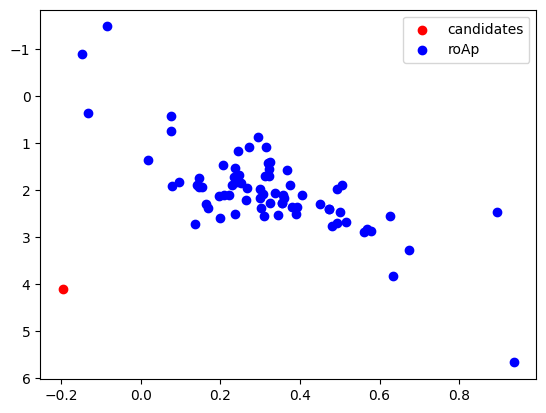

0.9747065294080812
1.1011862078740169
2.3781236861685535
1.5146579139518073
0.8645307535282045
3.215561830646199
1.5345858027070136
2.3001445400088
1.0705525498209694
2.212382989322154
2.410721327552439
0.6259632893390892
2.510340023916962
0.5721237564710404
1.2315455473335333
1.0135007310295734
0.4327288143402255
0.7802859940512379
1.4406172131182453
1.2560898401084408
6.775693161266611
0.9772031345930987
2.318174040610855
0.24718460824891775
1.4929837847278558
2.00470485801052
1.3839941741647195
3.9679390458353954
1.306713524192463
1.0825239112209104
0.9457327692345814
0.17547474322581635
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


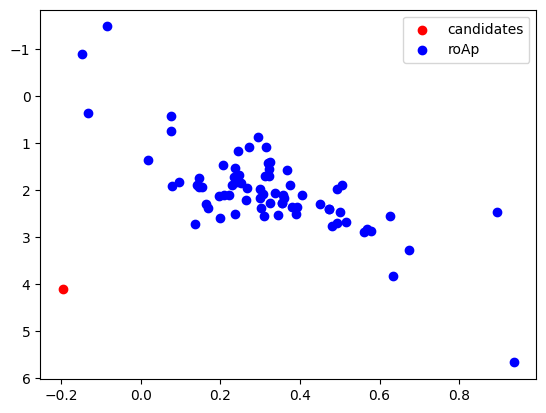

7.4454438101178475
2.782570268239562
5.443539905140539
5.799160912125044
1.473149259324443
1.0712269456538
1.8008200451032685
4.886862649017958
4.4611084753263395
1.3913629631526332
5.816834248829514
1.1858391047361039
1.5962540255181112
1.3120144878332285
1.8863477911506878
2.0549550886873647
1.1420930826088347
0.5577007426110192
1.2930270434410418
1.9883870188580257
0.3841832243503456
2.803027215988269
1.010914220394679
0.3878487053425119
0.6355555092604743
1.1501224358219053
3.75397099093436
1.1450047409828104
1.3233149113022584
0.7406445015009993
2.033792728947323
2.4756296044609902
1.3338303910358311
1.0223356704308495
1.519267297208911
1.824869752945098
0.05759476187195056
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


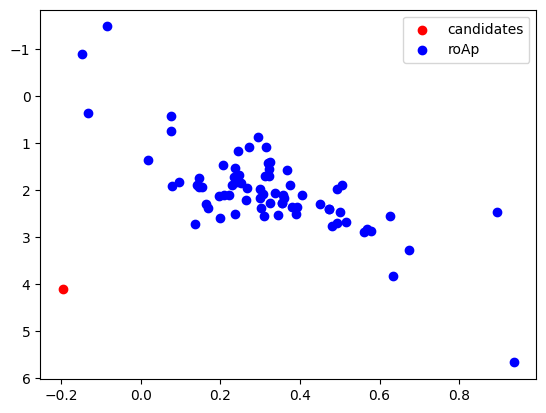

1.847228546748874
1.0615931259506346
1.5077836049382123
1.0229062242473699
1.565267766428157
1.6517948461299676
2.451531485992305
2.286790122800295
2.7150823964999526
1.2655437439530939
0.7047619582534823
4.265377395142458
0.1616880882775238
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


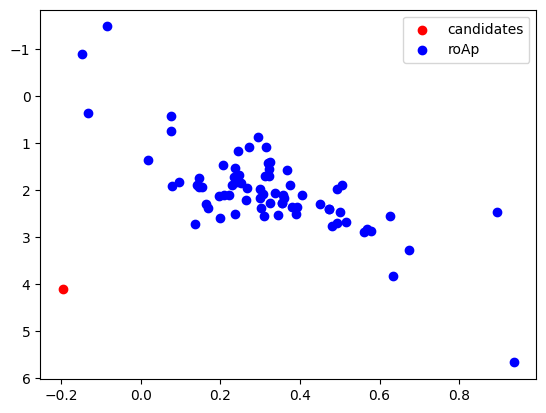

1.9085336898585492
1.3226544520358612
1.8946294662450347
1.6653014110228765
1.9931796709168
1.5836810941431452
1.386193399784763
1.440627691782761
1.7701173339706155
2.2764371644568833
5.39417489735478
1.7490137585631844
0.07709397574804733
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


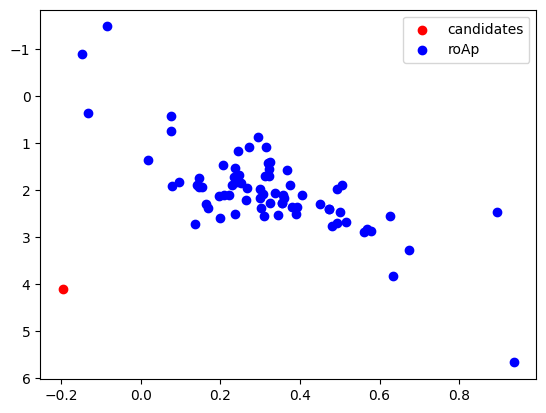

1.288763555334529
2.858958779516894
2.01820796500151
1.340749652774365
1.1426464518745245
1.1091601296976341
1.5224900617967743
1.3021283462487876
2.401194807767502
1.0676480171683513
1.4031302033806332
1.7587304629536291
1.3581048625023504
2.216950877756238
1.4275602804334762
2.0189548718158647
1.1660875689787318
1.3128893370185608
2.4084944387170486
1.8024798380240563
1.3697821972804753
1.8368859621112161
0.5592119507080797
2.4798378710955706
0.9497715986751647
2.461877528531881
2.2692654758783126
0.47896431593115585
0.9497819723809195
1.1559351689465807
0.8142287592813449
2.7634584443370755
0.9134428811214255
2.068790154262513
2.170701439598874
1.5278186886528857
2.4807784204173506
1.26665373046887
1.292570705346586
1.292249120468183
2.033650954968672
0.7079985544490182
2.5382971609264784
0.7522596990033552
1.482658489599789
8.199003627763107
0.48706974298642924
1.6125475543984158
1.075635770599642
2.109448165017974
0.8754301653334702
1.7336883372612455
1.2868236723583584
3.61399166

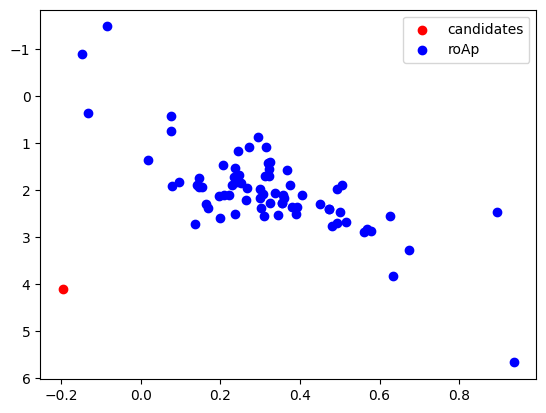

1.0773750952645509
0.18301642730964485
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


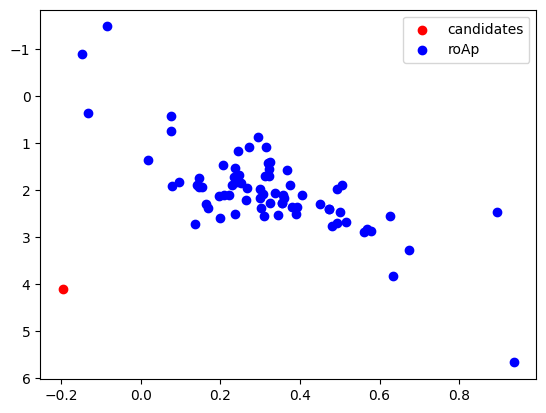

0.8182363626459028
0.42376593256797257
2.8934409774462573
2.118715342159038
1.590700635037309
4.430395390487932
1.1527849153402416
1.492112393444442
6.497228319785302
1.506244838584565
6.376035773352459
0.40646604927068
1.5868001216734582
1.1945149806491377
2.8218969867564736
1.2668404571724592
1.2231879033557442
0.7926134143900043
2.204595794202125
1.8633665750016153
0.2692253800349711
1.2866818983797081
1.2805821593958138
2.4523821298642083
1.022169691138771
0.05916119144094378
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


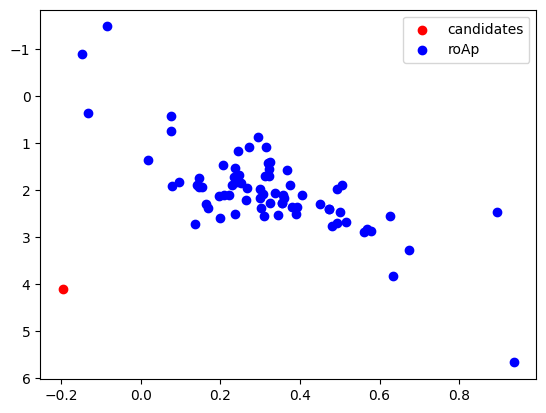

1.1283169063250575
0.9922138868204717
1.8974891511314746
0.14587856070702143
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


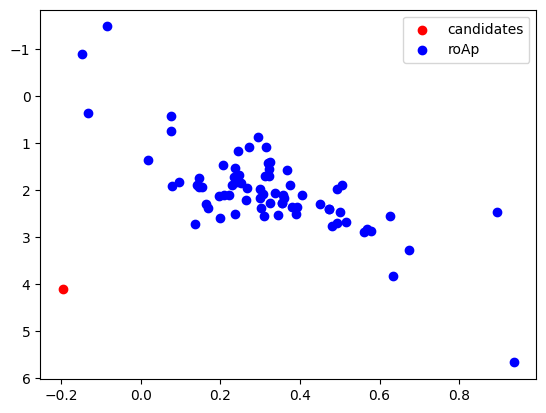

1.7600721288979315
1.744608391519261
1.2260372145364293
5.113175413767352
2.351093266873143
6.8605224111265315
0.6643320640658696
1.3243626555835055
2.4538863171986725
2.197731858894284
8.079823580246718
2.436423912511219
1.2502044910434815
2.23611111228558
2.1998688422797983
0.8395336855195197
2.706807637209442
2.092528650931695
1.6574969263932564
1.2946731097129165
0.1702808695857576
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


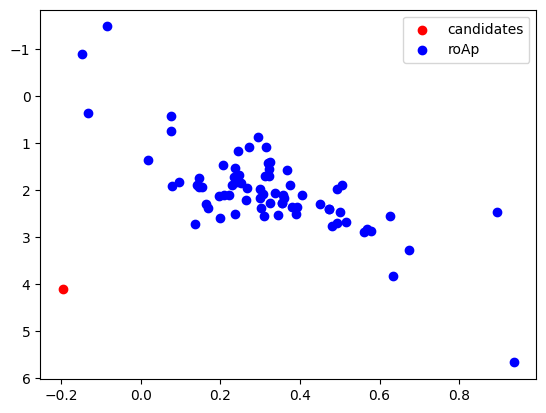

1.8647739410823672
1.1969078487766067
5.525277790685493
1.0233452728322345
2.394821894532061
2.131689390156528
0.8144120280830149
2.371014239824513
1.1855728462883945
1.1796840393215167
1.180773278425784
1.784747716986975
1.2792059144323273
1.5620380860364582
3.1869718975856314
1.1769350072964624
1.0313089259088573
2.542961870614275
2.010123390316507
3.391945949597149
1.7591557848895807
2.993412379806448
0.995906821110464
0.18594170737377258
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


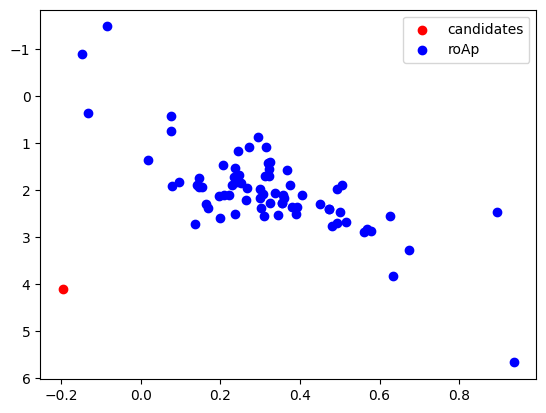

1.6668678405918698
1.5152665046894294
0.25604029506170356
2.366684946622792
1.4892285032445738
0.7673914777978688
2.694611617143572
1.0920850100250314
1.1765546380854488
1.0134903573238185
2.5102708658785957
1.467855106528754
1.4374429641159994
1.6939535863179733
0.9829916624043458
1.7096697505366807
11.207516612767423
2.646290895737142
1.0298393175935763
1.6075233278698757
5.535067111016223
1.6481882544291722
0.9123225208998944
8.005886721429464
1.2684138025452887
1.2597967109648662
0.2409535739508879
2.736676993979784
1.6866677869760993
1.151962039642445
1.5286209218979332
1.7833818457292434
1.3746751284948804
1.8536498706111715
3.189841956177827
1.064757106205886
2.7540840722365436
1.2010919100977588
2.151506626050349
0.6357837307870828
1.8214118510267898
1.4030022610096564
2.860117176659527
0.20900591316888395
2.1670326056635494
0.5552734004231277
1.3381977211586538
6.846583608493834
1.6035052458408021
0.6183592580619706
2.4523821298642083
1.2711559187665067
0.7913478222879036
1.43

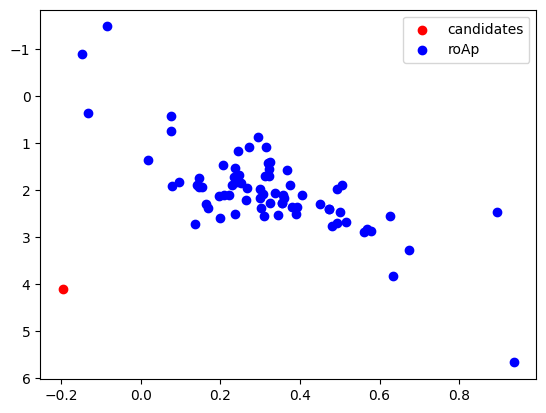

0.8125240136356195
2.016192008183137
0.9171047992529129
0.5337374823171479
2.46843716847091
2.4467457497373672
1.4209695193771825
2.736227466730404
0.17005621091982803
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


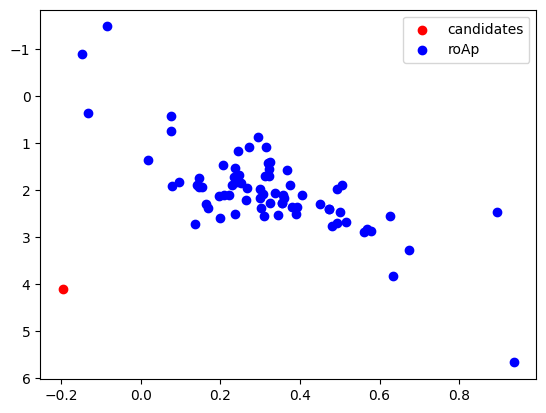

0.971715444248745
0.31114552499061343
0.06249125594703475
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


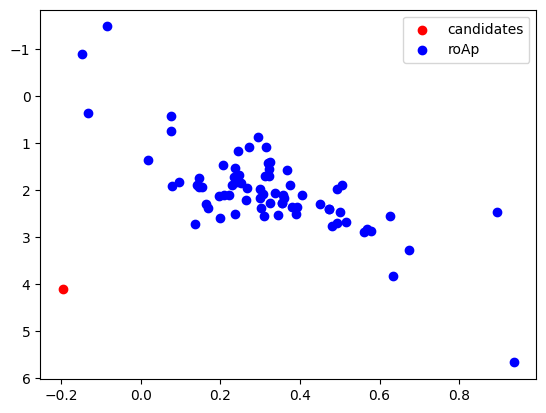

1.9075620194195047
1.4878245950657405
3.541928987401821
2.8265824438557807
1.7217724072507572
1.9640295577454676
1.3801316977219695
1.6327729276773573
2.7701909793720203
0.3886093388057792
2.408508270324722
2.01973981555132
2.5186459043247362
1.4854282690363538
1.2700563059564853
1.3200402781856209
0.6249708714885349
5.1141297946968045
0.4601015659255485
5.721703909154955
2.492732387348939
7.859686628323422
2.6613120216702706
1.8594280247166637
1.1418511344333133
2.5798784314941274
0.7641306762889051
2.157893370893463
2.091854360057625
1.246086129858777
2.1653555232331705
1.4682148332870186
1.2827087690755725
1.325980953681273
1.5519513861407548
4.48333586885722
0.3583424282735934
1.625373017572179
1.5248518088069778
2.384994537280231
0.9661343905525968
1.4184763720940827
1.8150769747124507
3.461356414803337
1.2563007721254573
1.4666449458161068
1.1924851922230912
1.1651261672866813
0.103318703896492
ID: 101 --- Gmag: 4.097066 --- B-R:  [-0.19569553]


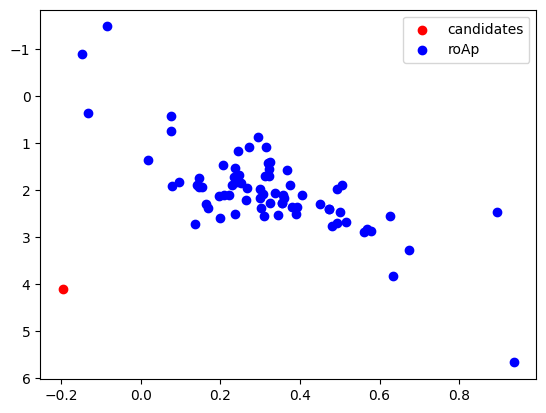

0.4227769726193369
1.0773681794607137
0.7212146555807895
0.9810793376847611
2.042181599001136
0.5860867644171663
2.1338886157765717
1.5101557256541707
8.100768092165907
1.2374517487687626
2.2367093293174474
1.6549519105813824
2.775740911950904
1.425302270480822
1.339943961627399
1.5172167613713547
1.3837796792870238
1.7690050140427442
0.9057132408854238
0.6588882019566298
0.11050534857255867
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


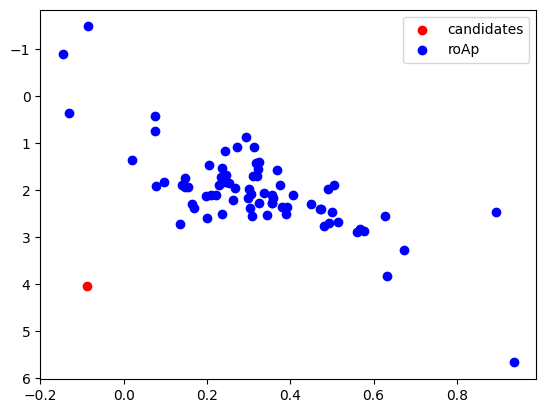

1.155055632410746
0.23748642281664933
0.963131702238921
0.5973721268299381
0.30668705996933054
0.883354447081647
0.36770173931786765
1.198801549579255
0.4663718665932639
0.24075870199487825
0.6510595120135814
0.9205510980168816
1.2064919234455709
0.2007092819770402
0.5304306035934219
0.7054142722674579
0.1715349634922796
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


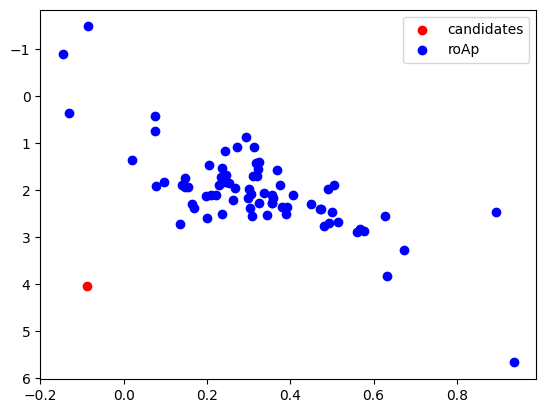

0.23092678287762025
0.042090759118843746
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


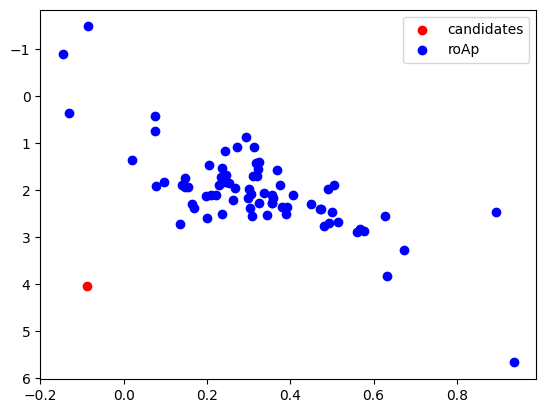

0.49663196628037376
0.7799735534300059
0.4506671800438211
0.2646355147407924
0.6781348840339296
0.3843411633487639
0.2630299442871875
1.624060139333046
0.974183156769832
0.22913669364744704
0.9352229758562607
1.4035646695737558
0.435881191441138
0.06553989599039722
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


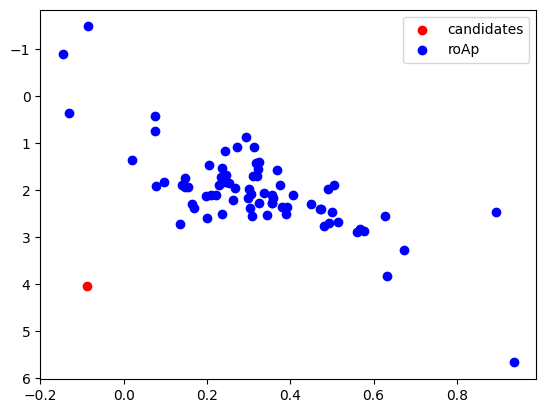

0.19132343220724346
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


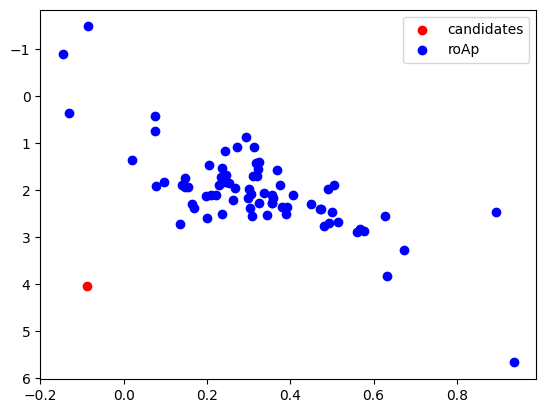

0.2775462165402427
0.16199005023424062
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


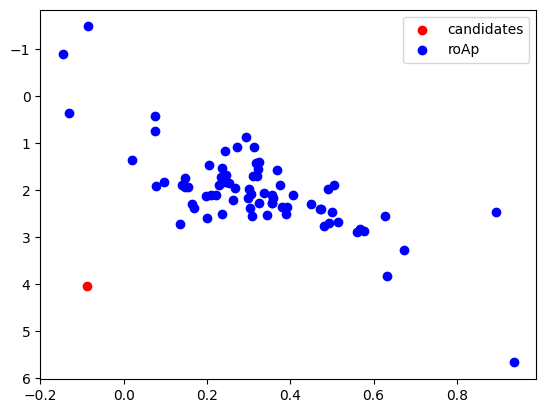

0.24142953496703035
0.7586071774767833
0.8582351435835505
0.3111754166592937
0.41052093877227036
0.12263331456357385
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


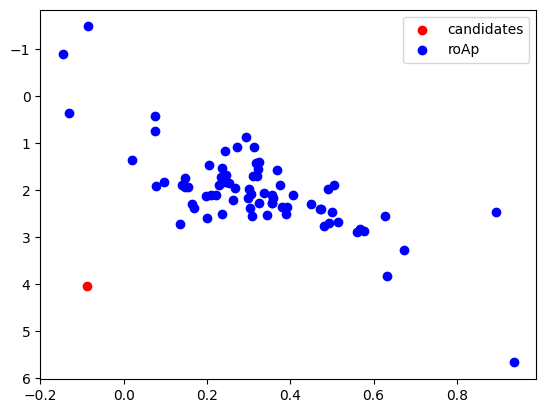

0.486539454544344
0.2769629350795588
0.3106902064272208
0.08598882397175833
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


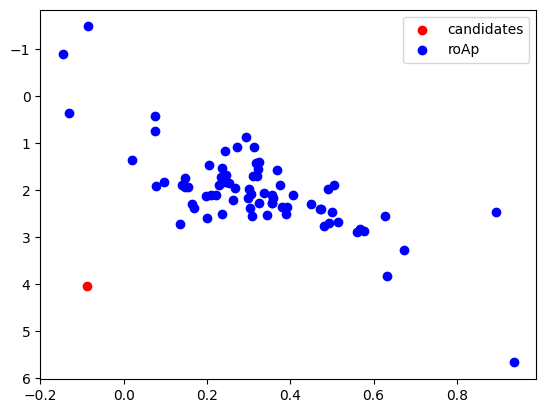

0.5302819138109347
0.7209114847018019
0.5285207377710059
1.2503415776716291
0.6968514031542186
0.1690199648341597
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


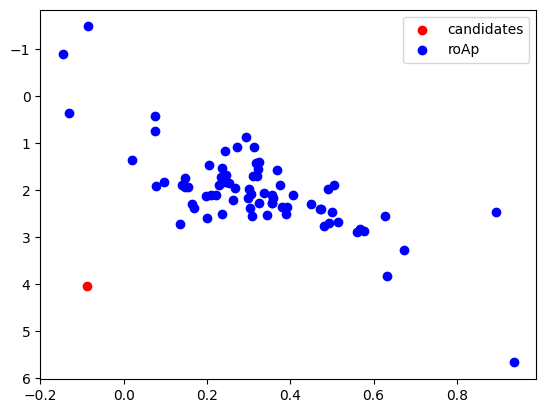

0.3571343910555198
0.3928441441658821
0.7207500672751521
0.5590931525942735
1.9760030426399822
0.6525222045250256
0.6685564957202175
0.7902608116369707
0.4310159234420792
0.6197897049663261
0.1809681199254225
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


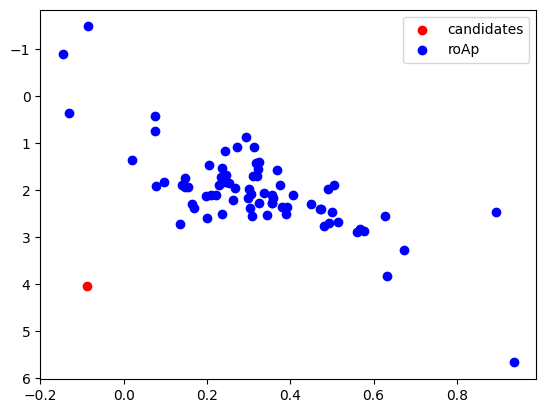

0.9795325310374539
0.40029592279983484
1.924691236074216
0.7539182624755583
0.1700607933115701
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


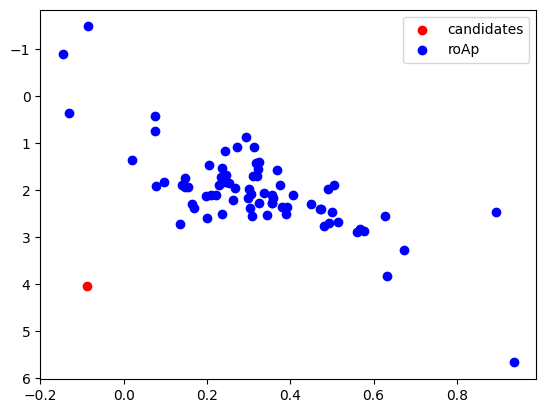

0.4242418935841148
1.7656761584589242
0.1534777996748775
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


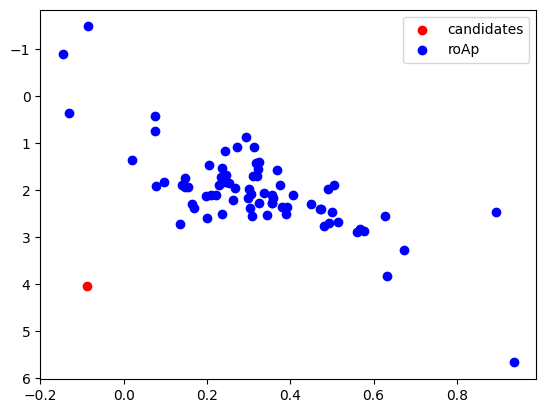

0.35985921776714624
1.134010841335926
0.628918566030658
0.9850375108913996
0.23782294326623576
0.4153135908310446
1.212463720058488
0.7454152816584401
1.2066509869338131
0.06087062443717217
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


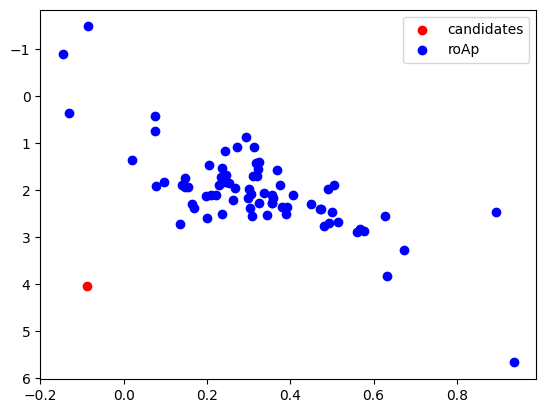

0.6305956484610371
0.11253624096211601
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


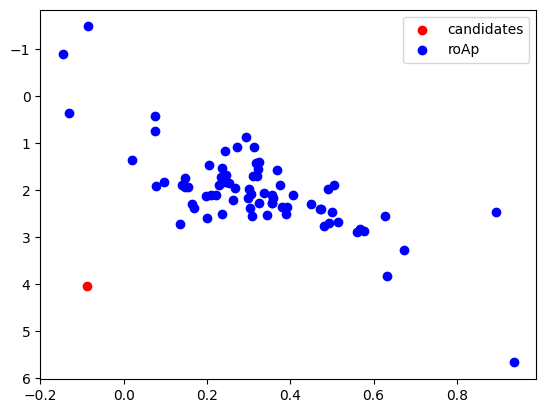

0.010623851662244999
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


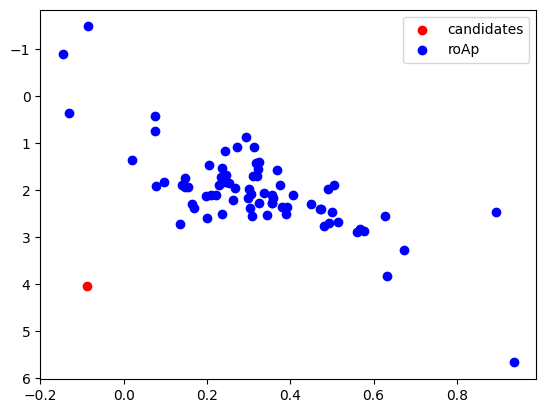

0.34309185136527276
0.5476889920676951
0.9599988431009343
1.0010372230674085
0.34725516527491473
6.849828244983028
2.199566775364321
0.44400726094916076
1.6013451816316837
0.5569688968529225
0.29848381265559487
2.4222856760570832
1.9353785069401952
1.342476270321424
6.514114379342221
2.125359096233931
0.1462012700752484
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


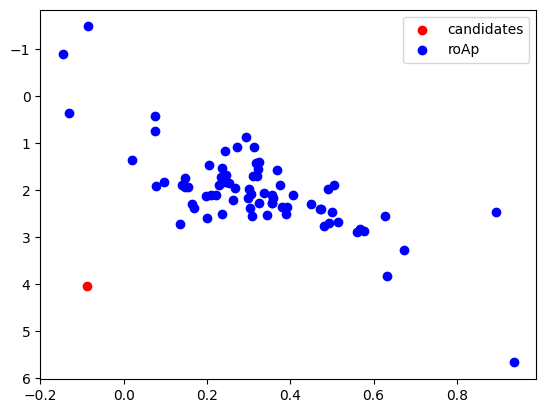

0.7713622736899093
2.1129002756222683
0.03468157927142057
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


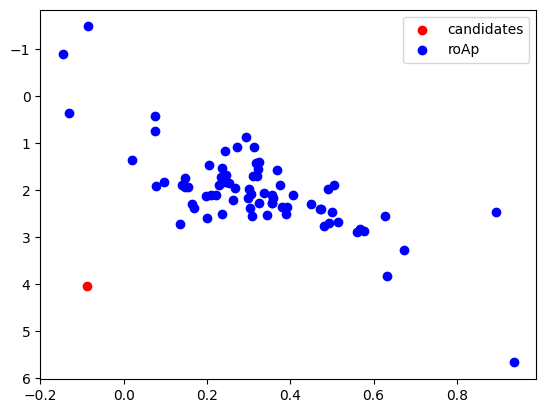

1.8906954983518243
2.9414516121698635
0.4996749199684847
0.6579292591617487
5.485056600061563
2.077505191586473
2.2944193789219063
0.9375974505106277
2.948408910829498
1.5368311055418196
1.289708687048051
0.9518993328447478
1.987430304516479
5.904783650709572
0.8258311447070903
0.27539650551056516
0.019282438065686858
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


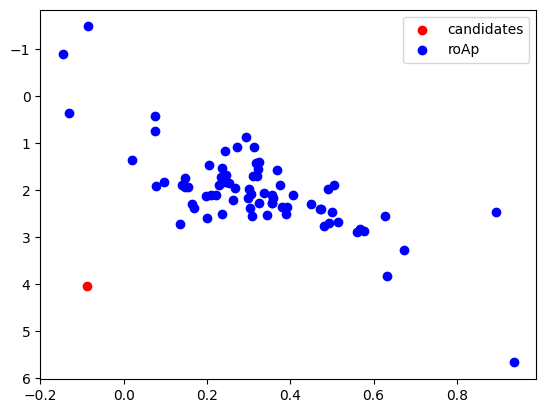

0.7001709889957932
1.2662087856112323
1.1233351941506
4.706931847188649
1.5454966077490977
0.9965938191023833
2.114497826308527
0.937442948887814
1.6093778877879124
3.34361252107287
1.8985380199025461
1.1668874688116841
0.7560126470745421
2.2628625660154316
3.0779937852180743
0.3323193829262343
4.290648866851273
5.693865465300483
1.7732928124214458
2.3352744900867095
0.5794902120468595
1.508732194553652
0.8039990559584067
1.170794897979372
4.606064848231616
3.09473694630652
0.6702774269120249
0.1505686001980706
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


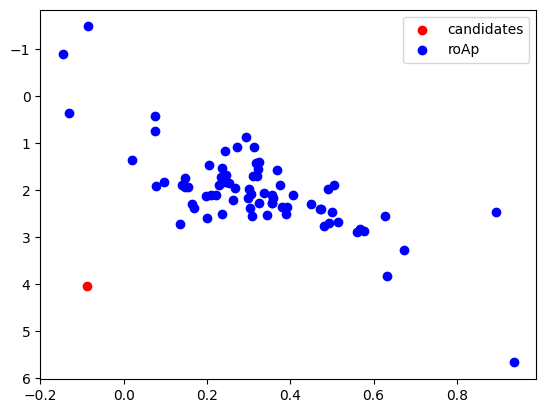

1.0422301046566962
1.7174719017542066
2.1465387454835647
0.6318151838746897
1.0789910599502242
2.8618541679123415
0.6142075473066675
0.6447408212453234
1.1866804993920765
1.5776516376874405
5.553488479024869
0.4729280486303753
1.684422379182533
1.9110774762218392
0.5387734169587879
1.1307800569807172
0.5426497250092104
0.2425211280097055
0.7906262452768007
0.6280506326491628
1.0368323197622185
1.9331861971239879
1.280244409497643
3.8302568896439673
1.0417045035651138
0.7322810662091981
0.9111248573875752
1.6581377627379674
0.2165937794262356
6.610793859076182
1.6924539813752513
0.14609517907929037
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


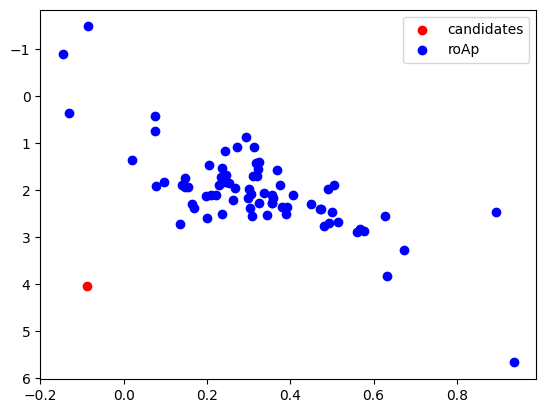

0.5928007804939355
1.6115459922906914
0.7494322597240033
0.2793004767763345
1.1975625167289912
4.52576199198276
0.7306005258769006
0.6769269723009299
1.1739945612173164
1.742023005374191
1.553774824941526
0.9266808541545308
1.591915483100459
1.936509240867481
0.8406182372732838
1.9176671333146236
0.06322545564353943
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


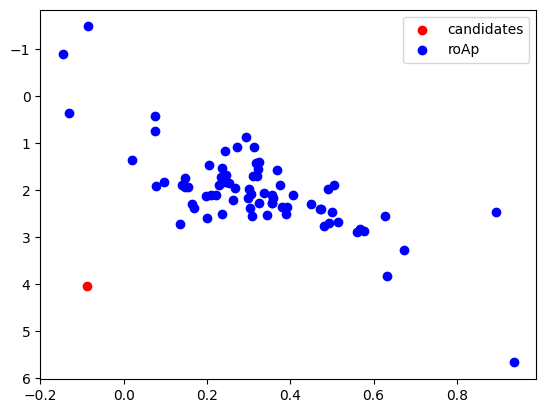

0.25519779644222096
1.4690078173161347
0.5670106440236871
0.7501860823421942
1.6653267408261292
1.1363507369711106
0.9156501470351297
0.7957312124717333
0.7485228315194878
1.1350851448690098
0.7864421839556495
1.3902402695190061
4.260658483513792
1.4978882141378391
1.7913361446311744
1.2114148718137305
2.00843014286636
1.4986212893445203
0.9705789190074454
1.8419702024209523
3.0713269503195773
1.390904186687322
2.0920180059376086
1.084164081220012
1.374064204345164
2.18871823308308
1.2266434718619572
2.372882631350223
6.3339784368099075
0.778219293193914
1.7509063554023228
1.1569390849927133
2.3755313842196464
2.493200328597735
0.33819781618735734
6.195451428060586
1.1433495304537646
2.550456268561072
1.5945331148526178
1.8723859076943854
4.572011430140124
1.8227096887359795
1.7198440224701659
1.228911855520367
0.7627382663056506
1.399991552928634
1.2075454795671443
0.2584620558531032
4.680817771901589
1.0469708881866961
1.4745370024835087
2.373660659281842
0.72255053021108
0.778236582

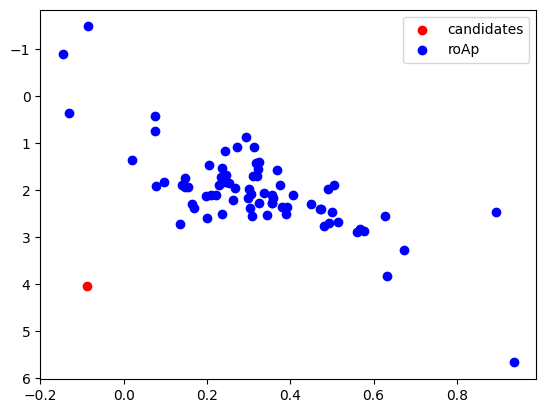

1.3975652097454923
1.1895574737881085
1.6466990231922058
0.701408917882548
0.8381343597324293
2.0797424541276173
0.38797196036298676
0.298608297124654
1.406264187008444
2.2505040245593997
0.7323260189341352
0.02984397448770837
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


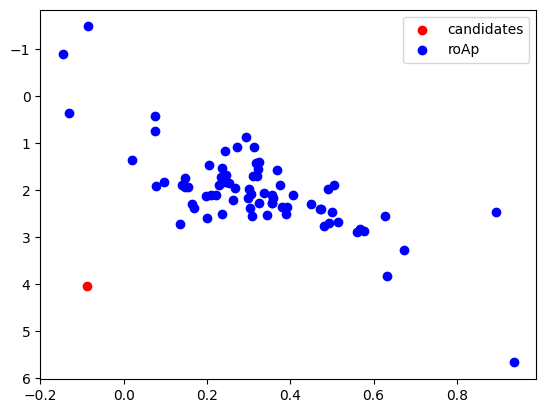

1.338648372897858
0.1417347647603049
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


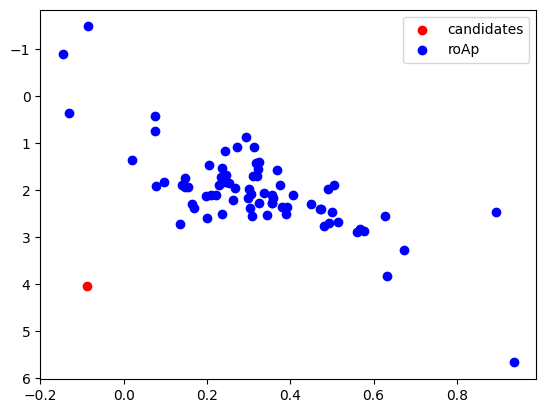

1.6574507442197342
0.04725105274446895
ID: 102 --- Gmag: 4.04336 --- B-R:  [-0.08883488]


KeyboardInterrupt: 

In [22]:
print('Stars in NGC 2264 following the regression:')
cands = []
thresh = .2
for n in range(len(all)):
    for m in range(len(all)):
        print(dist[n][m])
        if dist[n][m]<thresh:
            cand = clust.iloc[n]['id']
            print('ID:',cand, '--- Gmag:', ytrain[n], '--- B-R: ', xtrain[n])
            cands.append({'ID':cand,'Gmag':ytrain[n],'B-R':xtrain[n]})
            #TO DO: split this plotting up into a separate cell
            plt.gca().invert_yaxis()
            plt.scatter(xtrain[n],ytrain[n],c='r',label='candidates')
            plt.scatter(xtrain_r,ytrain_r,c='b',label='roAp')
            plt.legend()
            plt.show()
    